In [1]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras import layers, losses, models, optimizers

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.preprocessing import MinMaxScaler

import vae as V

def data_scaling(data):             #스케일러, main
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    return data


def data_sliding(data, n_features, Time_window): #데이터 밀기, main
    reshape_num = data.shape[0] - Time_window + 1
    data = sliding_window_view(data, (Time_window, n_features))
    data = data.reshape(reshape_num,Time_window, n_features,1)

    return data


def data_load_processing(FILENAME, Time_window=None): #데이터 로딩 및 스케일러 사용, main
    df = pd.read_csv(FILENAME)
    df = df.drop(['Time'], axis=1)
    n_features = df.shape[1]
    x_train, x_test = train_test_split(df, test_size=0.9, shuffle=False)
    #x_validation, x_test = train_test_split(x_test, test_size=0.5, shuffle=False)

    x_train = data_scaling(x_train)
    x_test = data_scaling(x_test)
    #x_validation = data_scaling(x_validation)

    x_train = data_sliding(x_train, n_features, Time_window)
    x_test = data_sliding(x_test, n_features, Time_window)
    #x_validation = data_sliding(x_validation, n_features, Time_window)

    return x_train, x_test #, x_validation


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


def vae_model(input_shape, latent_dim, kernel_size, strides, padding):
    inputs = tf.keras.Input(shape=input_shape)
    h = layers.Conv2D(32, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu',
                      name="conv1", data_format="channels_first")(inputs)
    h = layers.Conv2D(64, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu',
                      name="conv2", data_format="channels_first")(h)
    h = layers.Conv2D(128, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu',
                      name="conv3", data_format="channels_first")(h)
    shape_save = h.get_shape().as_list()
    h = layers.Flatten()(h)
    h = layers.Dense(16, activation="relu")(h)

    # vae
    z_mean = layers.Dense(latent_dim, name='z_mean')(h)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(h)
    z = sampling([z_mean, z_log_var])
    encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # decoder
    latent_inputs = tf.keras.Input(shape=(latent_dim,))
    h = layers.Dense(shape_save[1] * shape_save[2] * shape_save[3], activation="relu")(latent_inputs)
    h = layers.Reshape((shape_save[1], shape_save[2], shape_save[3]))(h)
    h = layers.Conv2DTranspose(64, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu',
                               data_format="channels_first")(h)
    h = layers.Conv2DTranspose(32, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu',
                               data_format="channels_first")(h)
    decoder_outputs = layers.Conv2DTranspose(1,kernel_size=kernel_size, strides=strides, padding=padding, activation='relu',
                                             data_format="channels_first")(h)
    decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

    return encoder, decoder

def lstm_preprocess(latent_z, seq_length):
    reshape_num = latent_z.shape[0] - seq_length + 1
    slide_z = sliding_window_view(latent_z, (seq_length, latent_z.shape[1]))
    slide_z = slide_z.reshape(reshape_num, seq_length, latent_z.shape[1])
    slide_z = slide_z[:-1]

    dataY = []
    for i in range(0, len(latent_z) - seq_length):
        _y = latent_z[i + seq_length]  # 다음 나타날 z(정답)
        dataY.append(_y)  # dataY 리스트에 추가
    dataY = np.array(dataY)
    
    return slide_z, dataY
    
    
def lstm_model(seq_length, latent_dim, lstm_z):
    
    inputs = tf.keras.Input(shape=(seq_length, latent_dim))
    h = layers.LSTM(32, activation="relu", name='lstm1')(inputs)
    lstm_outputs = layers.Dense(latent_dim, activation='sigmoid')(h)
    lstm = tf.keras.Model(inputs, lstm_outputs, name='lstm')
    lstm.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())
    lstm.fit(lstm_z, dataY, epochs=5, batch_size=256)
    lstm_results = lstm.predict(lstm_z)

    return lstm_results
    
    
if __name__ == '__main__':
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.compat.v1.Session(config=config)

    #---------------------------------사용자 설정 변수---------------------------------------
    FILENAME = "BTC_USDT.csv"
    Time_window = 8
    latent_dim = 2
    #-------------------------------------------------------------------------------------

    #데이터 로딩
    x_train, x_test= data_load_processing(FILENAME, Time_window=Time_window)


In [2]:
def vae_model(input_shape, latent_dim, kernel_size, strides, padding):
    inputs = tf.keras.Input(shape=input_shape)
    h = layers.Conv2D(32, kernel_size=(2,4), strides=(2,2), padding="same", activation='relu',
                      name="conv1")(inputs)
    h = layers.Conv2D(64, kernel_size=(2,4), strides=(2,2), padding="same", activation='relu',
                      name="conv2")(h)
    h = layers.Conv2D(128, kernel_size=(2,4), strides=(2,2), padding="same", activation='relu',
                      name="conv3")(h)
    shape_save = h.get_shape().as_list()
    h = layers.Flatten()(h)
    h = layers.Dense(32, activation="relu")(h)

    # vae
    z_mean = layers.Dense(latent_dim, name='z_mean')(h)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(h)
    z = Sampling()([z_mean, z_log_var])
    encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # decoder
    latent_inputs = tf.keras.Input(shape=(latent_dim,))
    h = layers.Dense(shape_save[1] * shape_save[2] * shape_save[3], activation="relu")(latent_inputs)
    h = layers.Reshape((shape_save[1], shape_save[2], shape_save[3]))(h)
    h = layers.Conv2DTranspose(64, kernel_size=(2,6), strides=(2,1), padding='valid', activation='relu')(h)
    h = layers.Conv2DTranspose(32, kernel_size=(2,4), strides=(2,2), padding='valid', activation='relu')(h)
    decoder_outputs = layers.Conv2DTranspose(1,kernel_size=(2,4), strides=(2,2), padding='valid', activation="relu")(h)
    decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

    return encoder, decoder

In [3]:
#VAE_model
latent_dim = 2
input_shape = (8, 54, 1)
kernel_size = (2,8)
strides = (2,2)
padding = "same"

encoder, decoder = vae_model(input_shape, latent_dim, kernel_size, strides, padding)
encoder.summary()
decoder.summary()

#VAE
vae = V.VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(x_train, epochs=10, batch_size=128)

z_mean_, z_log_var_, latent_z = vae.encoder.predict(x_train)

decoded_latent_z = vae.decoder.predict(latent_z)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8, 54, 1)]   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 4, 27, 32)    288         input_1[0][0]                    
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 2, 14, 64)    16448       conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 1, 7, 128)    65664       conv2[0][0]                      
____________________________________________________________________________________________

In [235]:
import seaborn as sns
import matplotlib.pyplot as plt

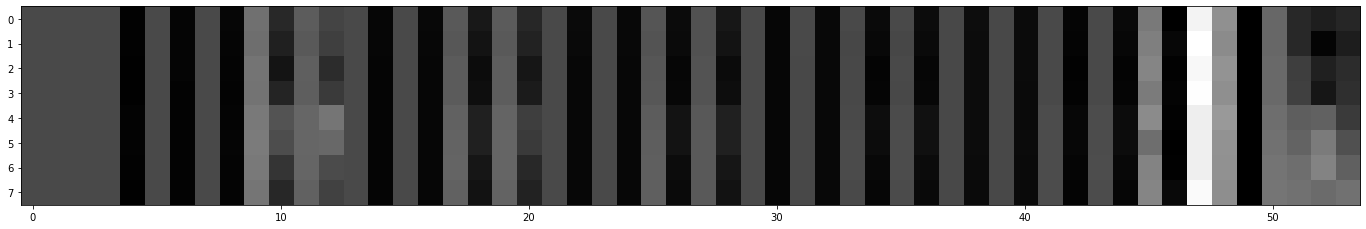

In [240]:
plt.figure(figsize=(24, 8))
plt.imshow(x_train[3], 'gray')
plt.show()

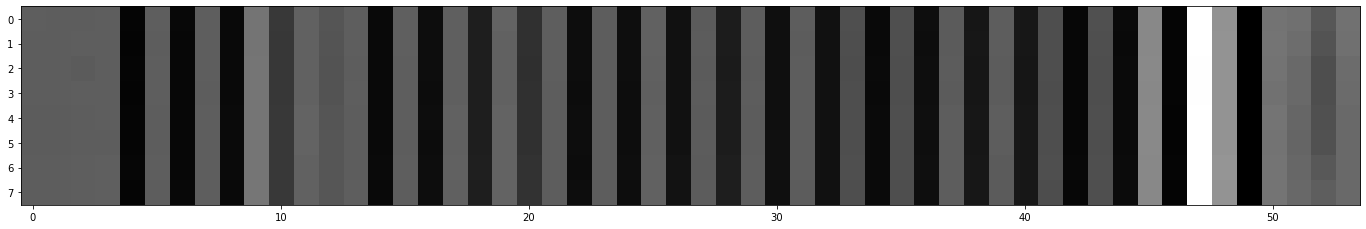

In [241]:
plt.figure(figsize=(24, 8))
plt.imshow(decoded_latent_z[3], 'gray')
plt.show()

In [196]:
tmp = pd.read_csv(FILENAME)
tmp=tmp.drop('Time',axis=1)
tmp.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'close_ma5', 'volume_ma5',
       'close_ema5', 'volume_ema5', 'close_ma5_ratio', 'volume_ma5_ratio',
       'close_ema5_ratio', 'volume_ema5_ratio', 'close_ma10', 'volume_ma10',
       'close_ema10', 'volume_ema10', 'close_ma10_ratio', 'volume_ma10_ratio',
       'close_ema10_ratio', 'volume_ema10_ratio', 'close_ma20', 'volume_ma20',
       'close_ema20', 'volume_ema20', 'close_ma20_ratio', 'volume_ma20_ratio',
       'close_ema20_ratio', 'volume_ema20_ratio', 'close_ma60', 'volume_ma60',
       'close_ema60', 'volume_ema60', 'close_ma60_ratio', 'volume_ma60_ratio',
       'close_ema60_ratio', 'volume_ema60_ratio', 'close_ma120',
       'volume_ma120', 'close_ema120', 'volume_ema120', 'close_ma120_ratio',
       'volume_ma120_ratio', 'close_ema120_ratio', 'volume_ema120_ratio',
       'open_lastclose_ratio', 'high_close_ratio', 'low_close_ratio',
       'close_lastclose_ratio', 'volume_lastvolume_ratio', 'MACD', 'RSI',
       'Fast_k', 

In [242]:
heat_train=pd.DataFrame(x_train[1].reshape(8,54),columns=tmp.columns)
heat_z=pd.DataFrame(decoded_latent_z[1].reshape(8,54),columns=tmp.columns)

In [ ]:
heat_train=pd.DataFrame(x_train[i].reshape(8,54),columns=tmp.columns)
plt.figure(figsize=(24, 8))
sns.heatmap(heat_train, cmap='viridis')

In [ ]:
heat_z=pd.DataFrame(decoded_latent_z[i].reshape(8,54),columns=tmp.columns)
plt.figure(figsize=(24, 8))
sns.heatmap(heat_z, cmap='viridis')

<ipython-input-247-fc62be8c0f34>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(24, 8))


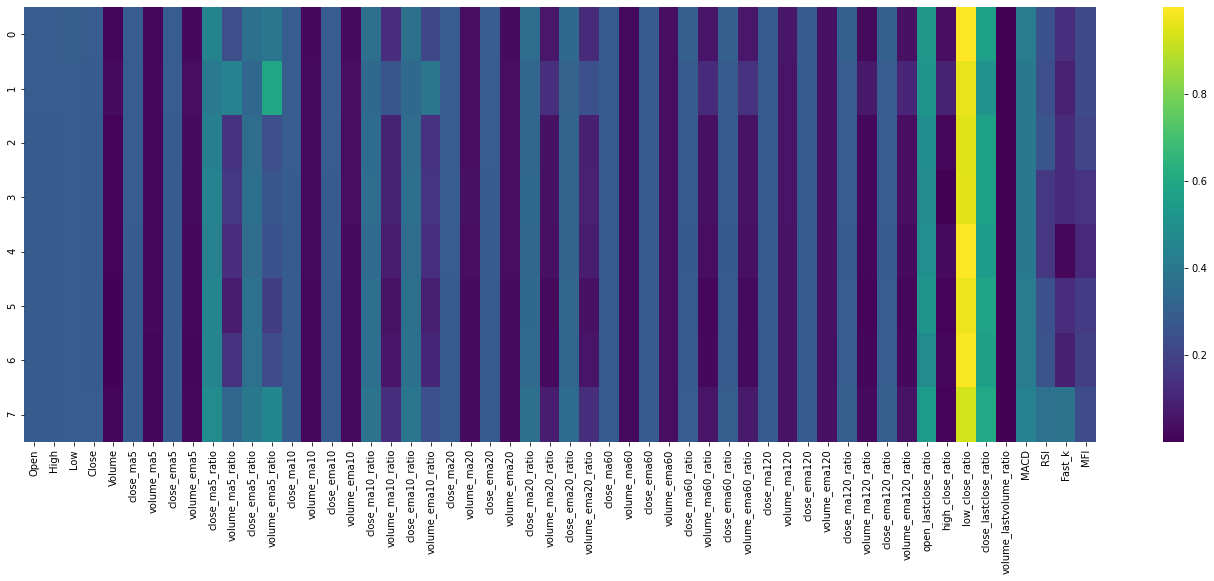

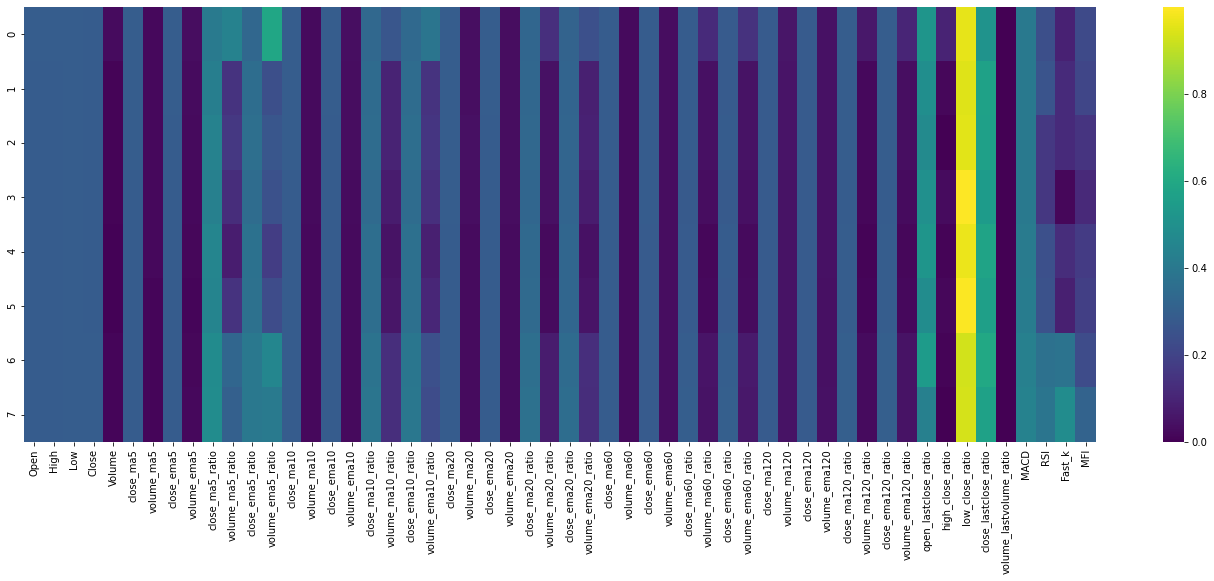

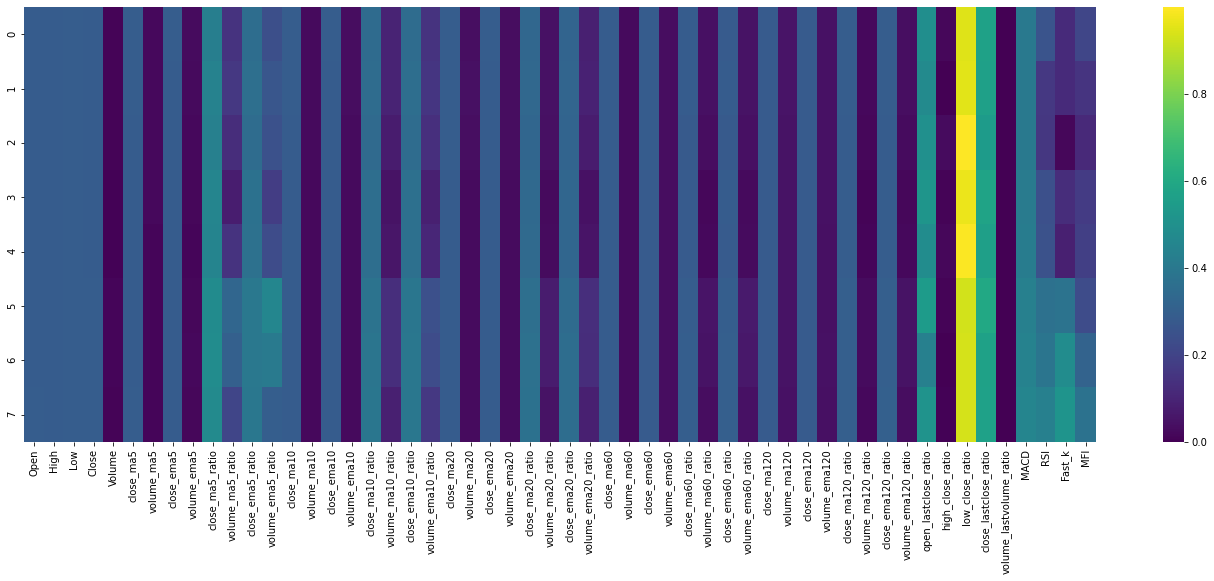

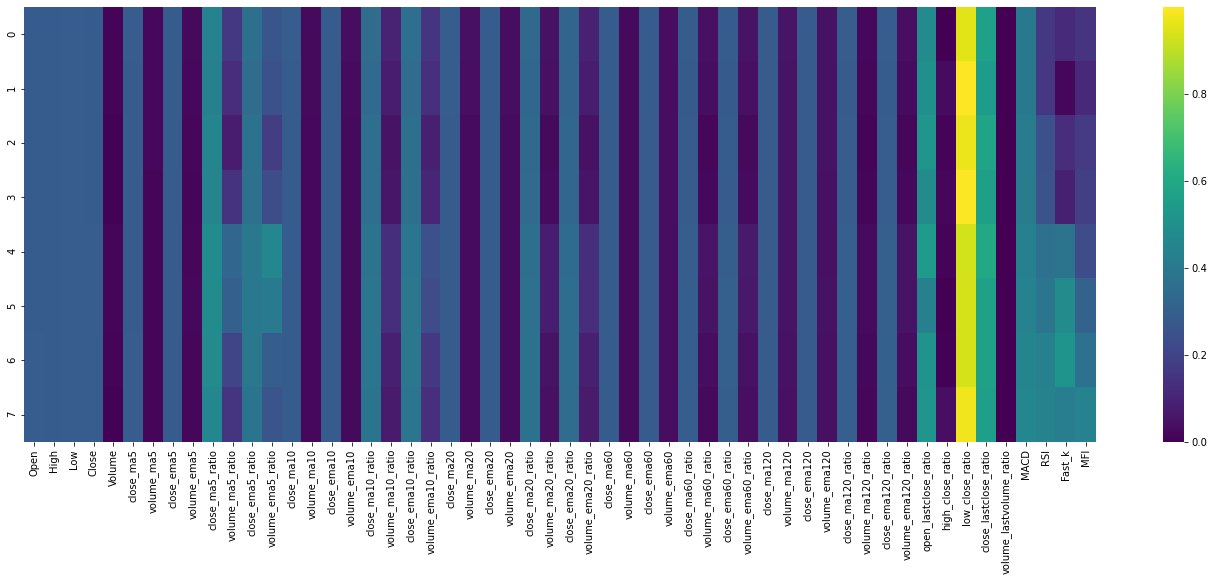

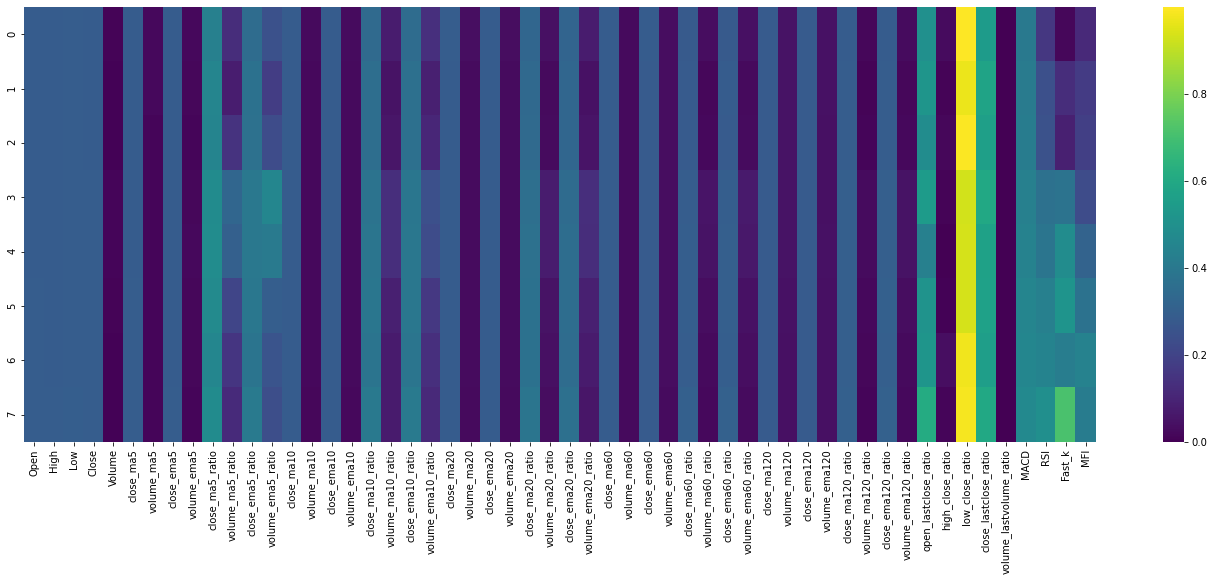

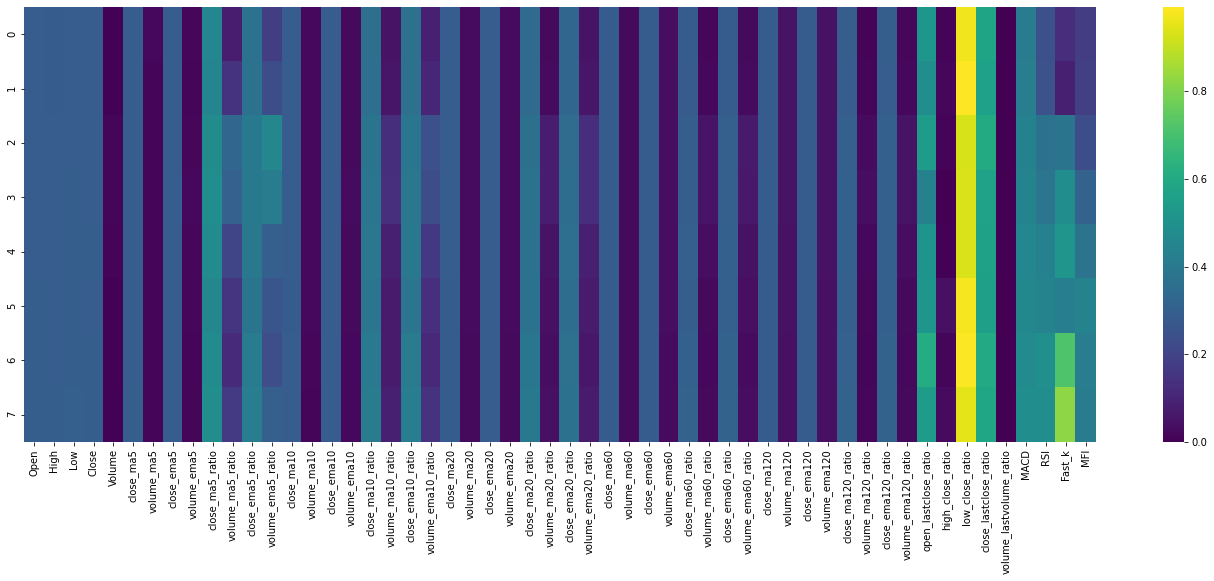

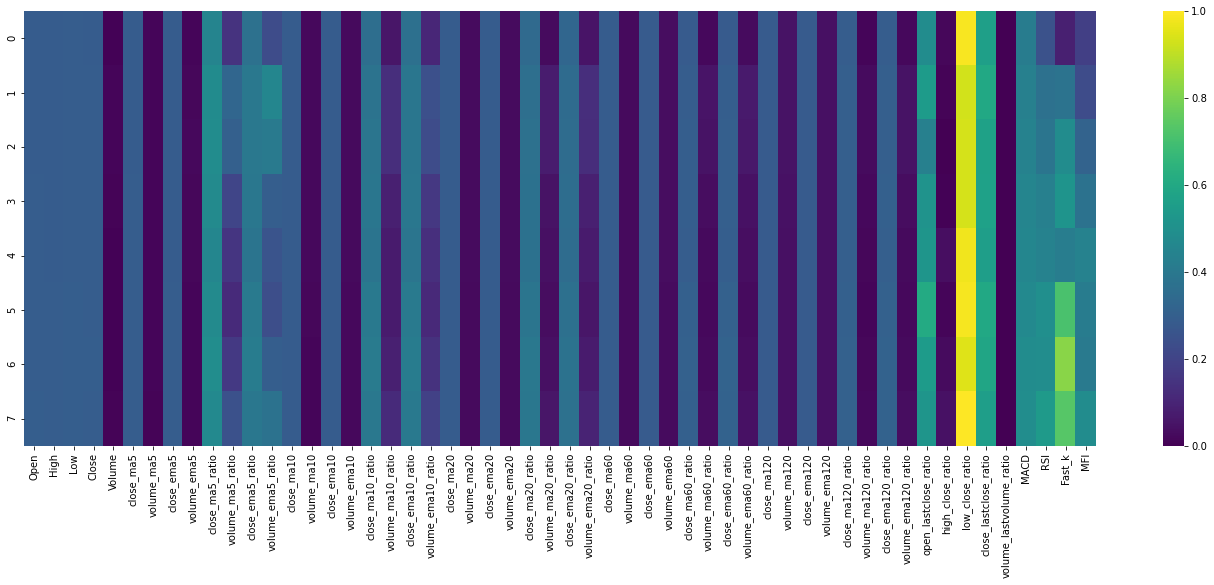

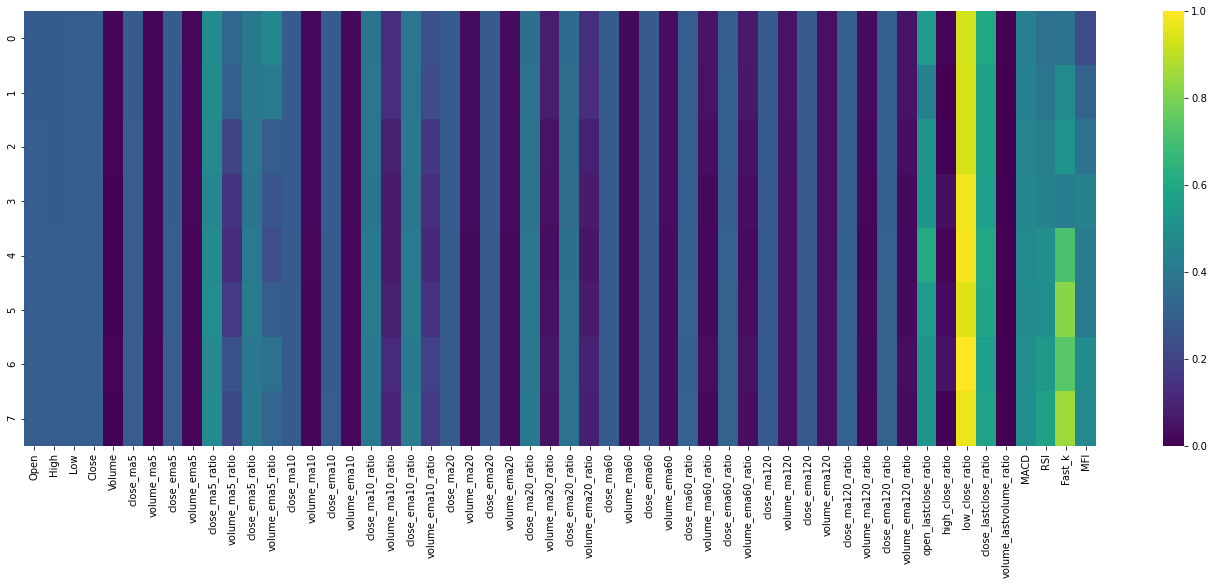

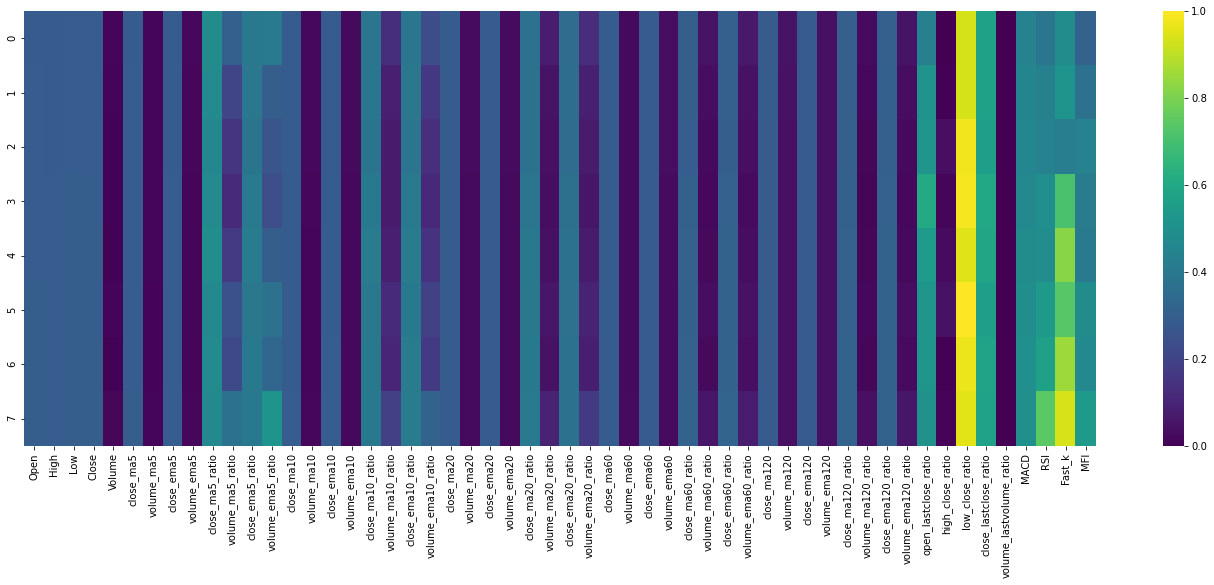

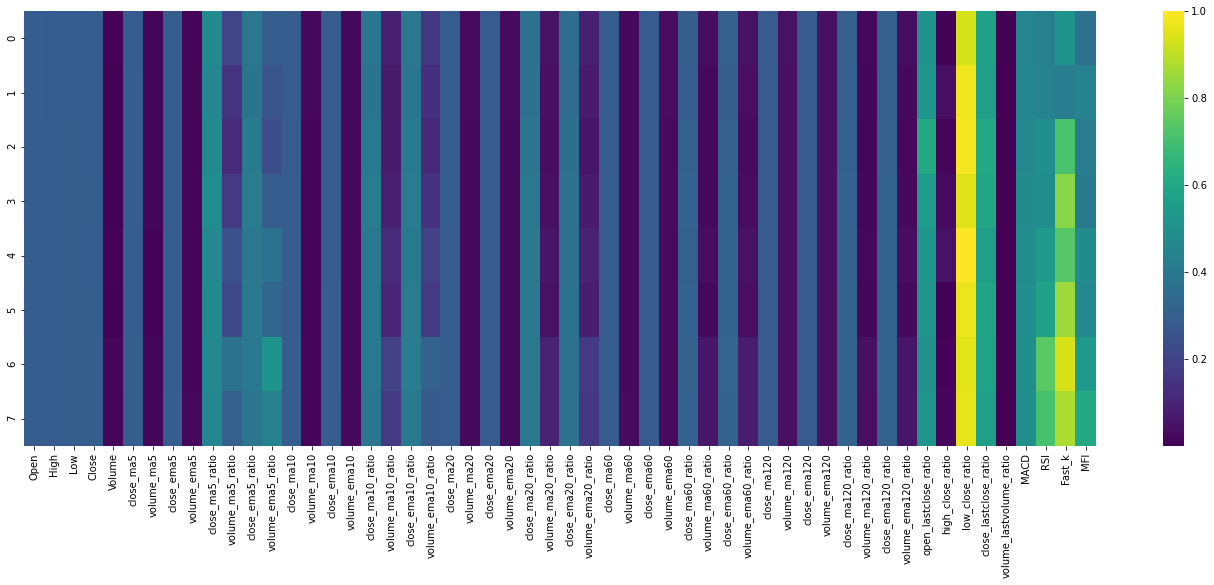

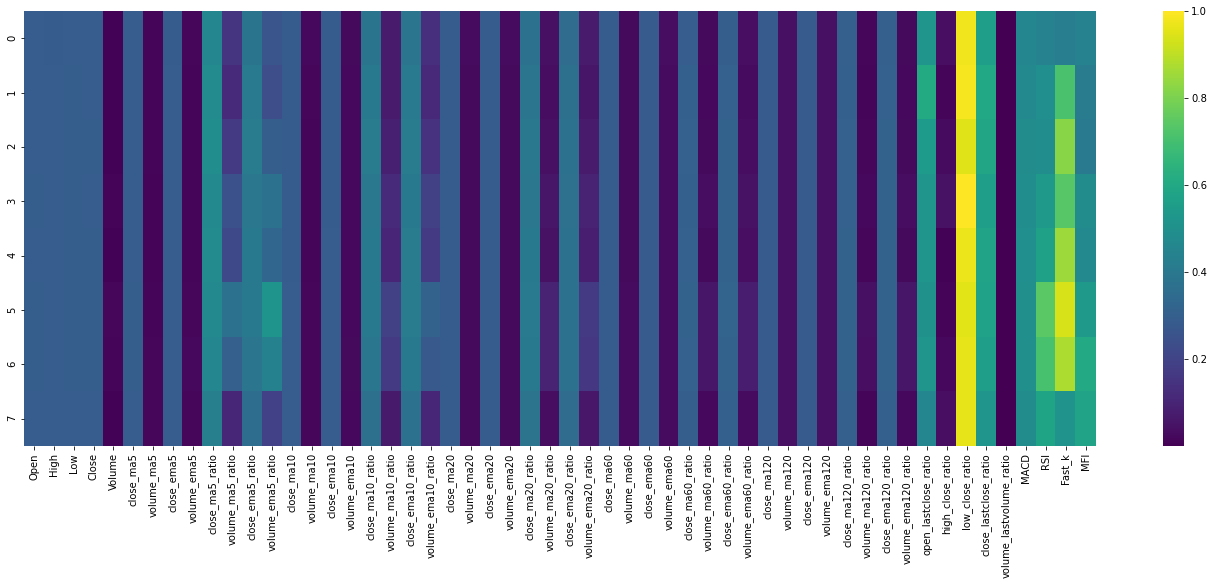

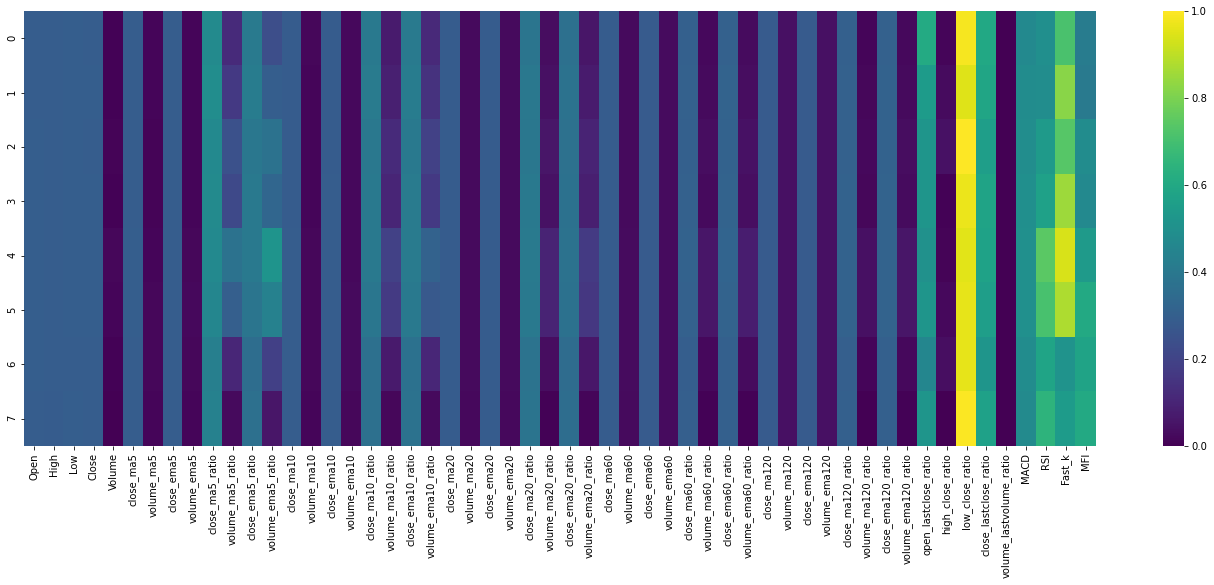

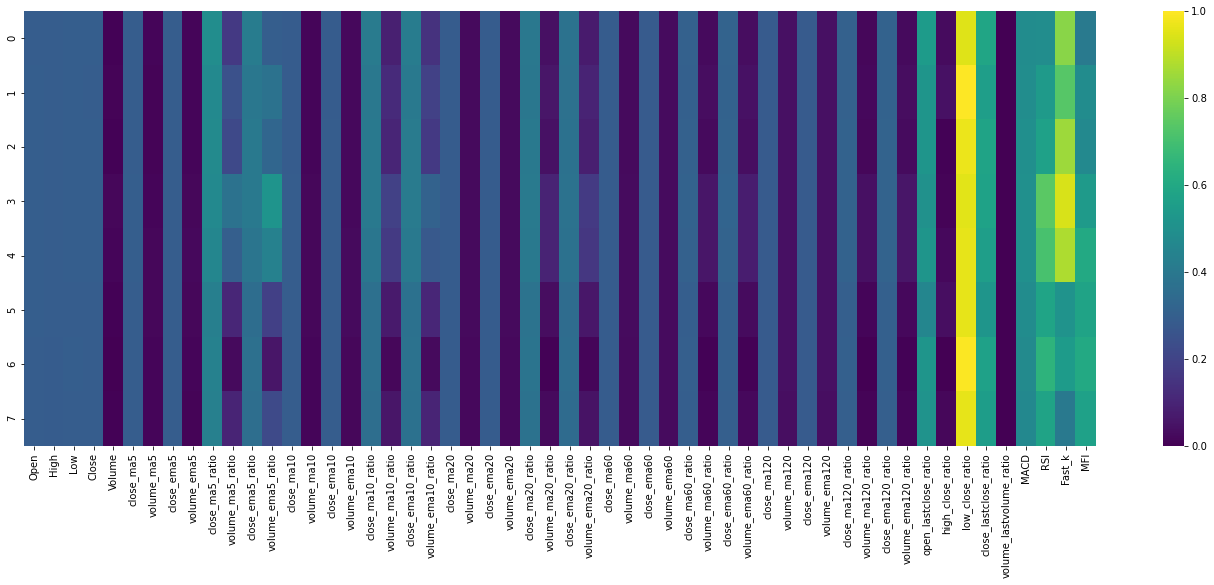

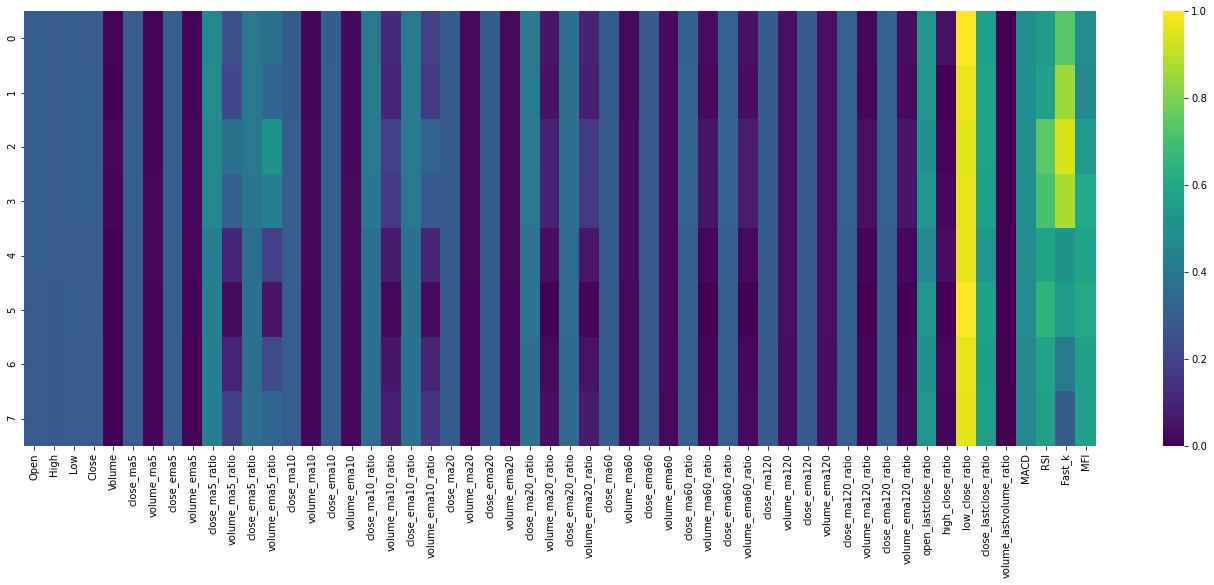

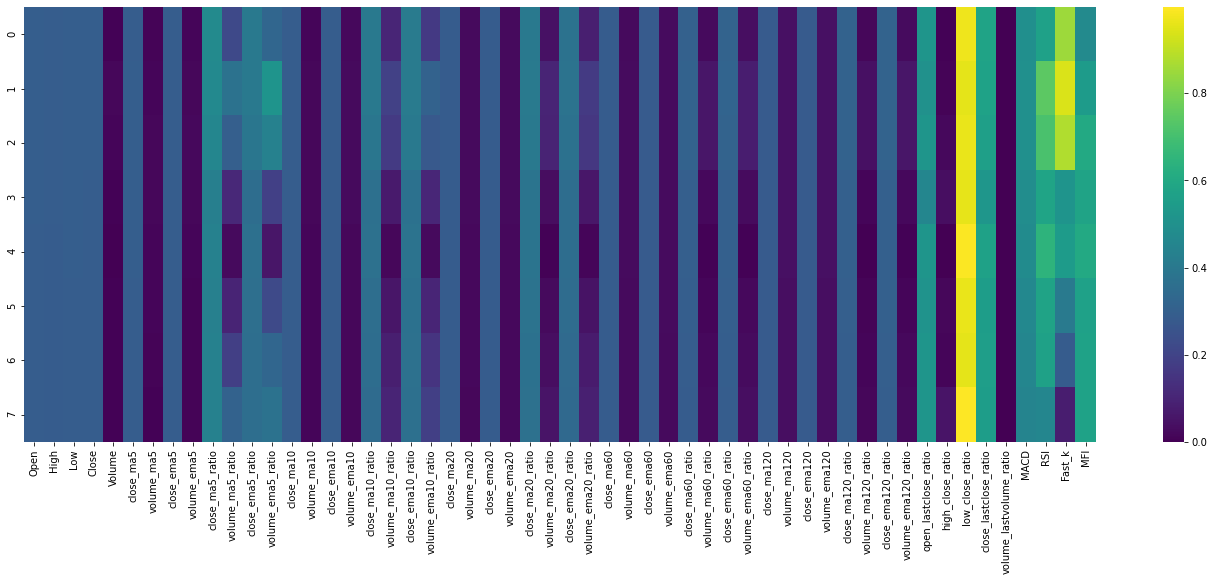

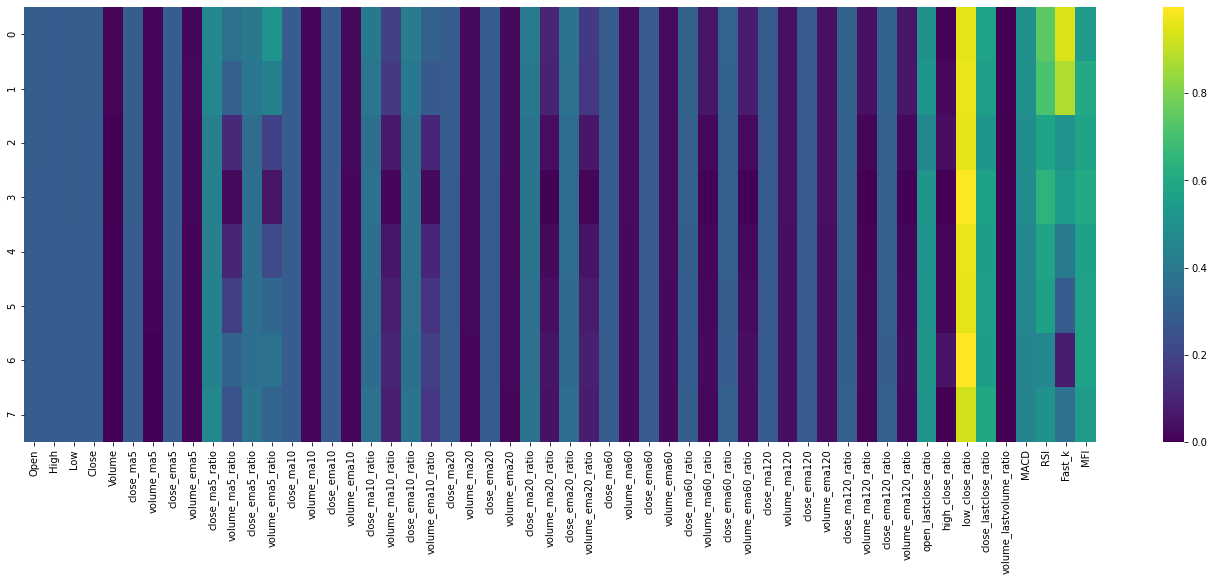

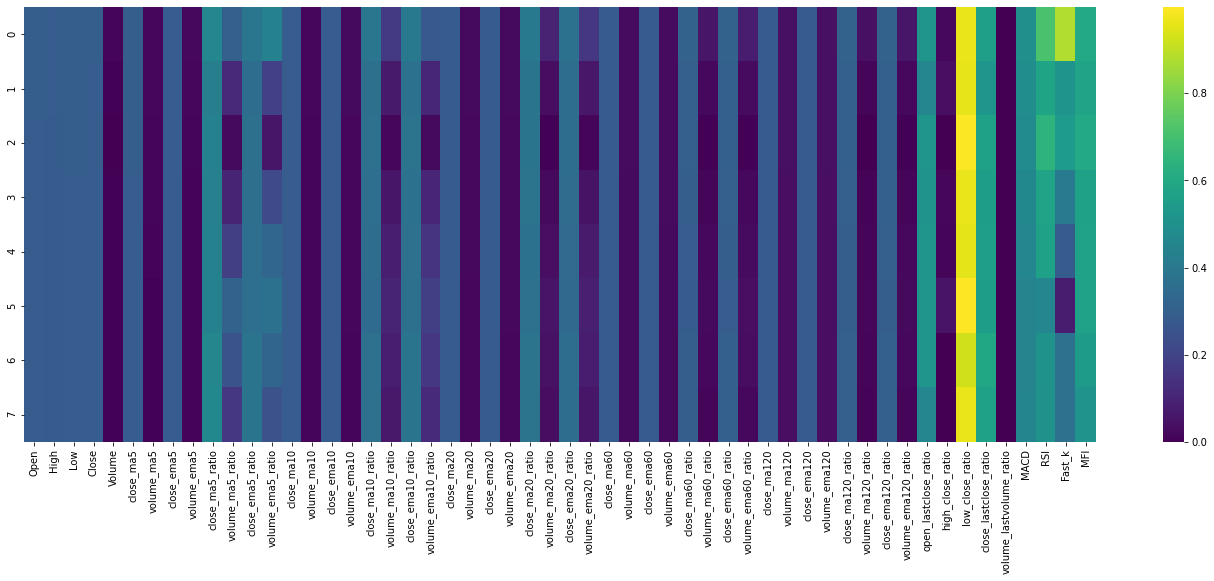

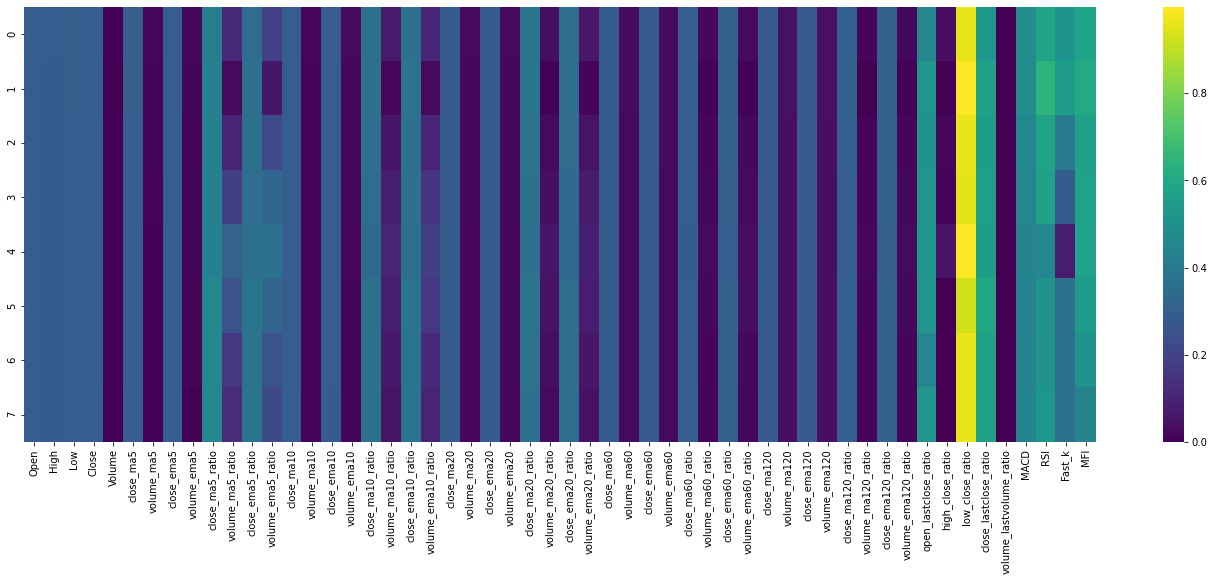

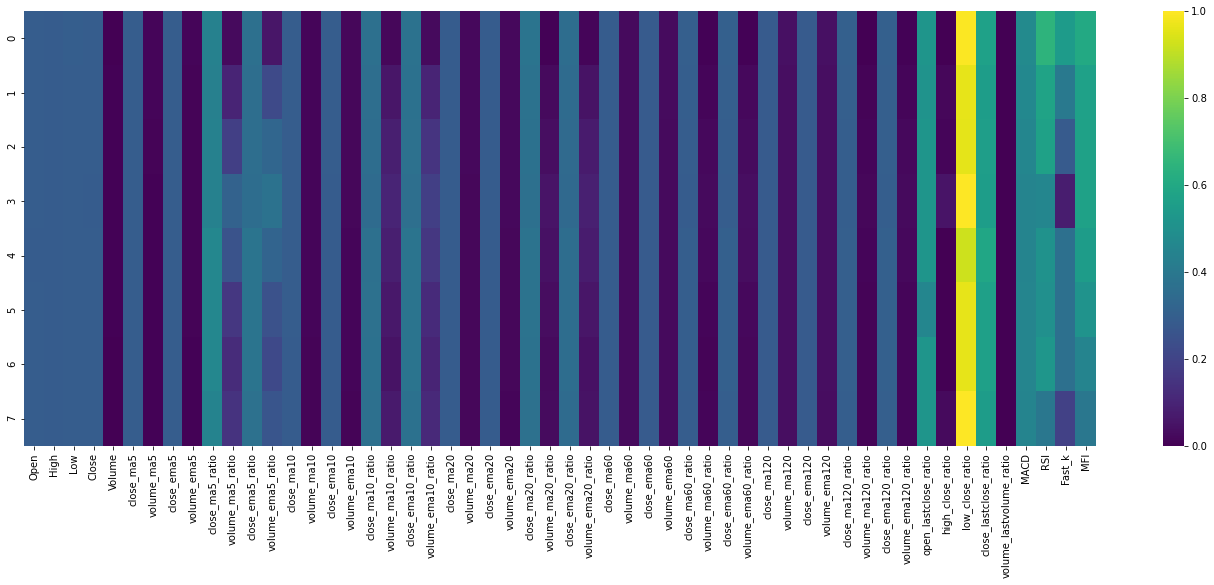

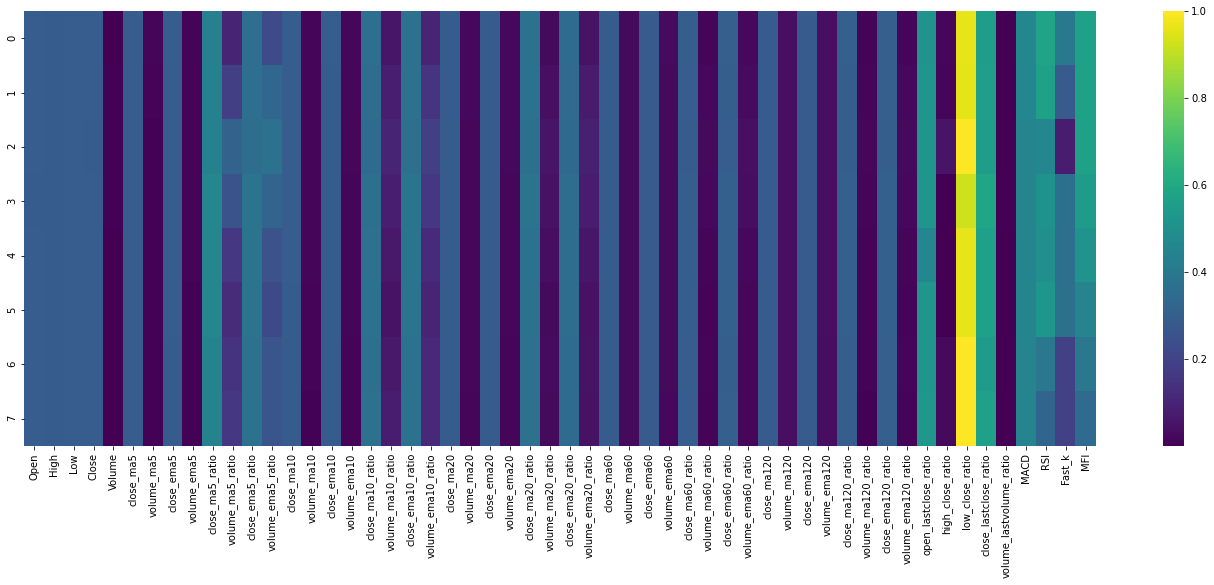

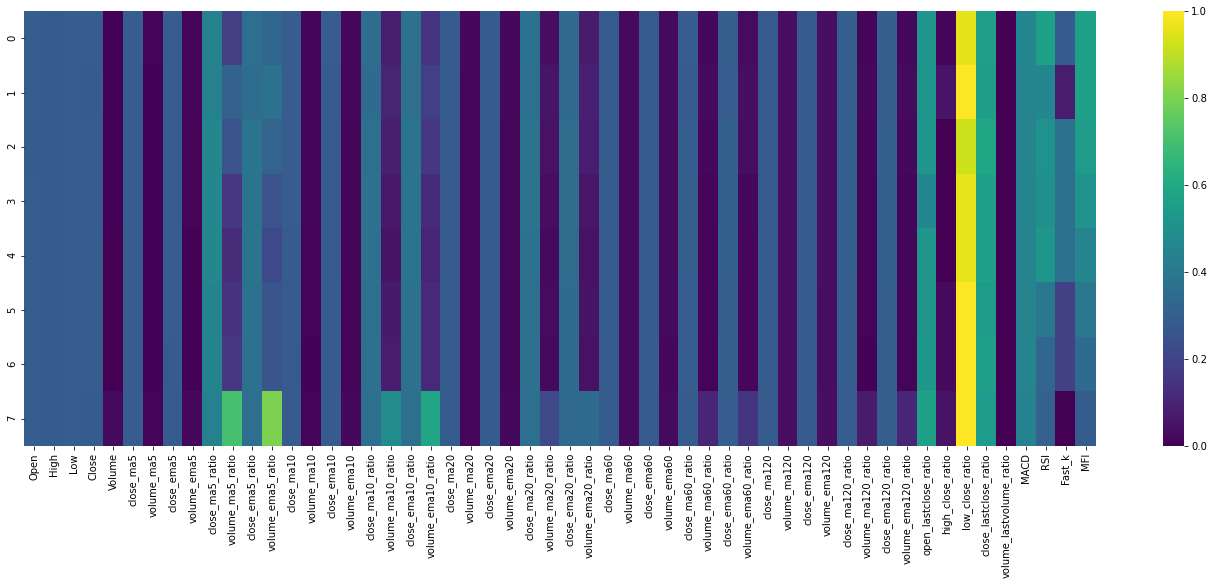

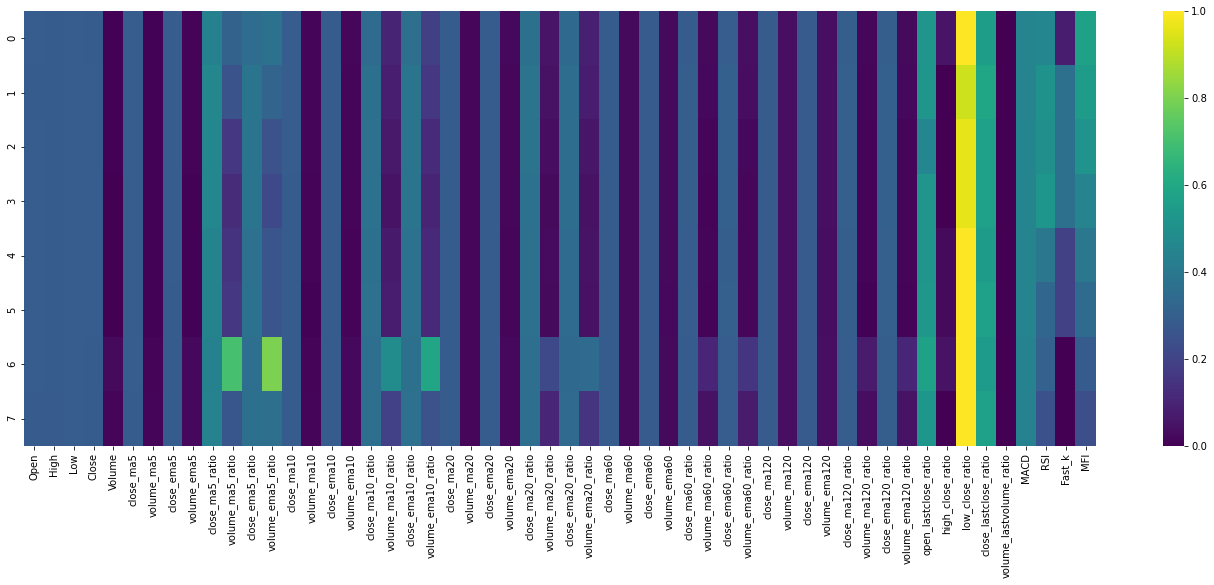

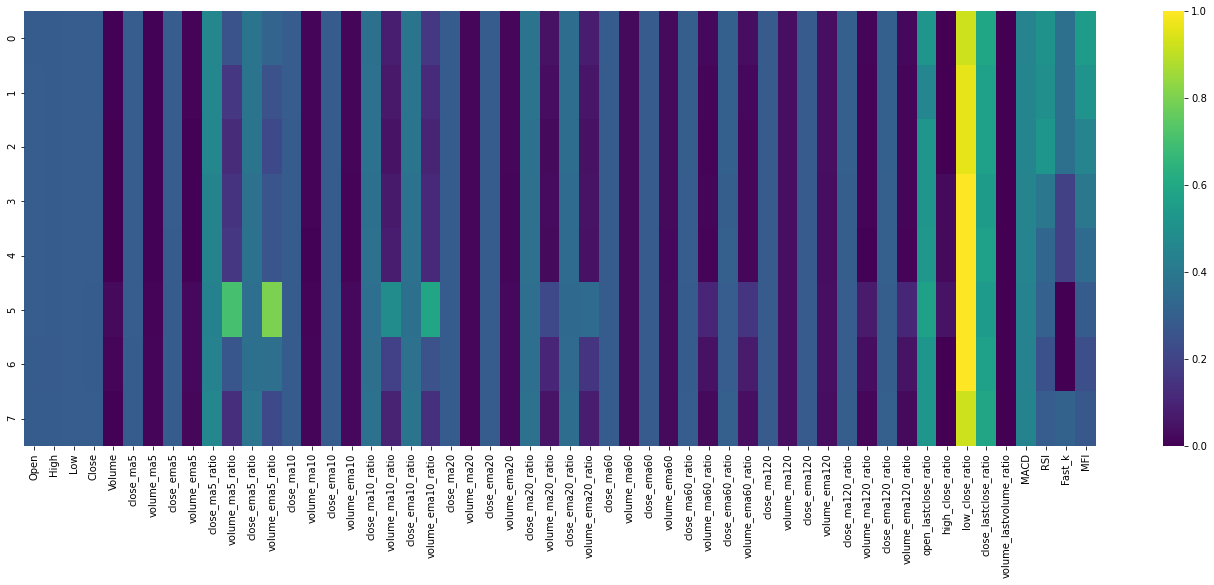

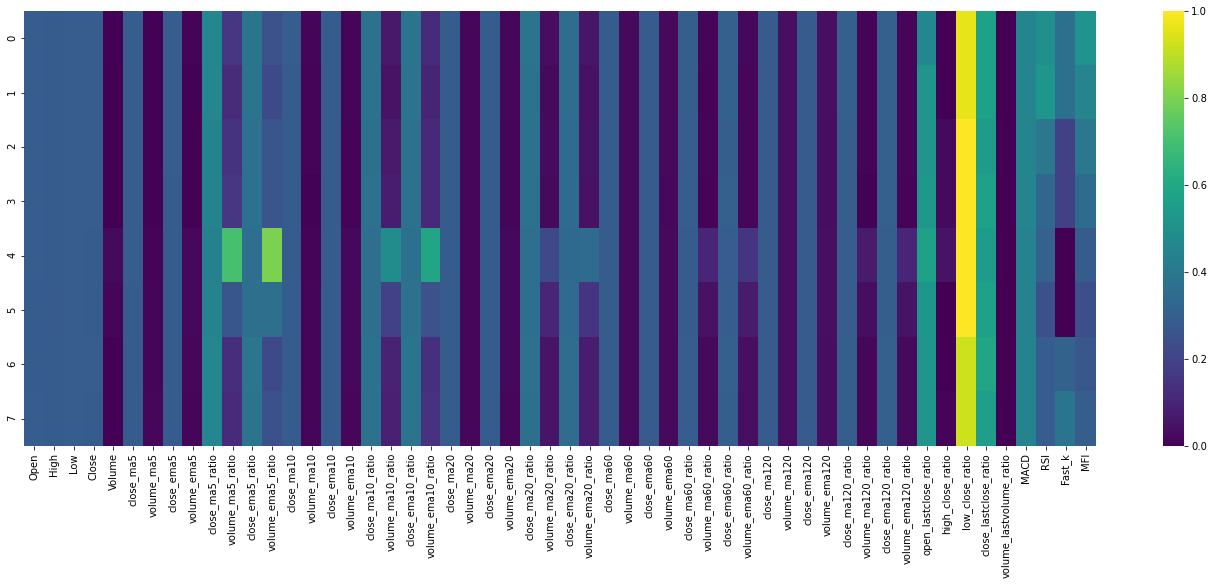

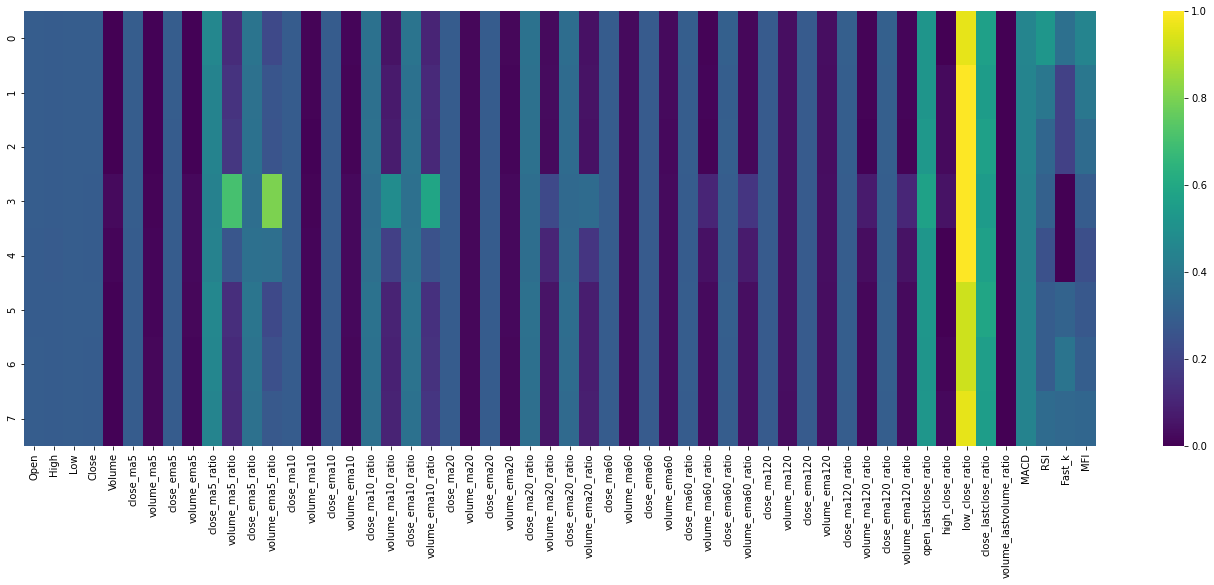

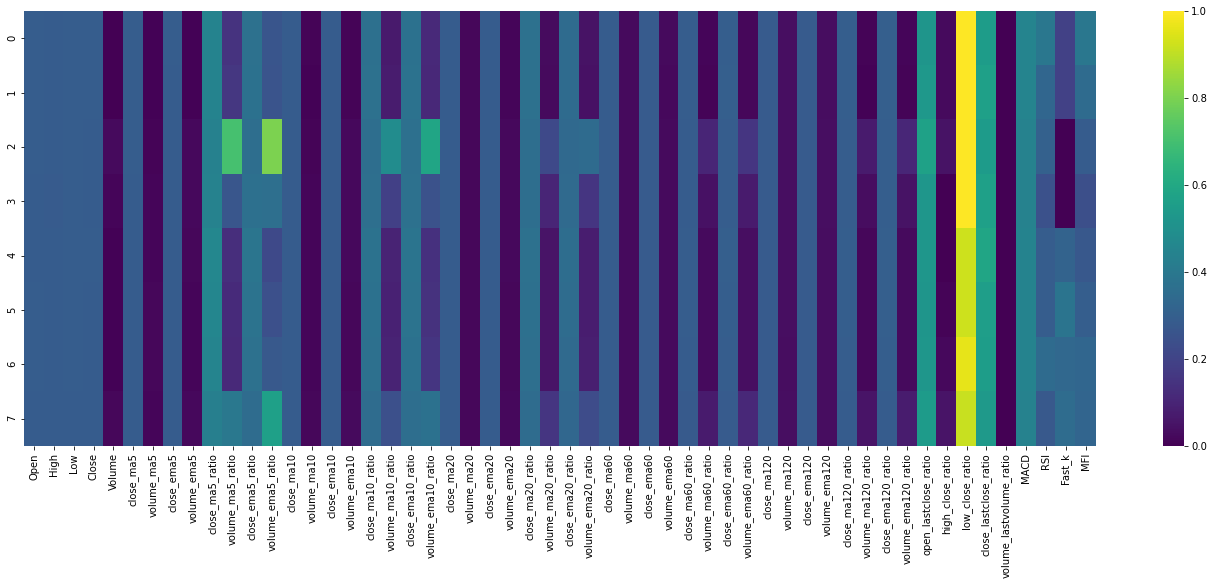

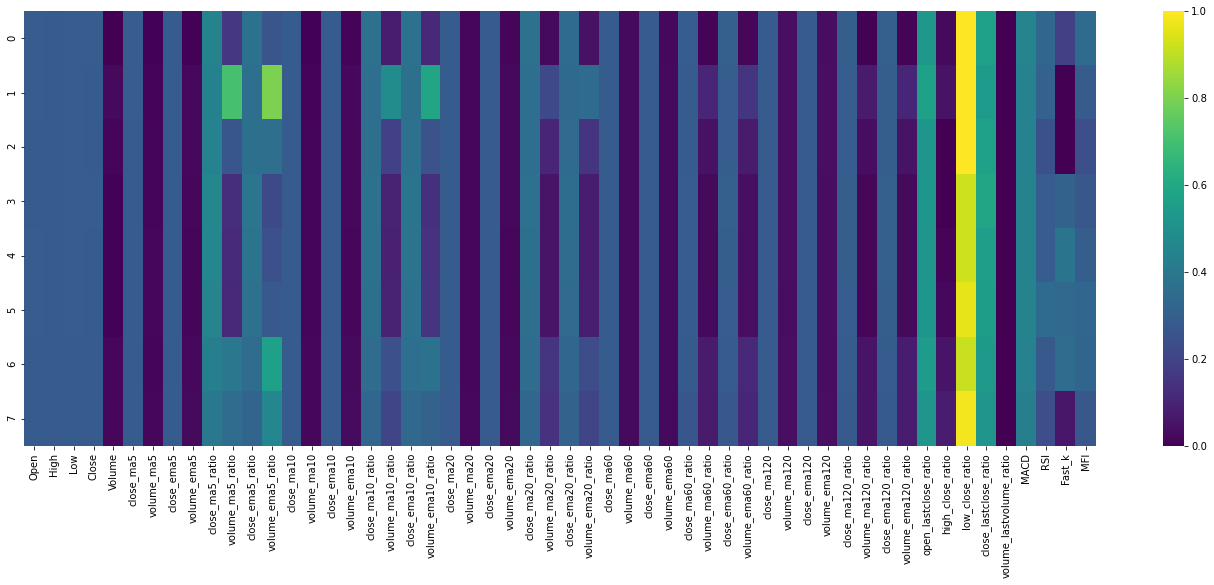

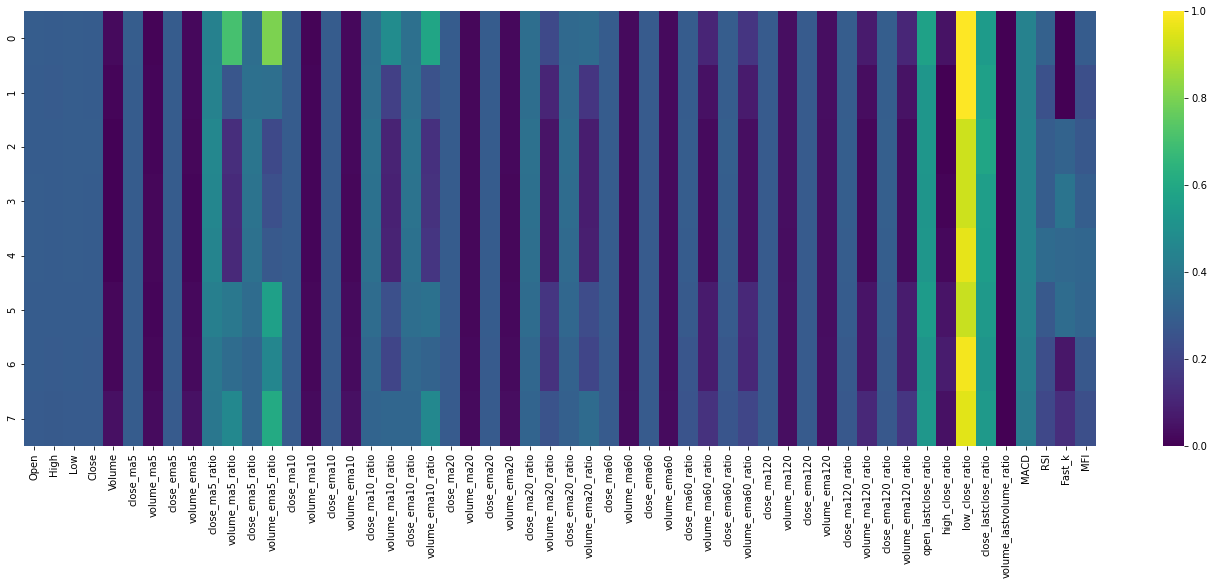

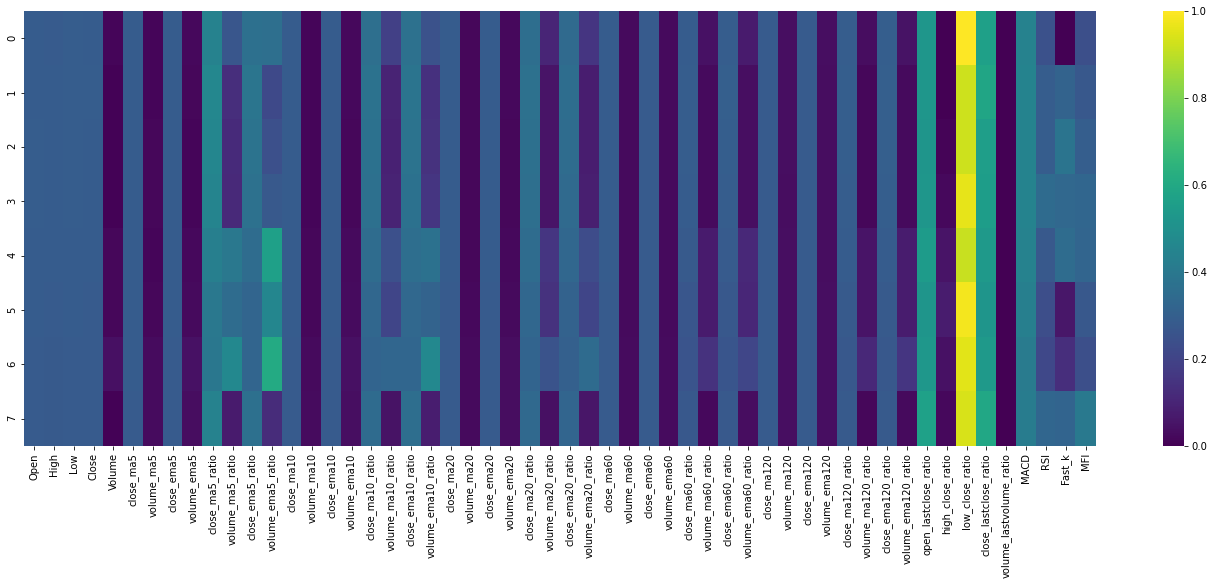

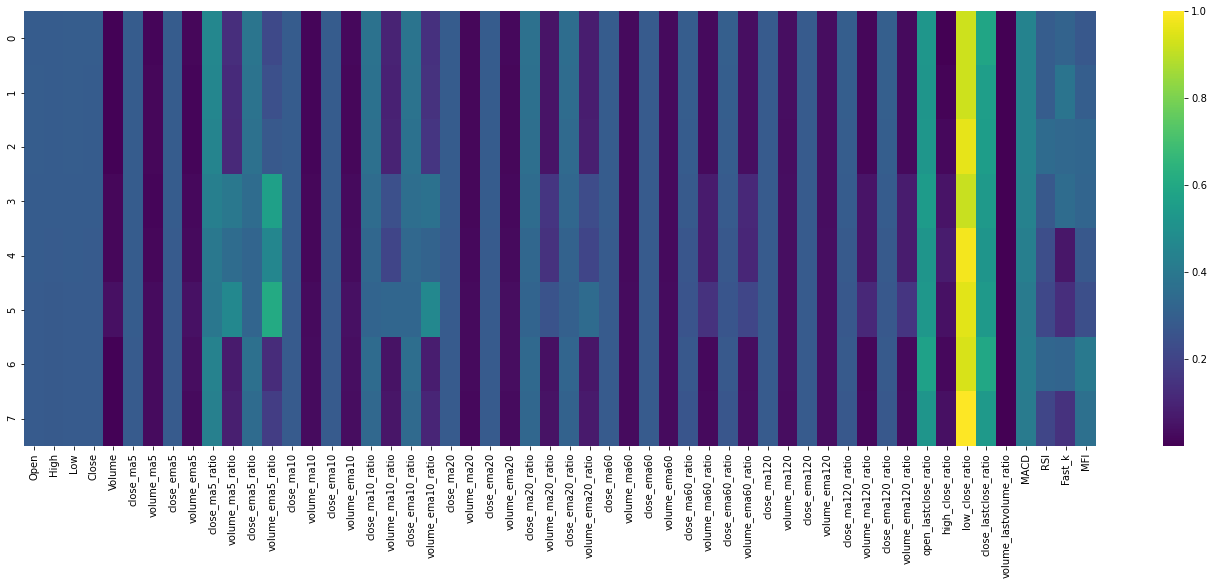

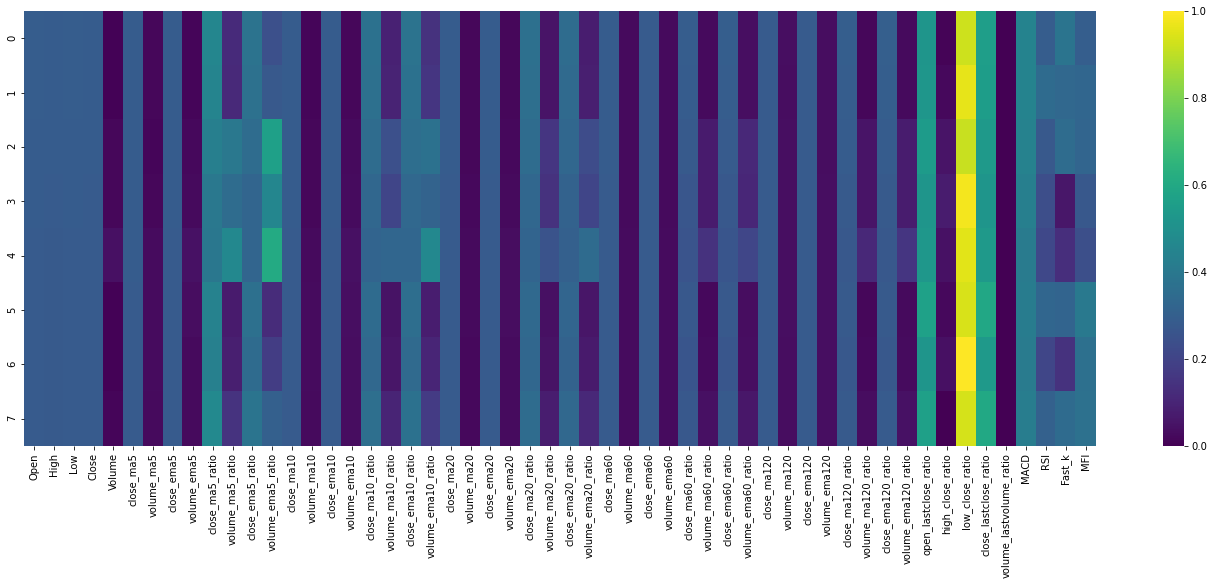

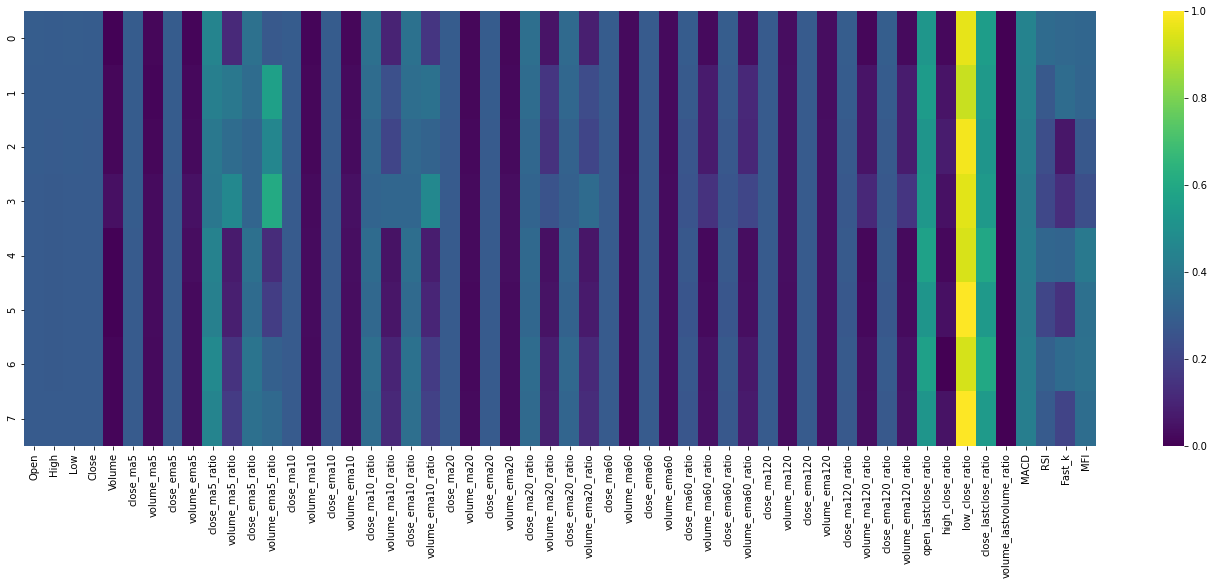

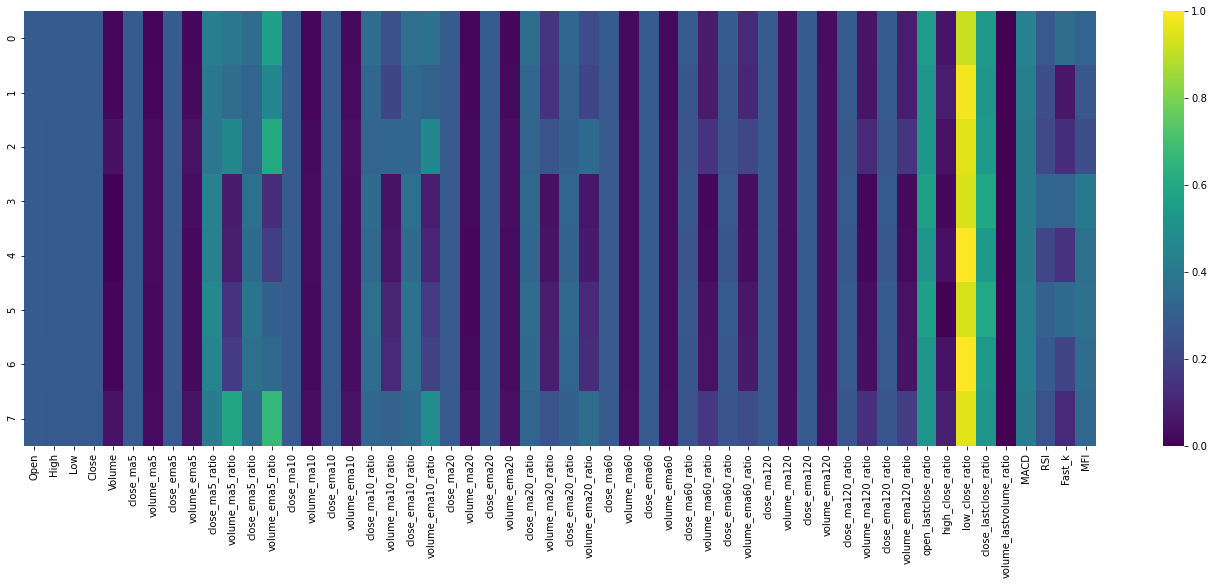

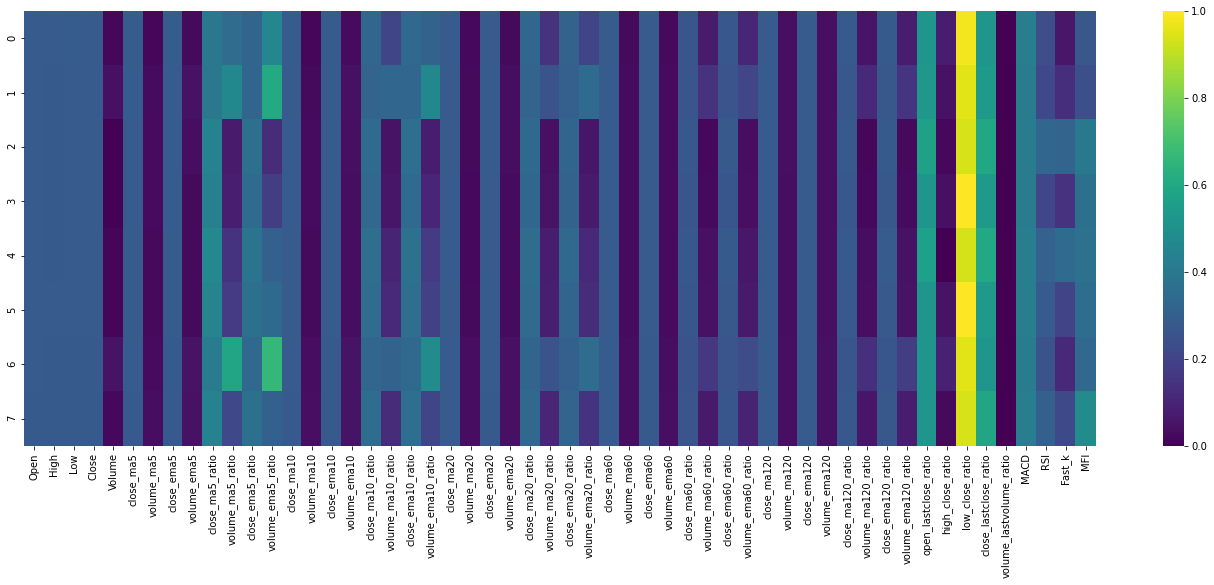

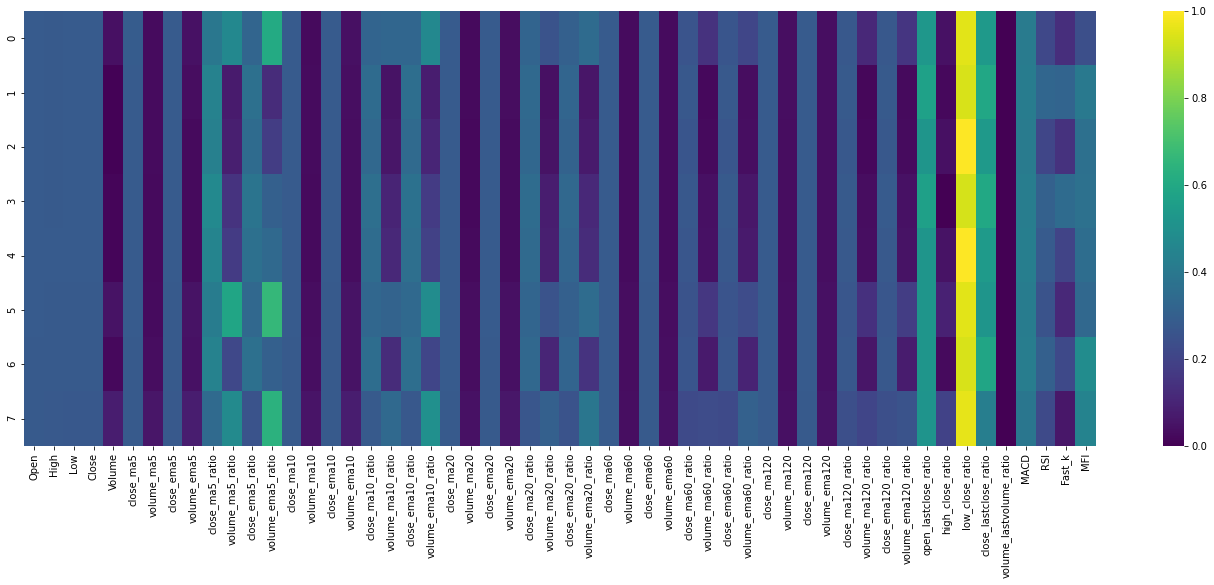

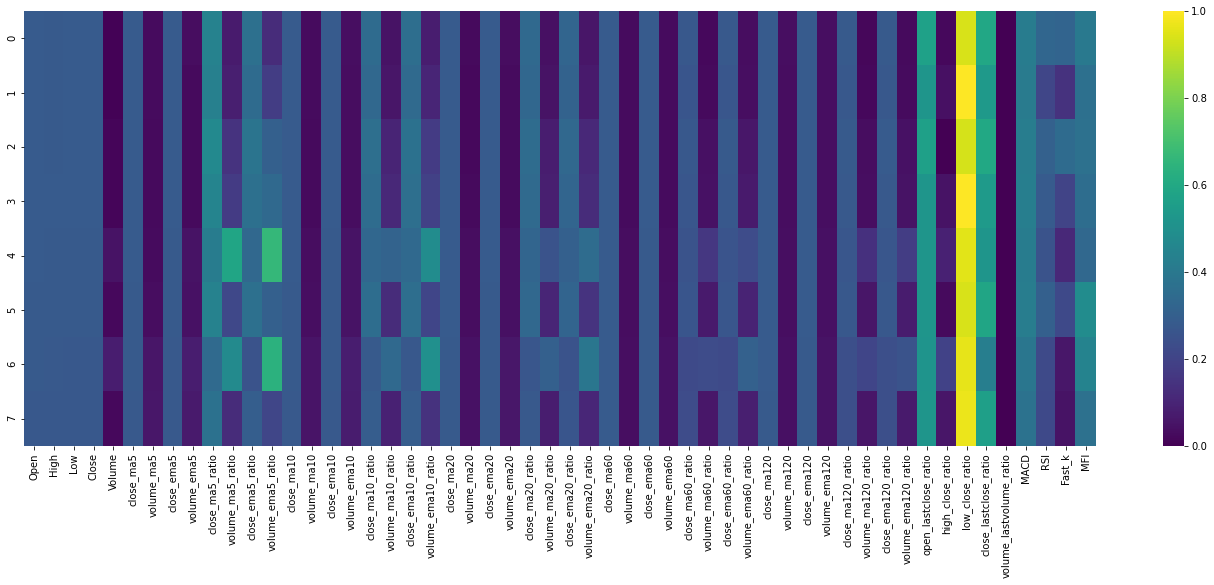

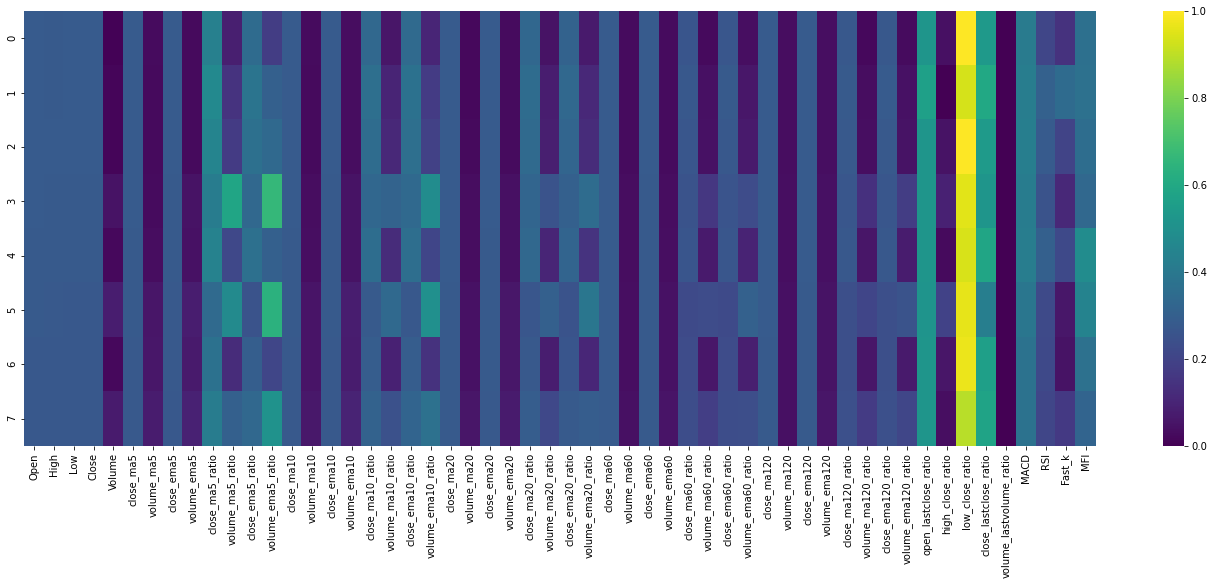

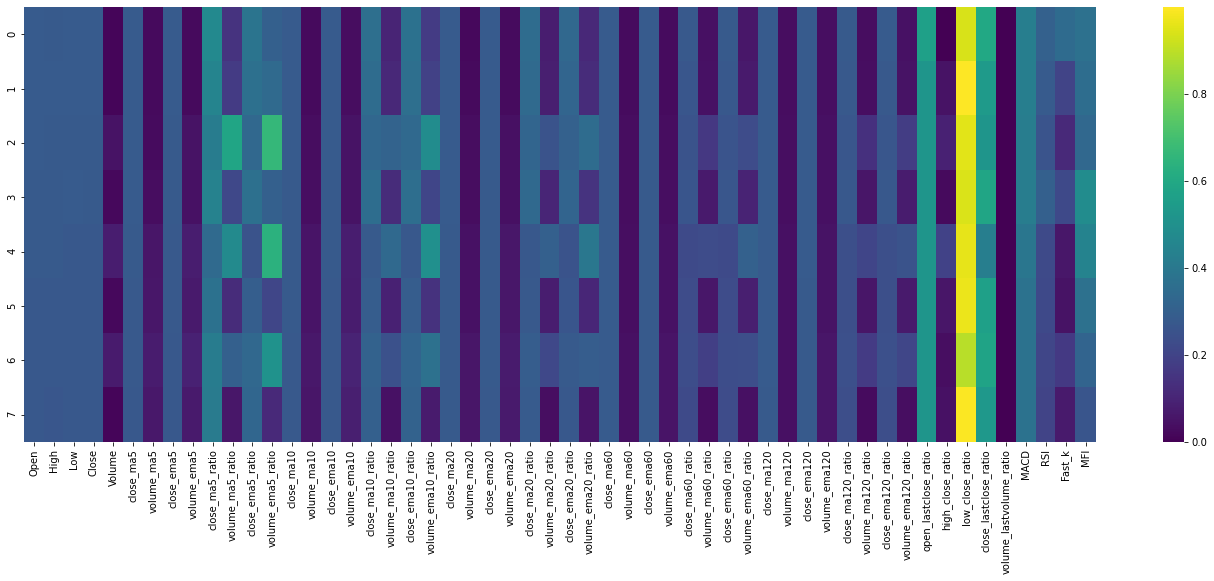

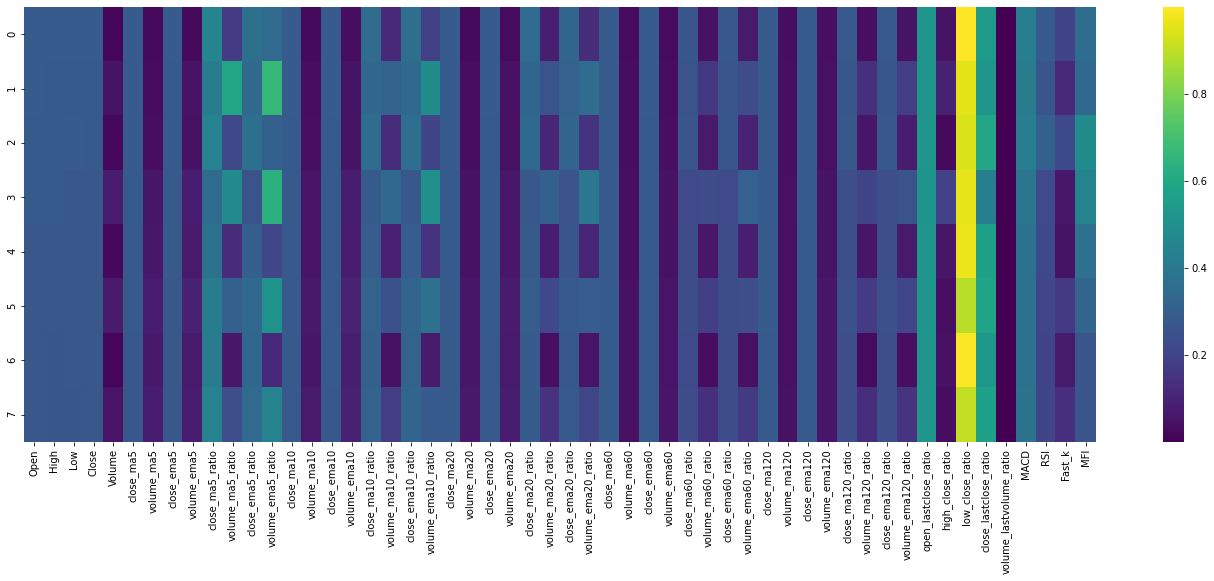

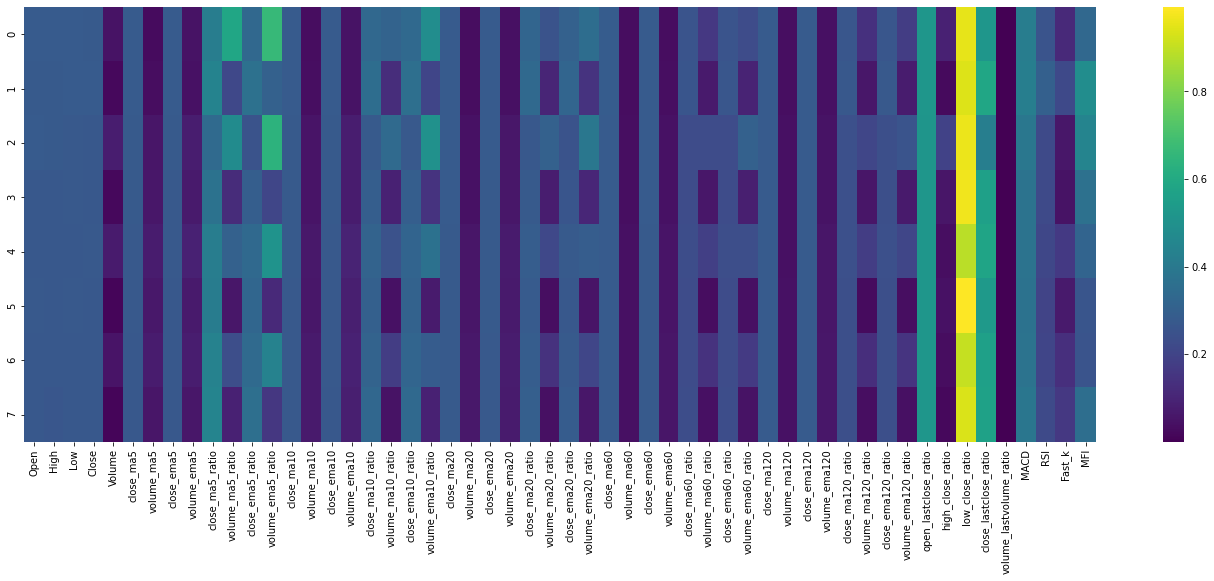

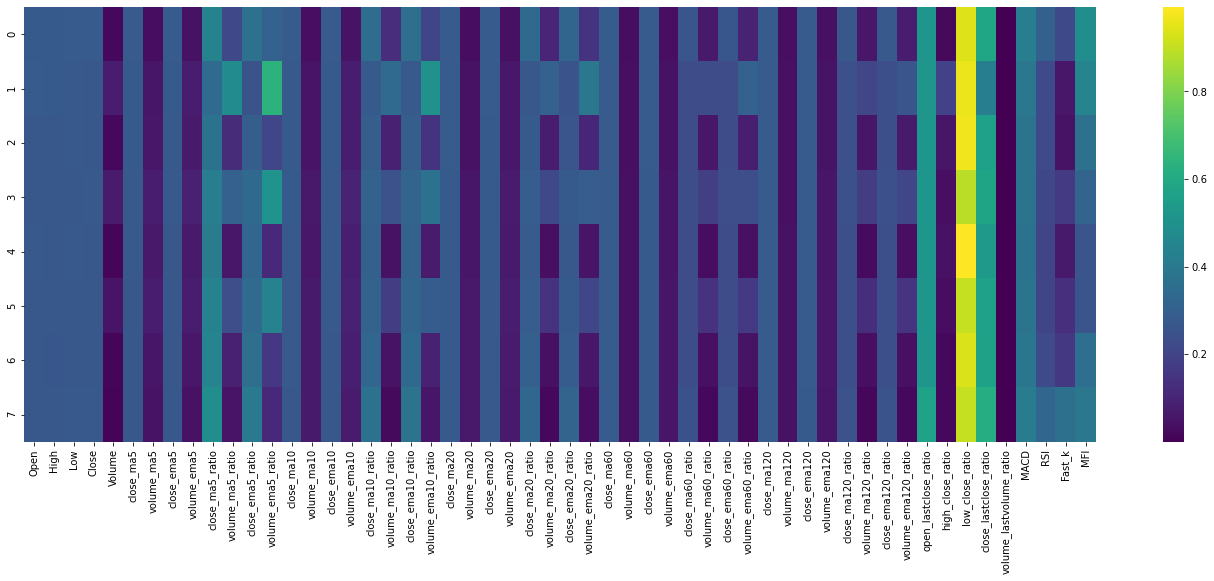

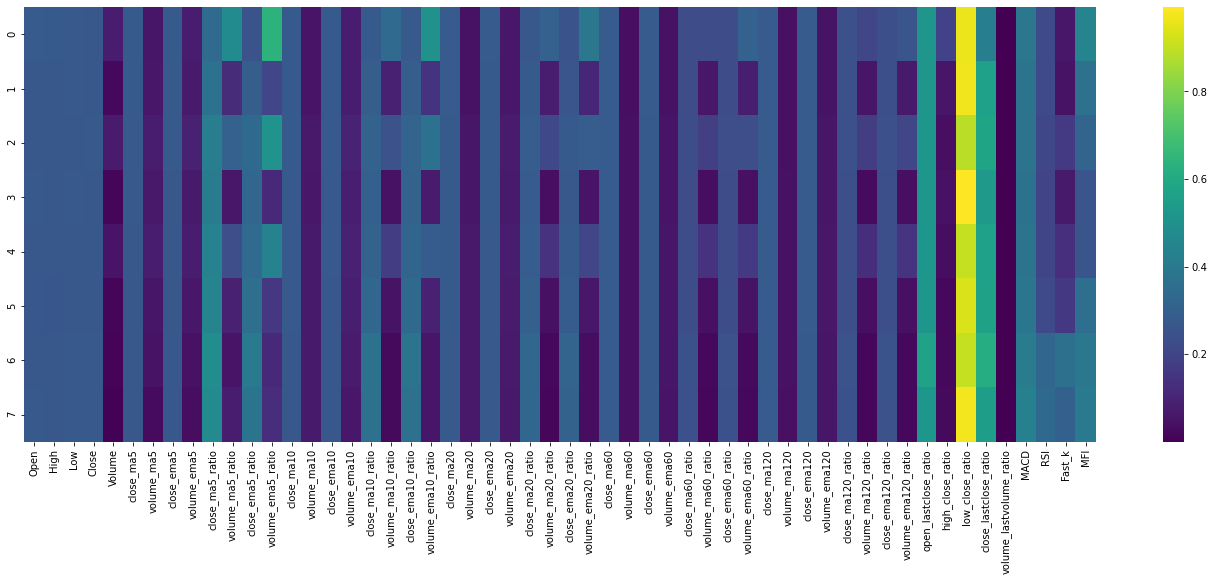

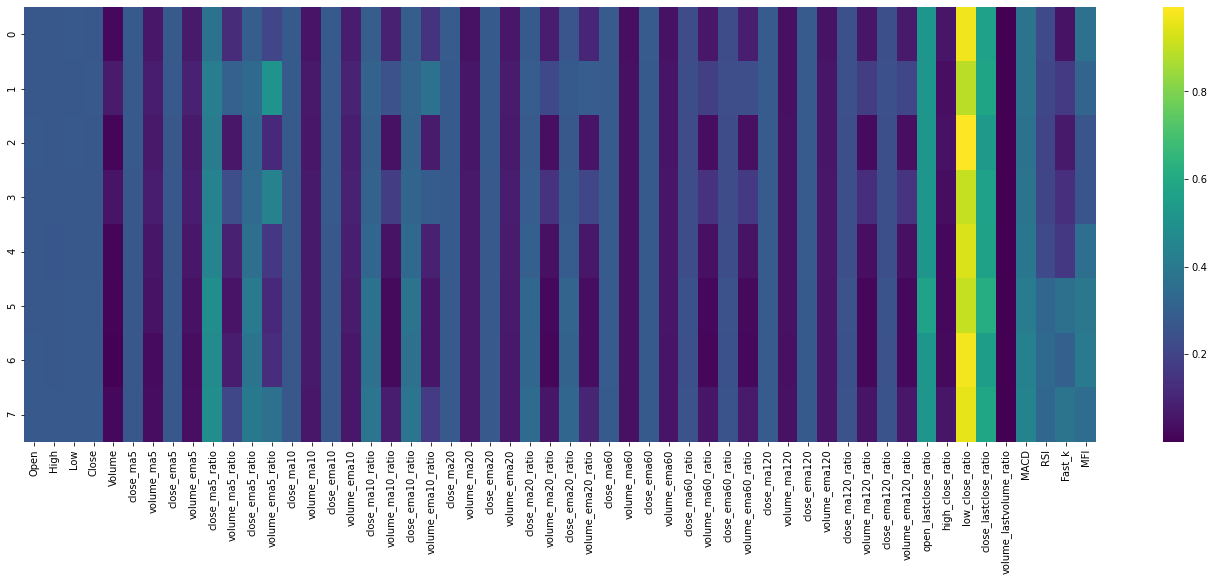

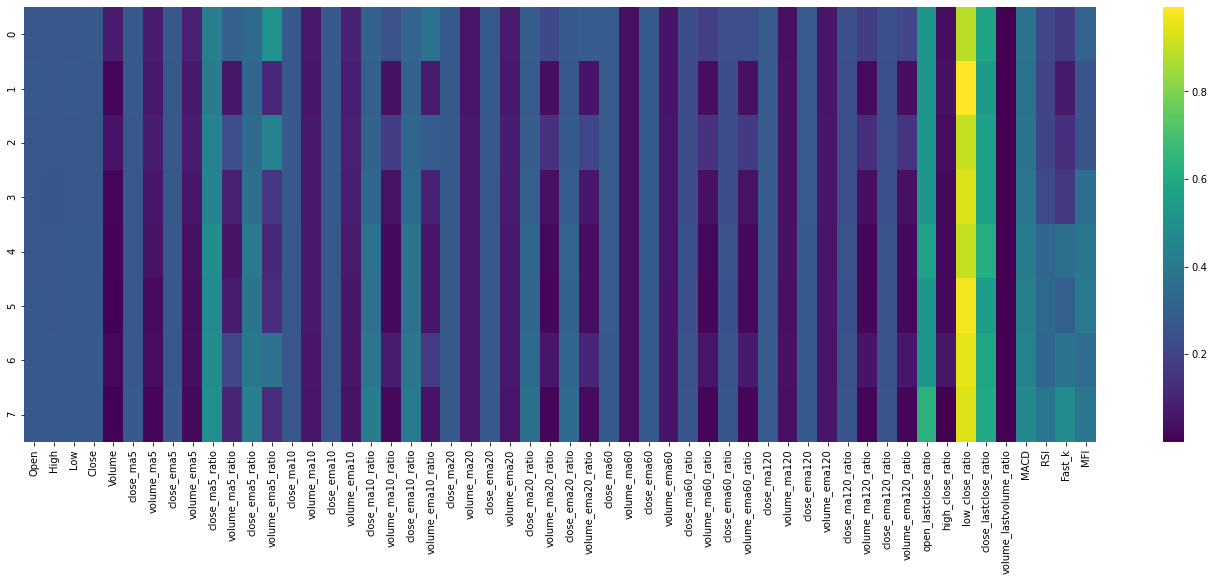

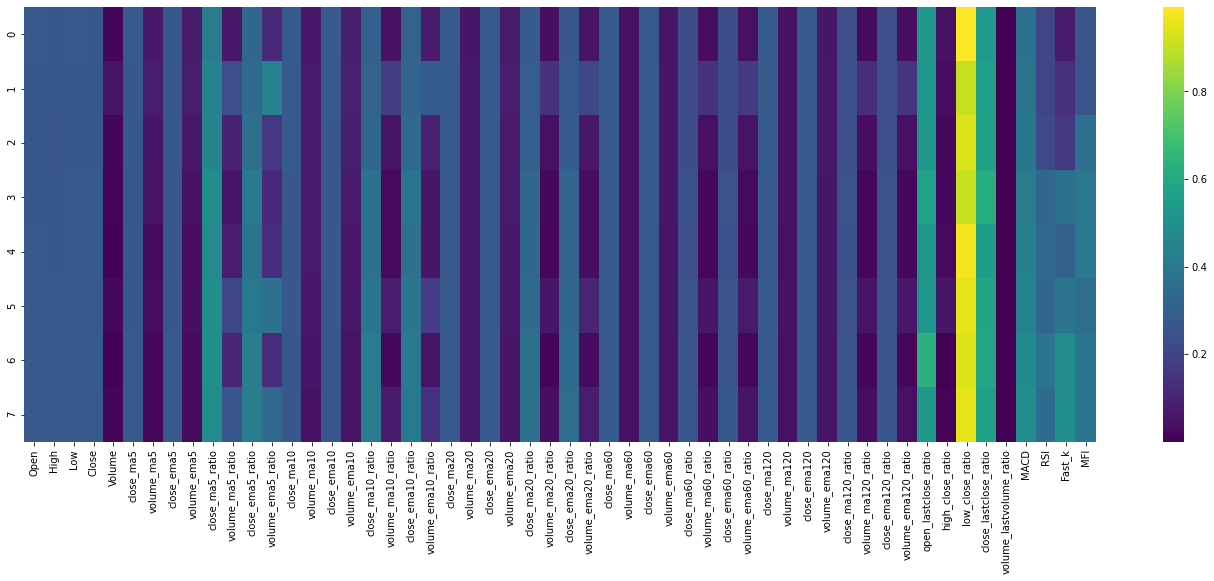

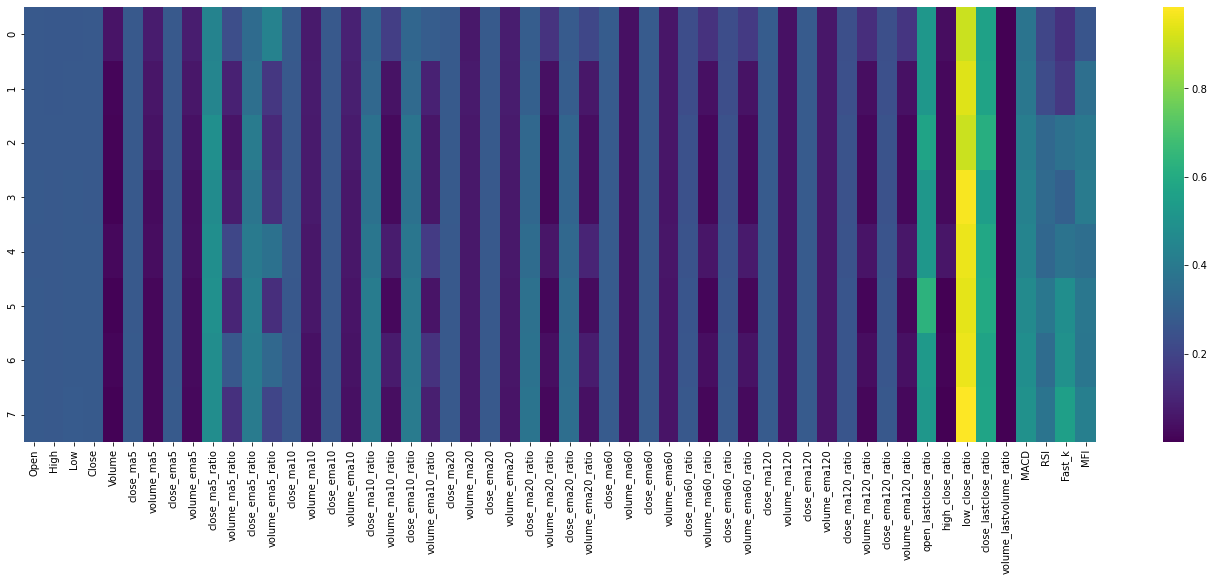

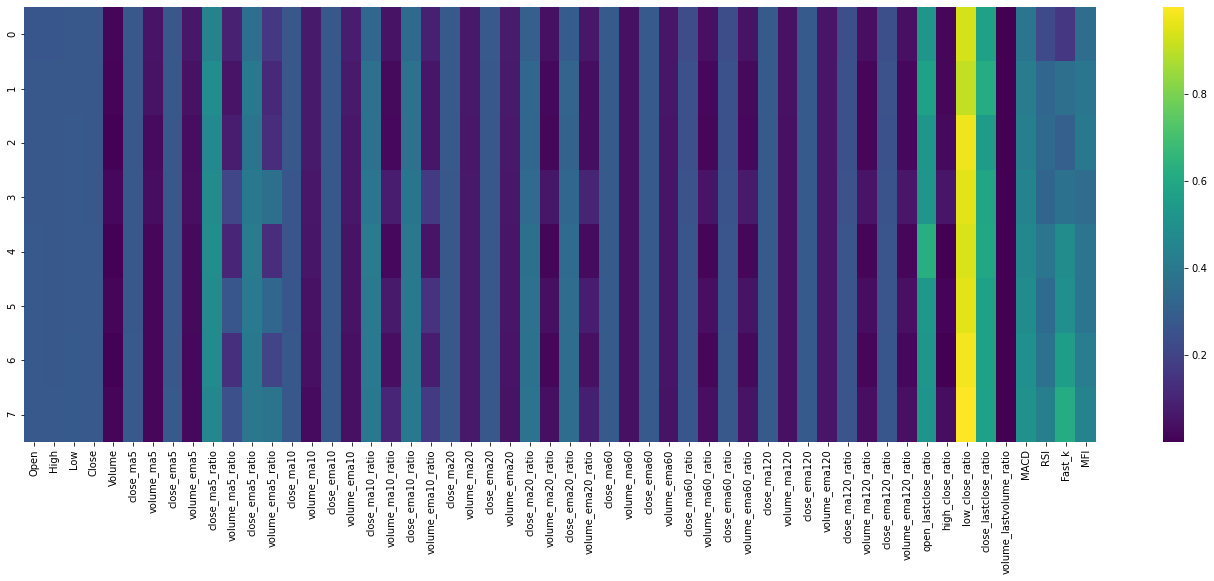

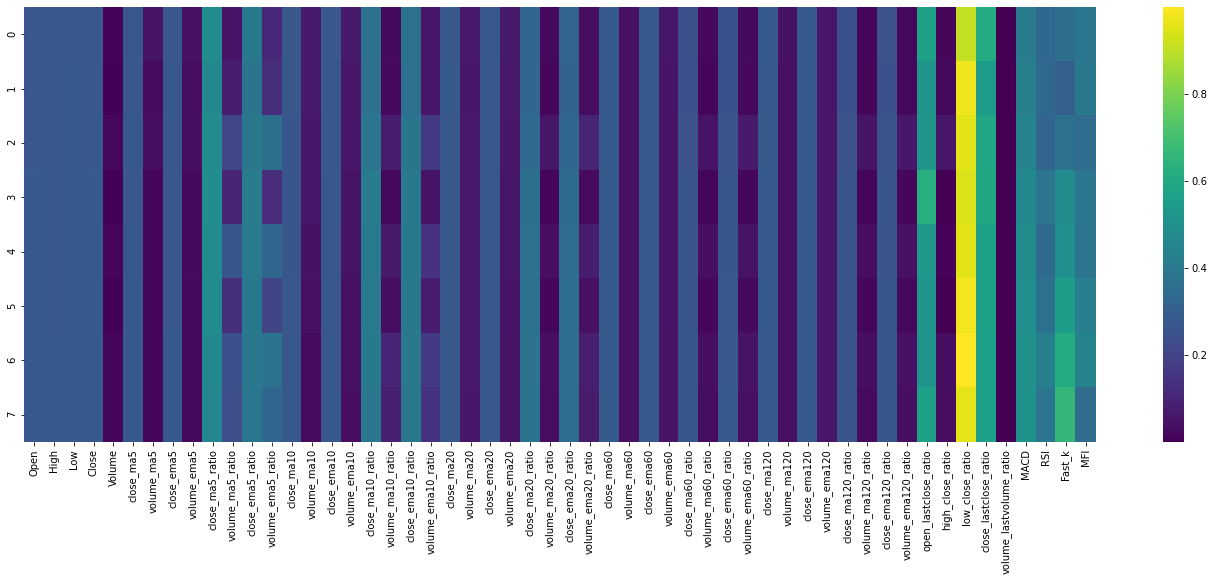

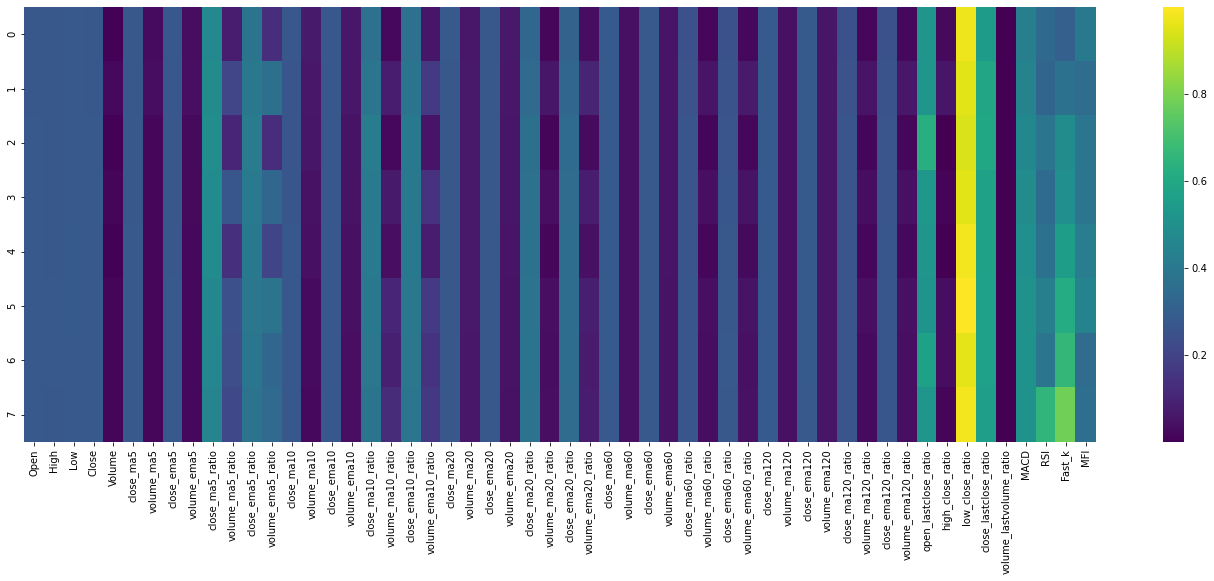

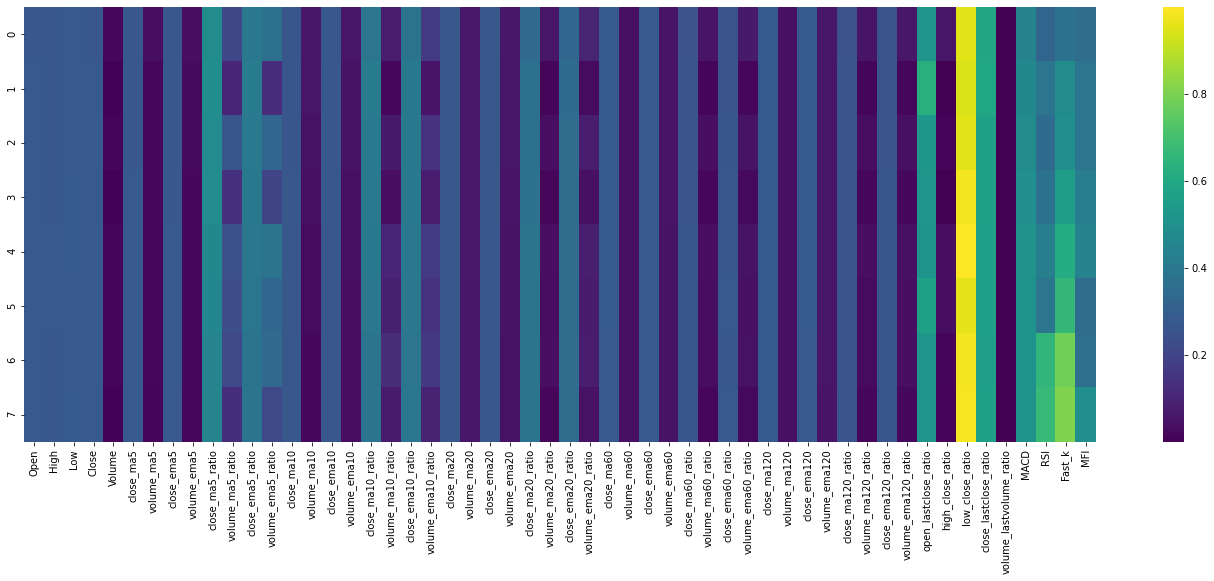

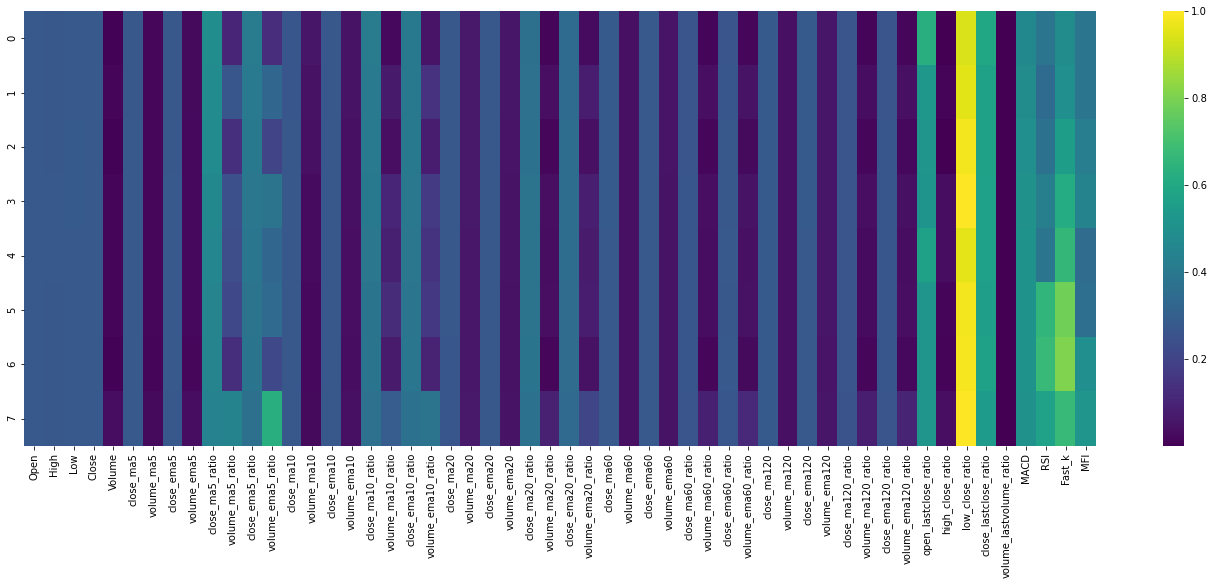

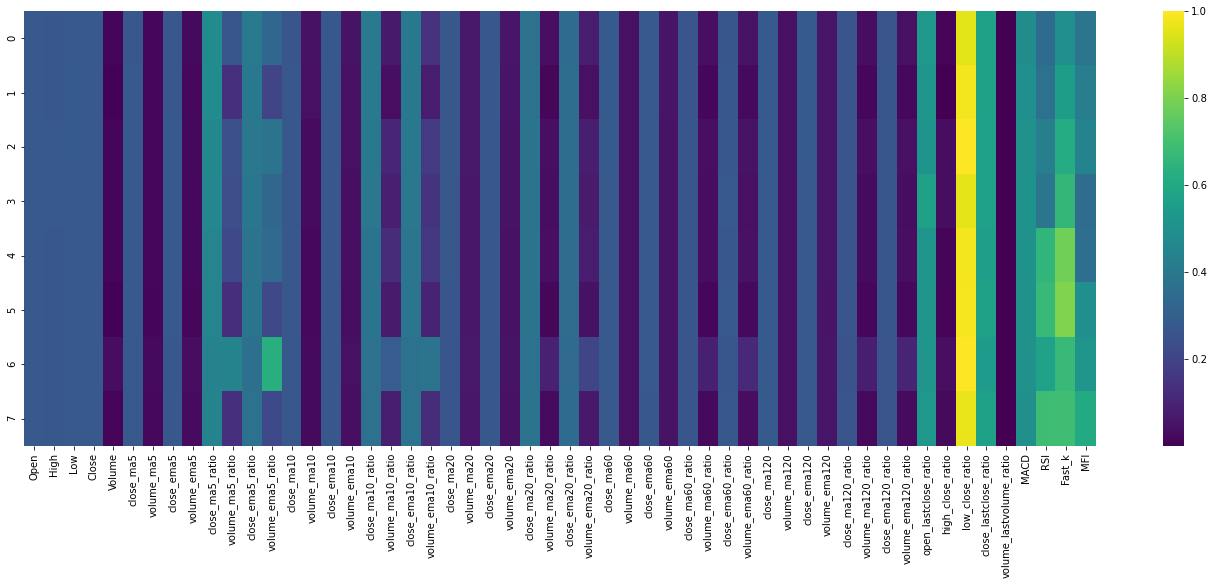

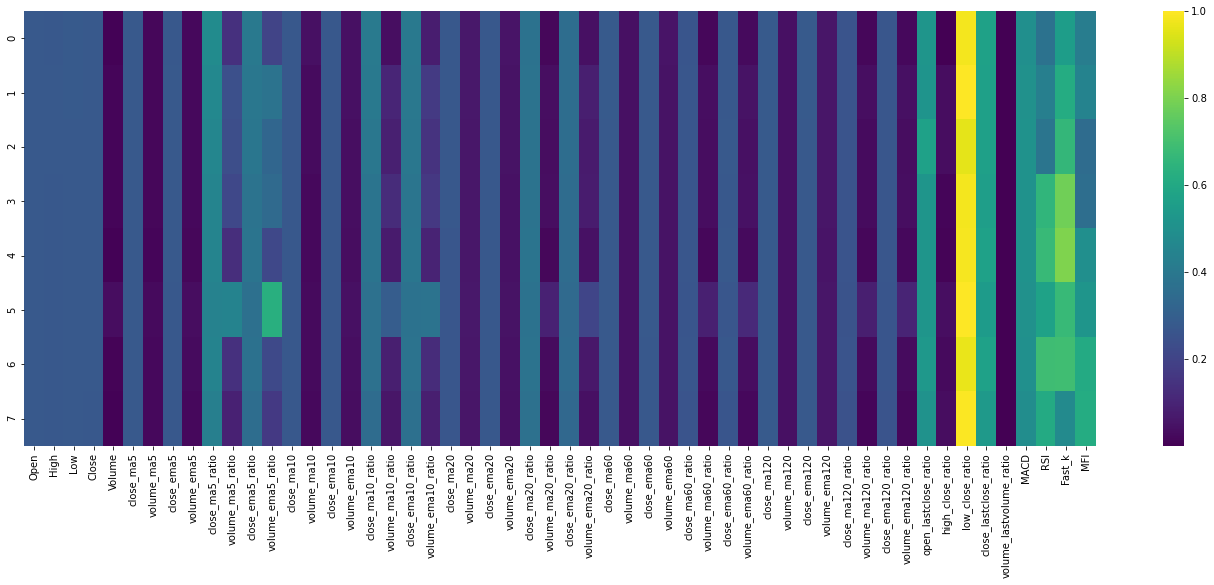

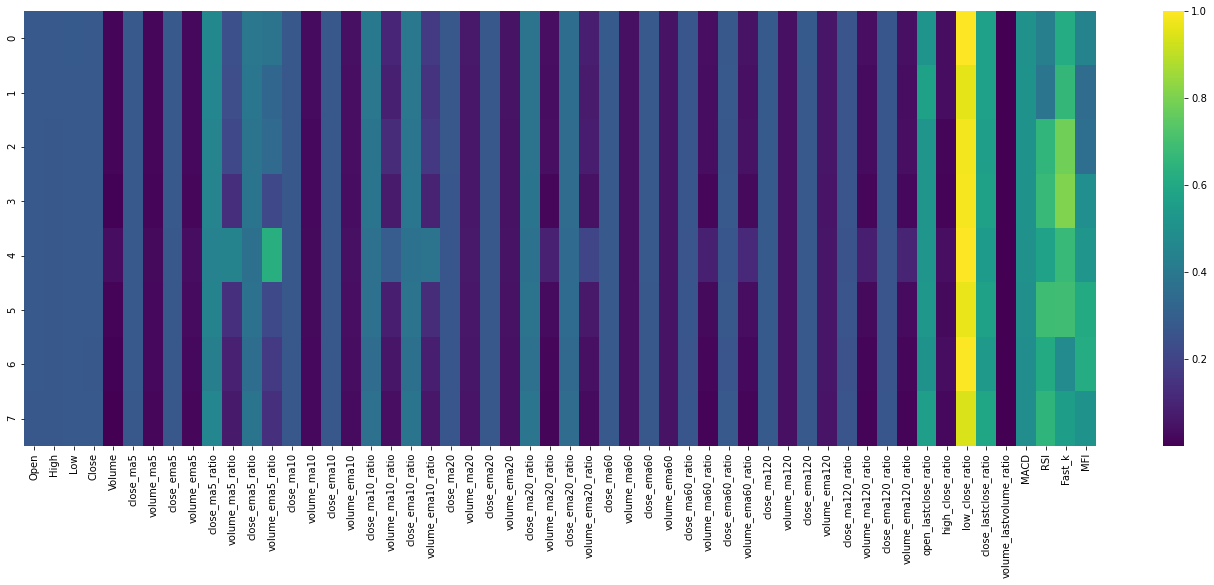

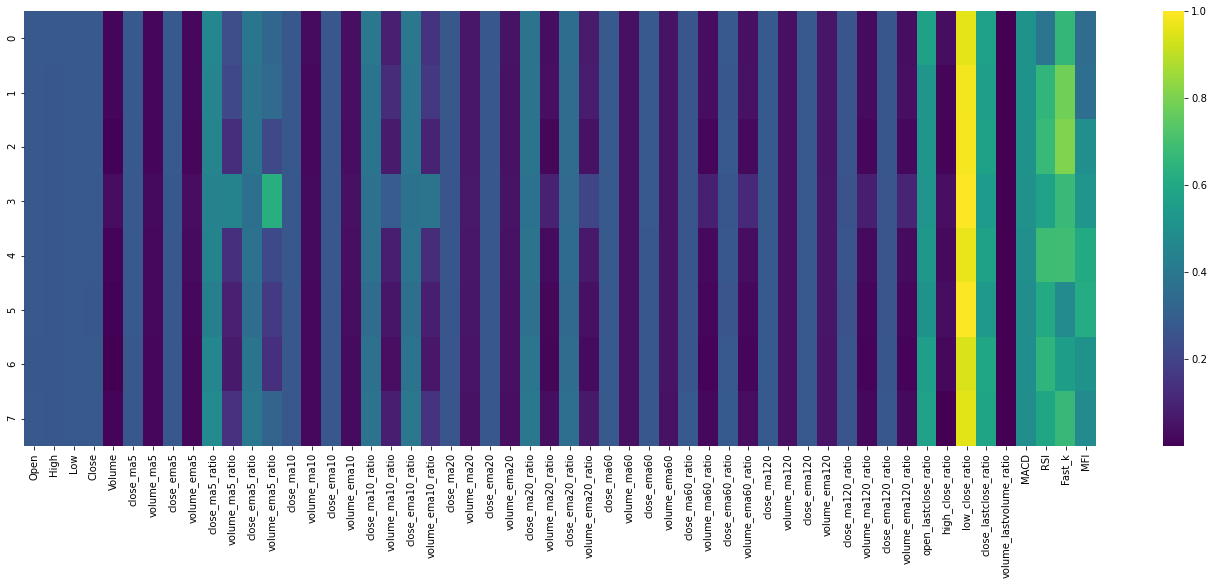

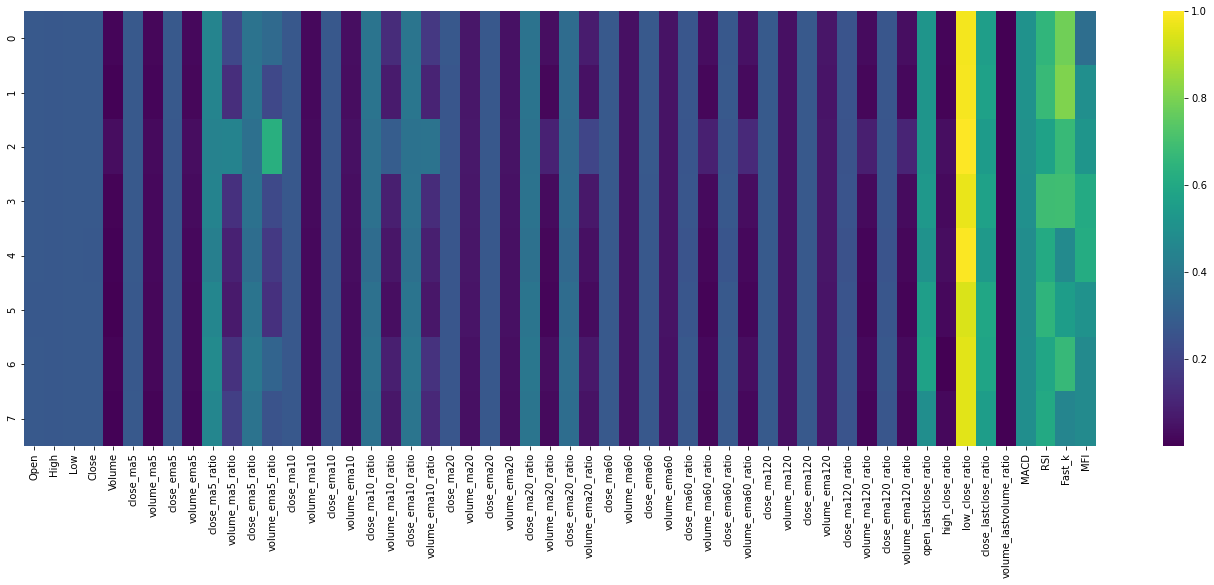

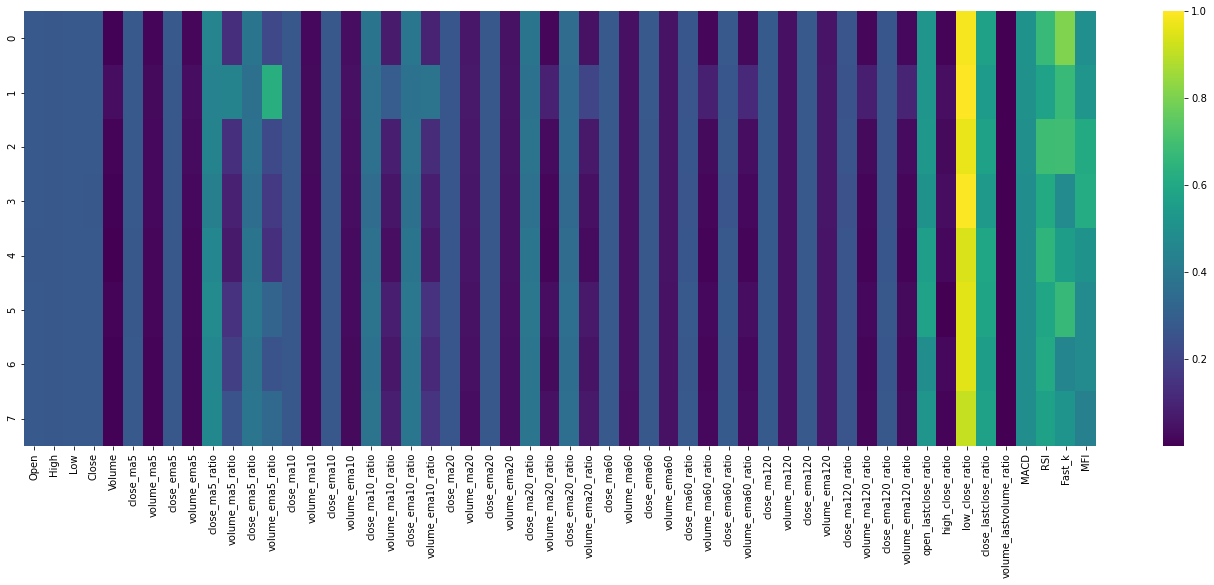

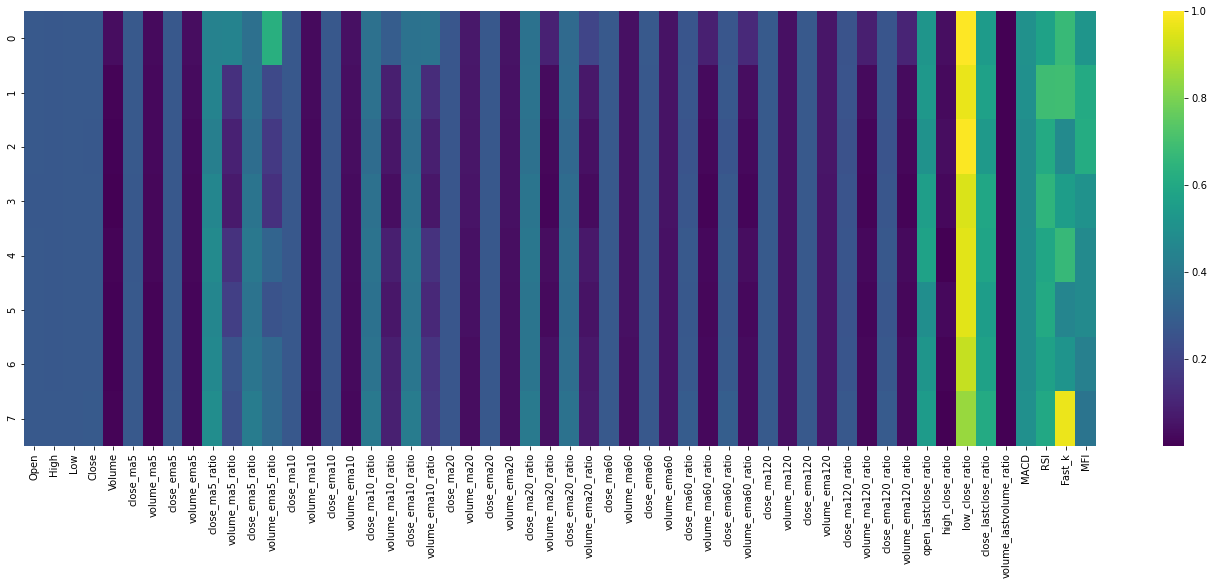

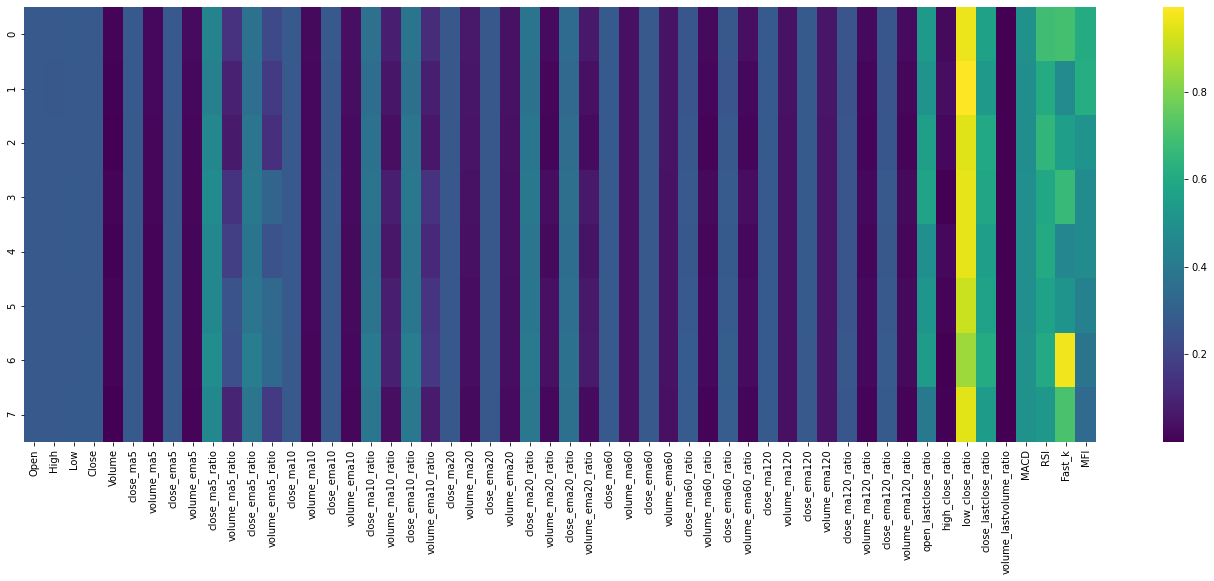

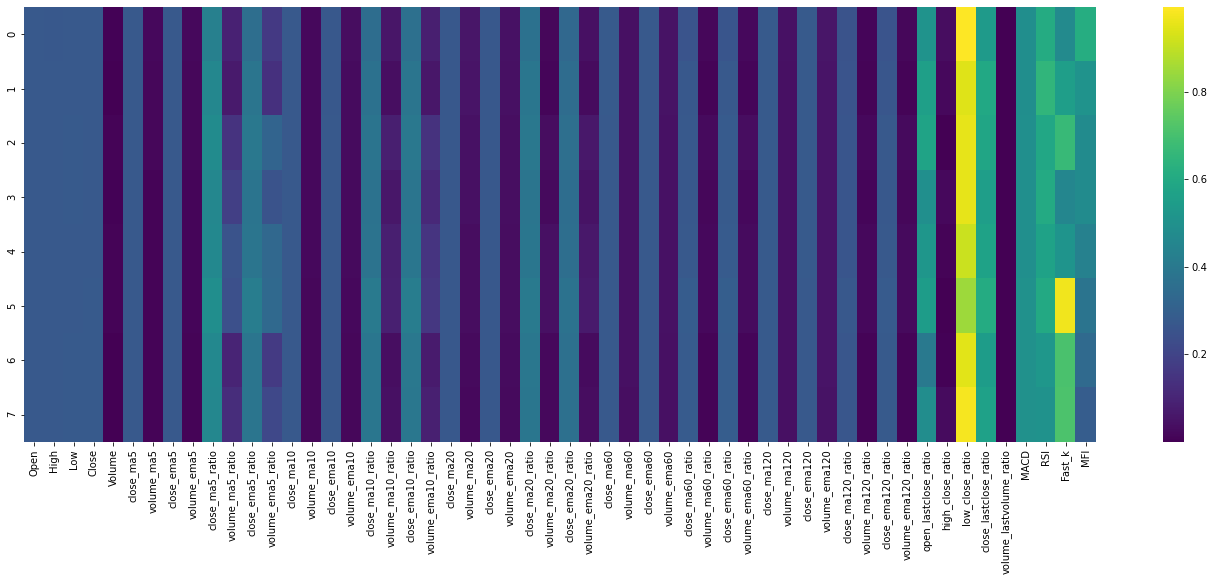

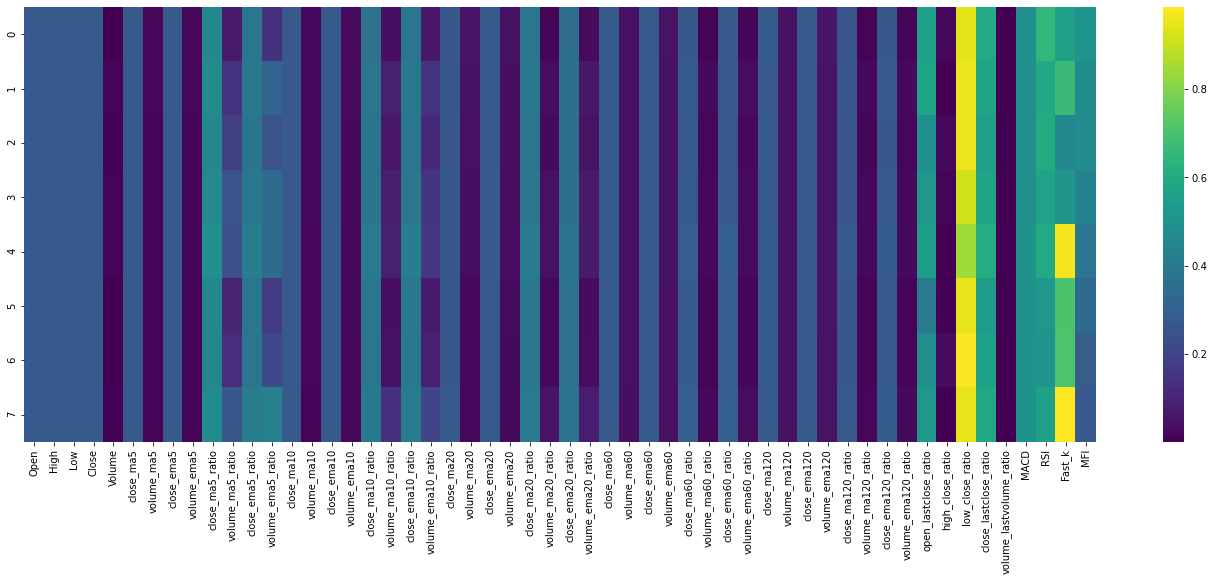

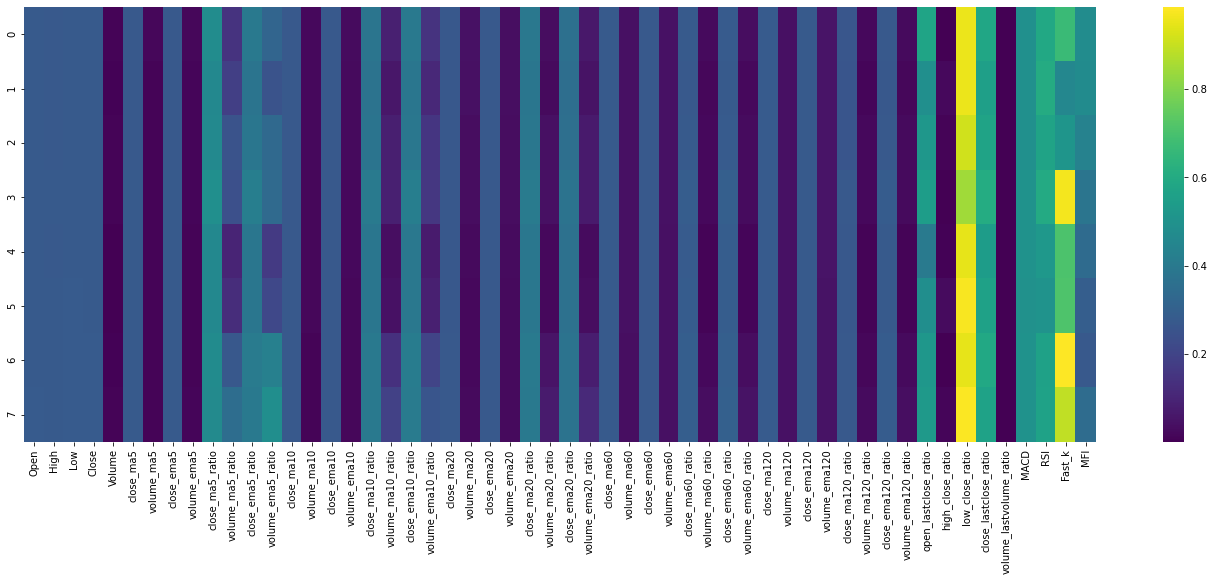

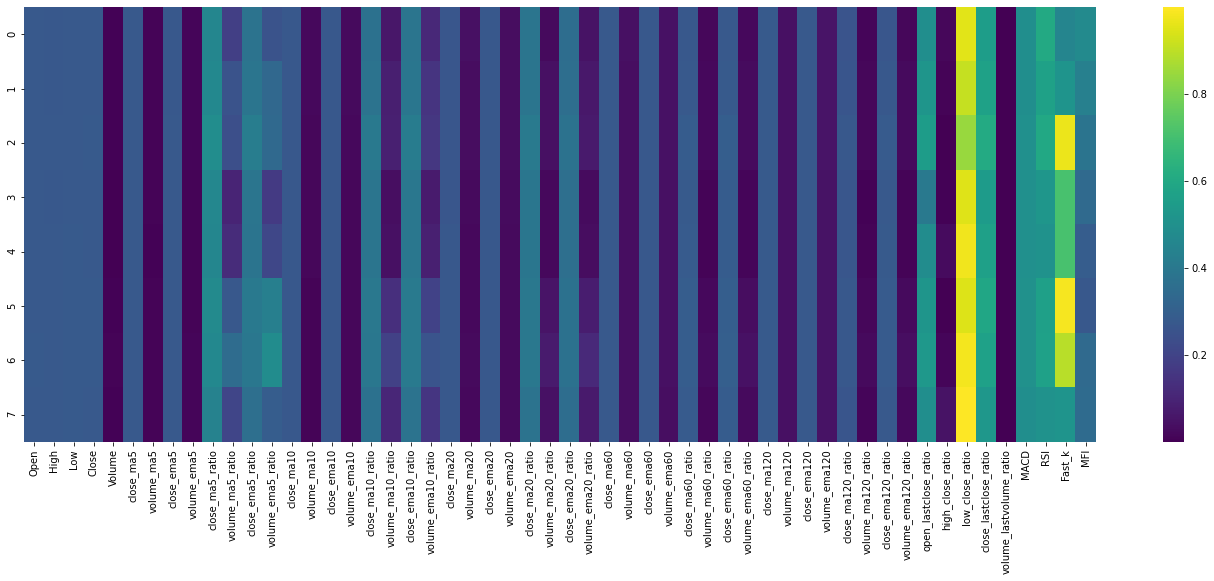

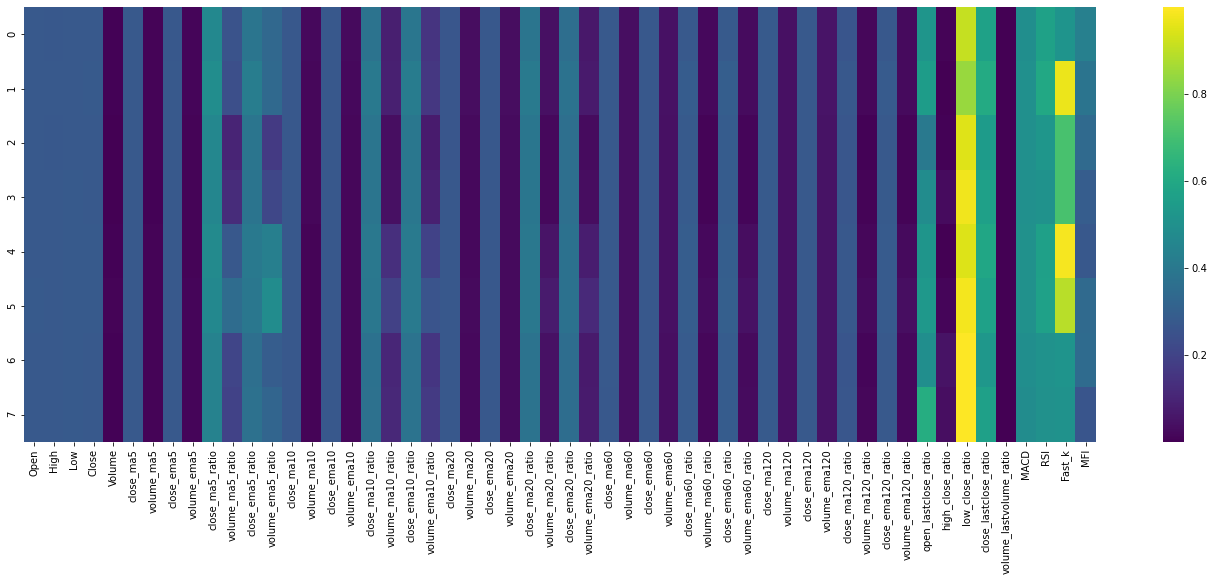

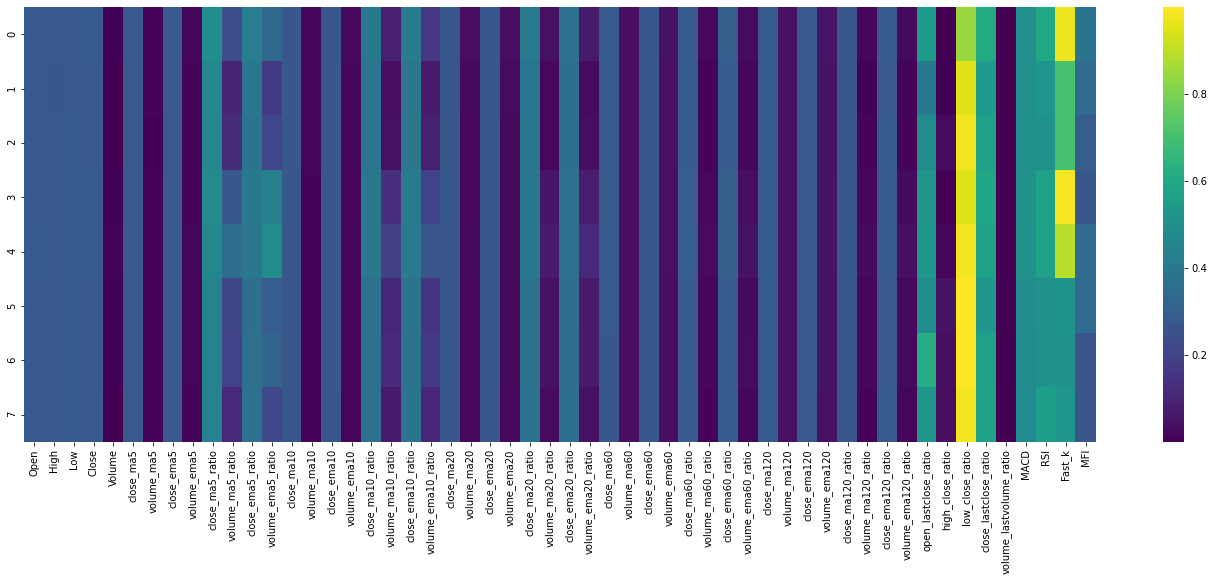

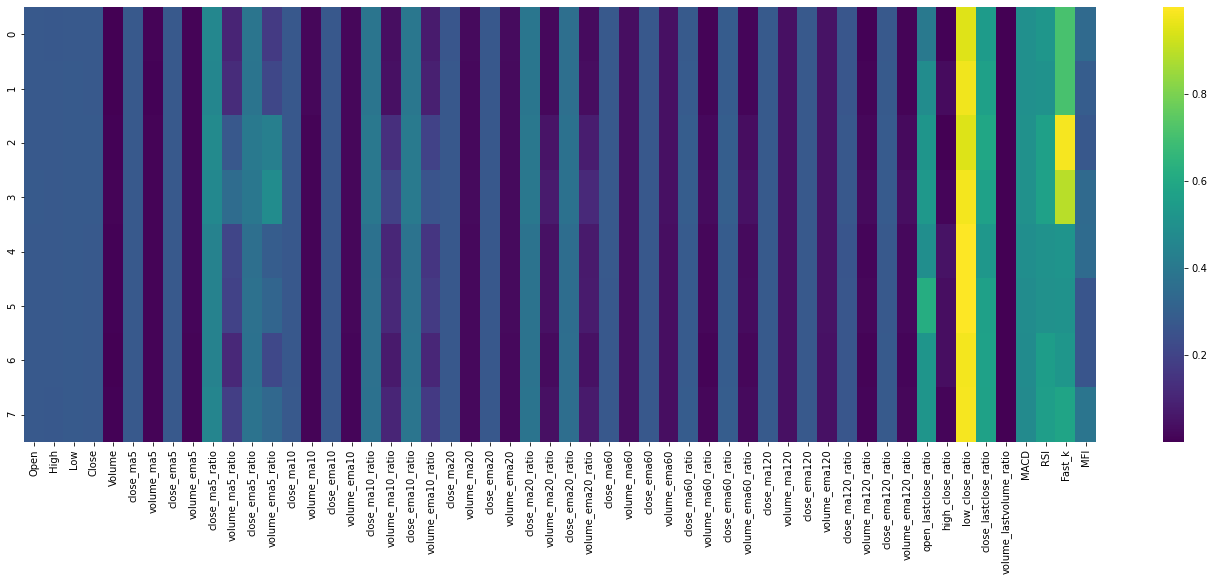

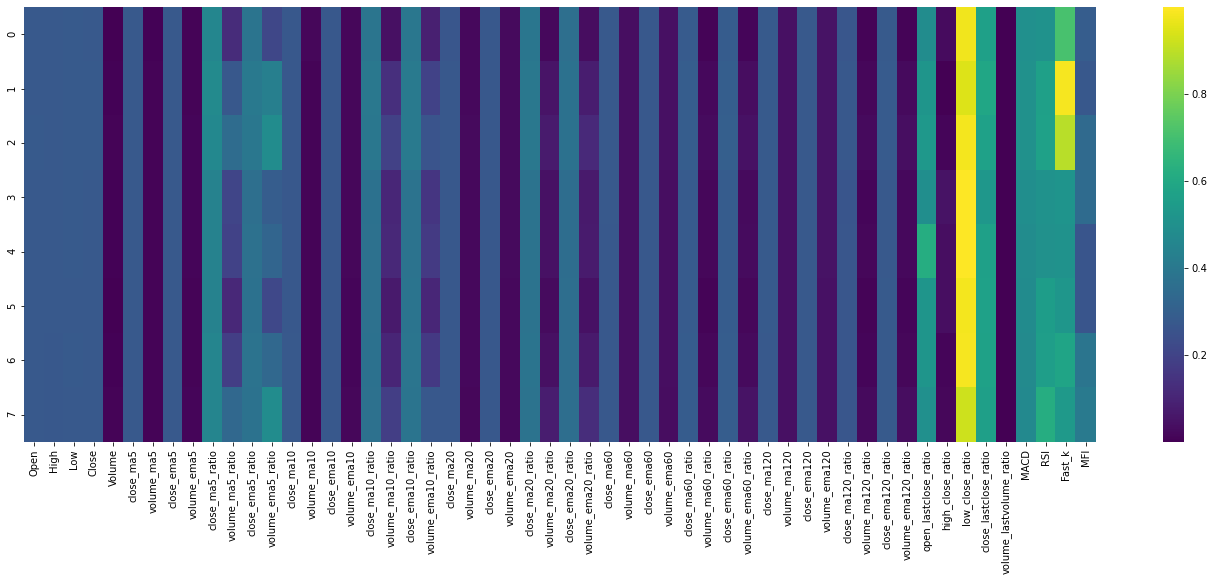

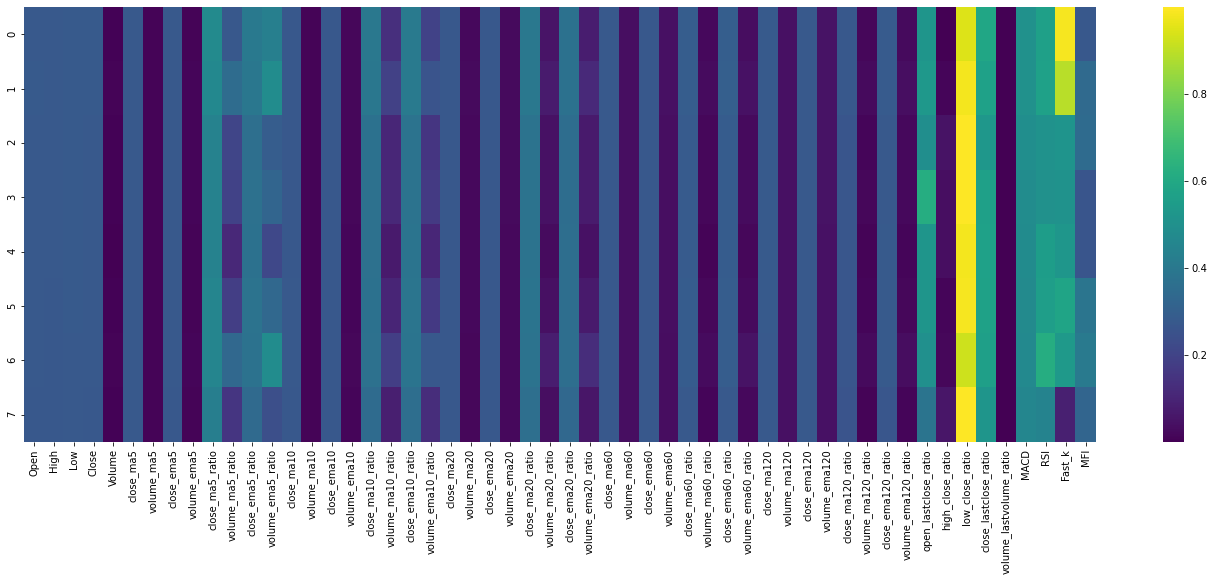

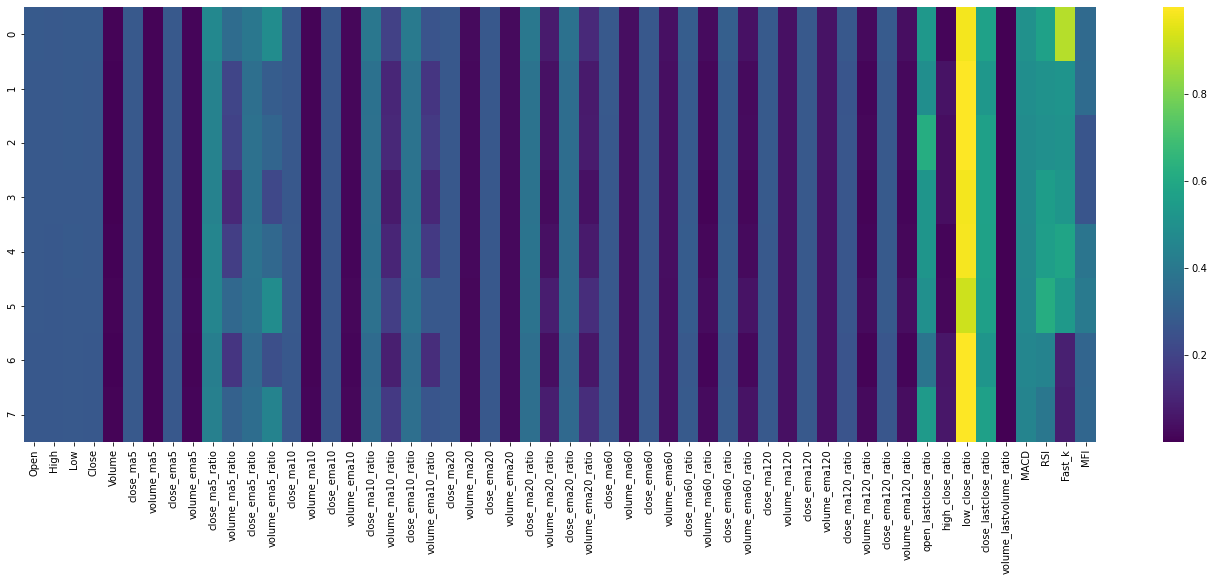

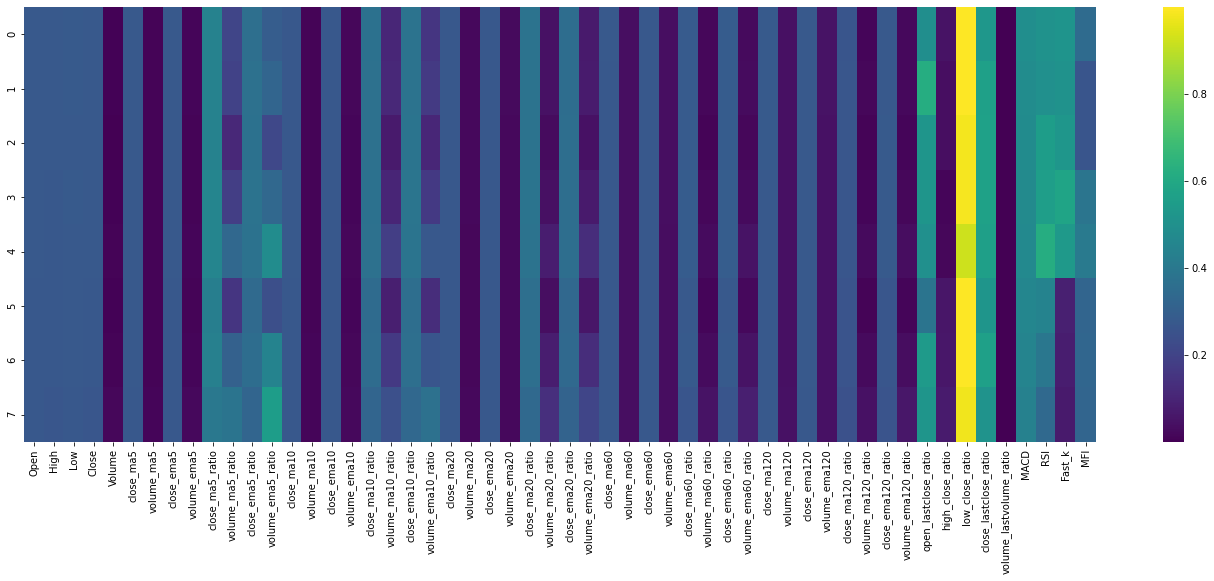

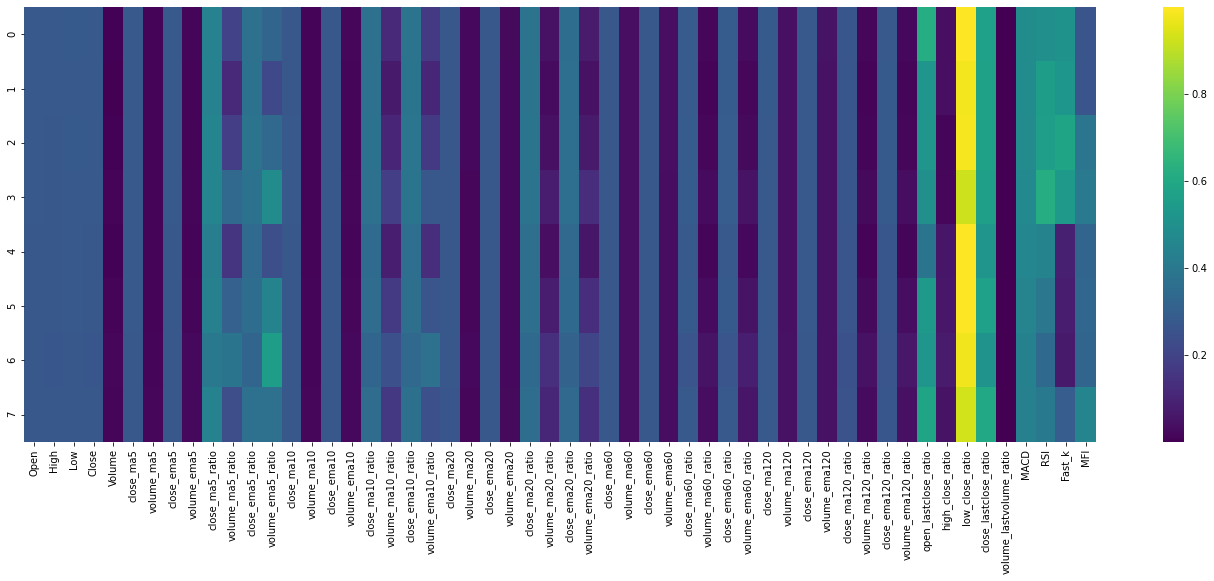

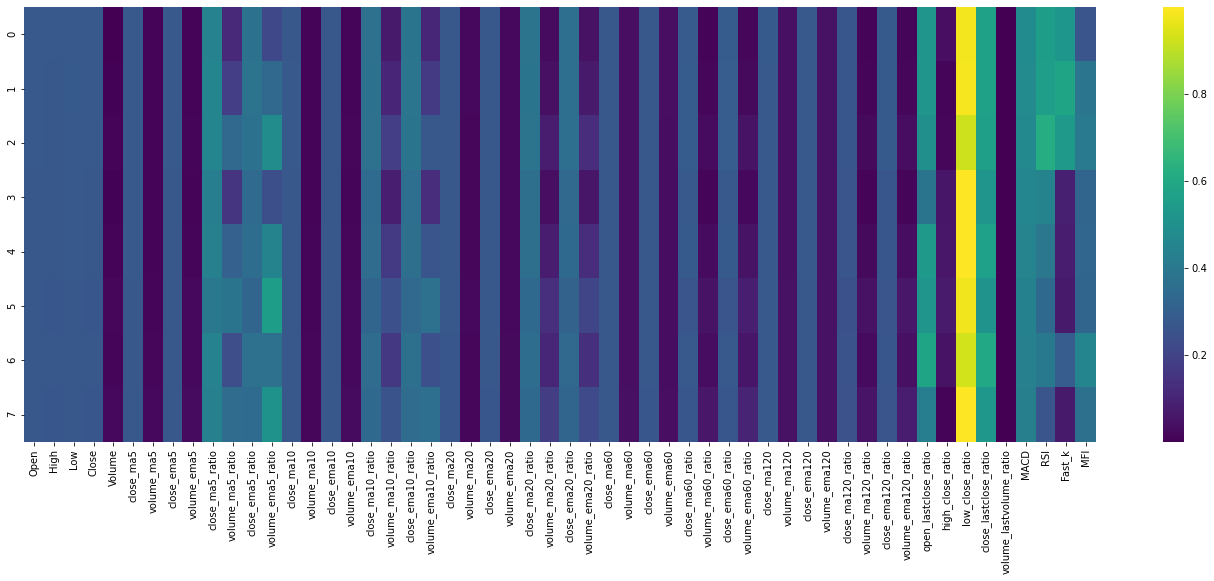

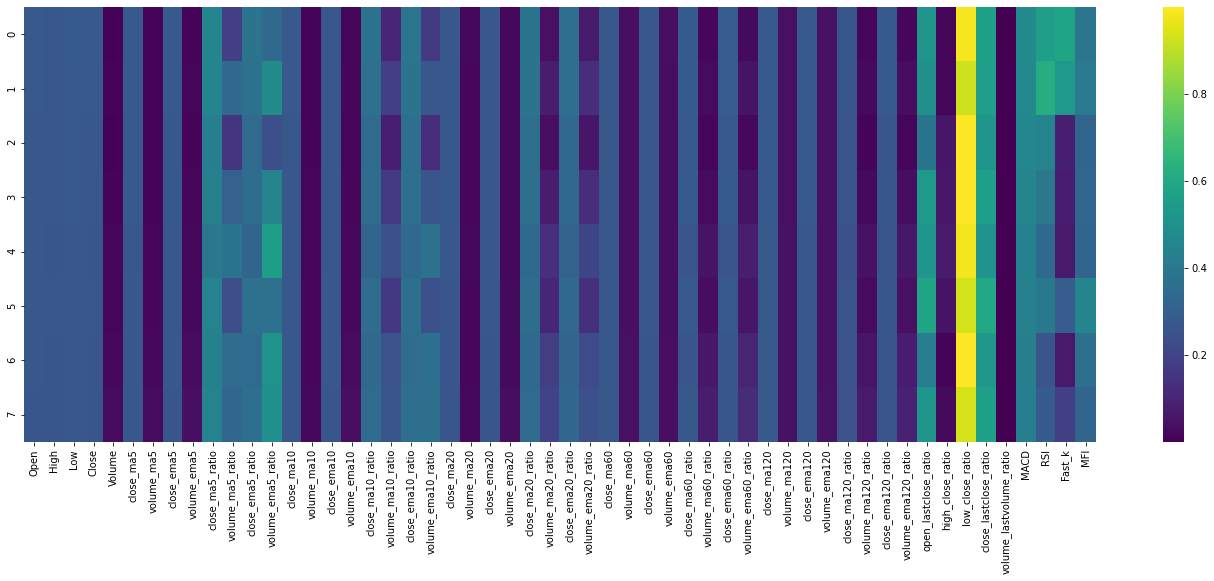

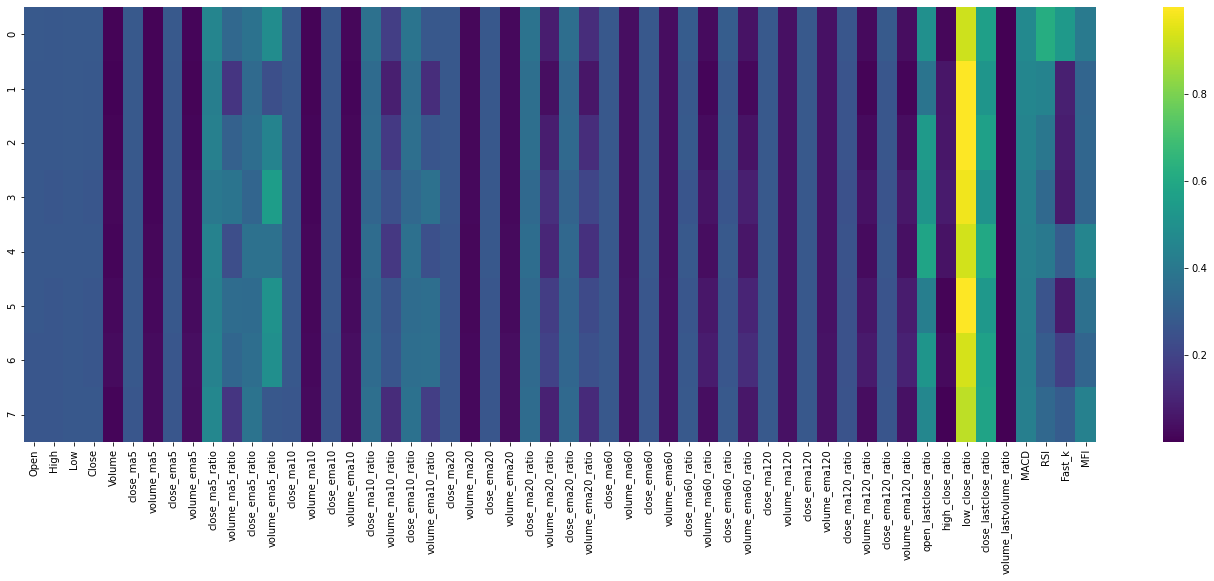

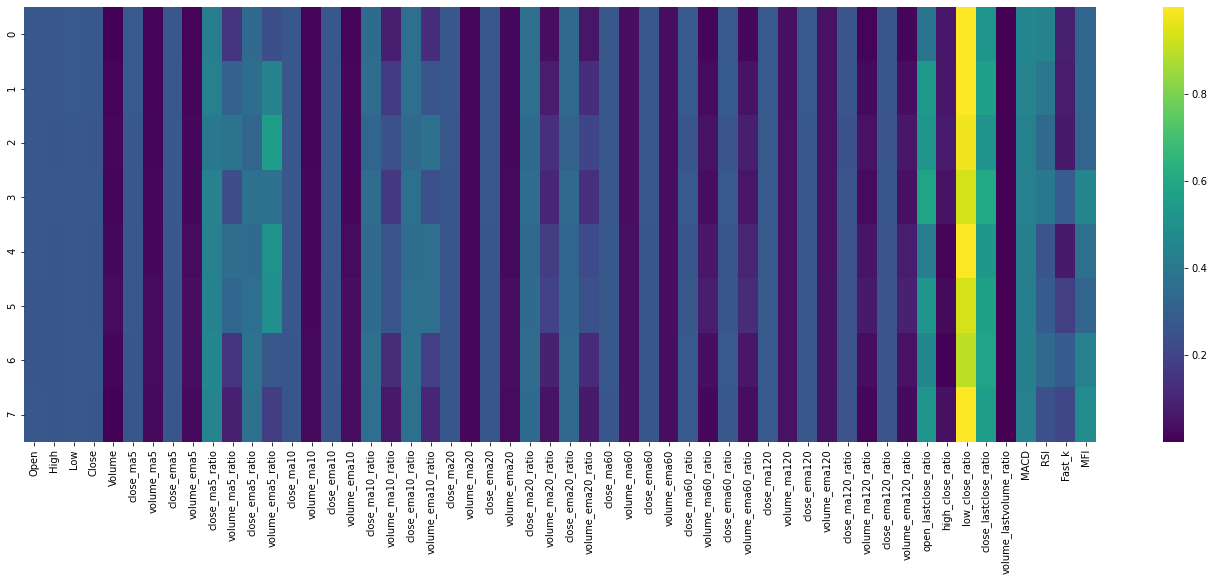

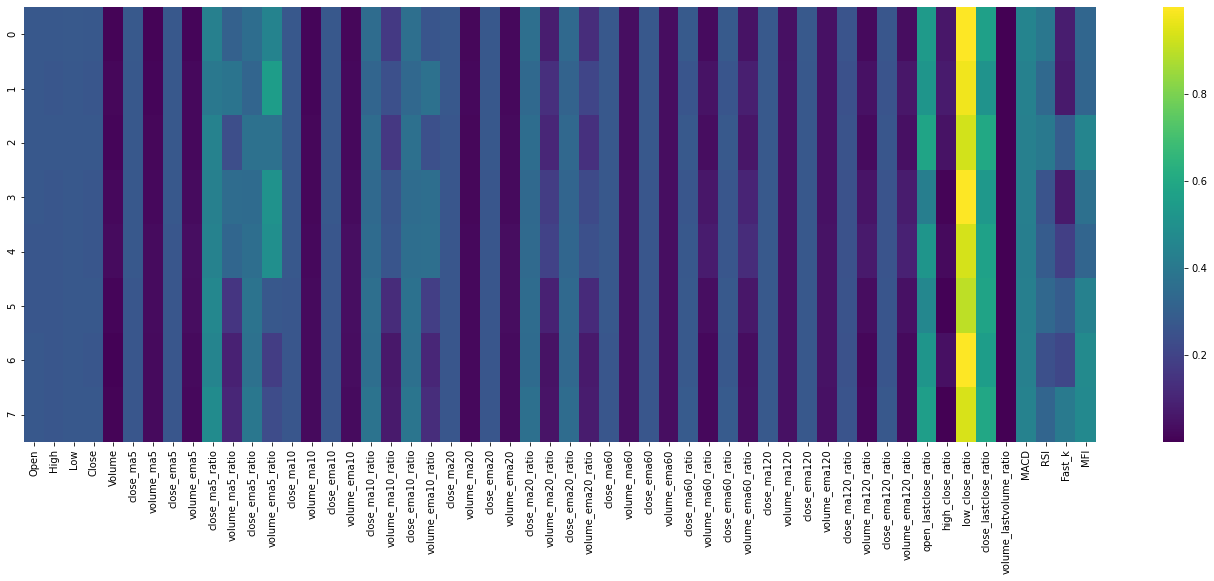

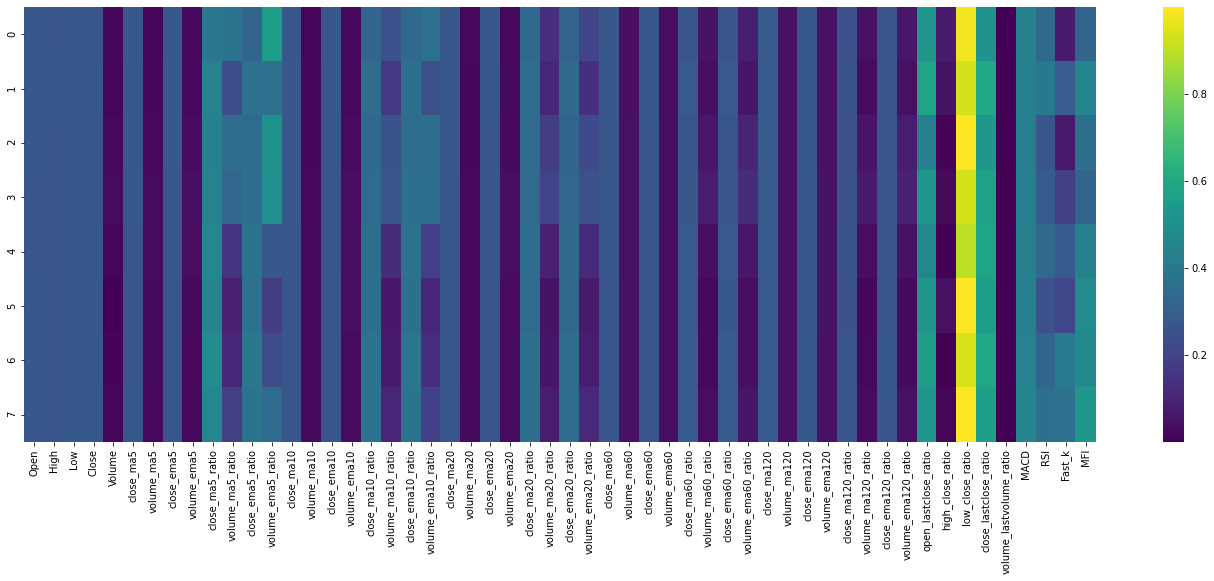

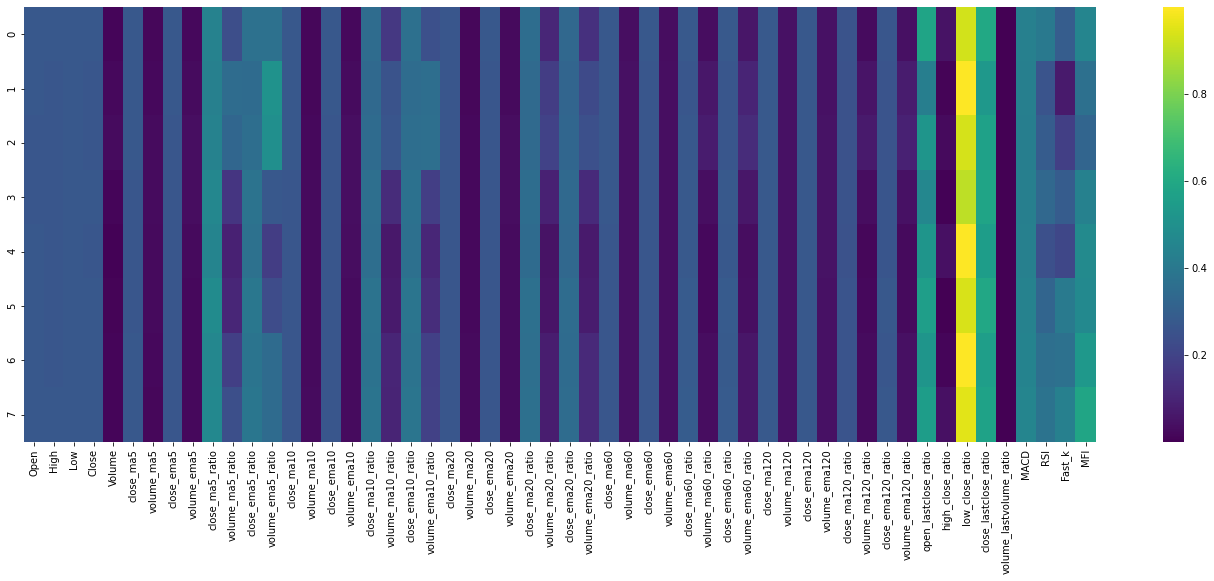

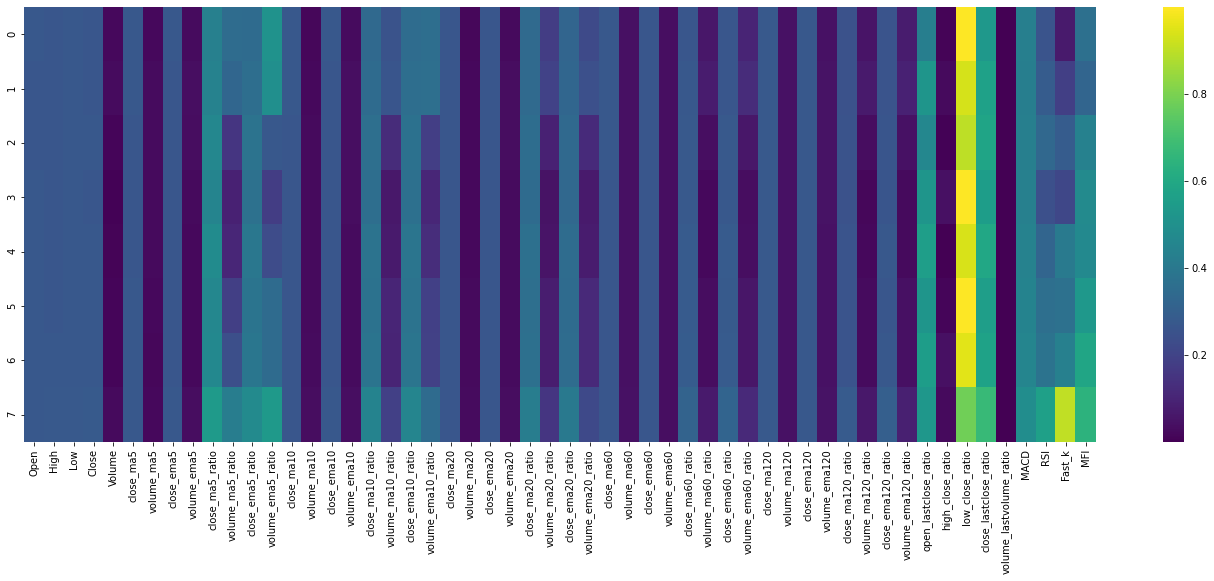

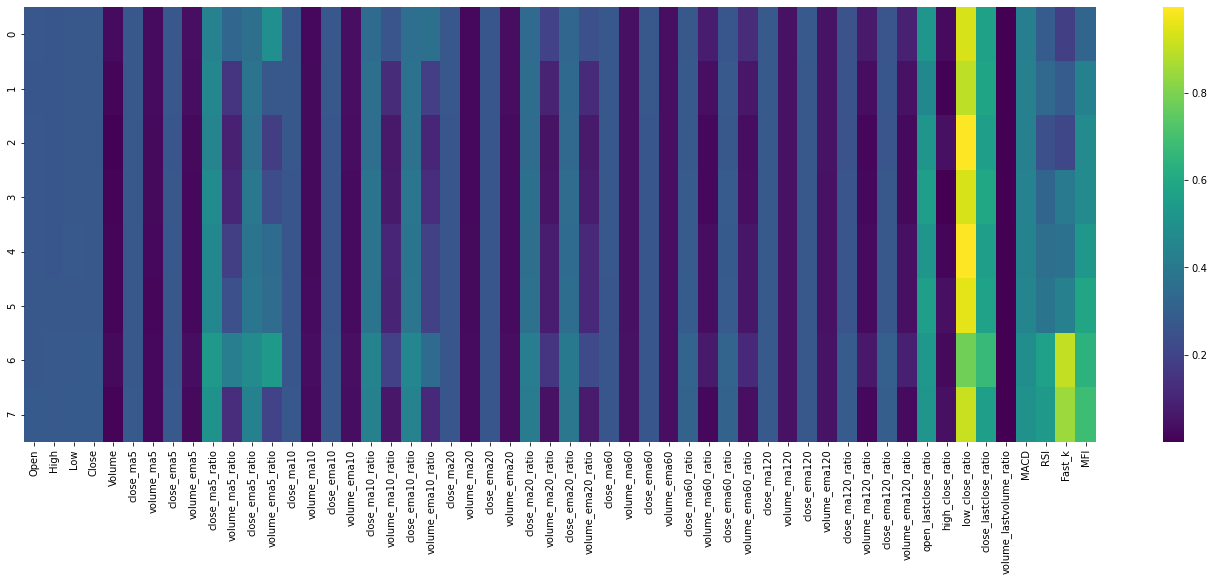

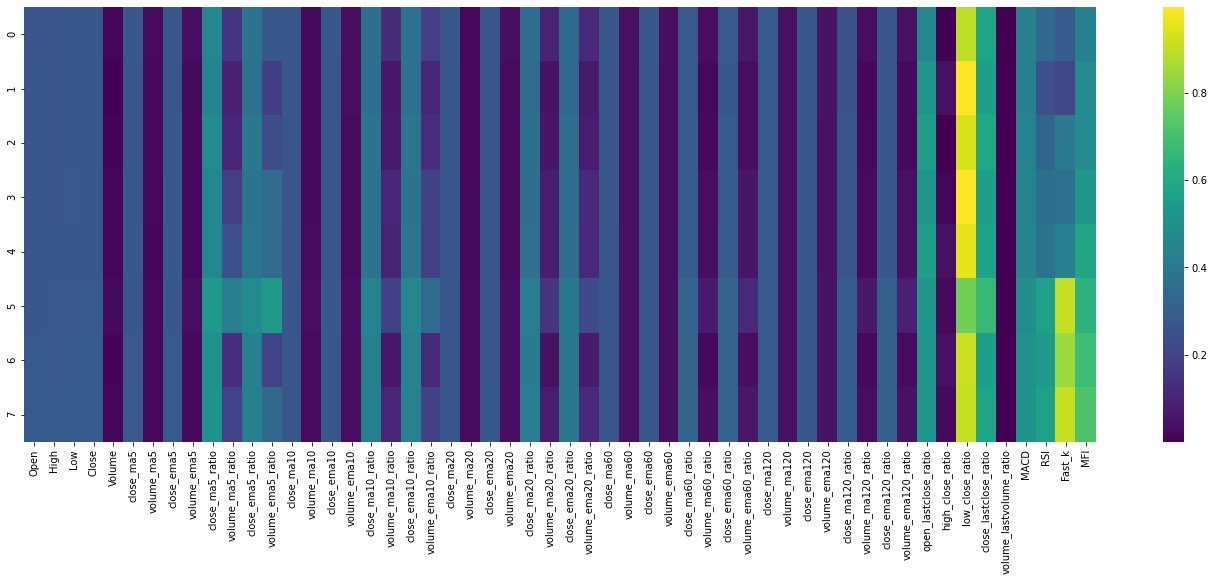

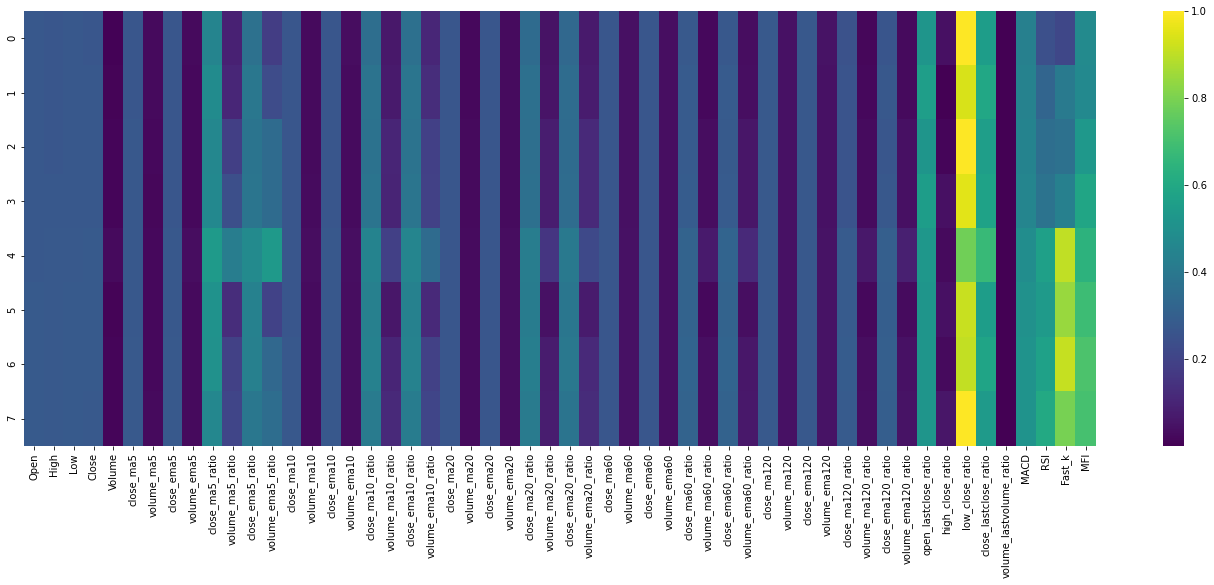

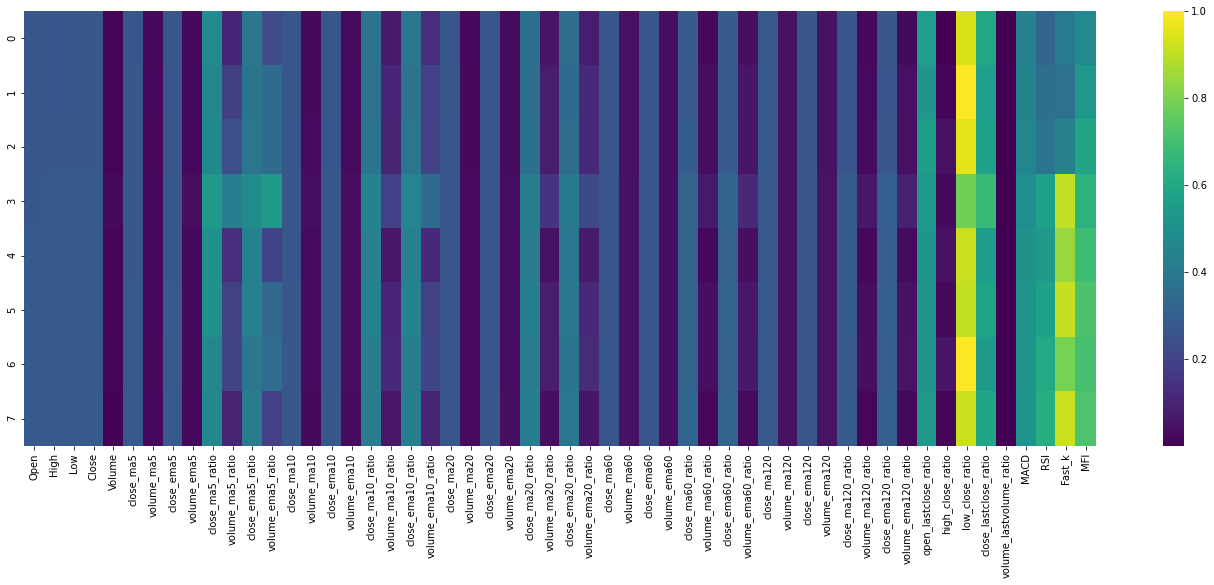

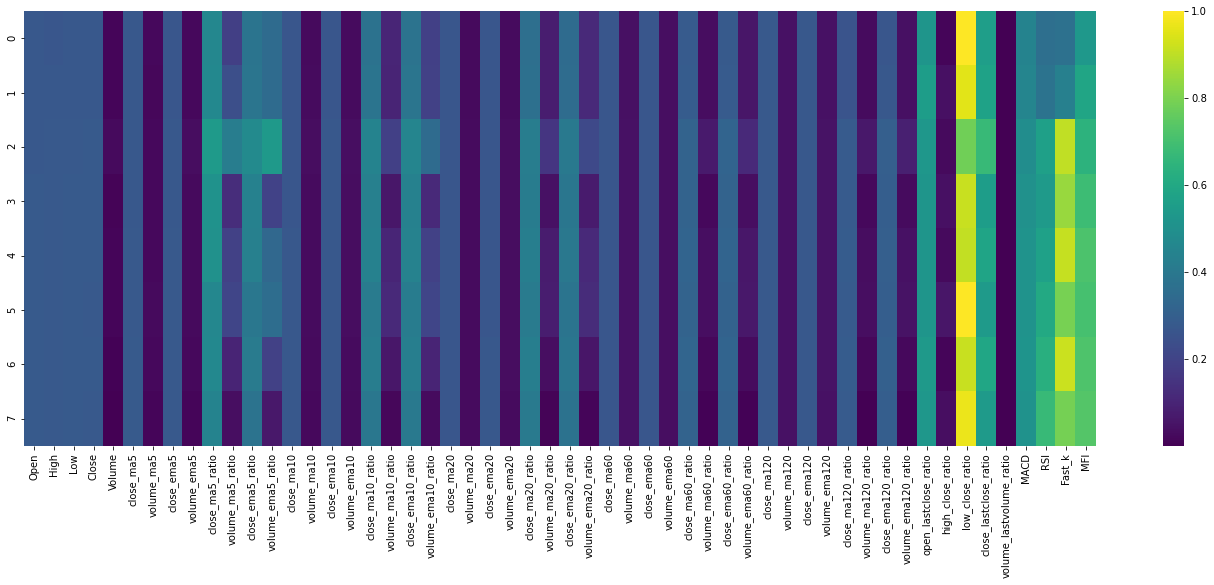

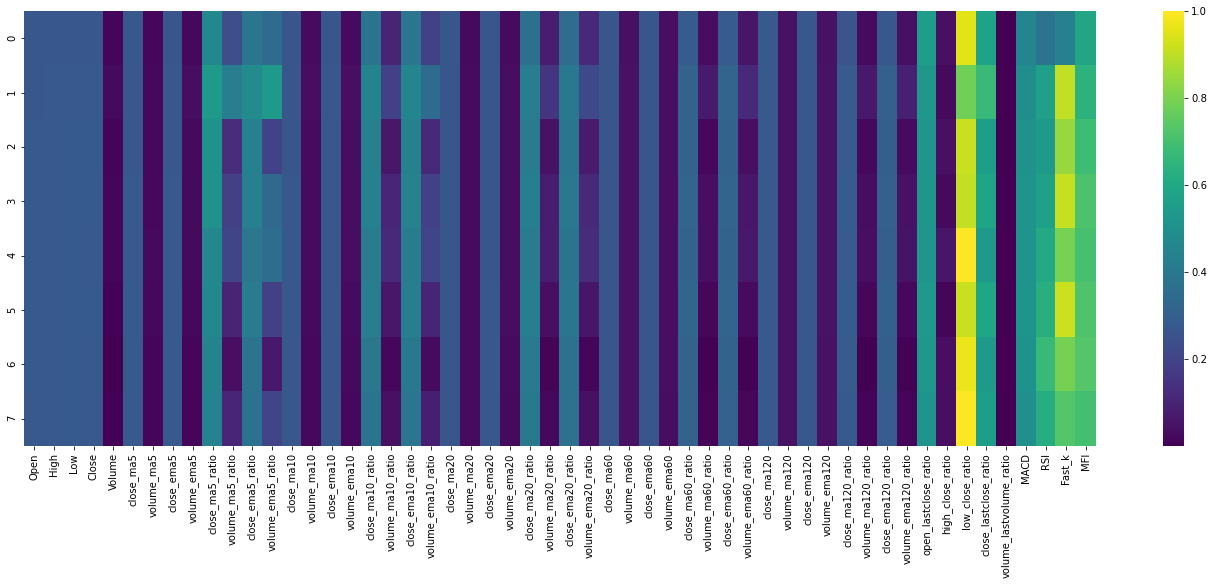

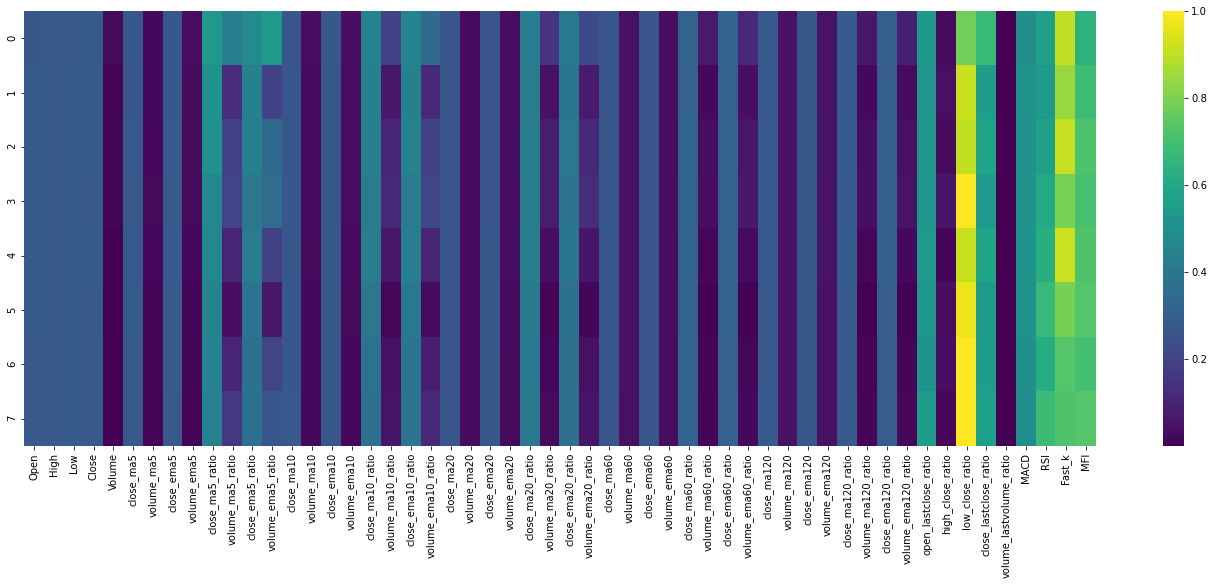

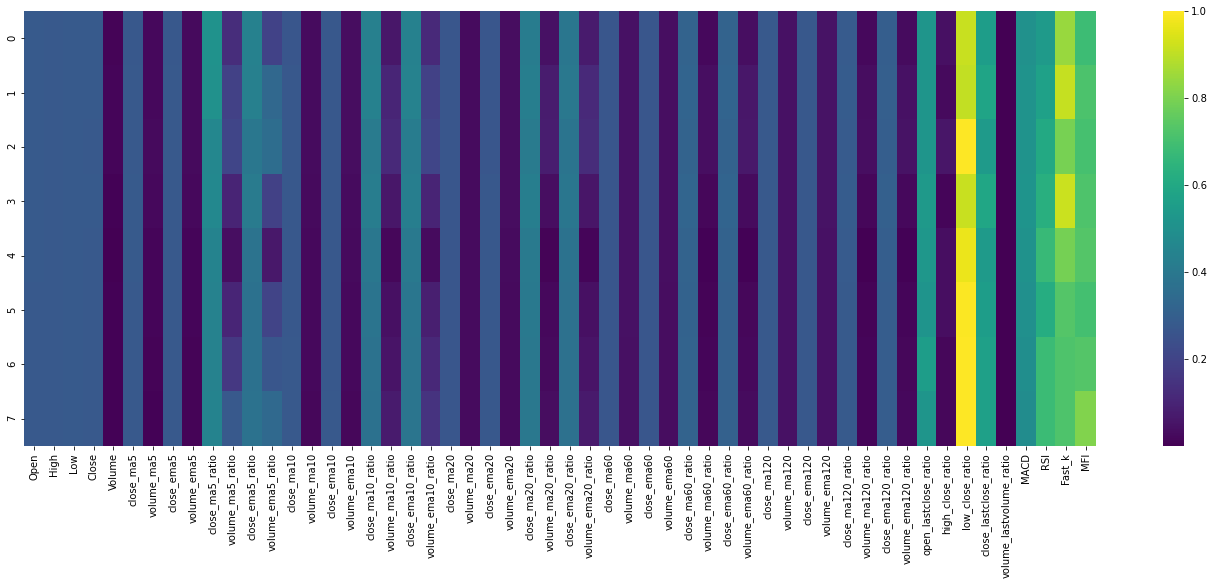

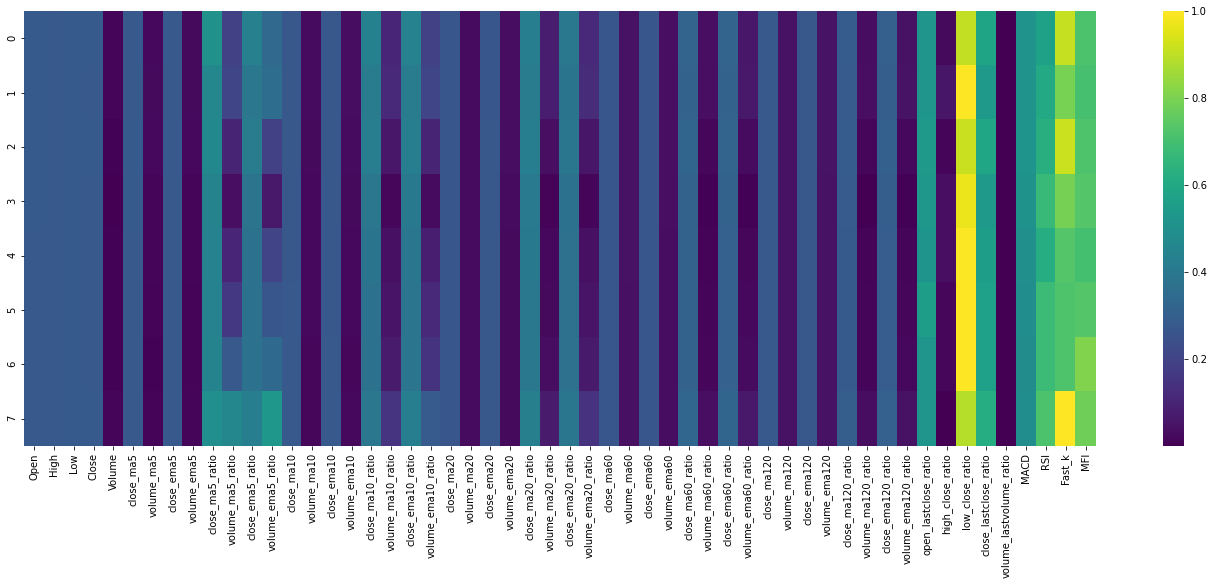

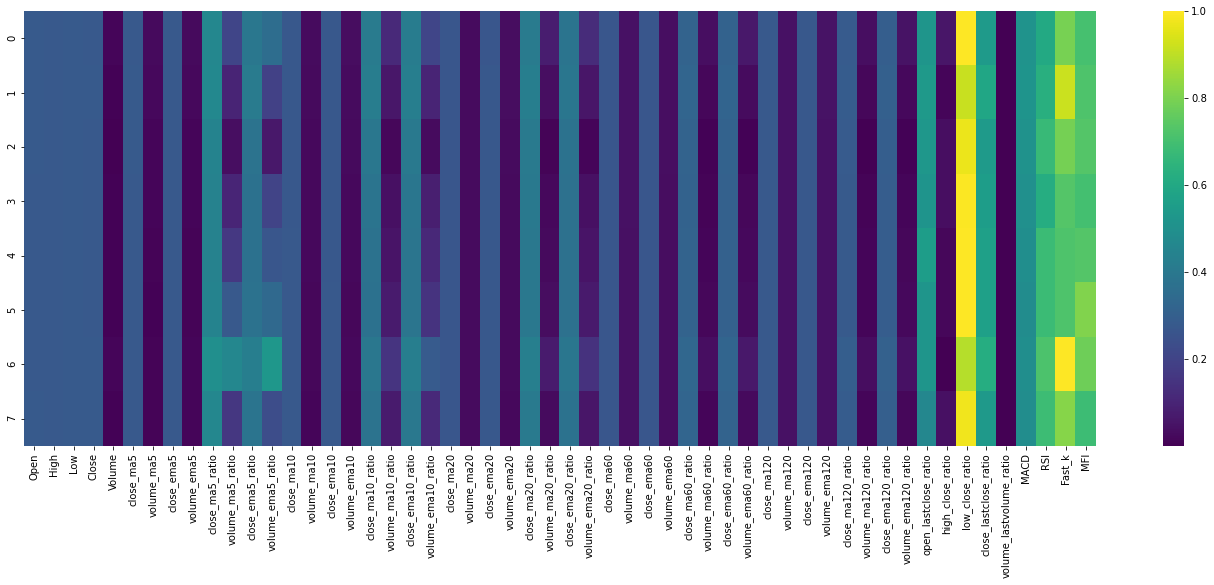

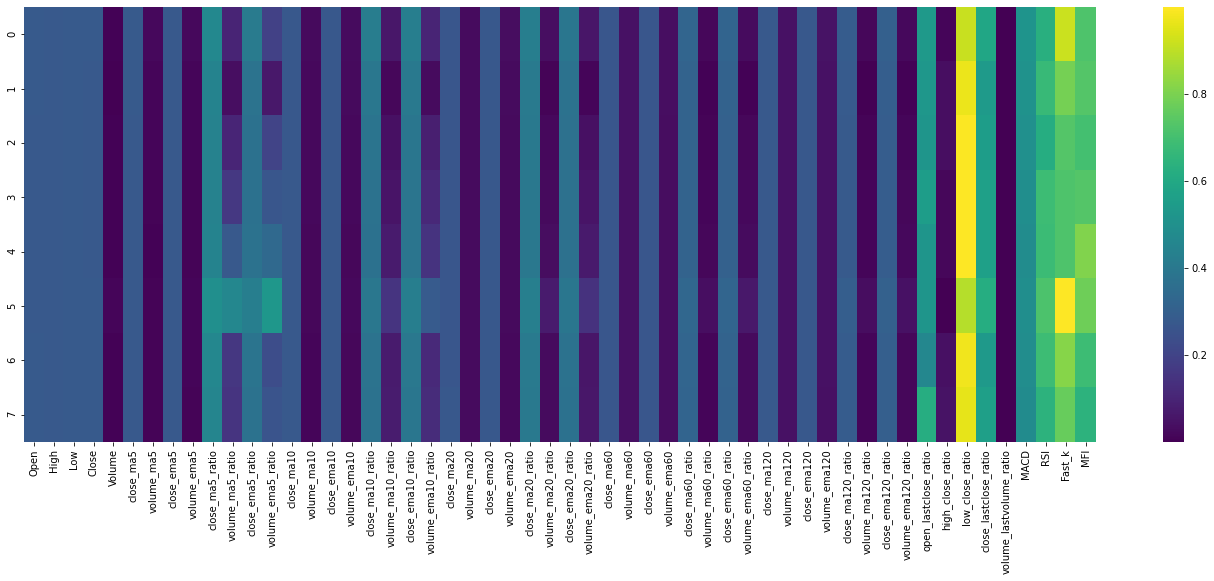

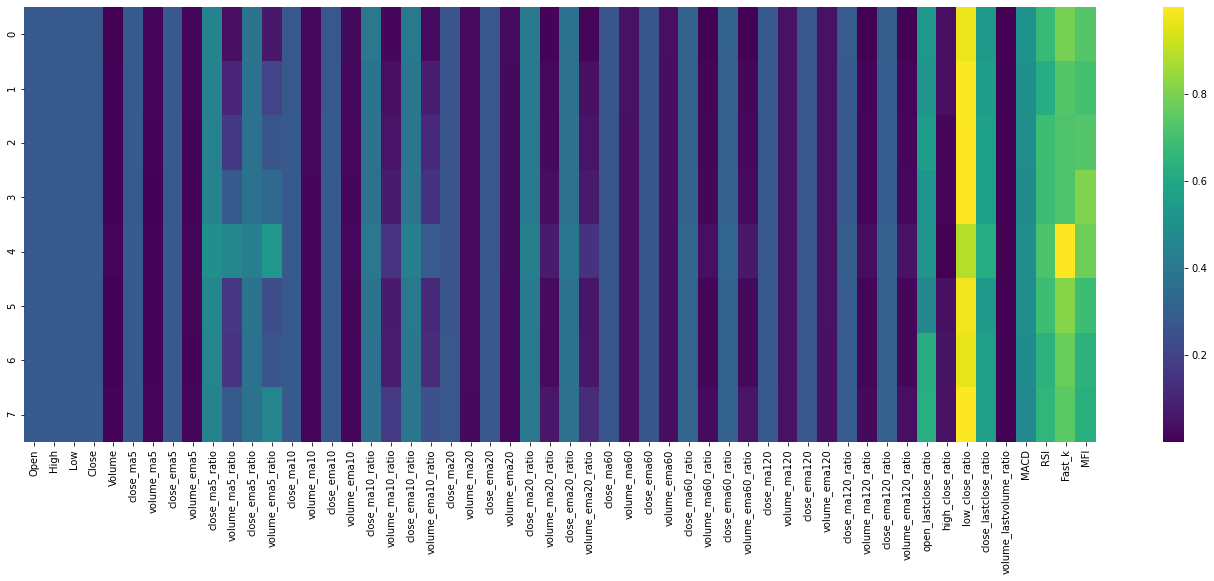

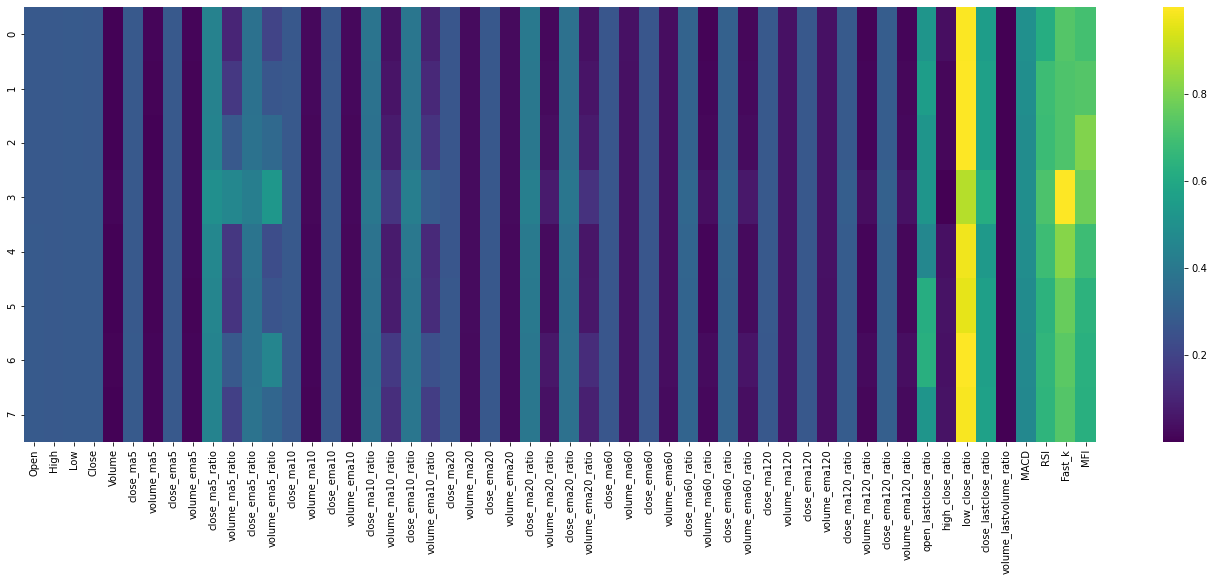

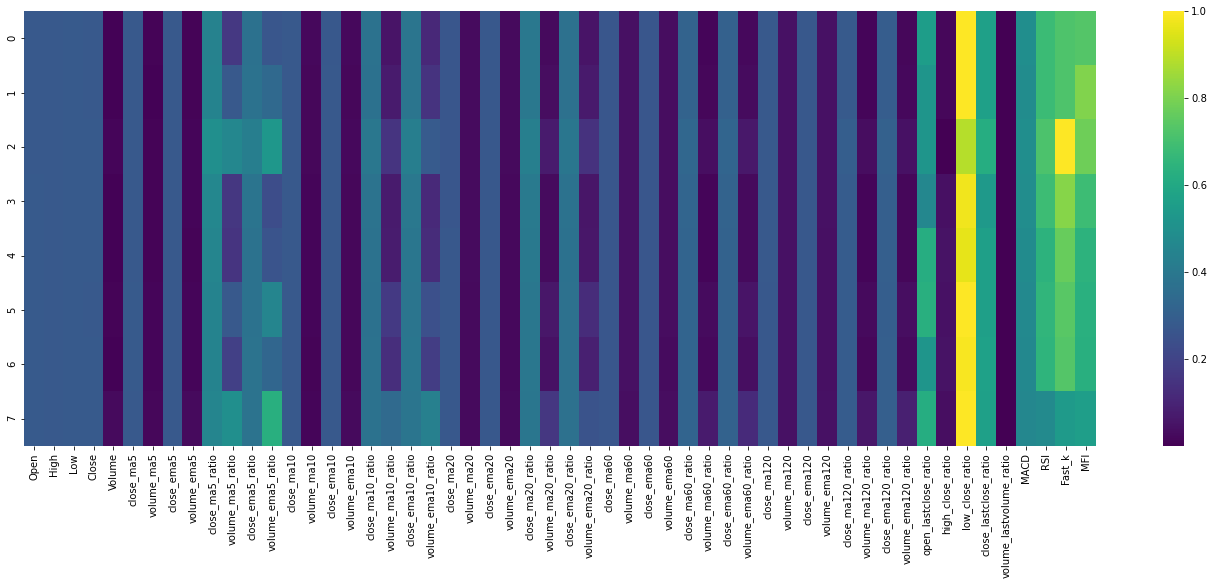

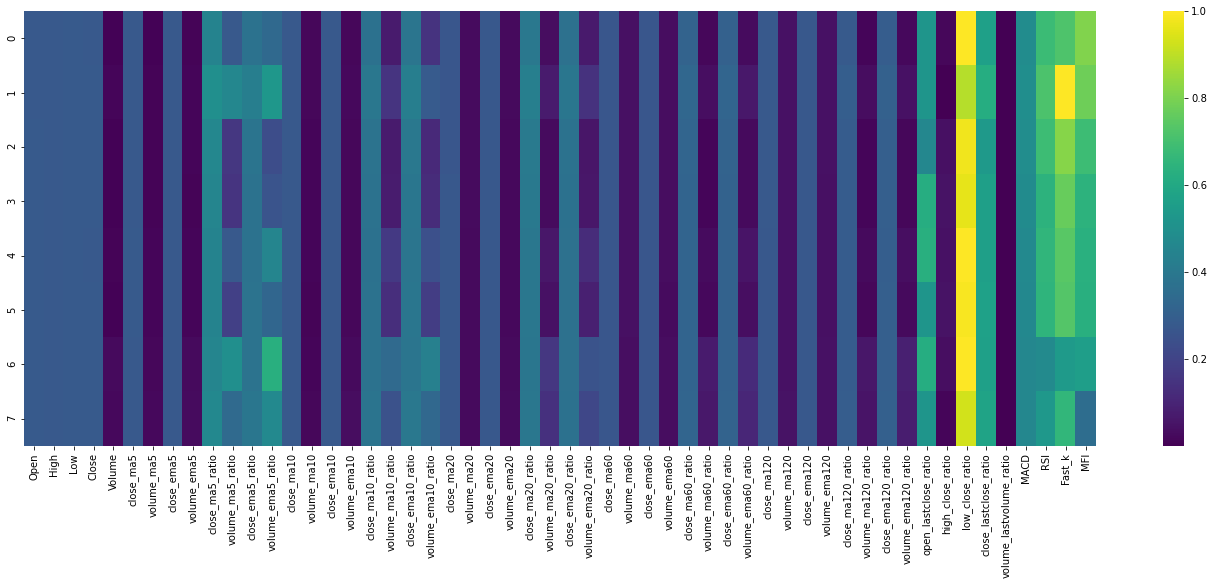

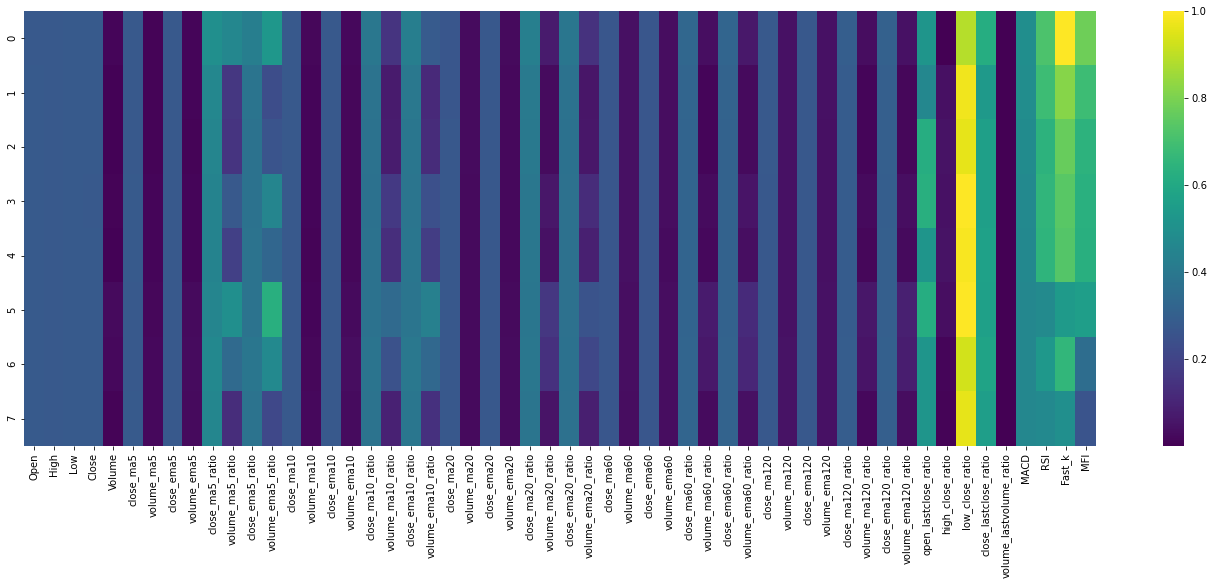

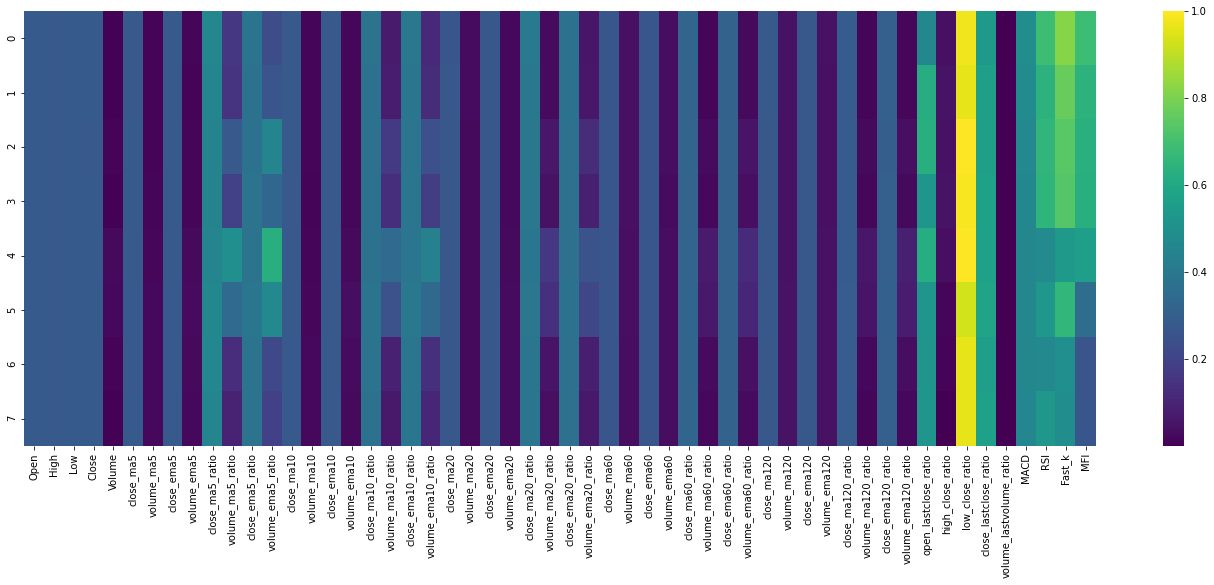

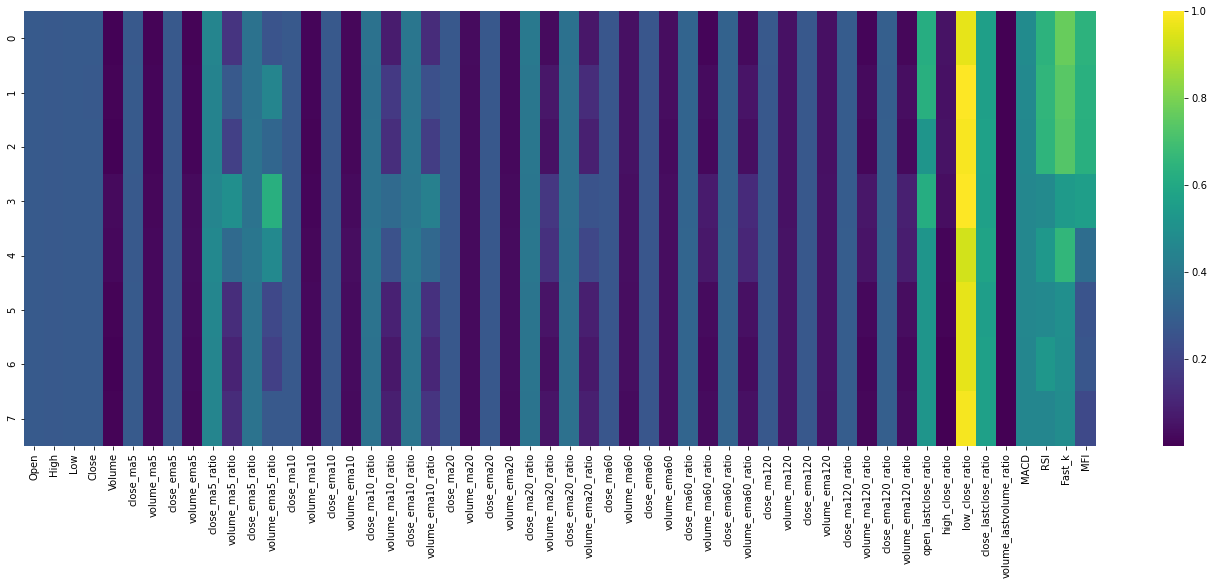

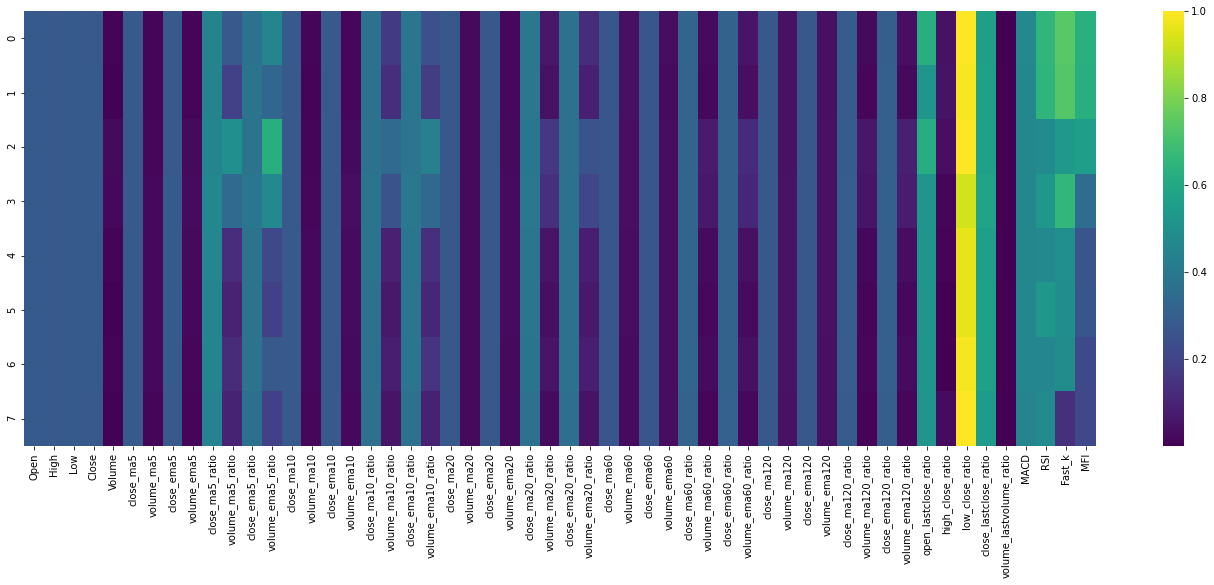

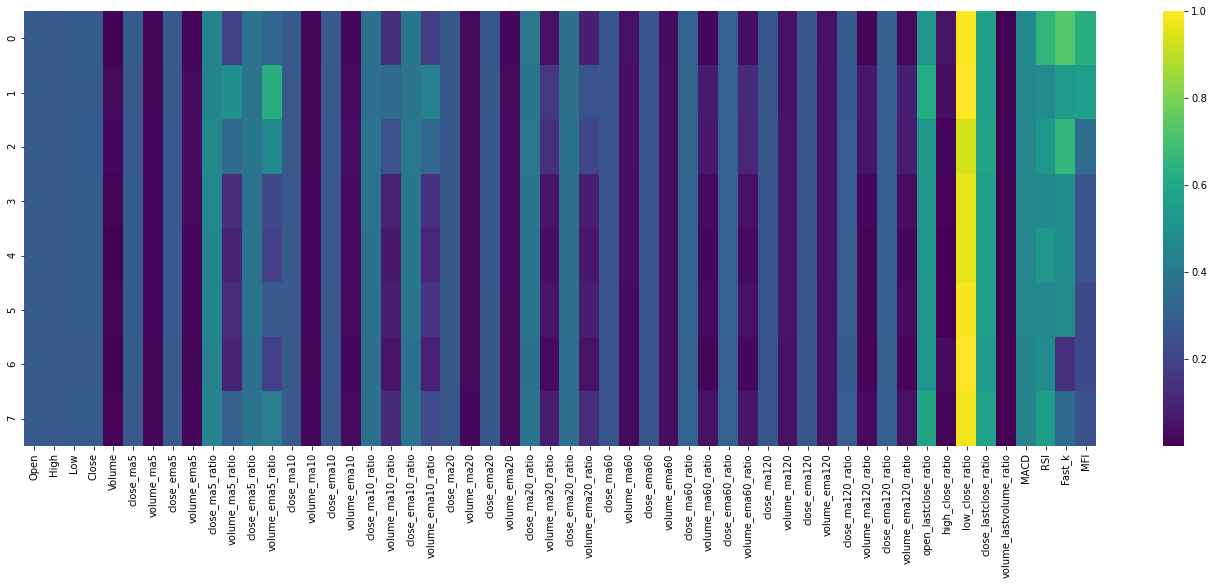

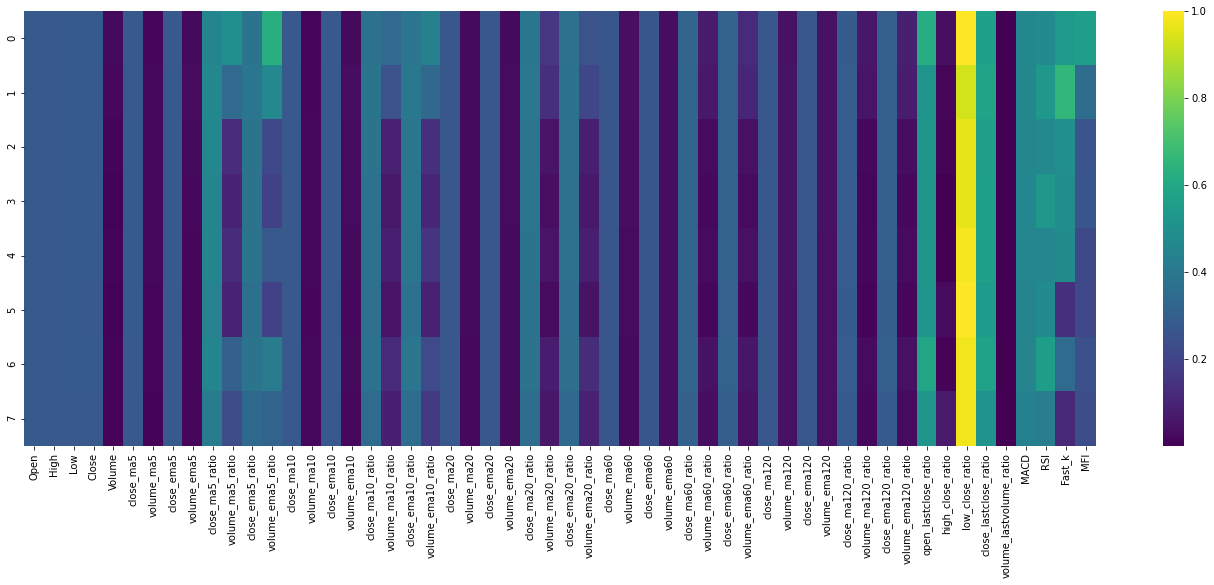

In [247]:
for i in range(100):
    heat_train=pd.DataFrame(x_train[i].reshape(8,54),columns=tmp.columns)
    plt.figure(figsize=(24, 8))
    sns.heatmap(heat_train, cmap='viridis')
    plt.savefig('image{}.png'.format(i))

<ipython-input-248-cfc53e8dfd92>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(24, 8))


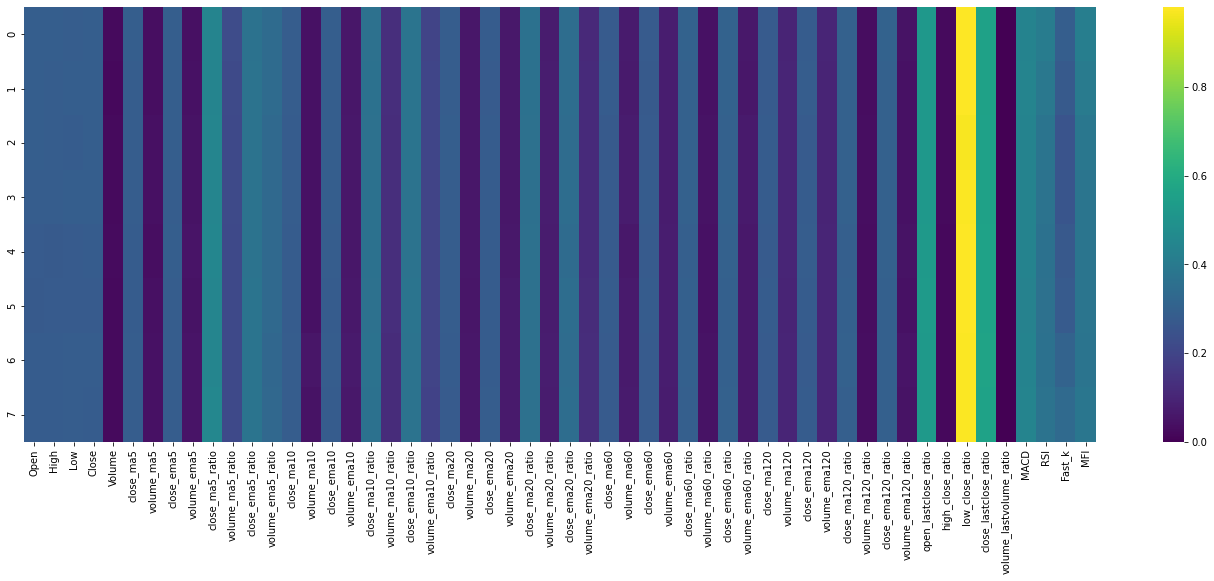

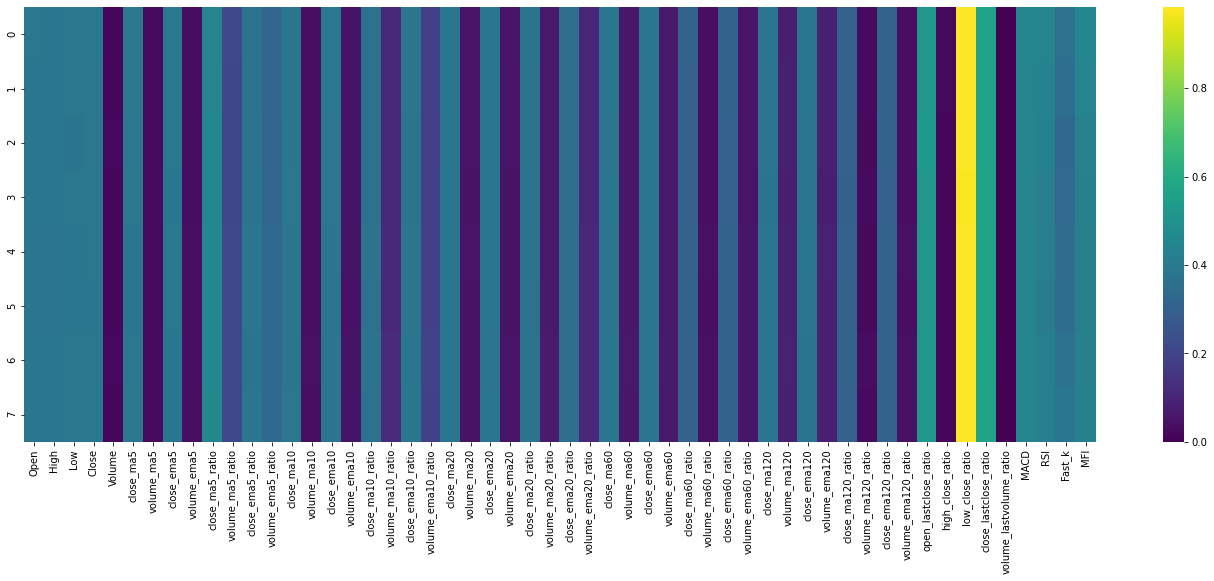

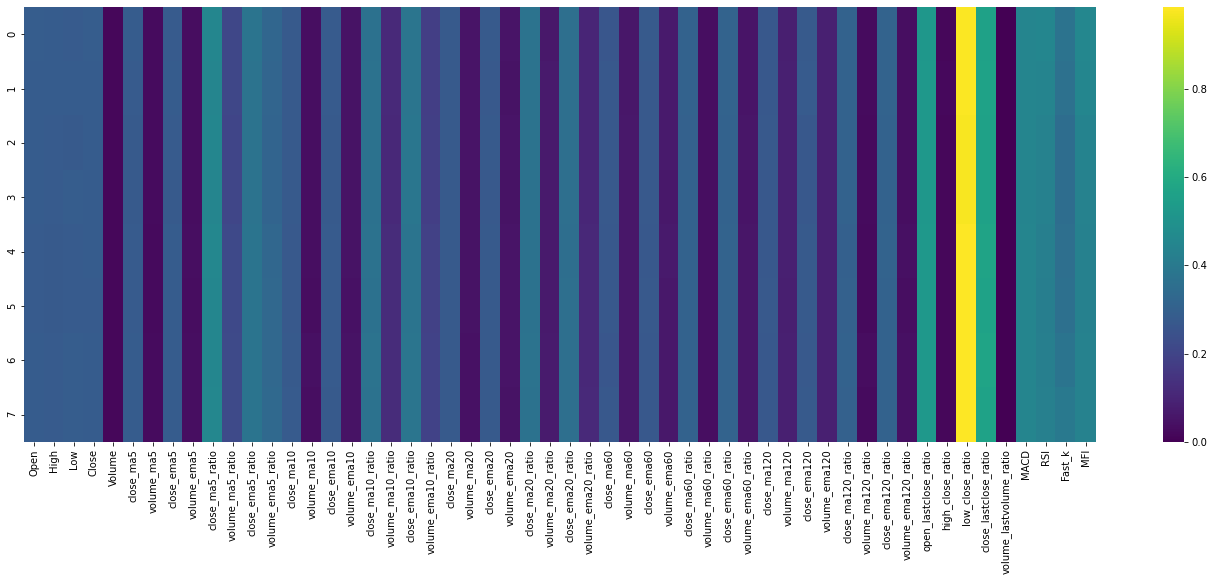

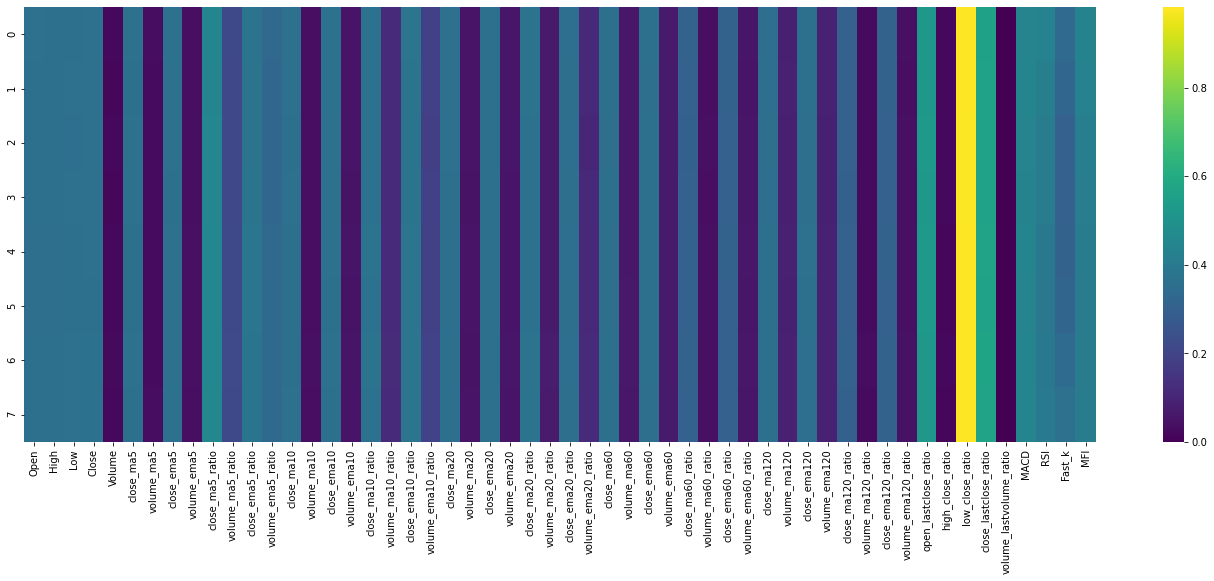

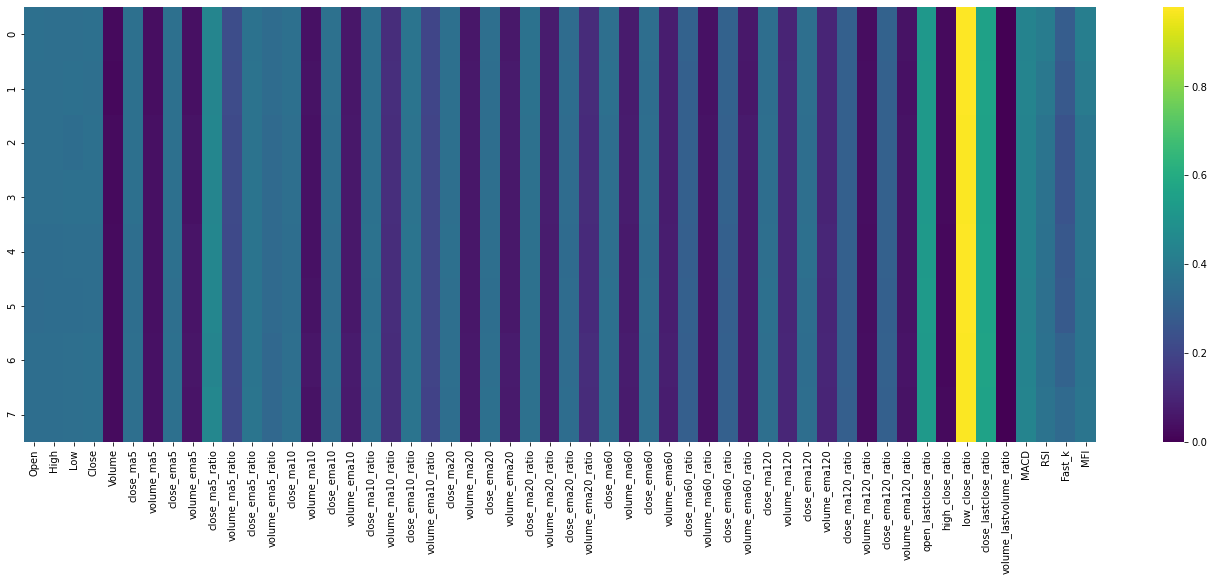

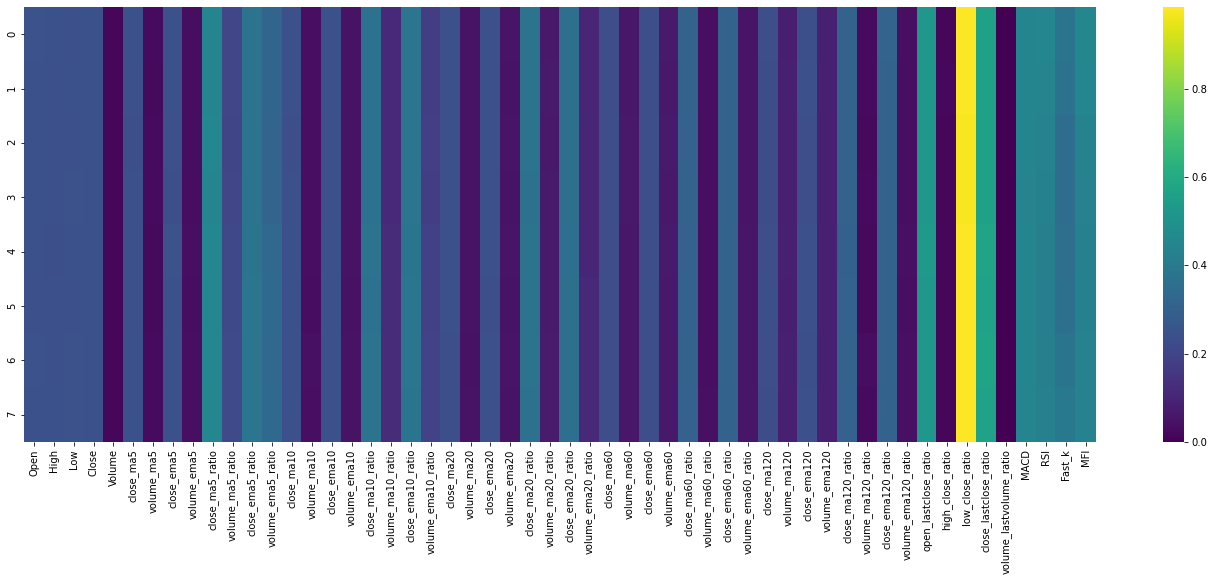

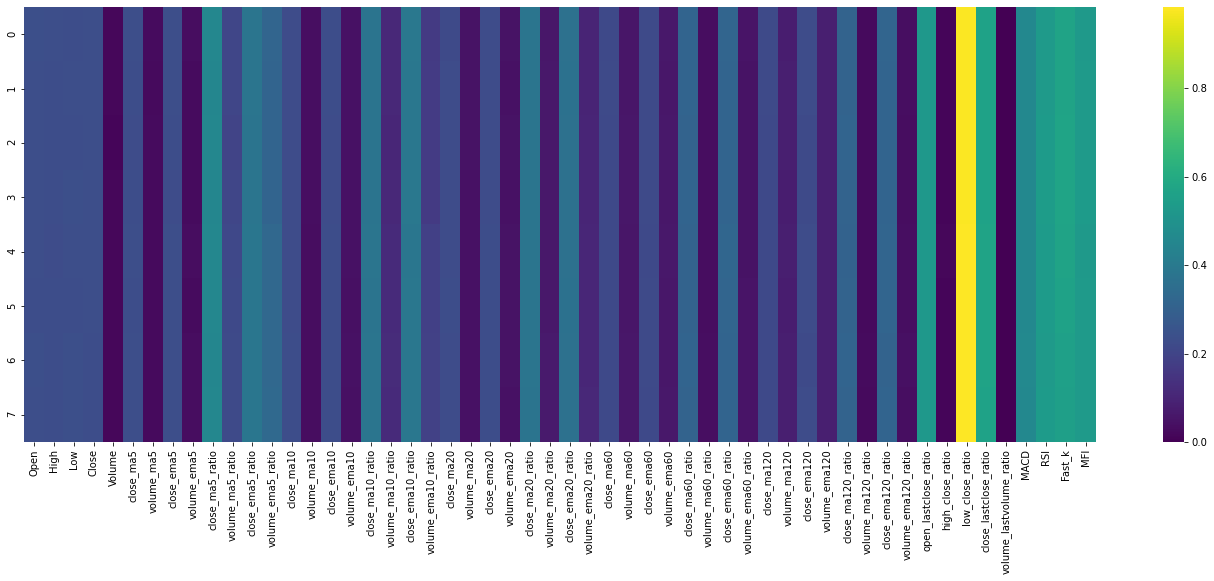

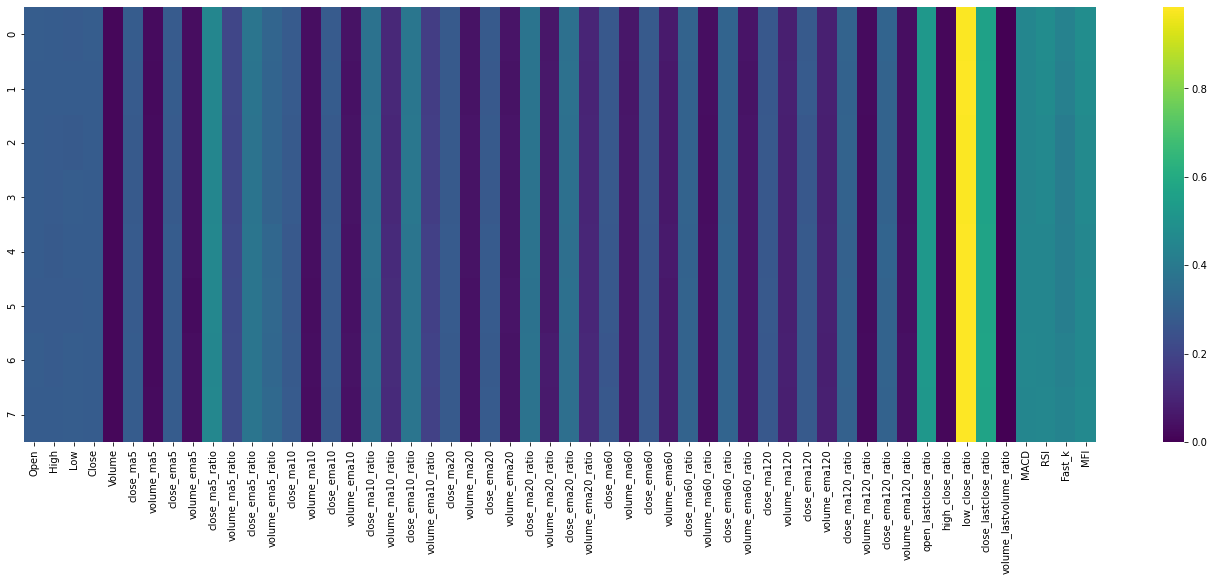

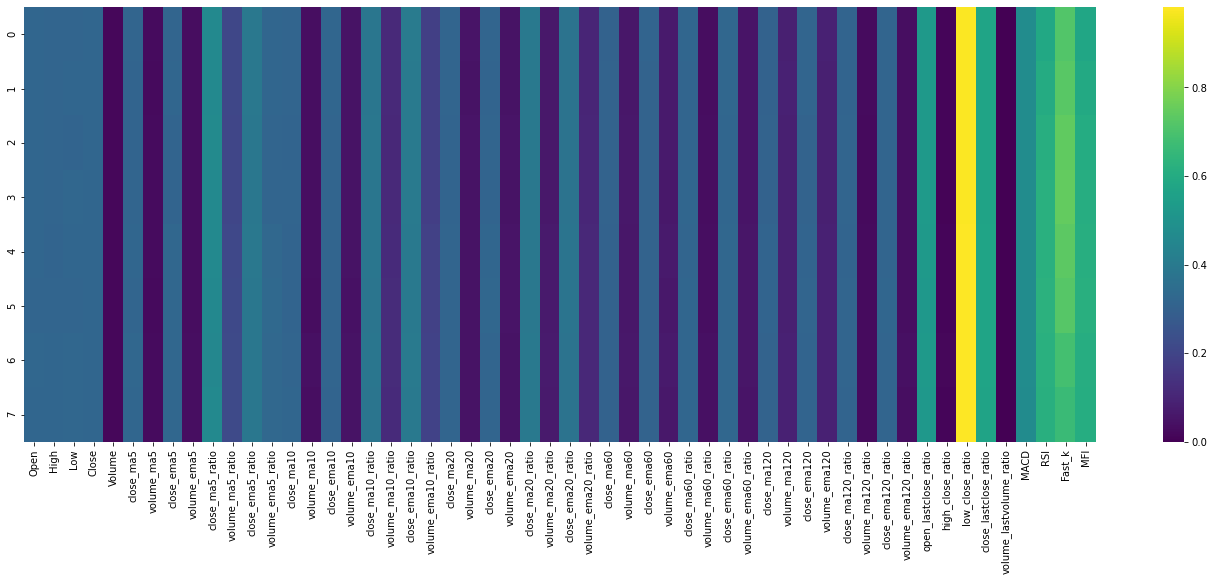

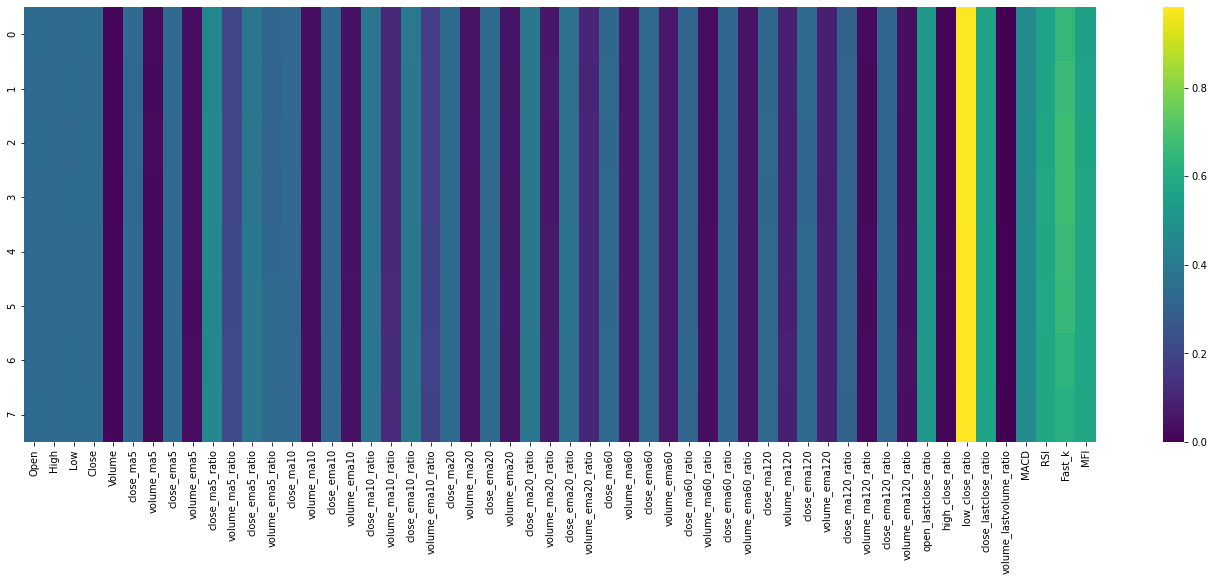

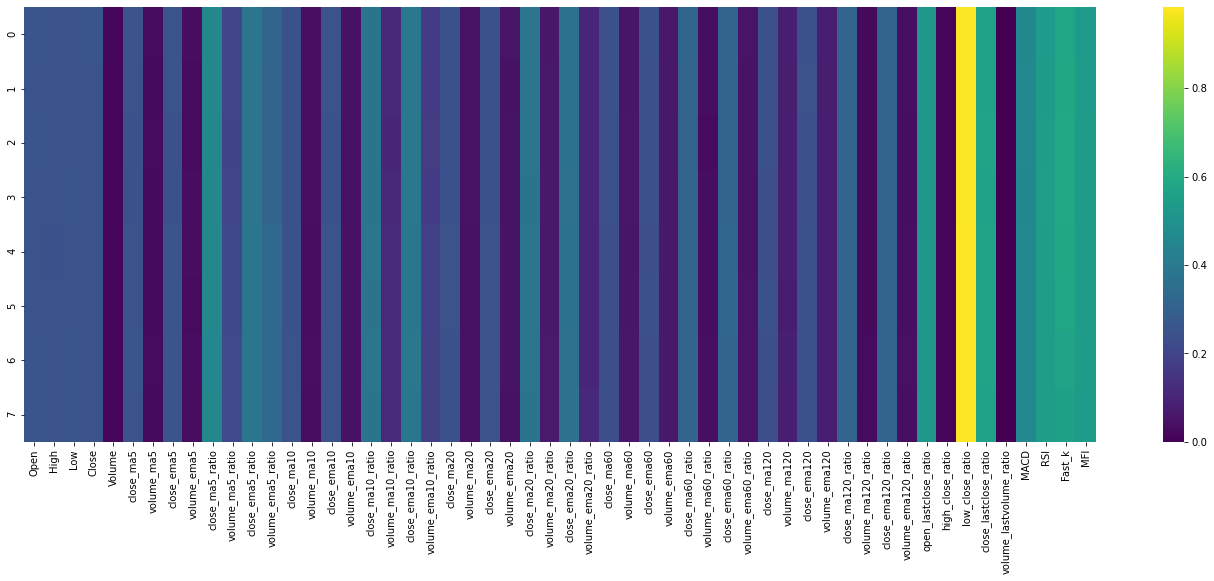

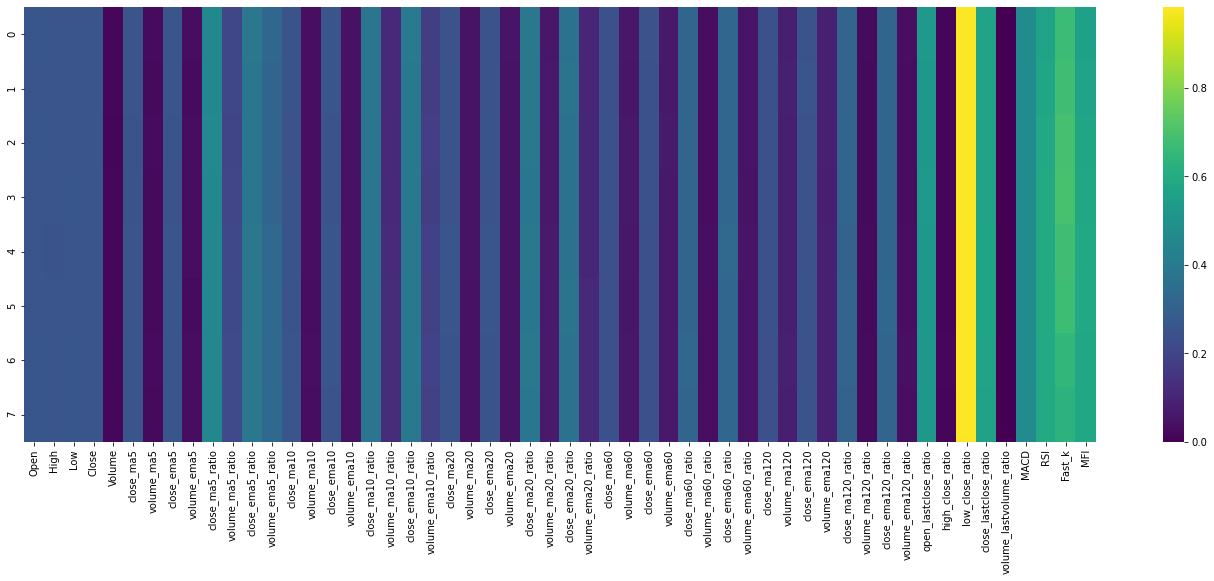

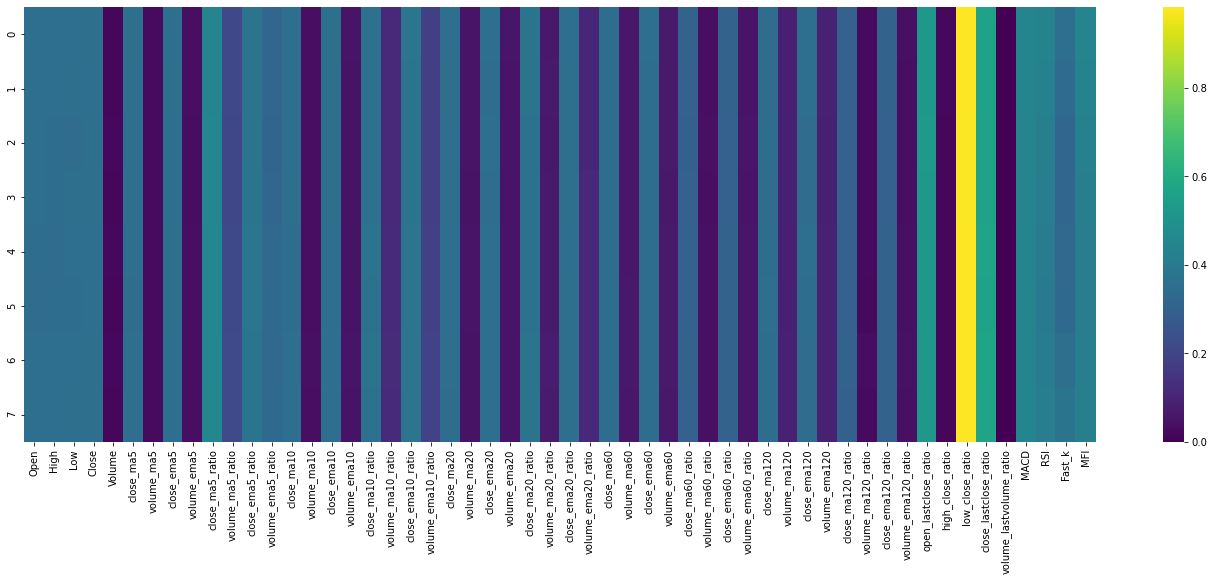

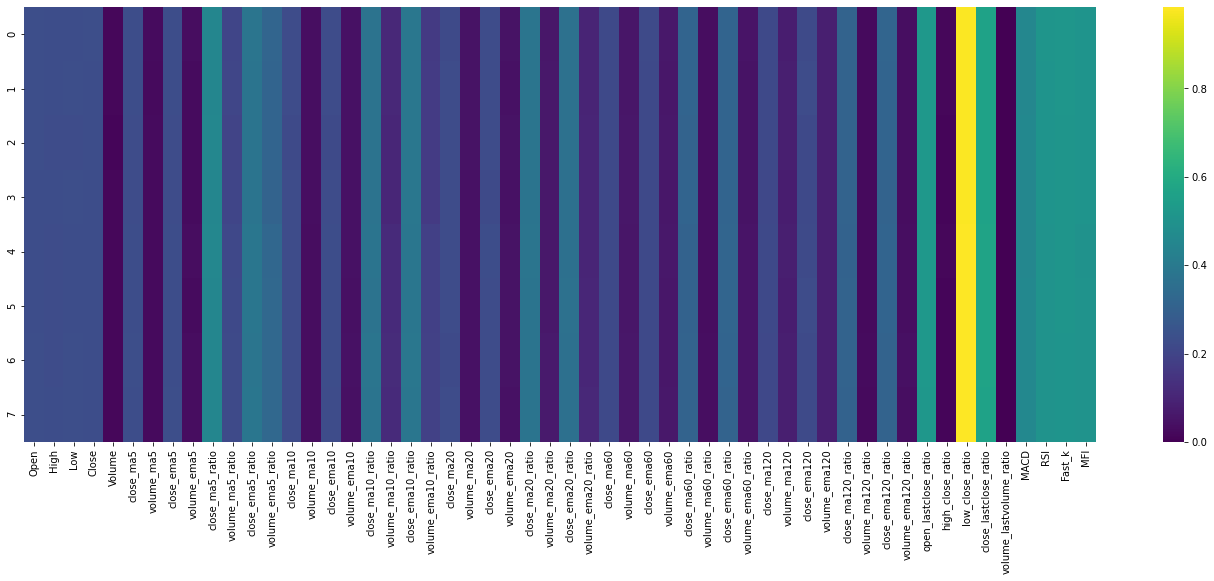

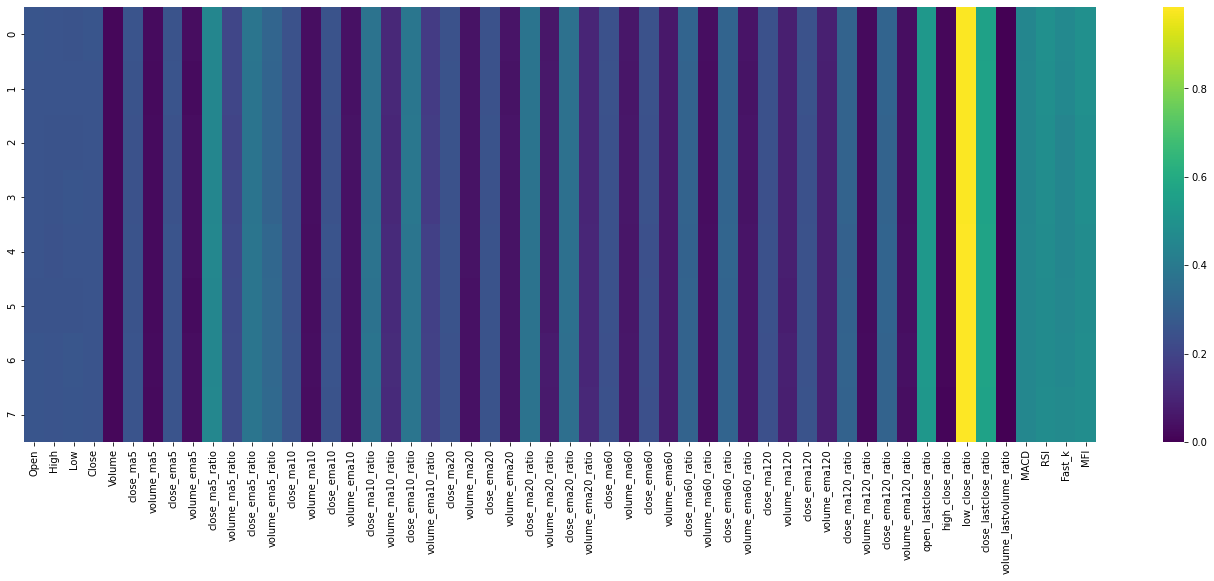

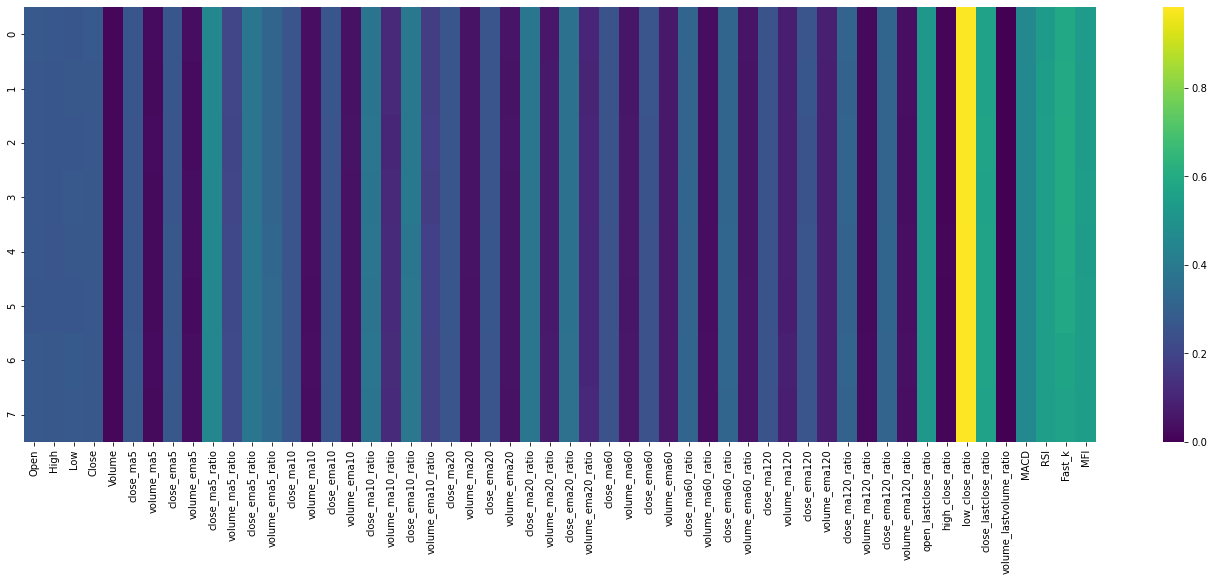

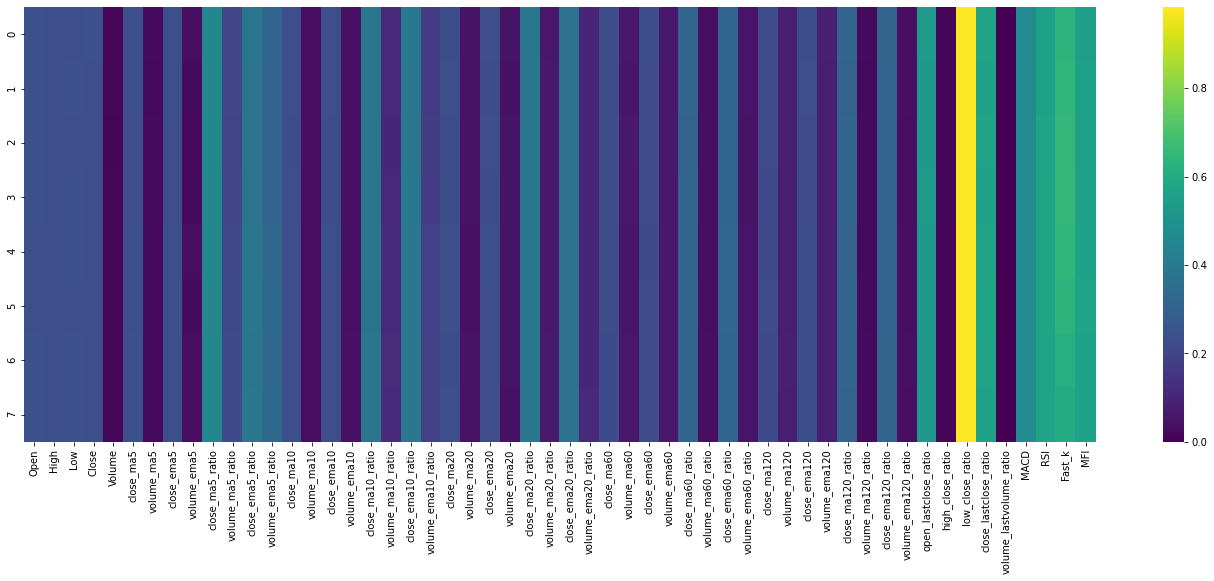

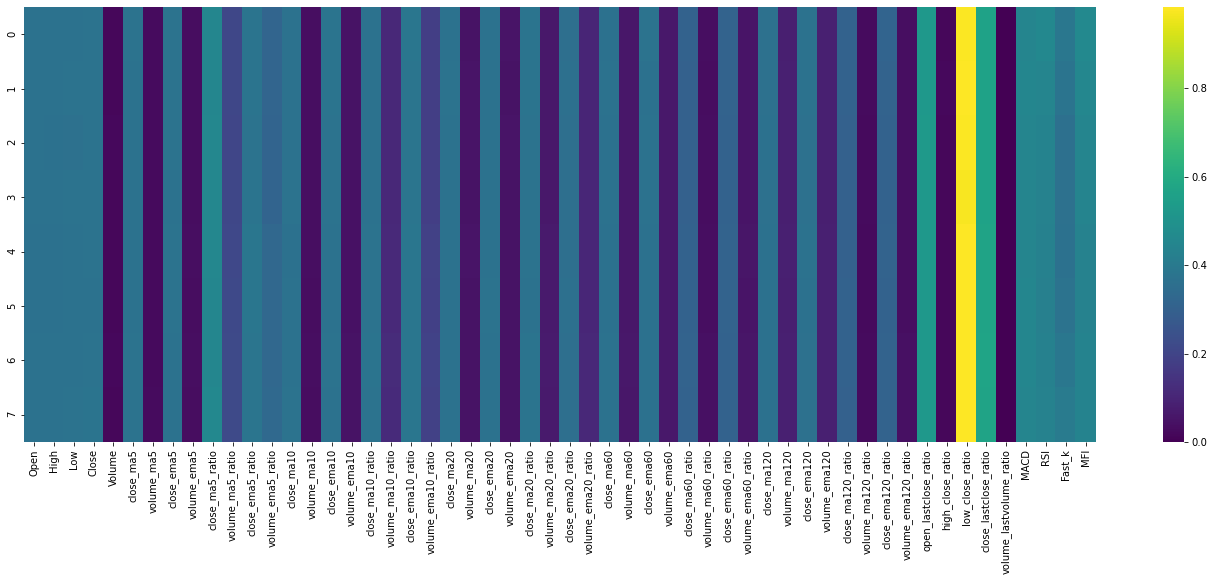

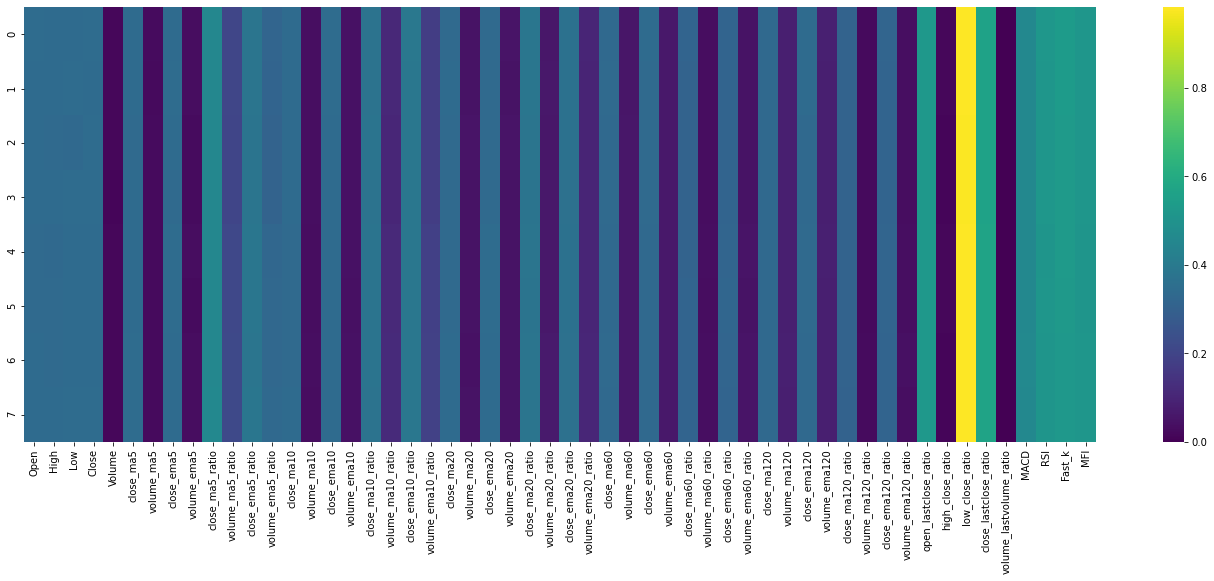

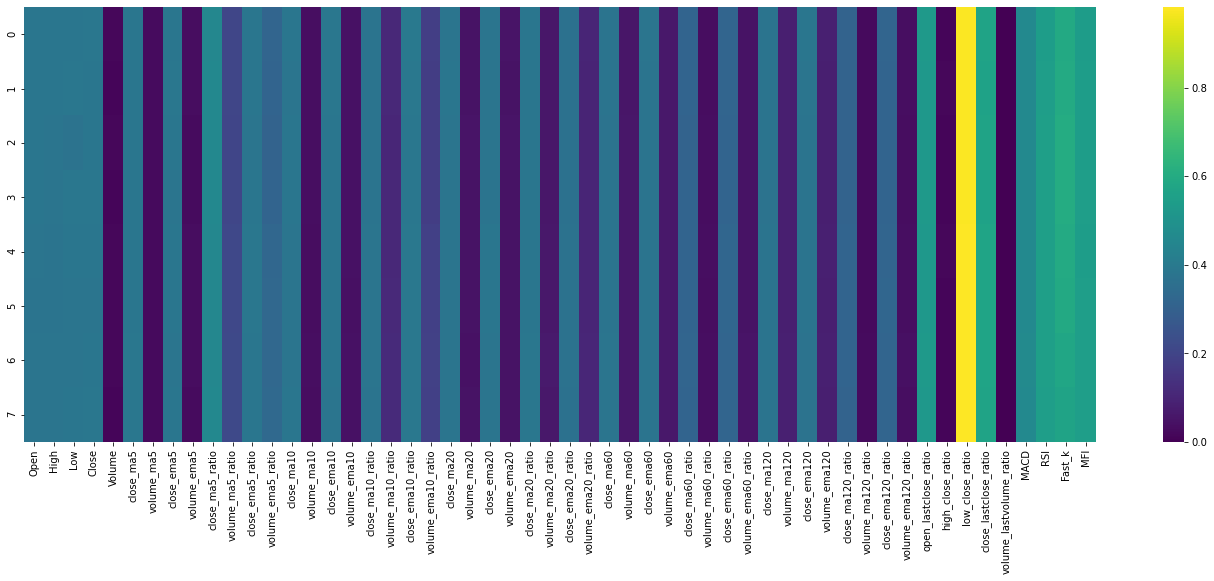

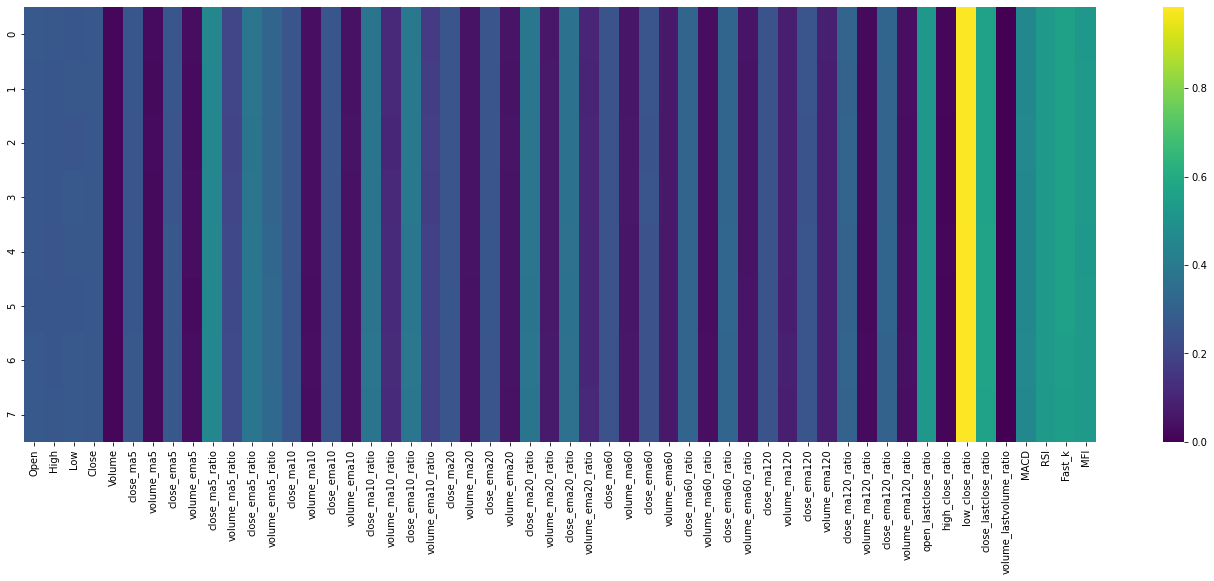

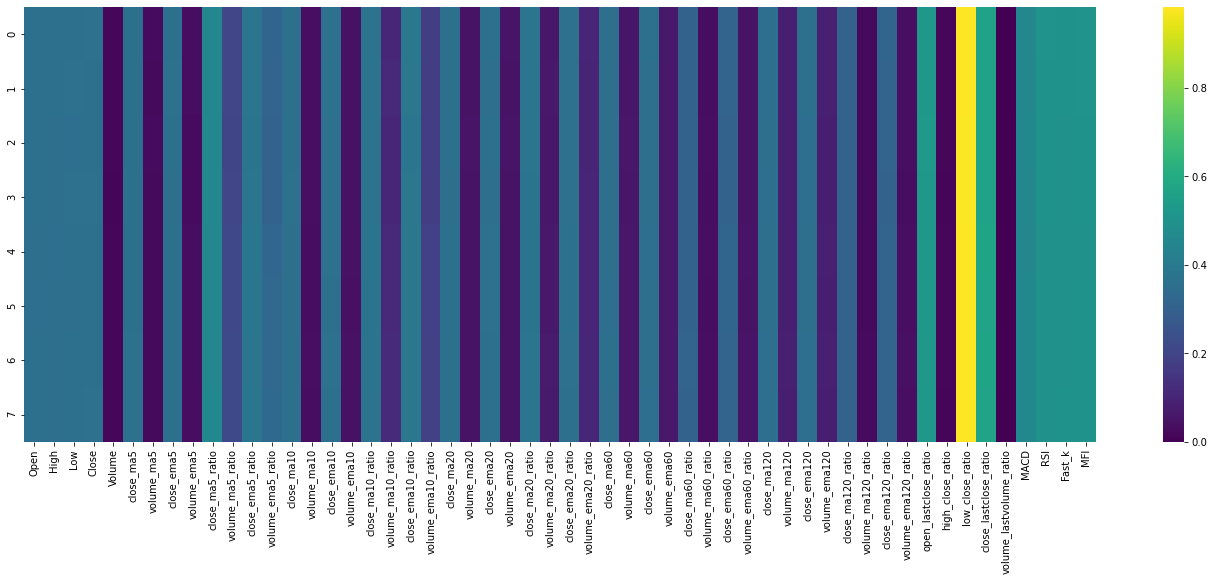

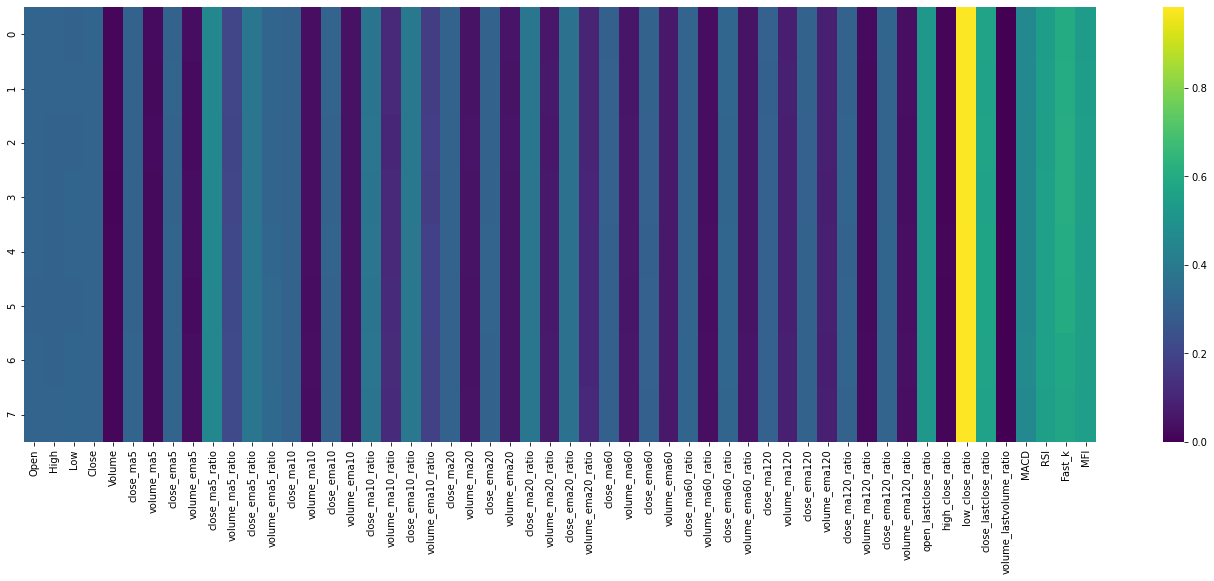

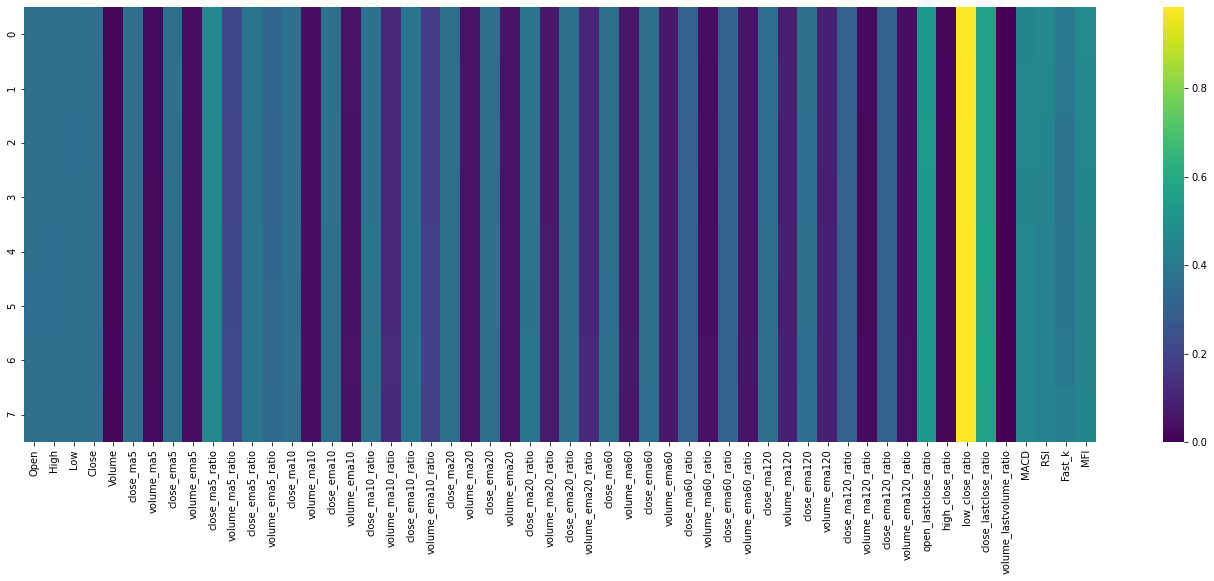

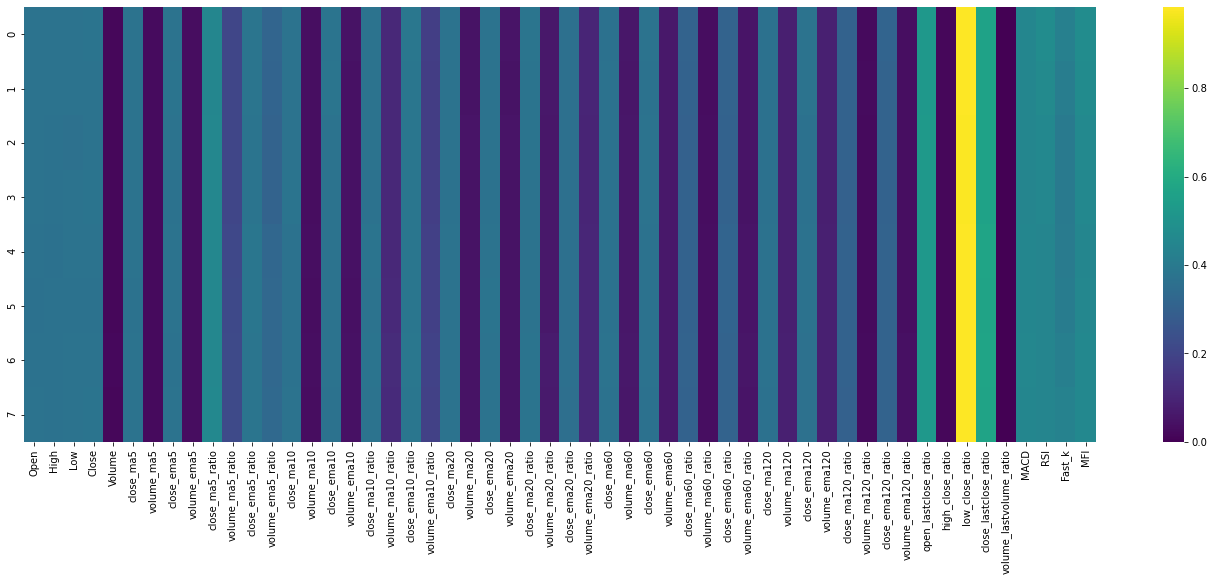

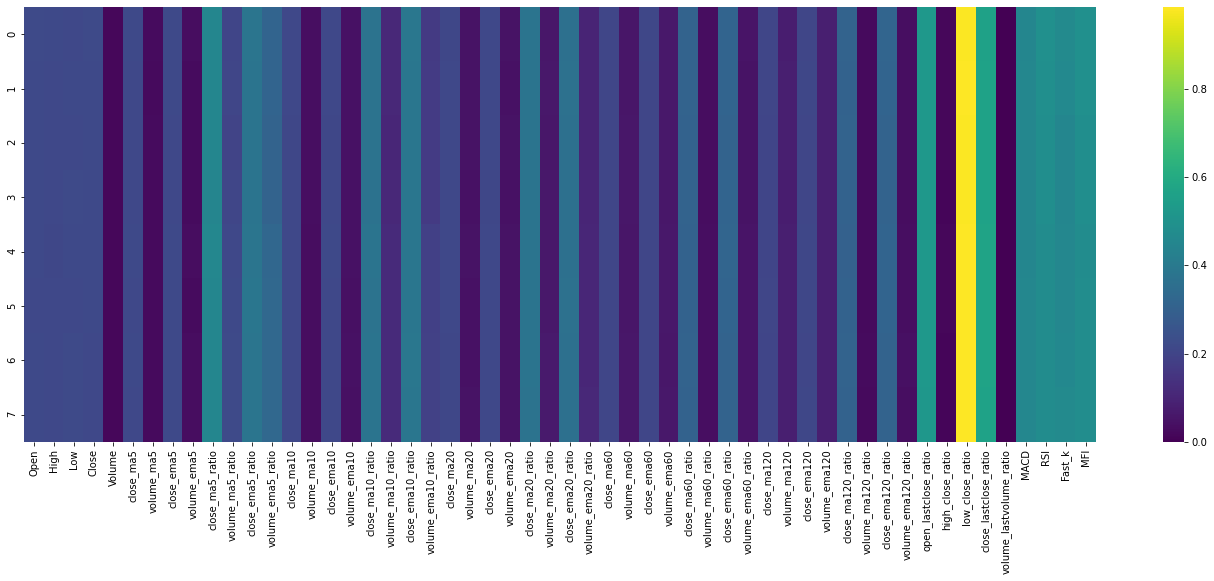

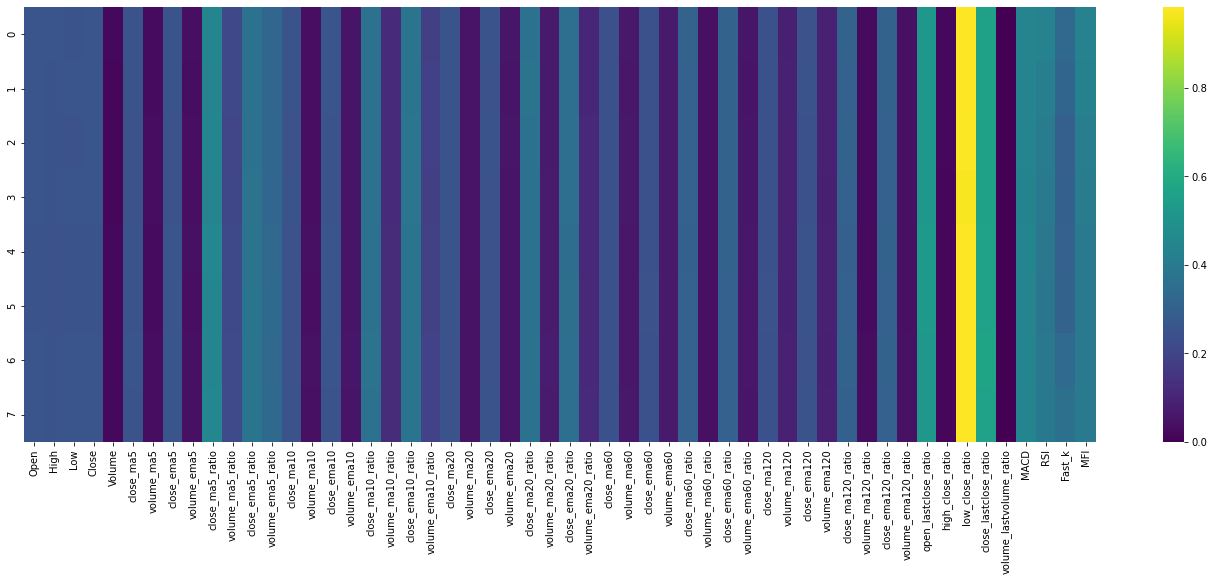

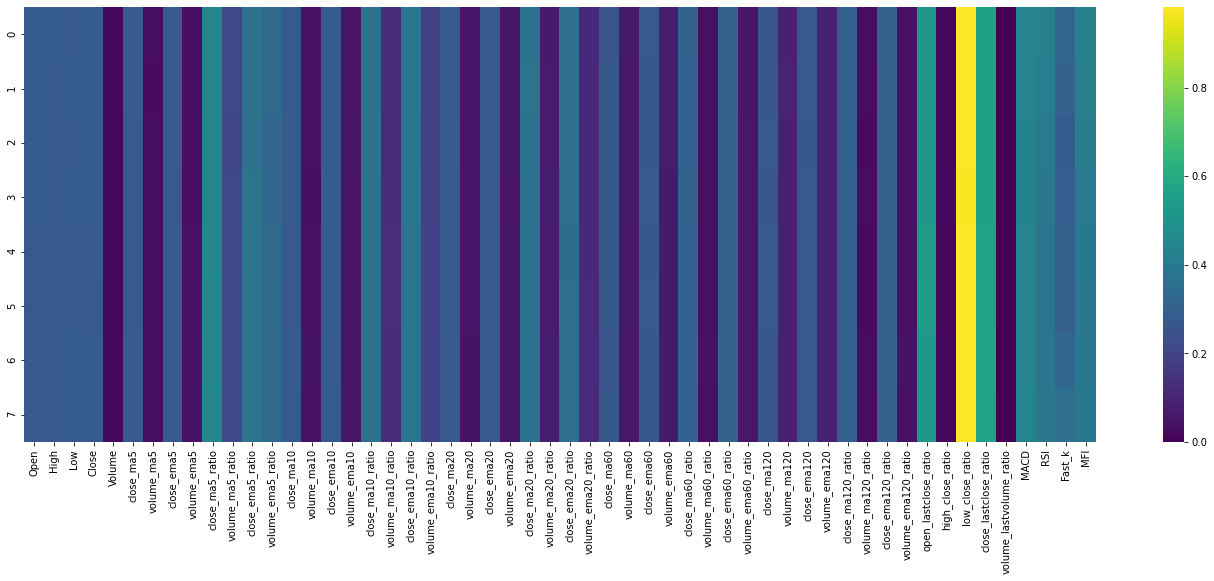

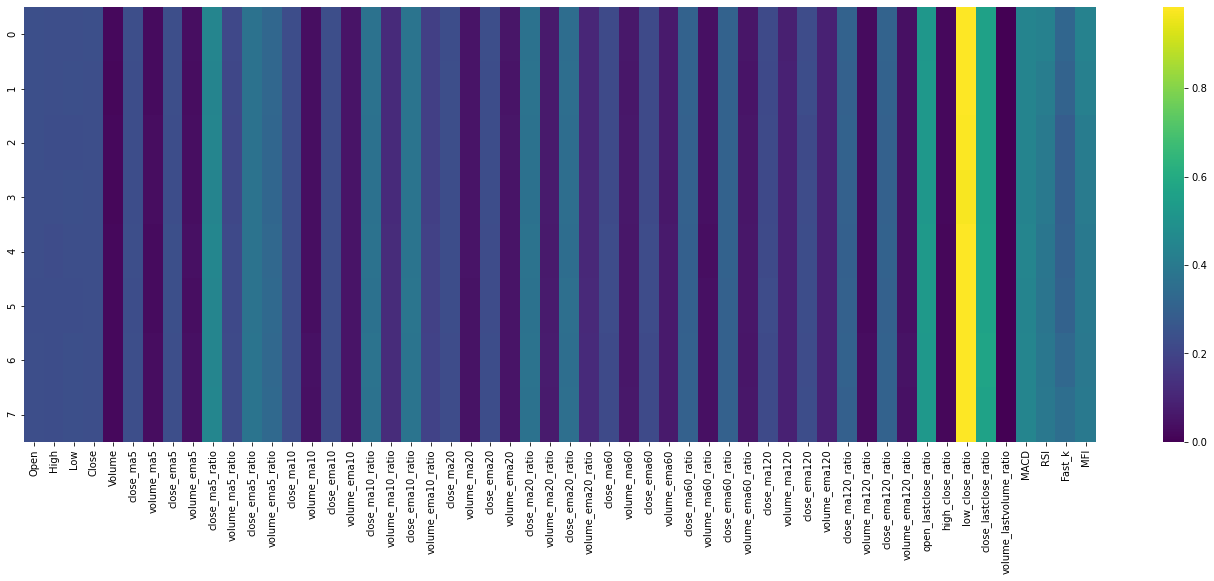

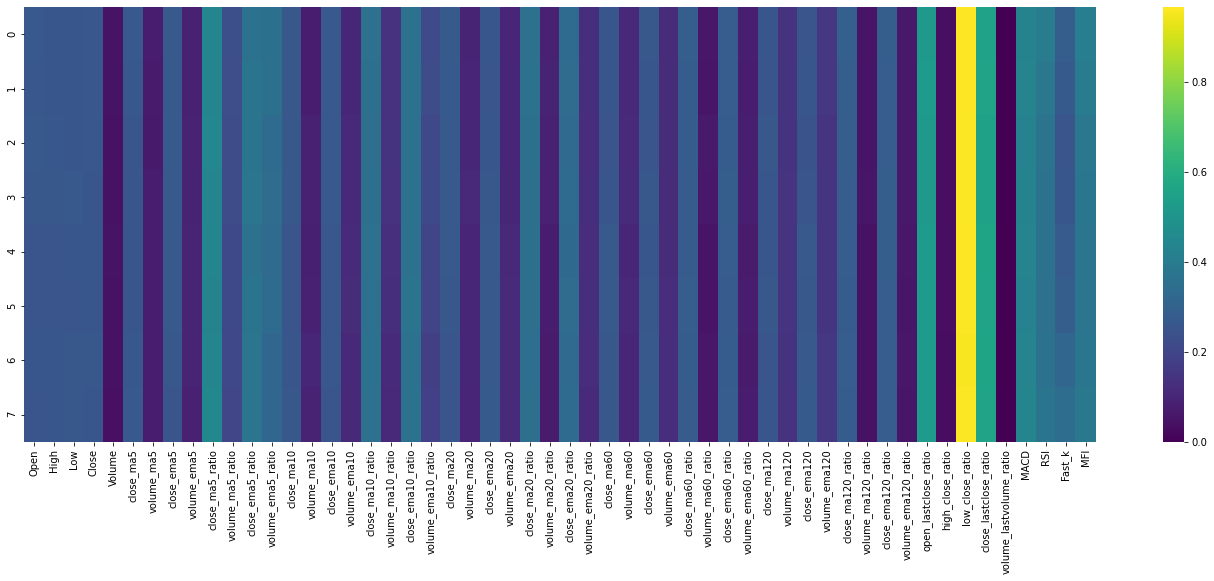

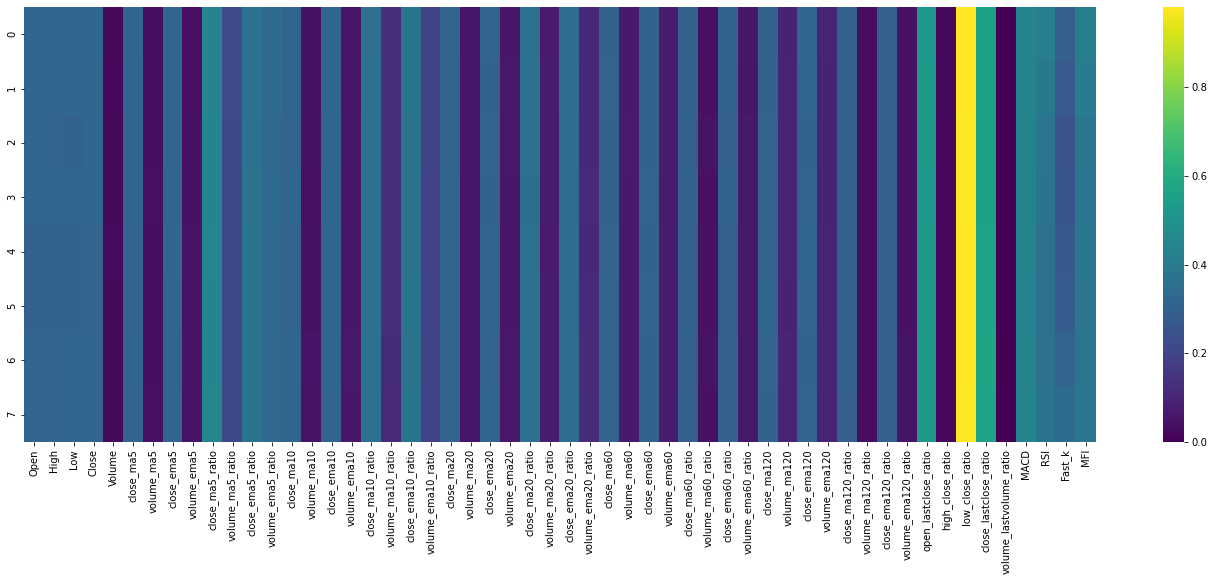

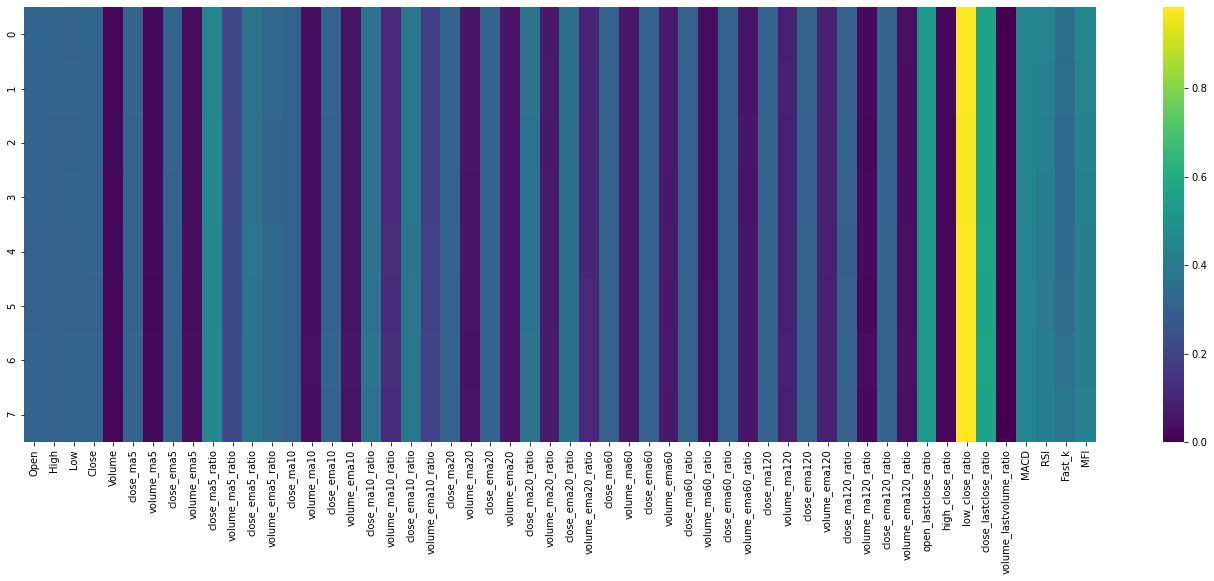

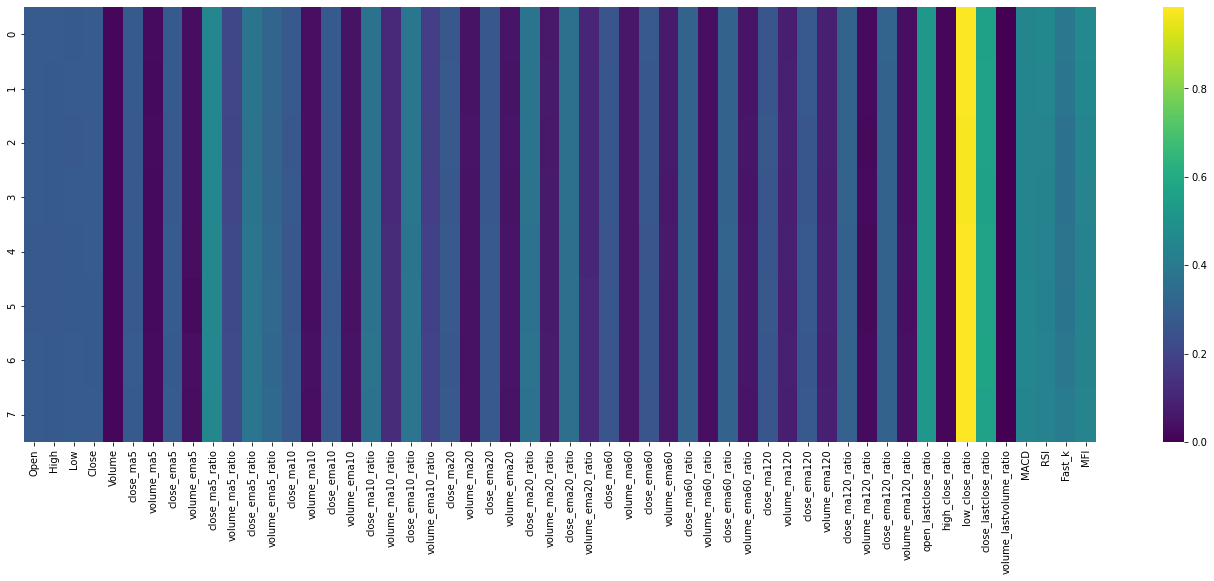

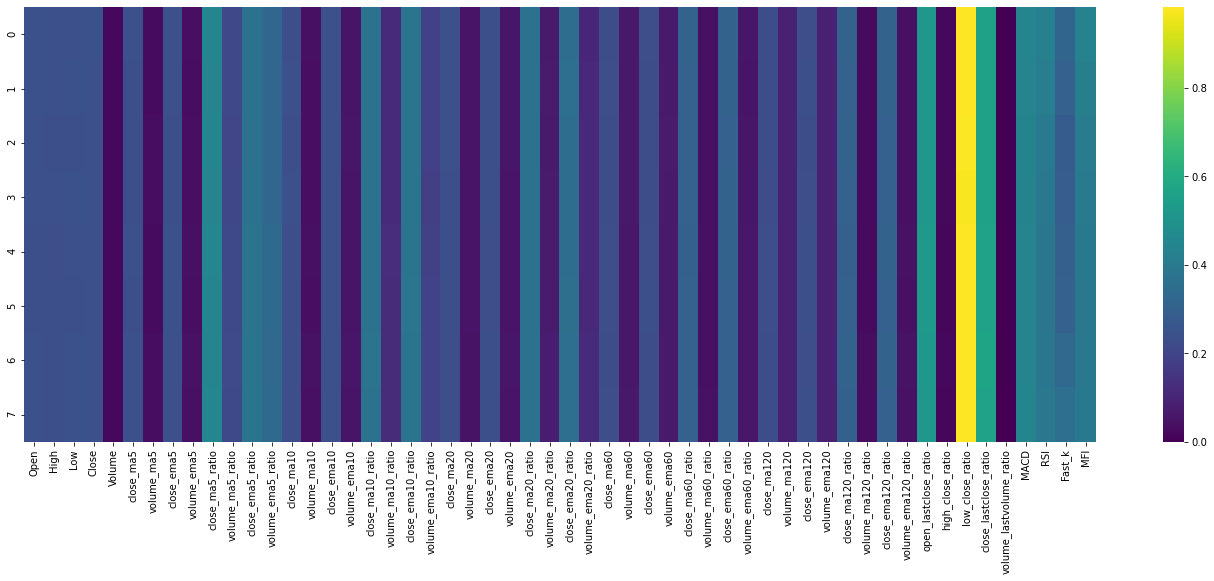

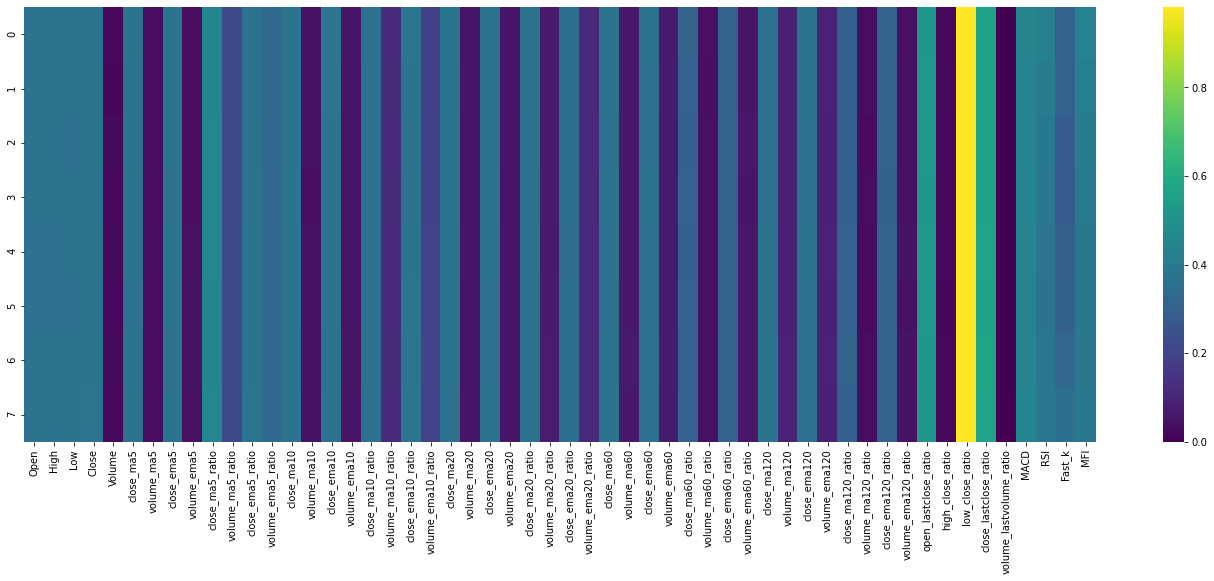

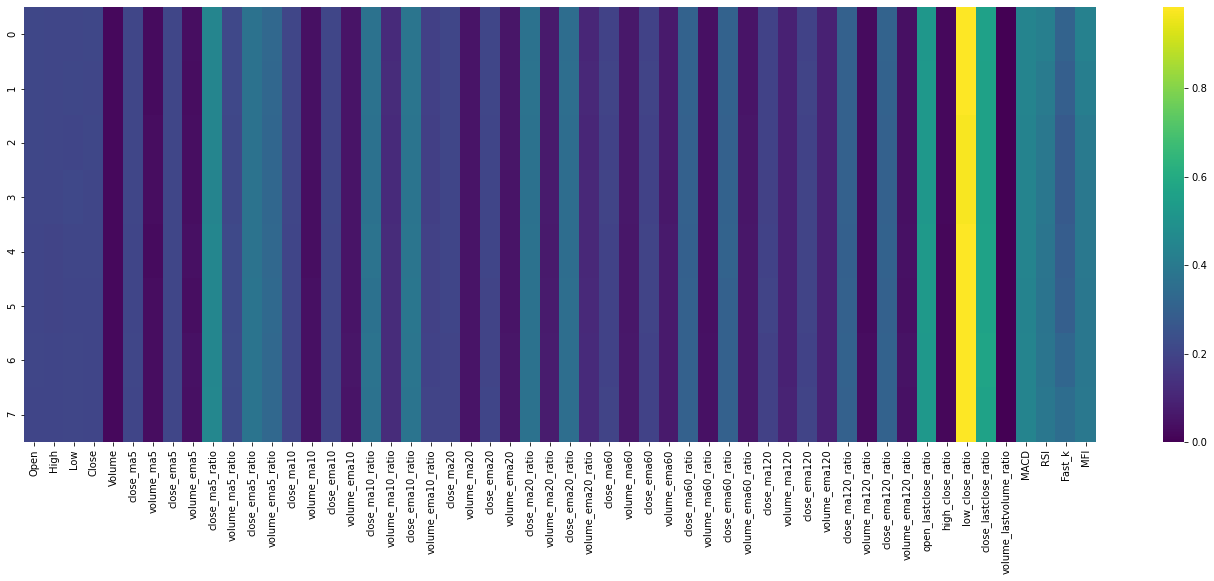

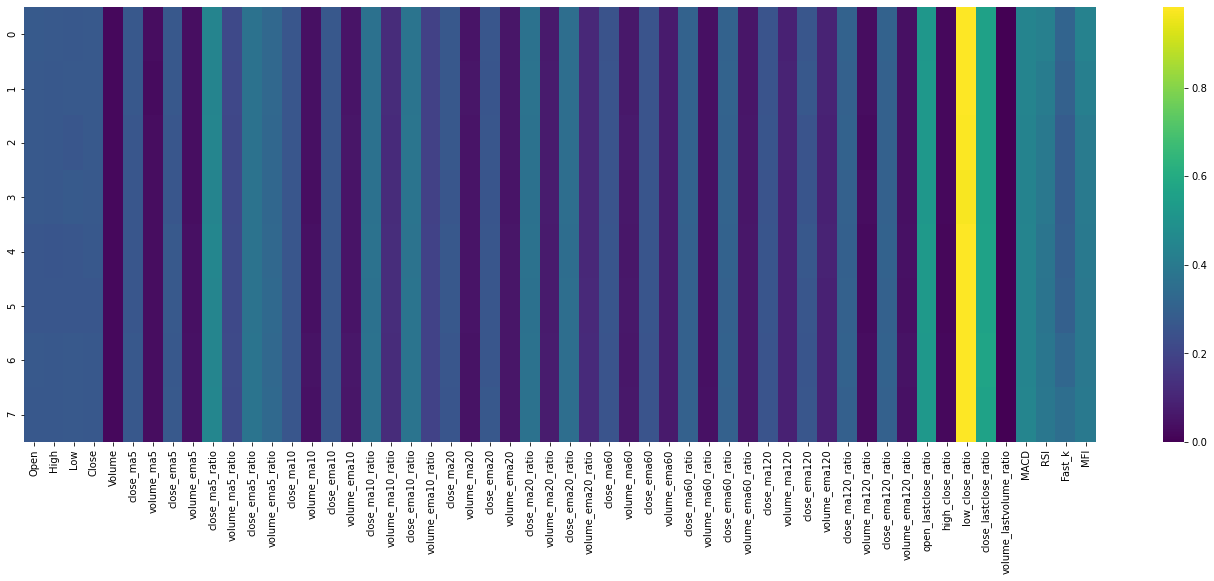

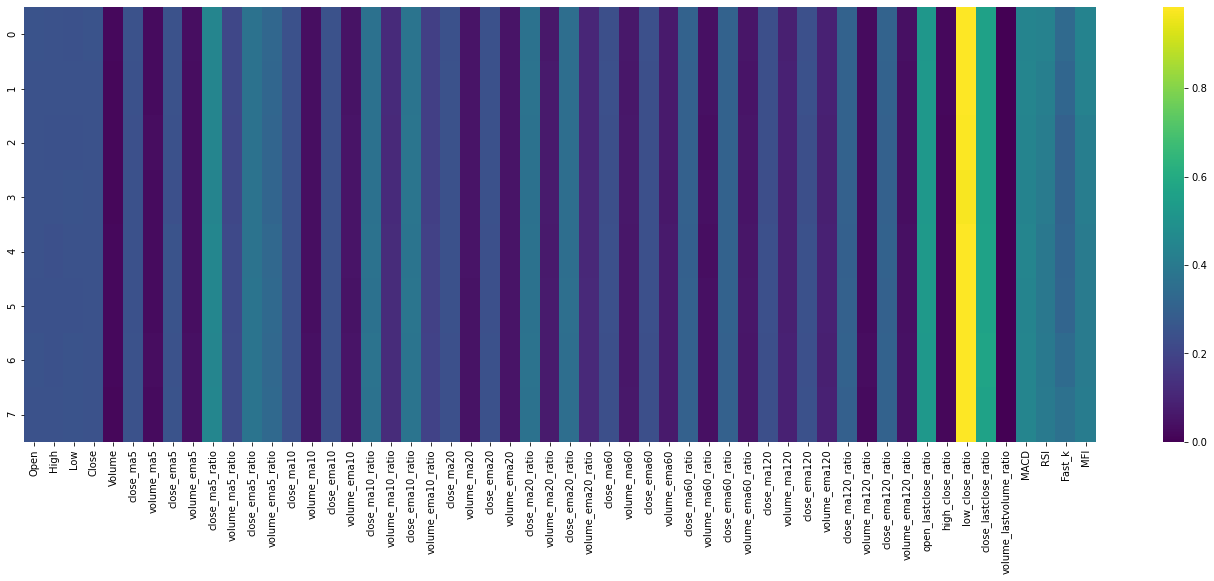

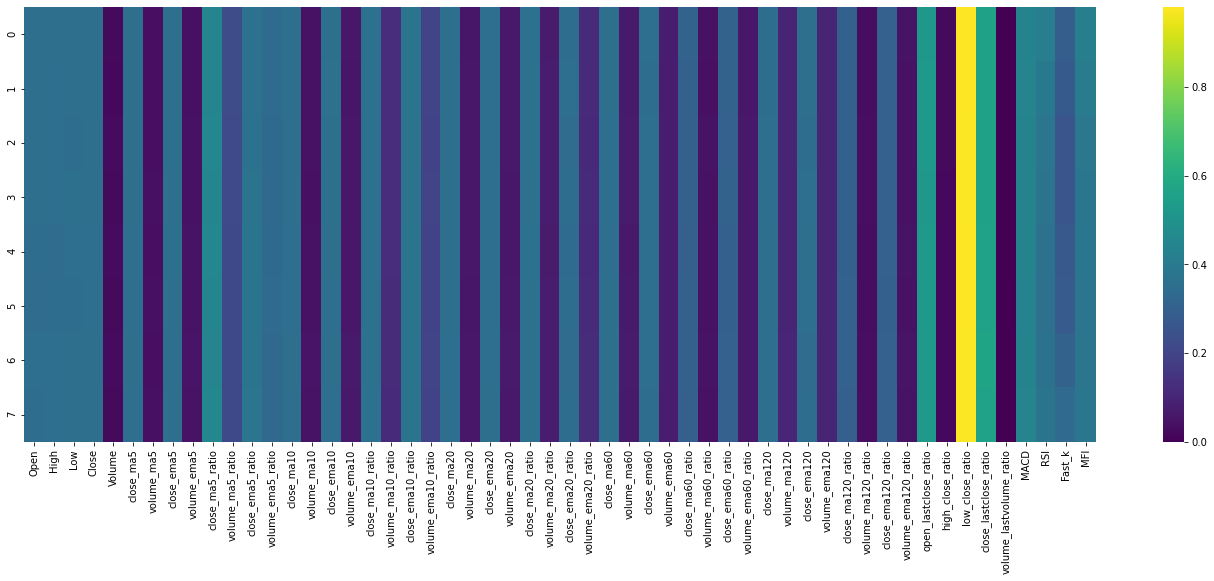

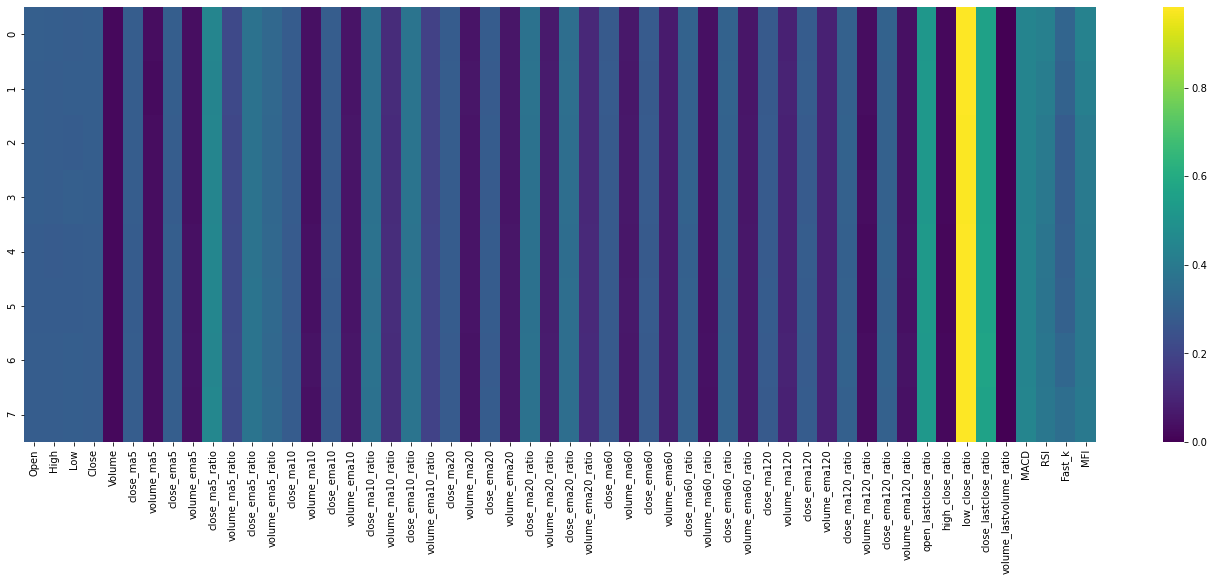

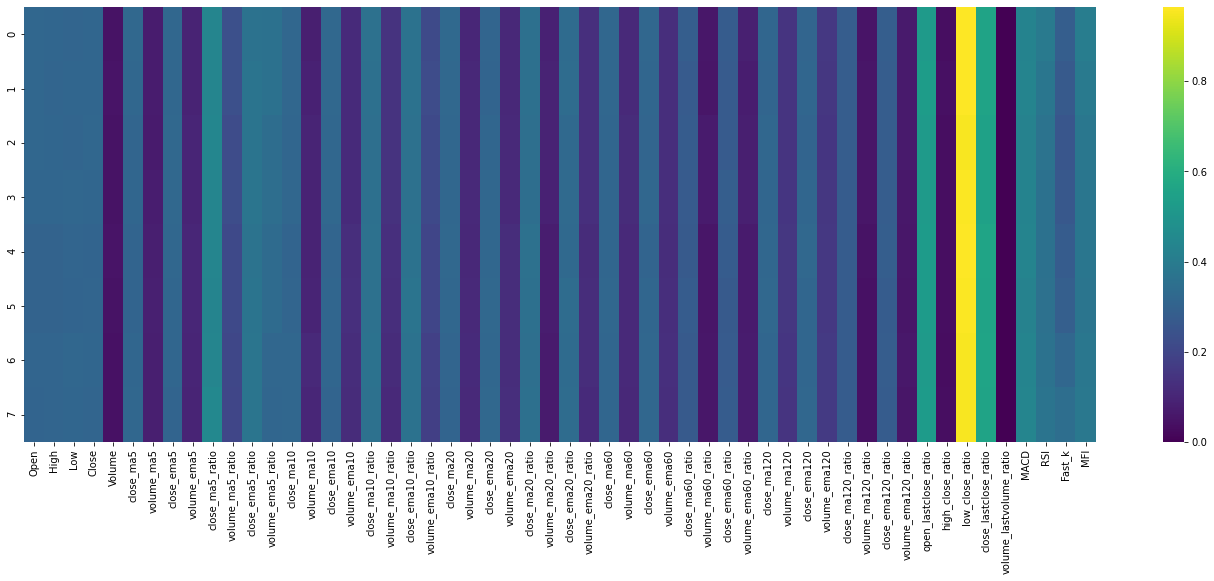

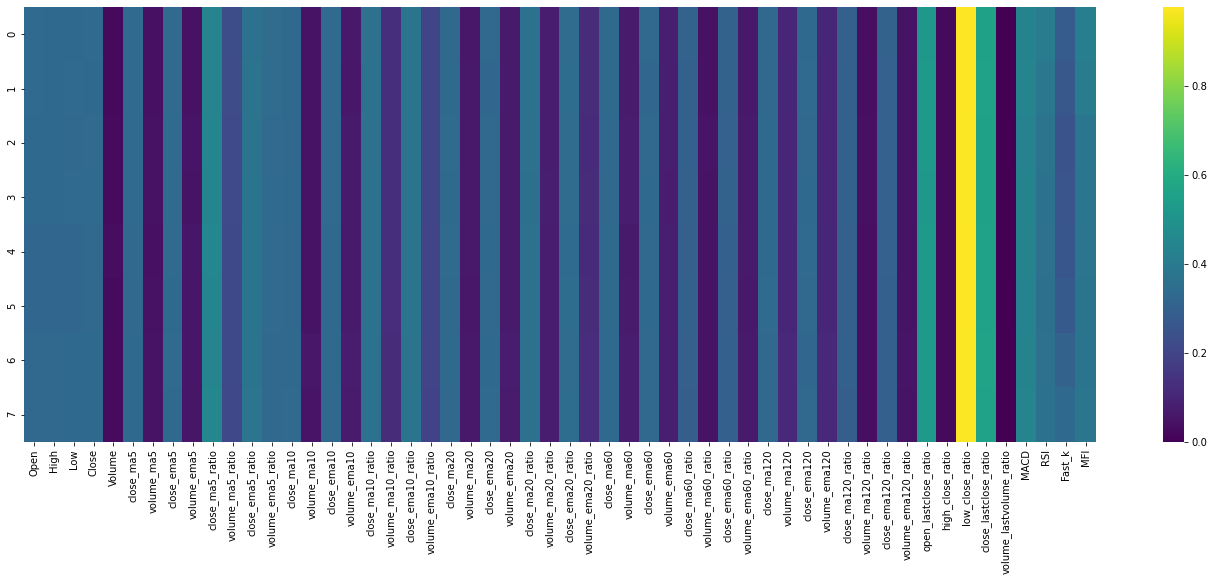

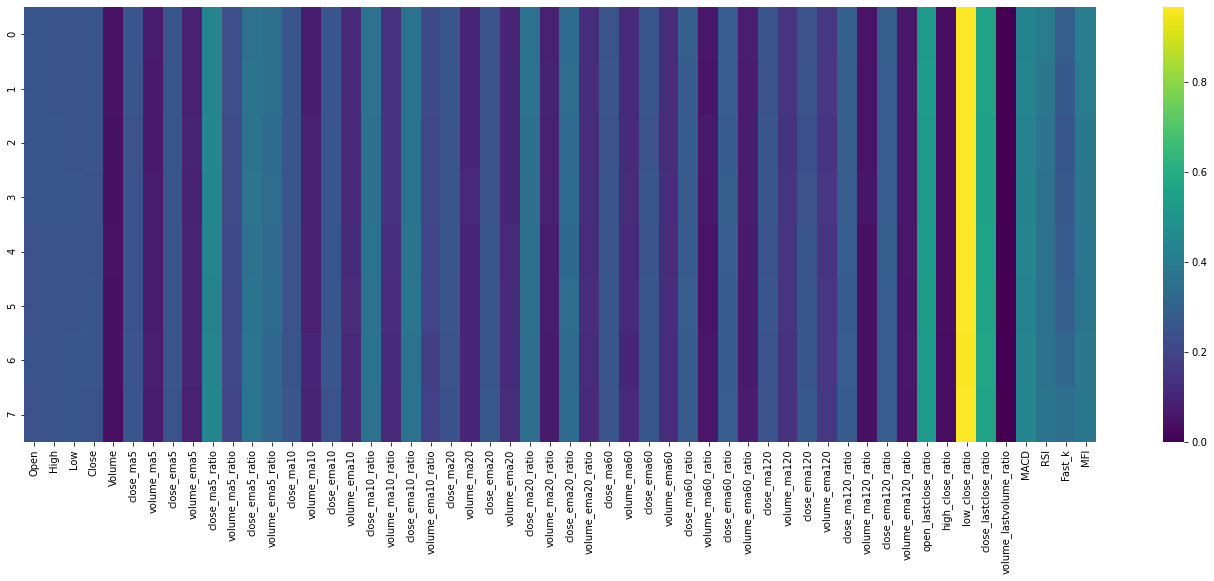

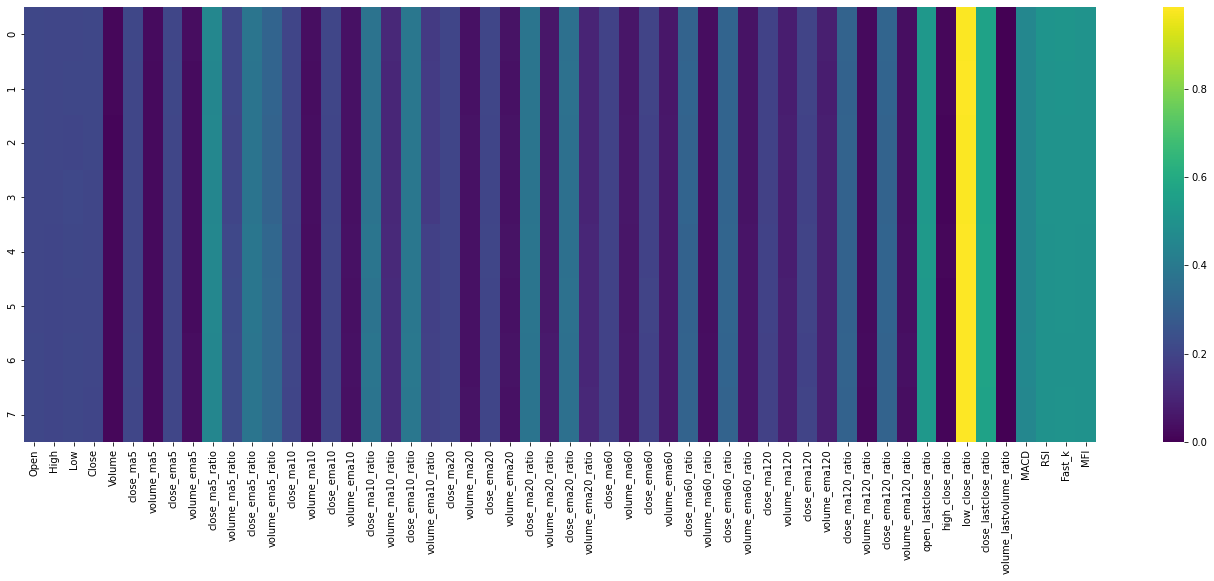

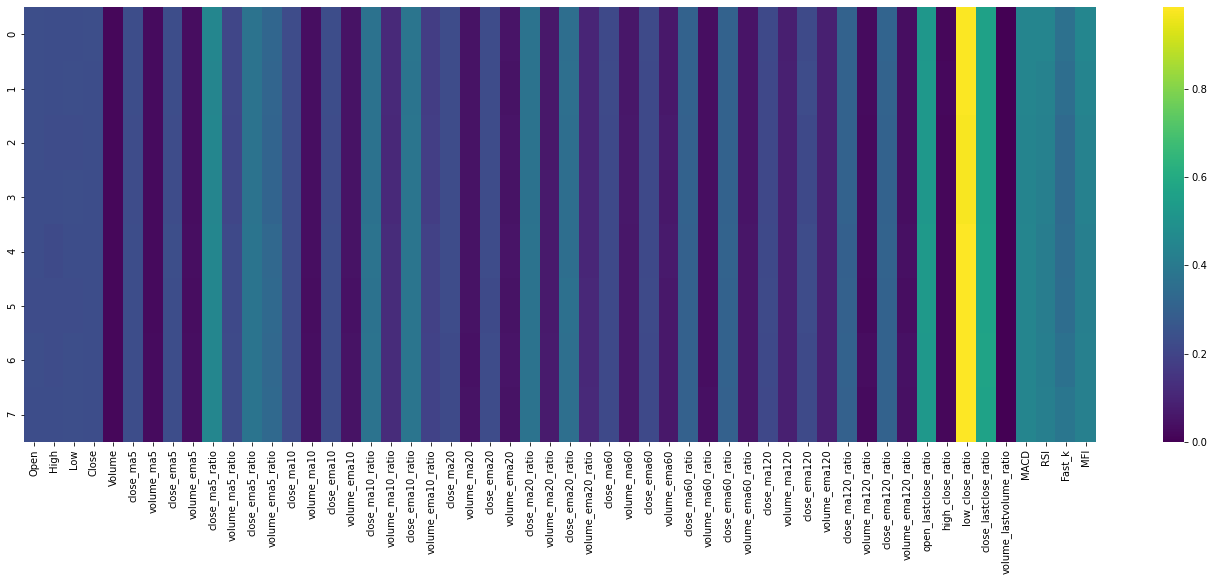

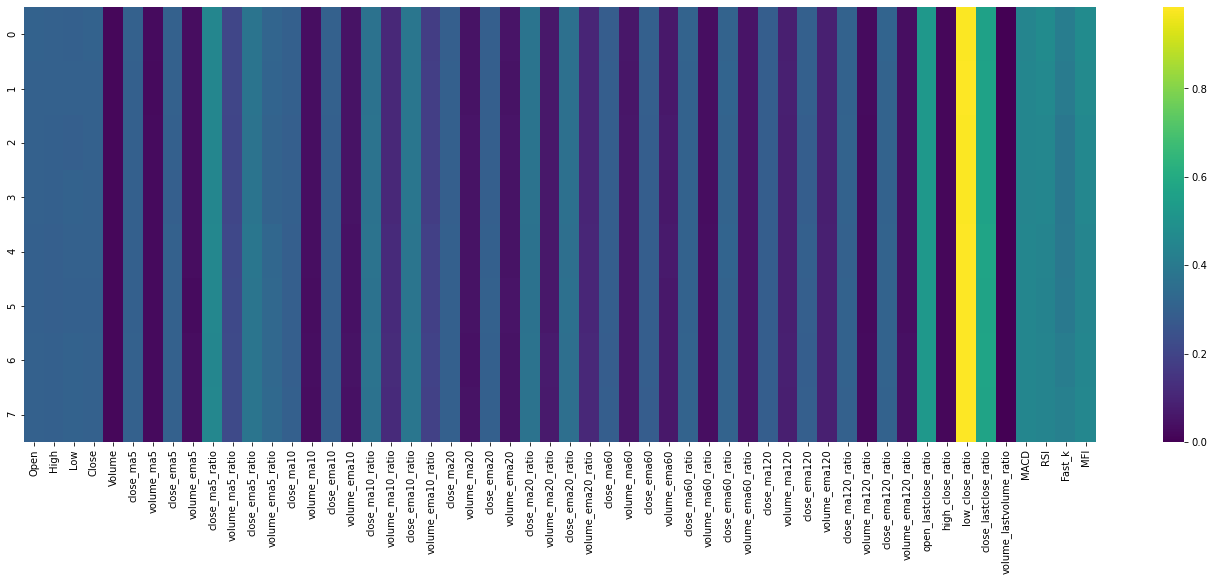

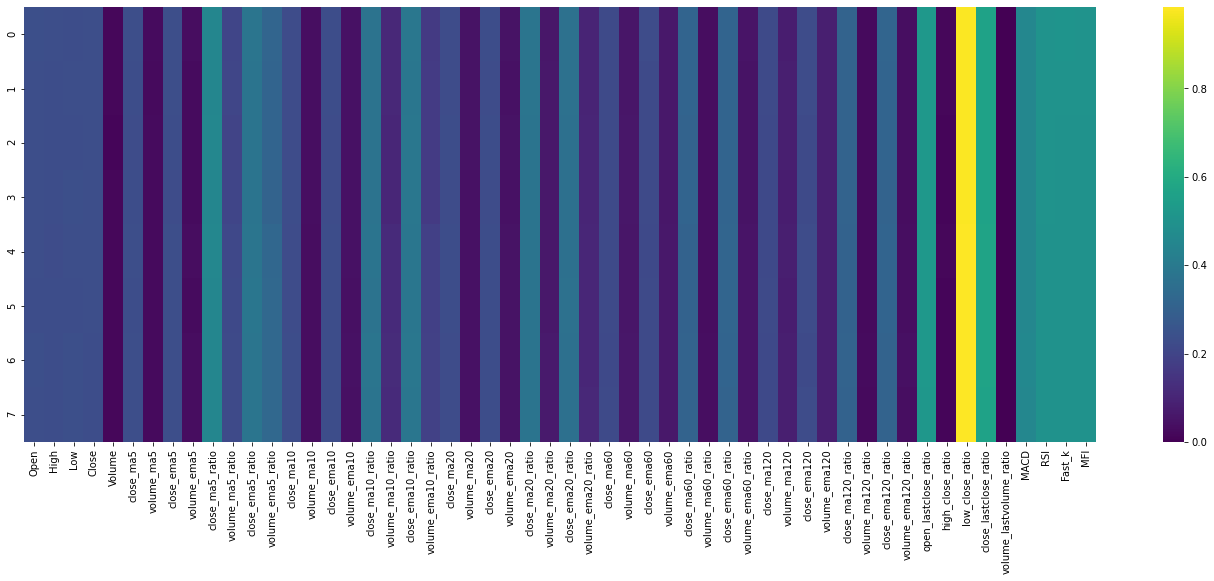

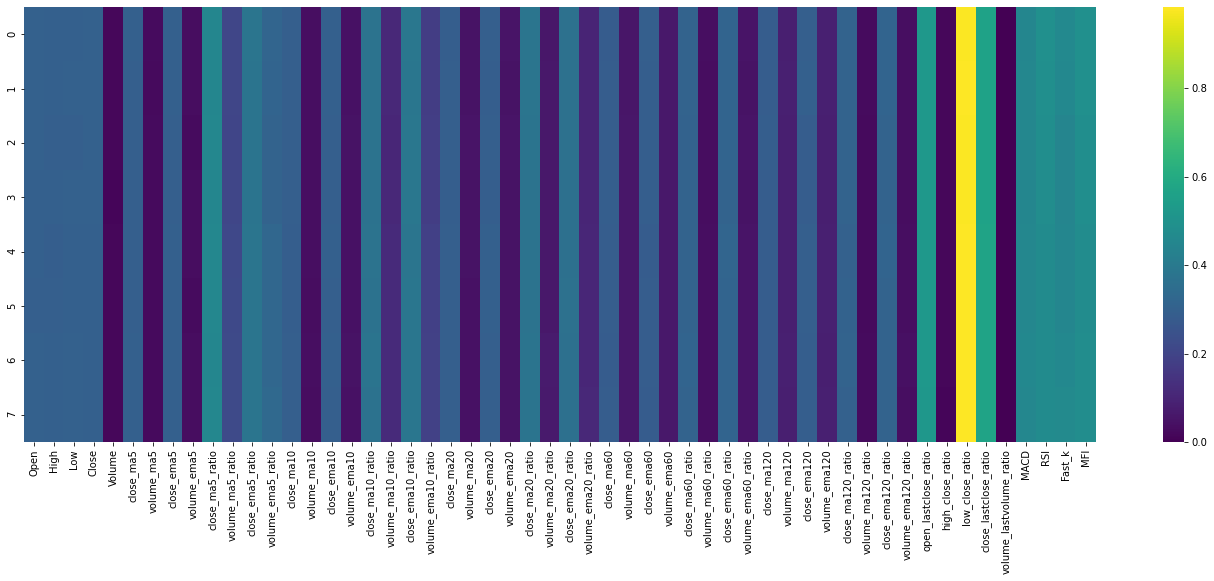

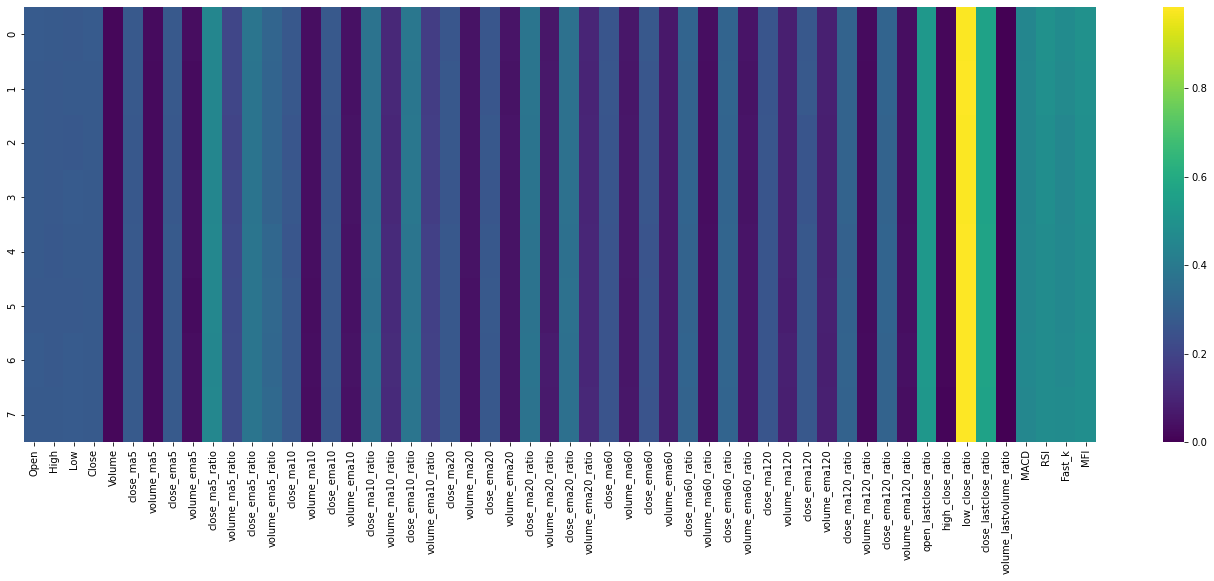

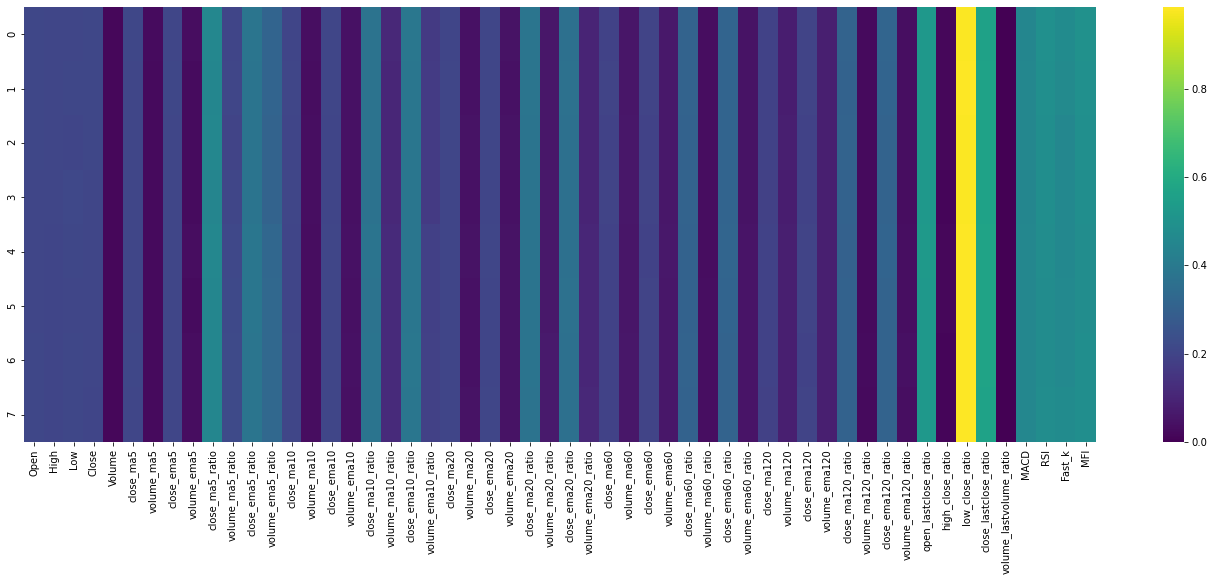

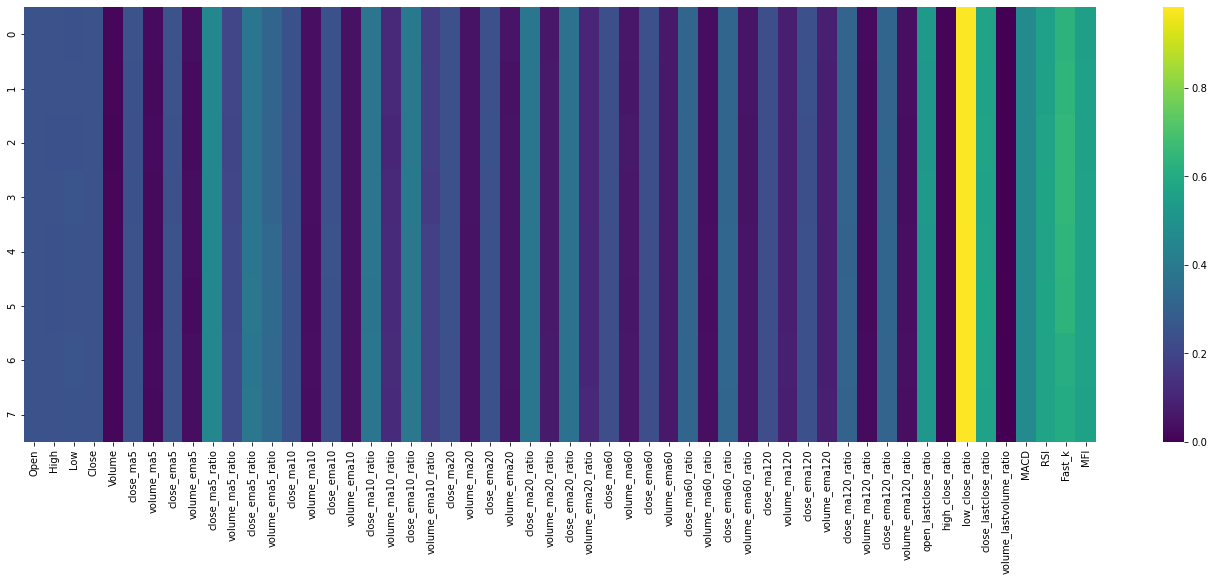

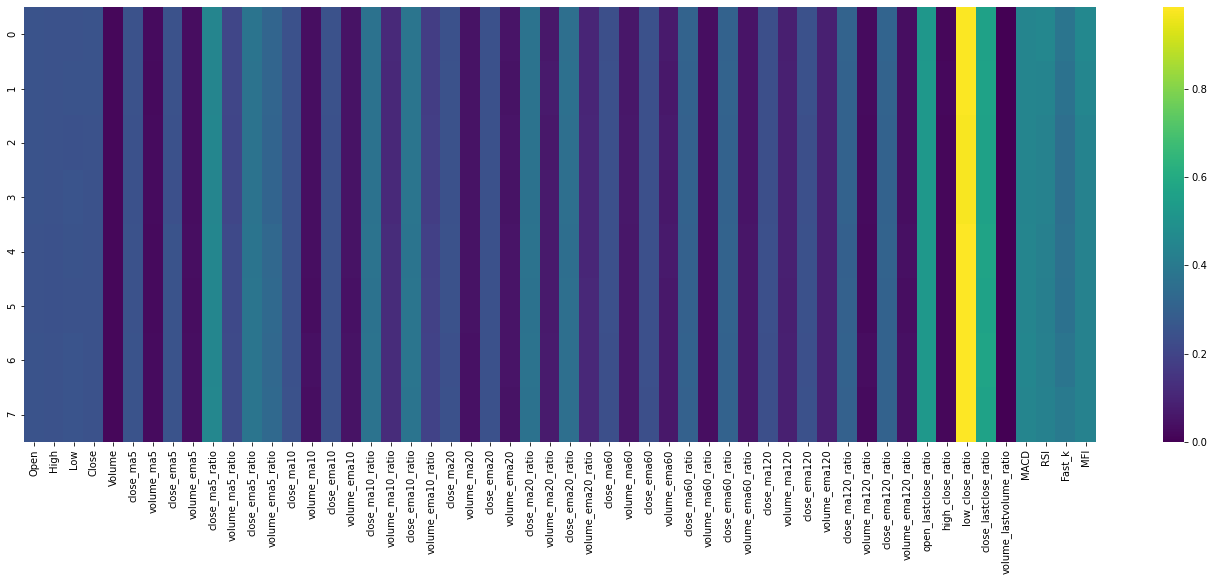

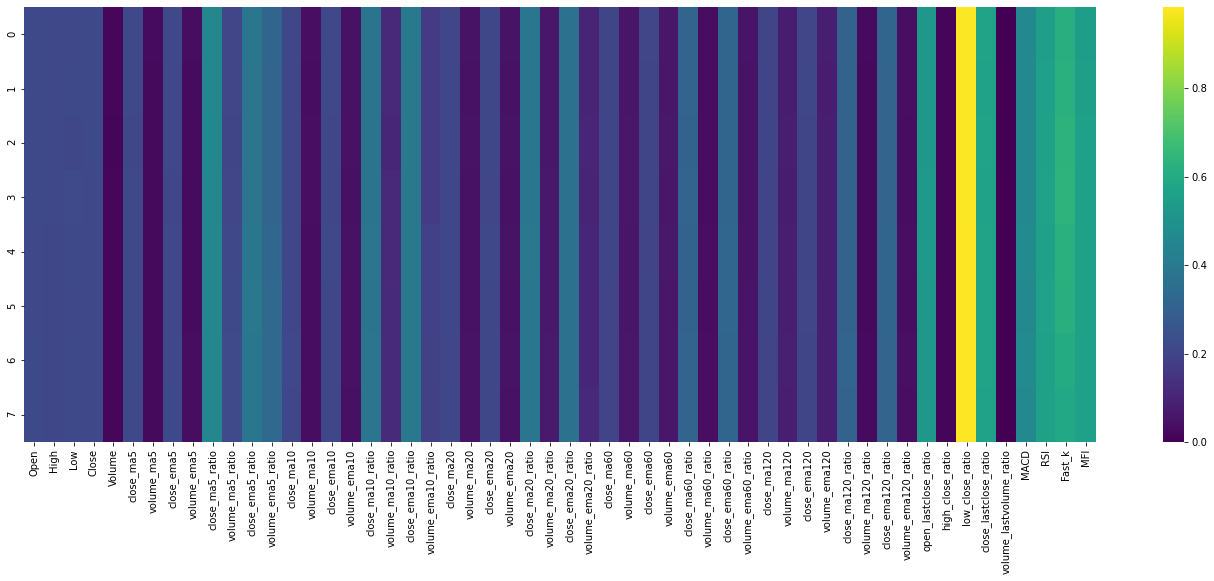

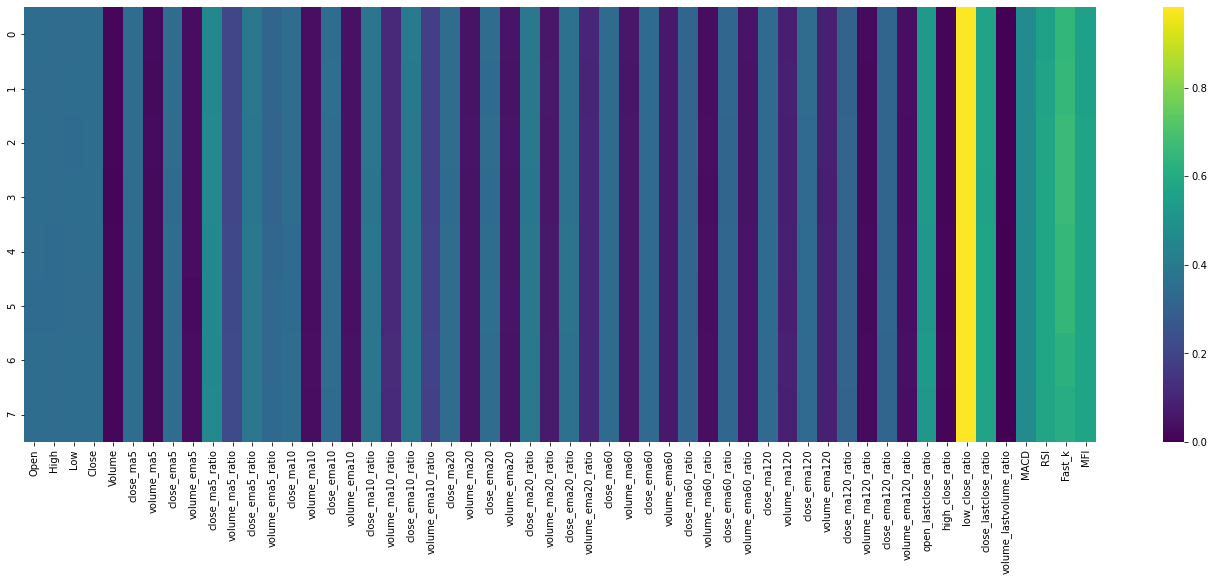

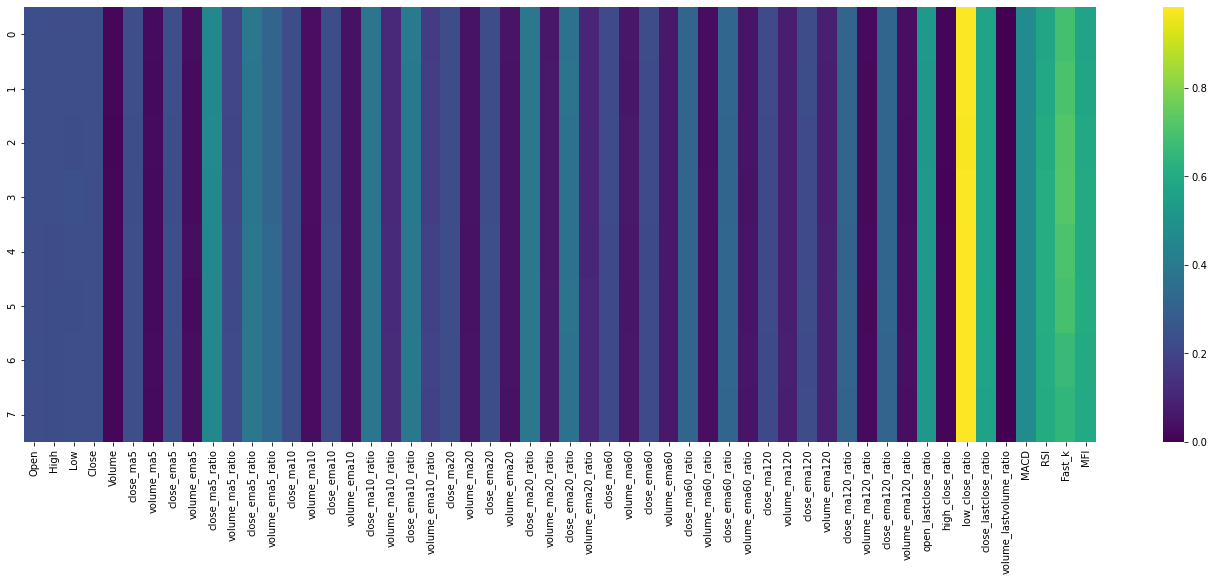

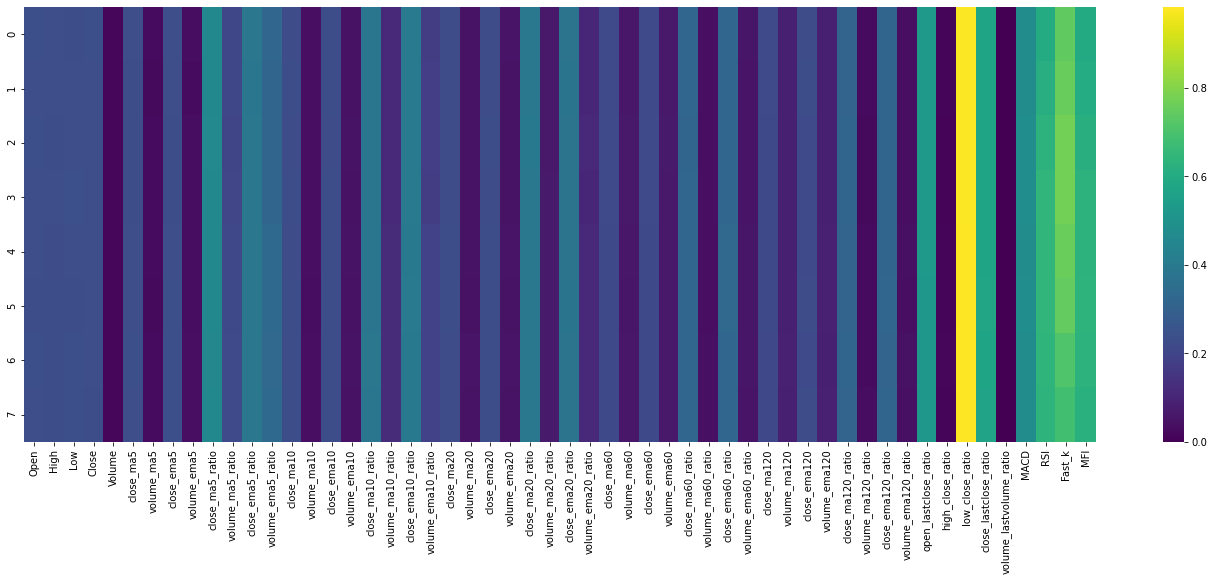

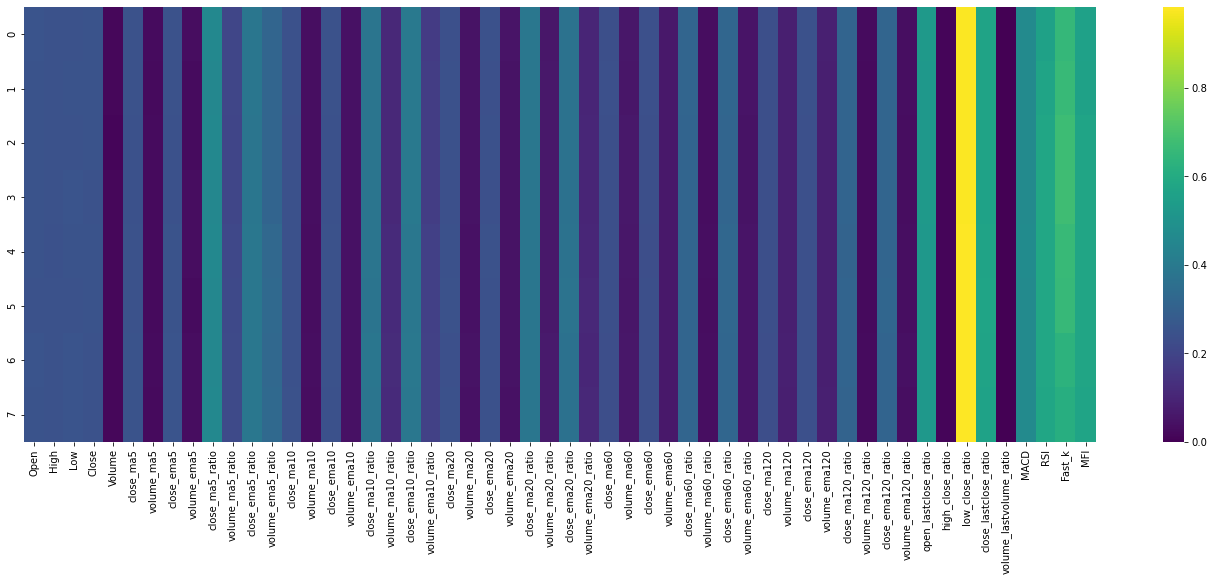

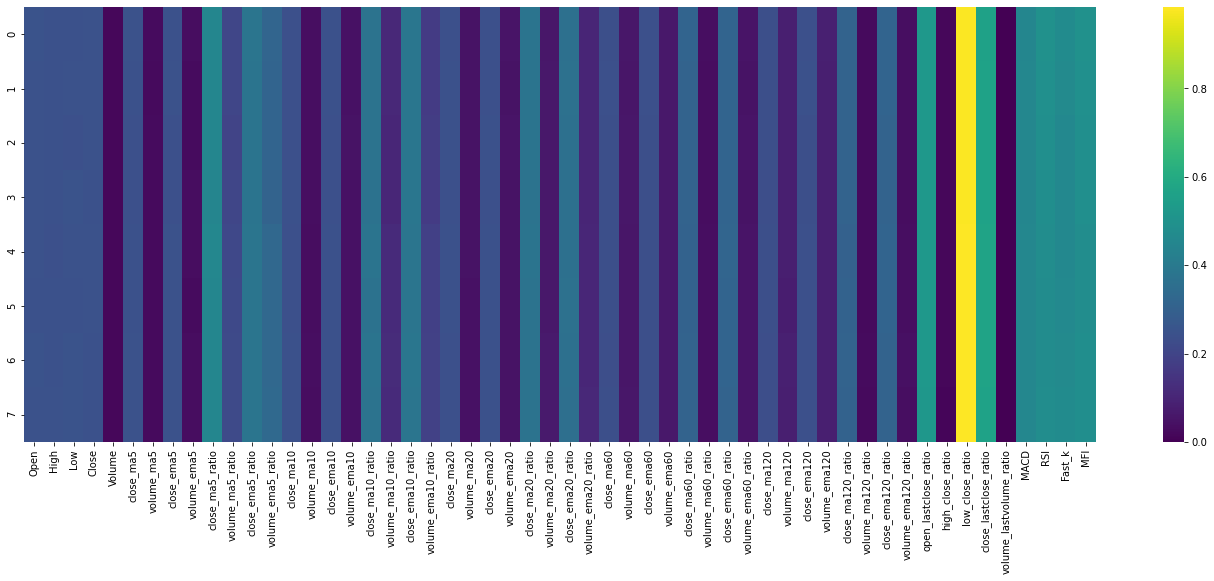

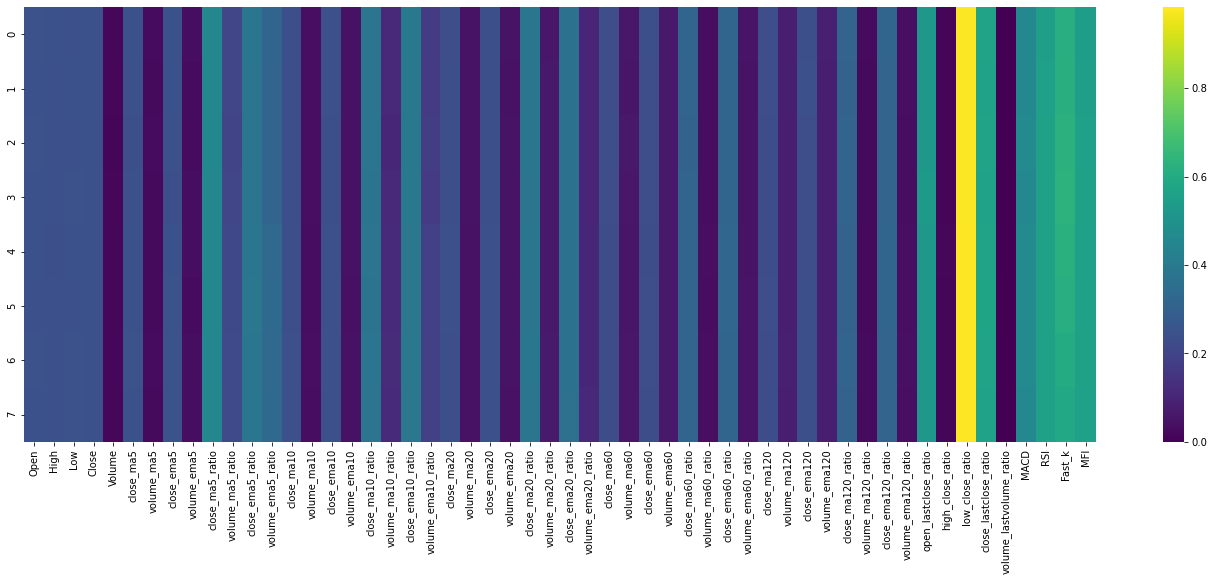

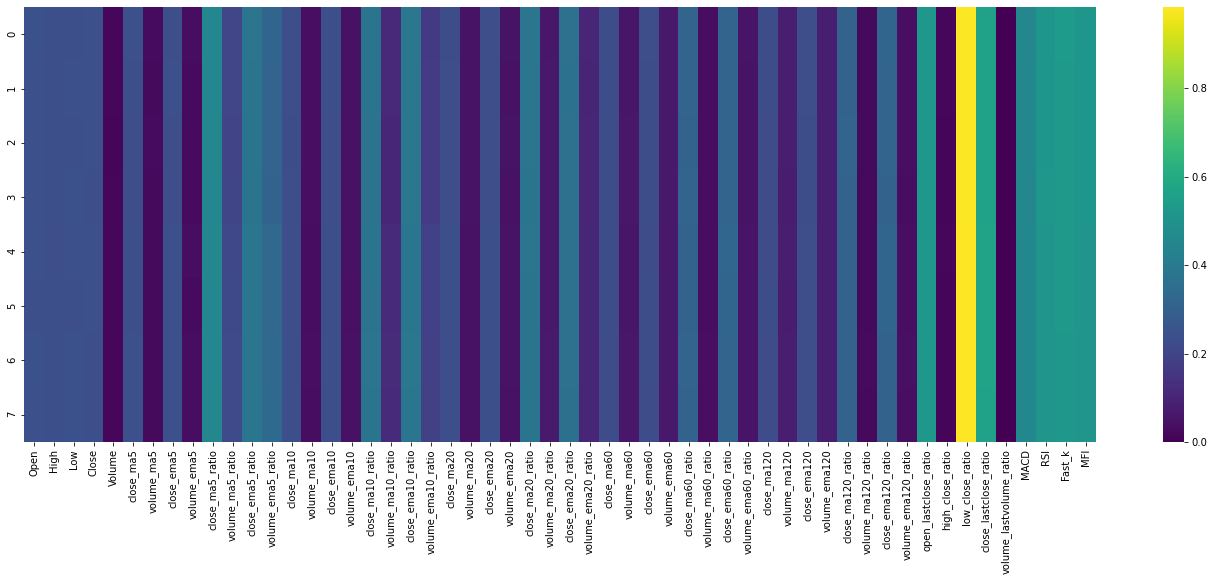

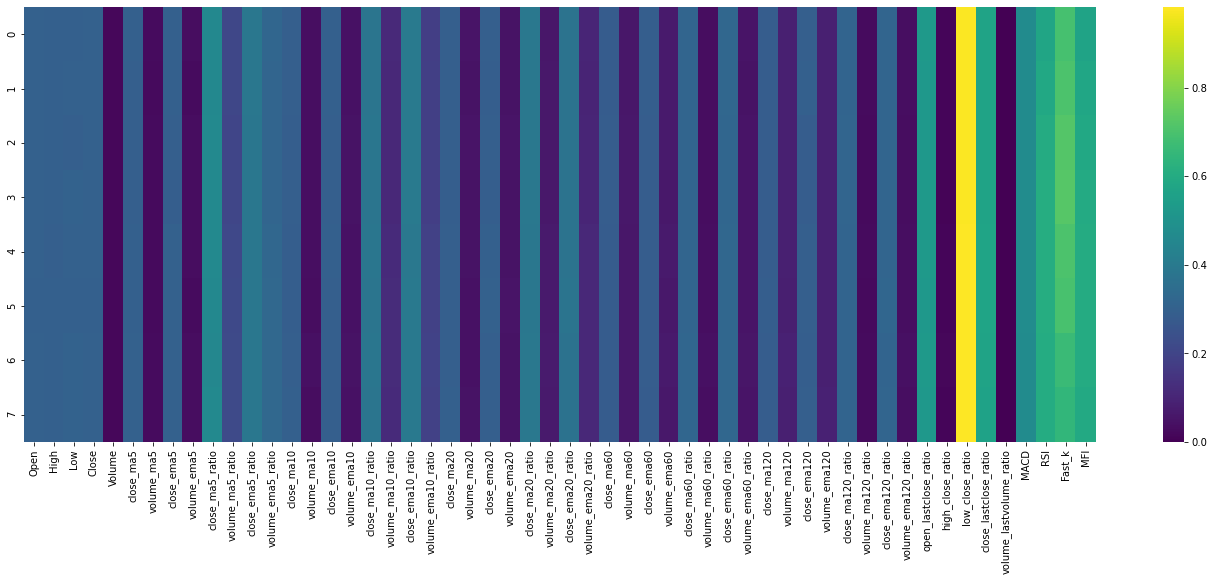

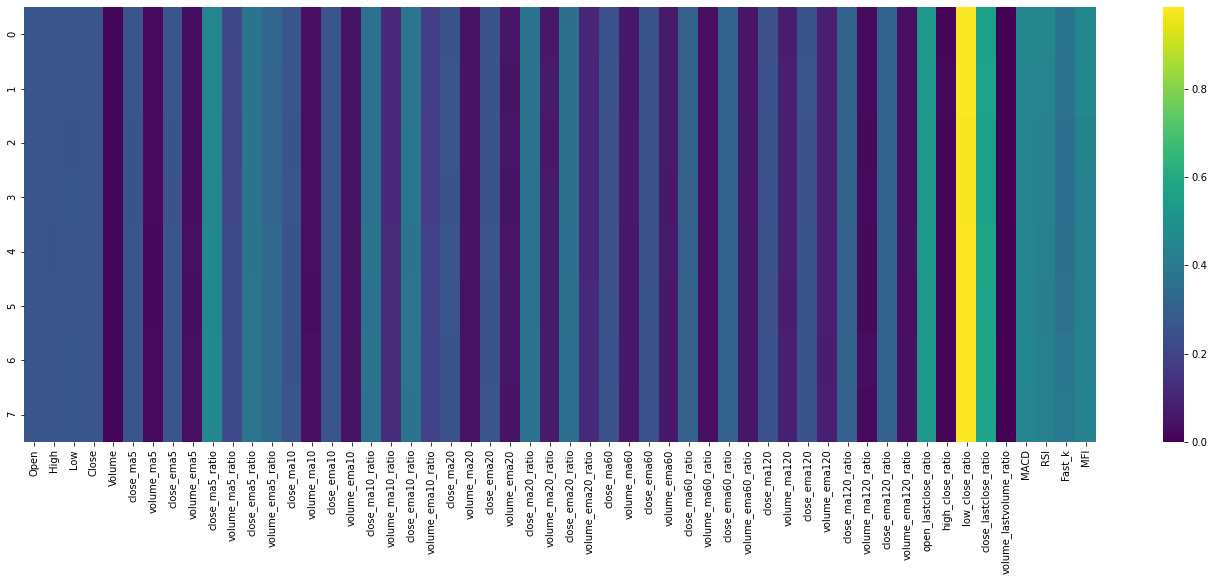

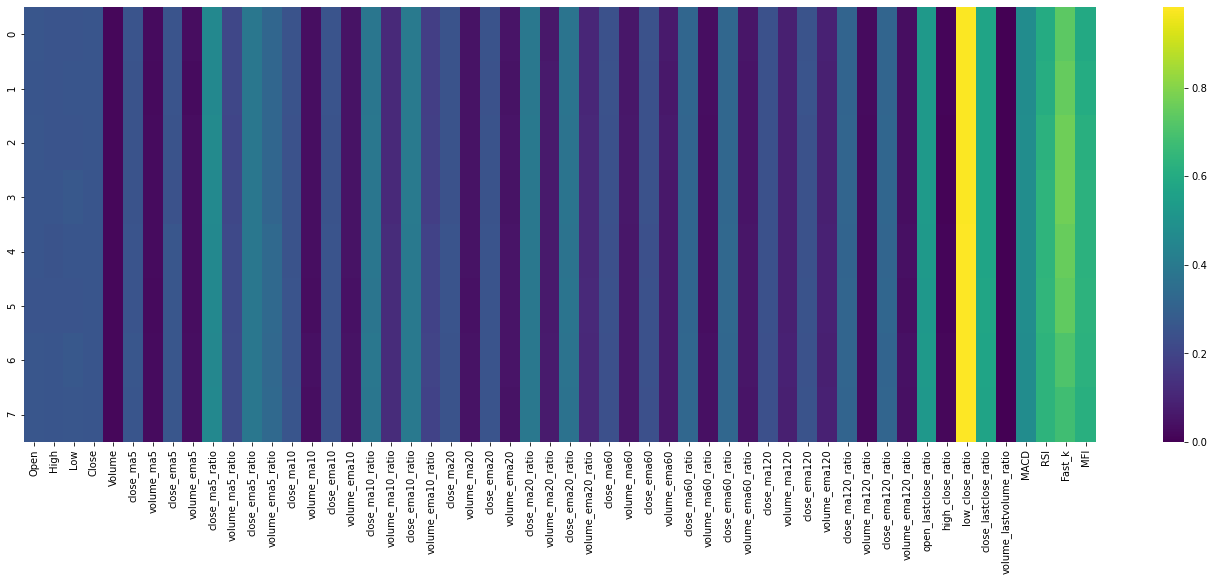

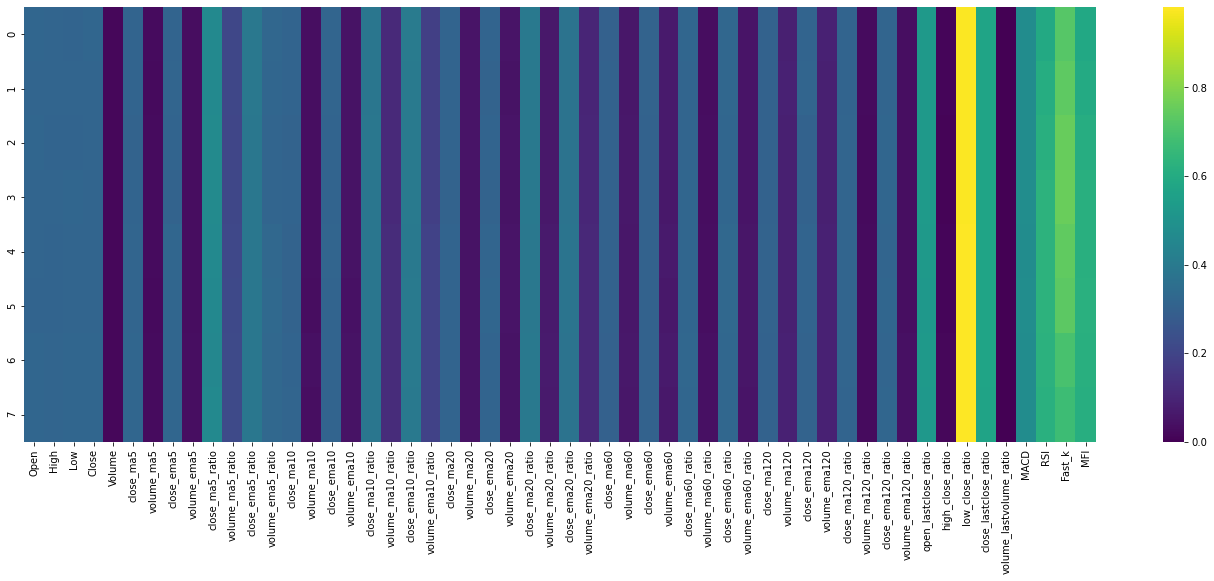

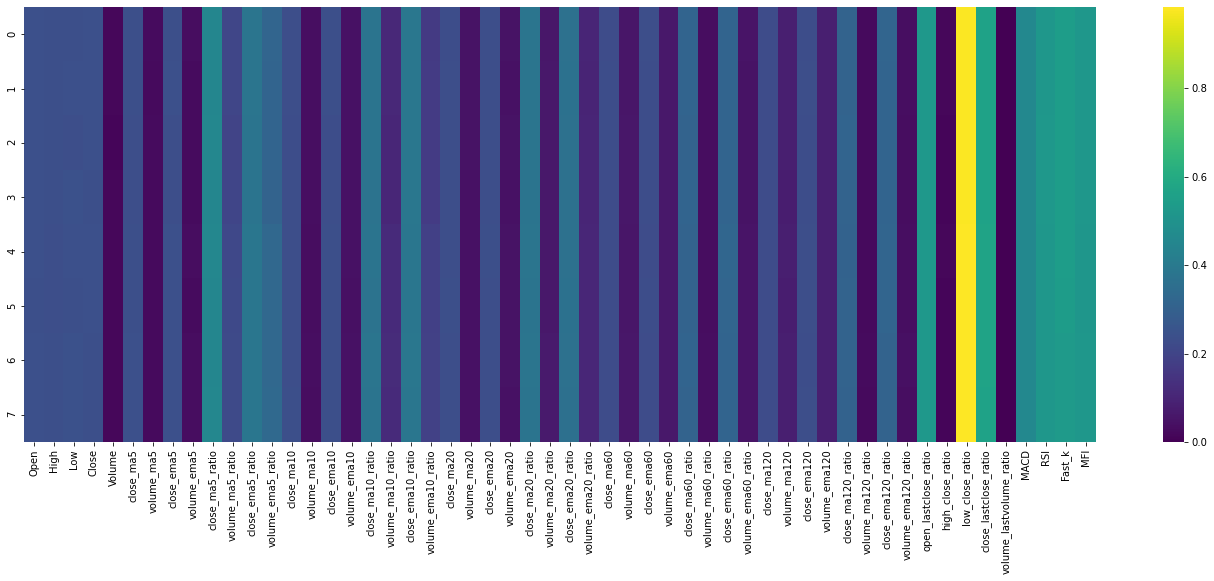

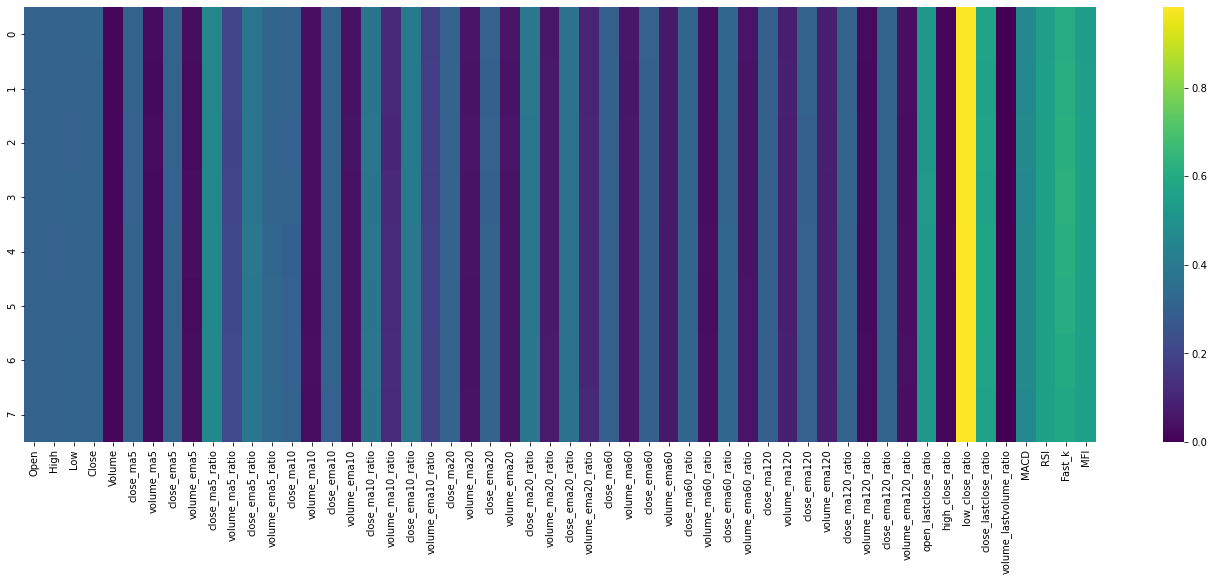

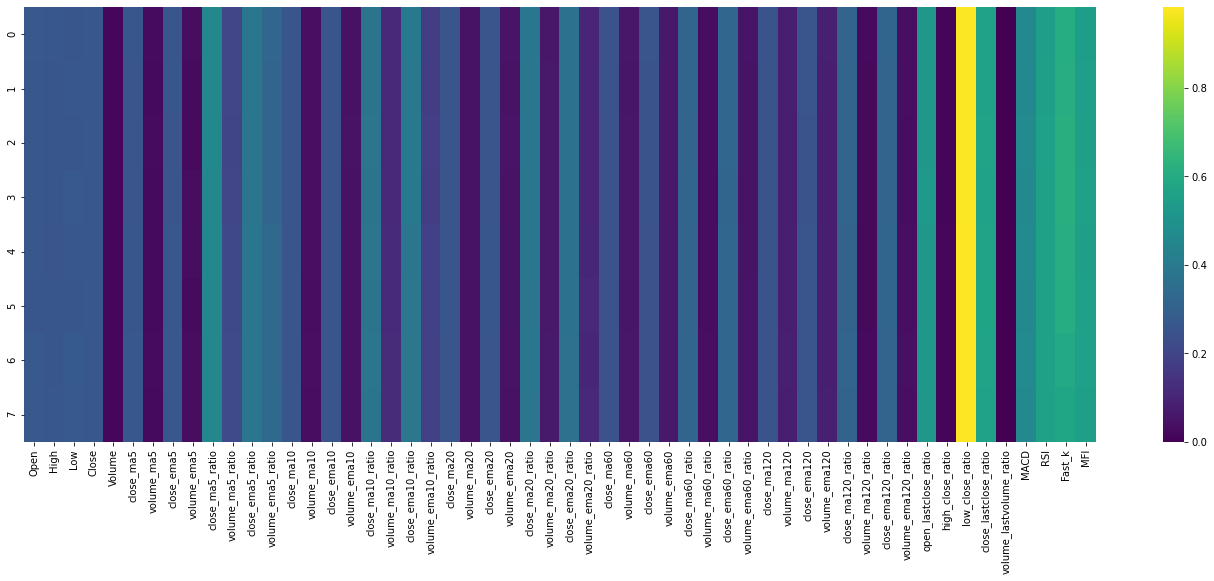

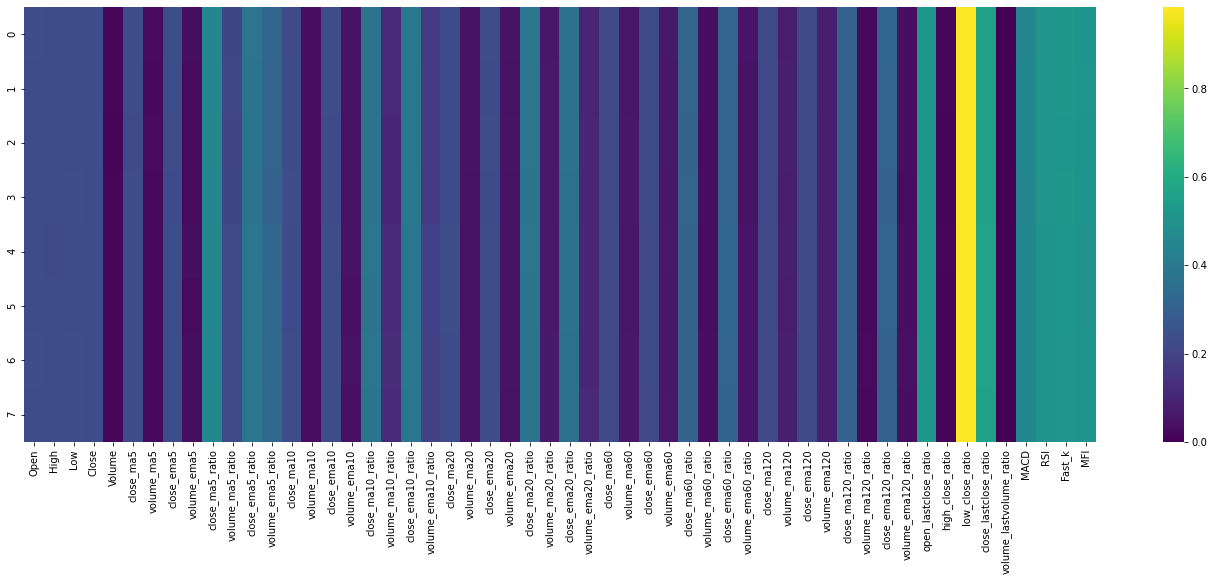

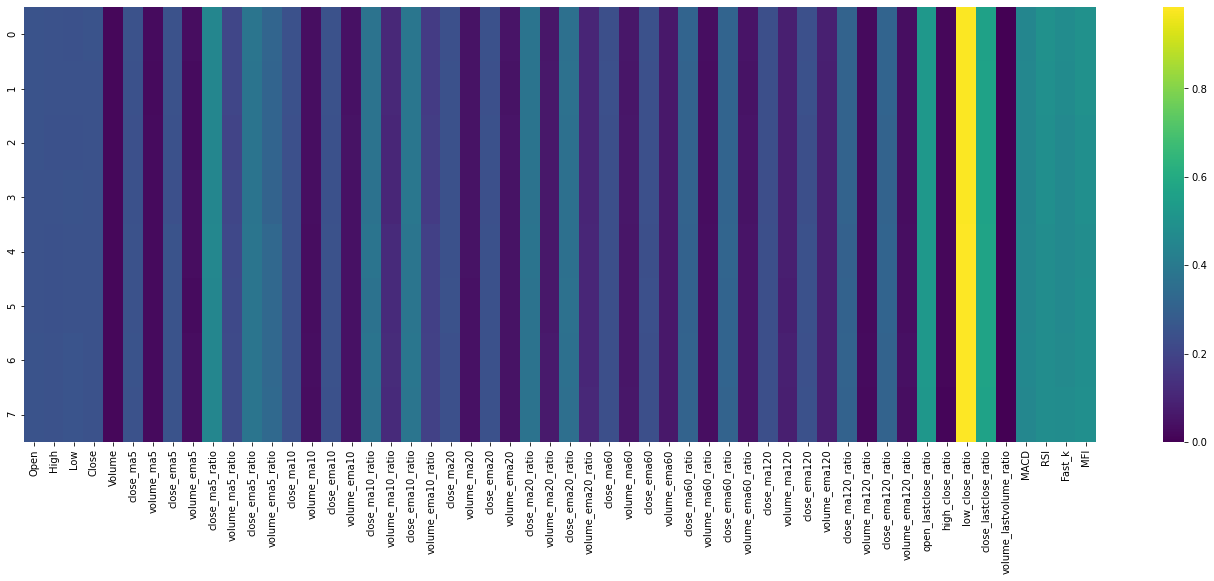

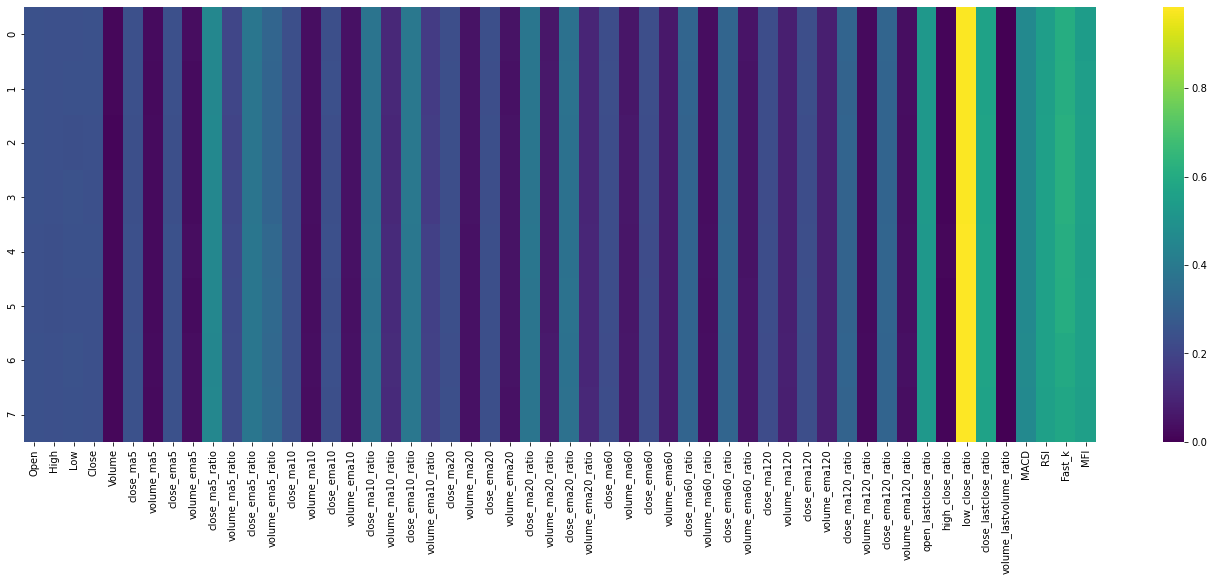

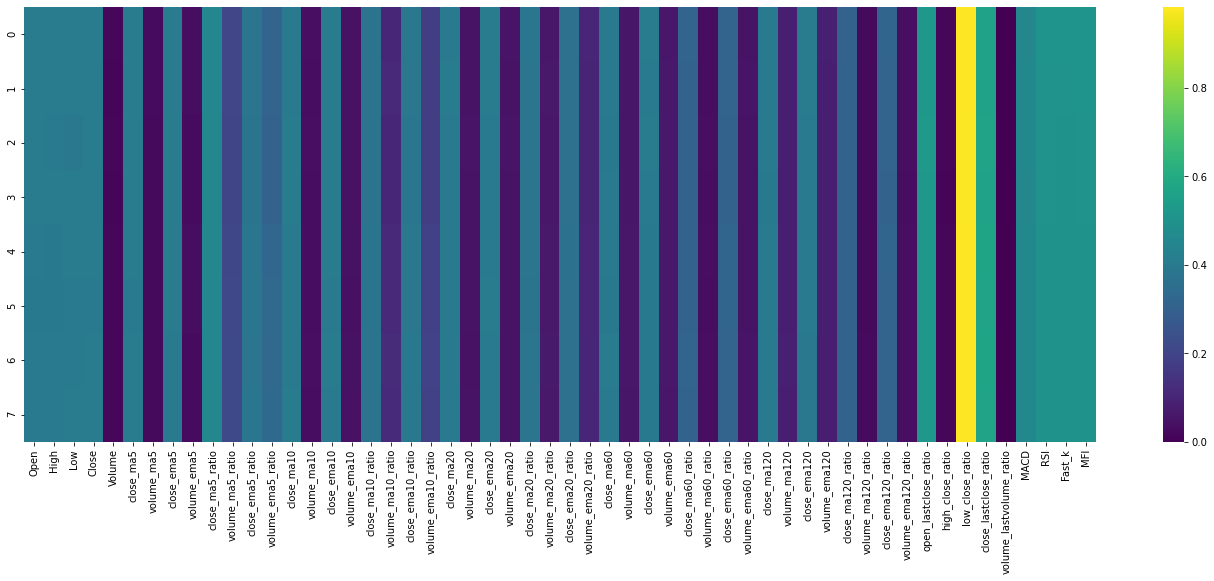

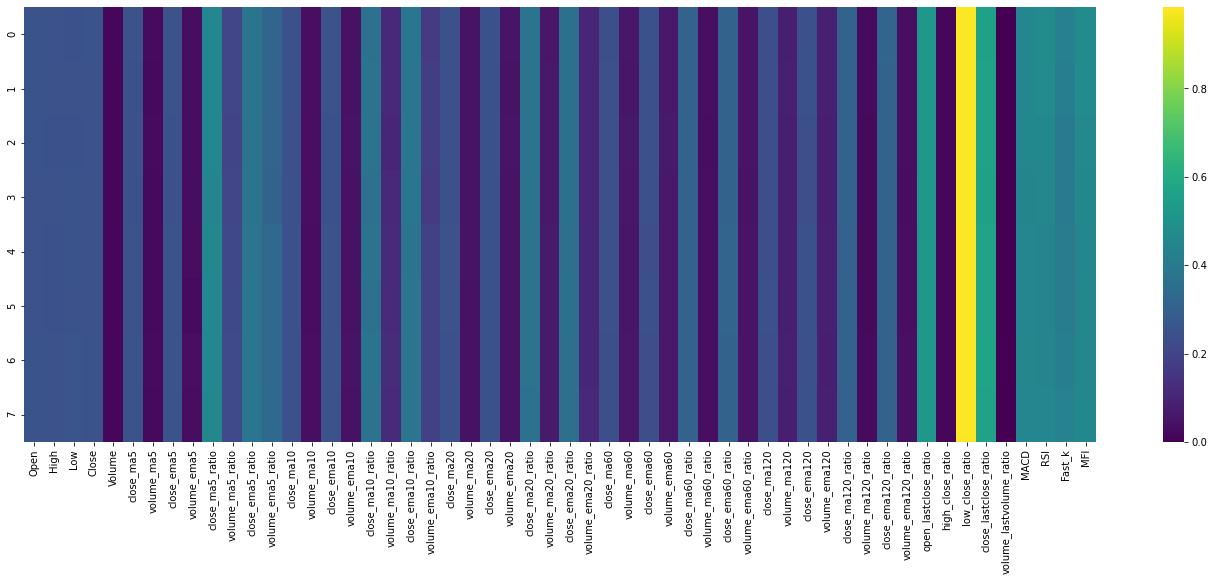

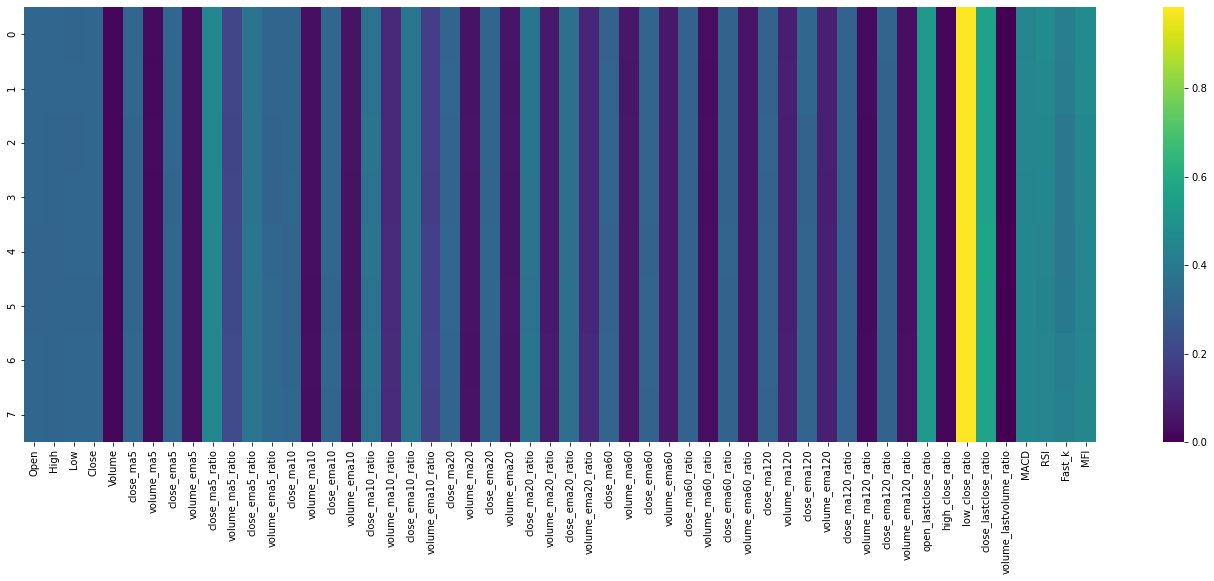

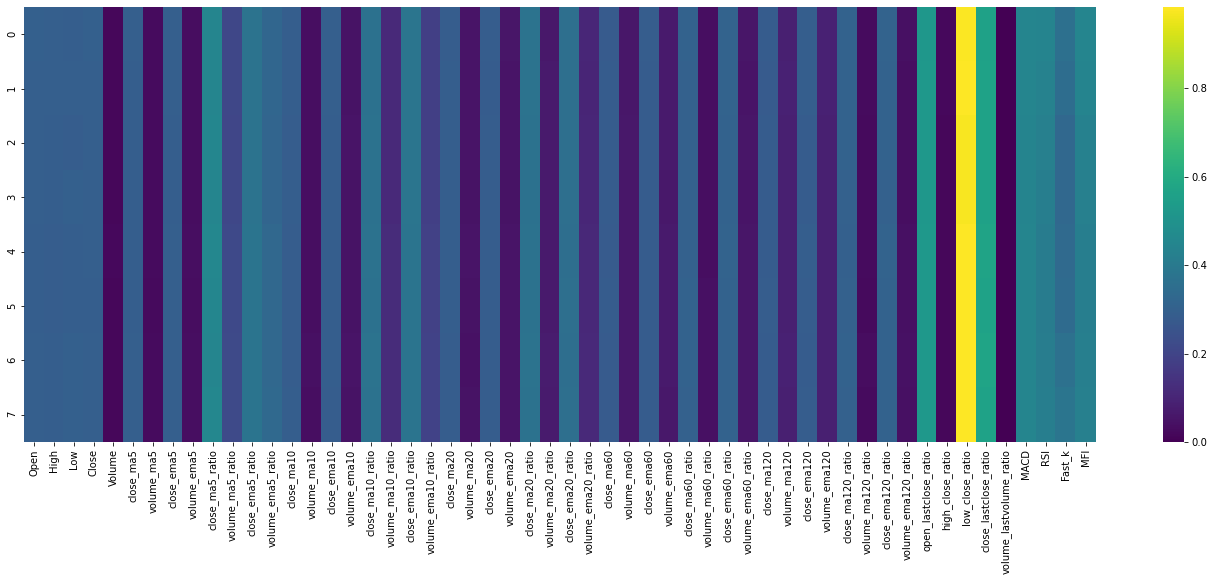

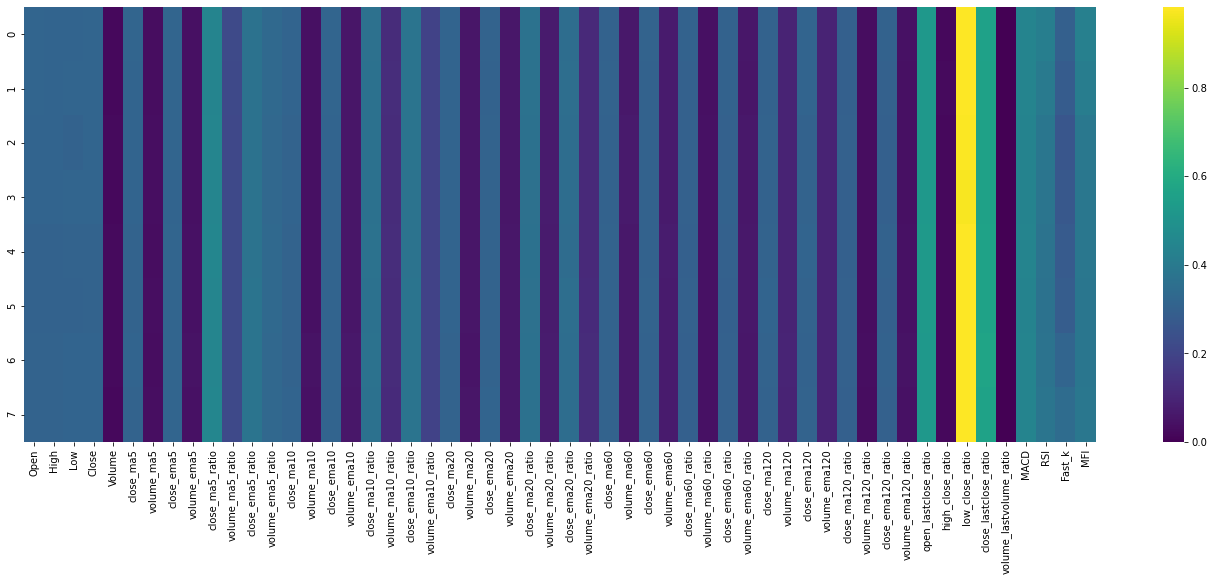

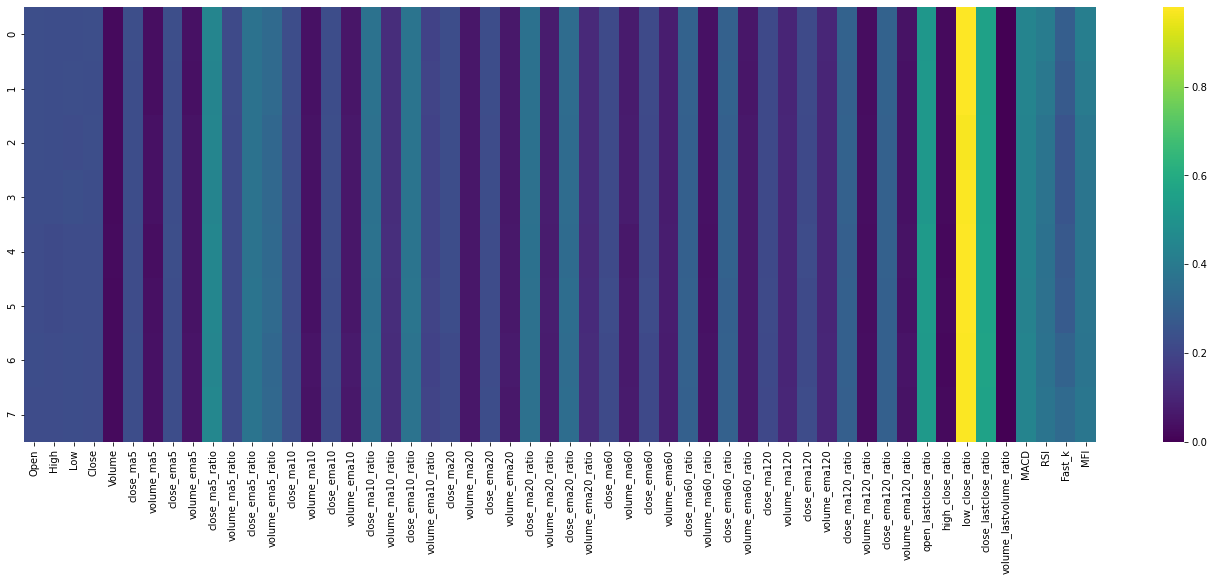

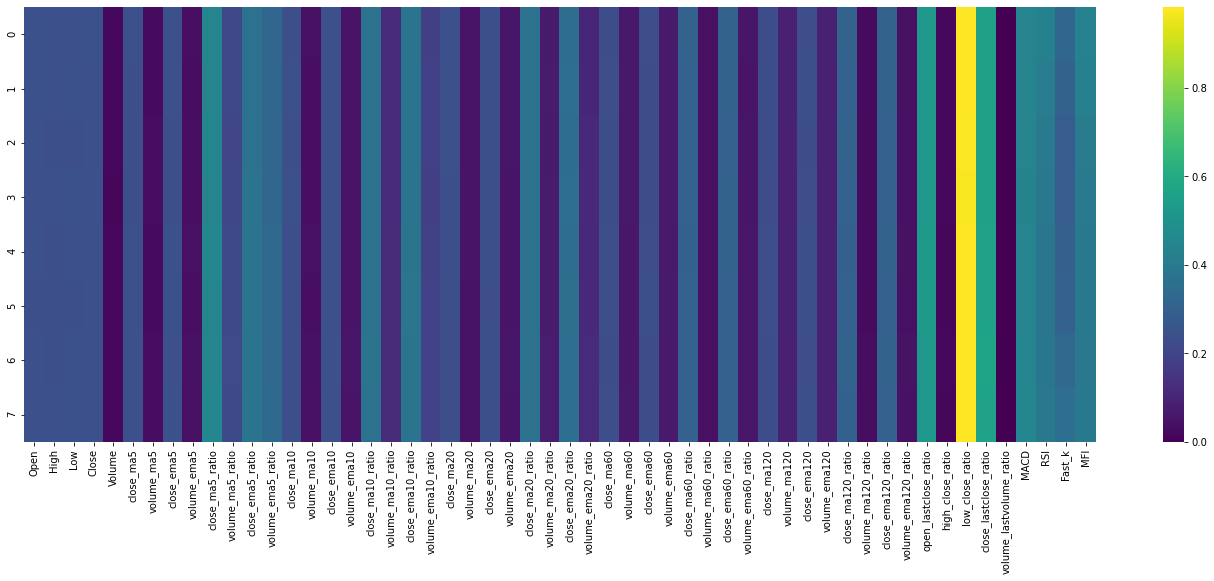

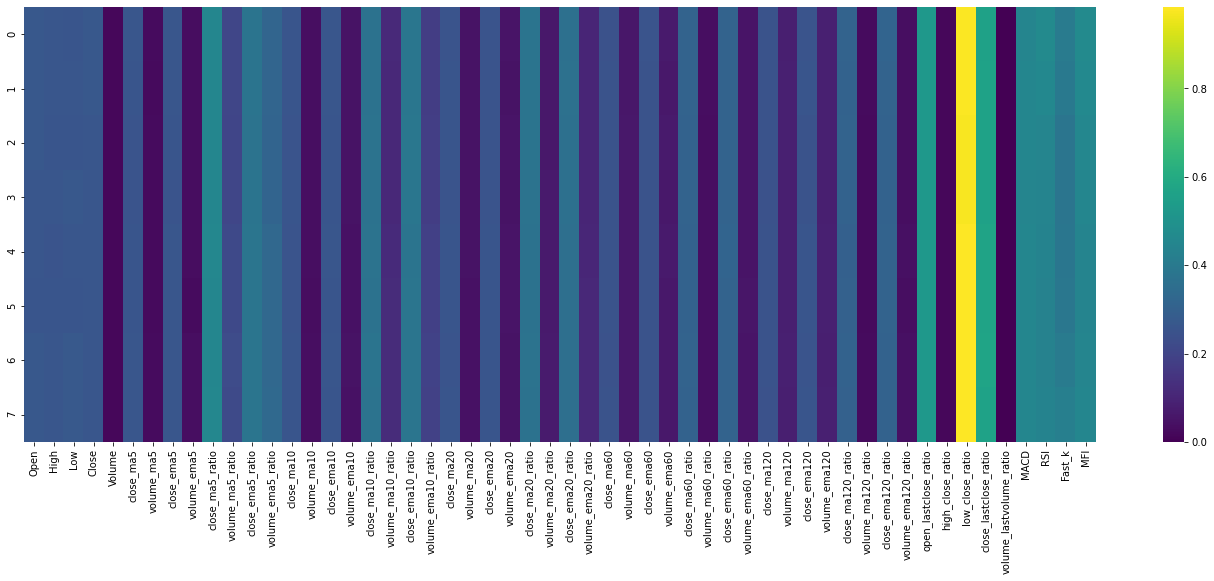

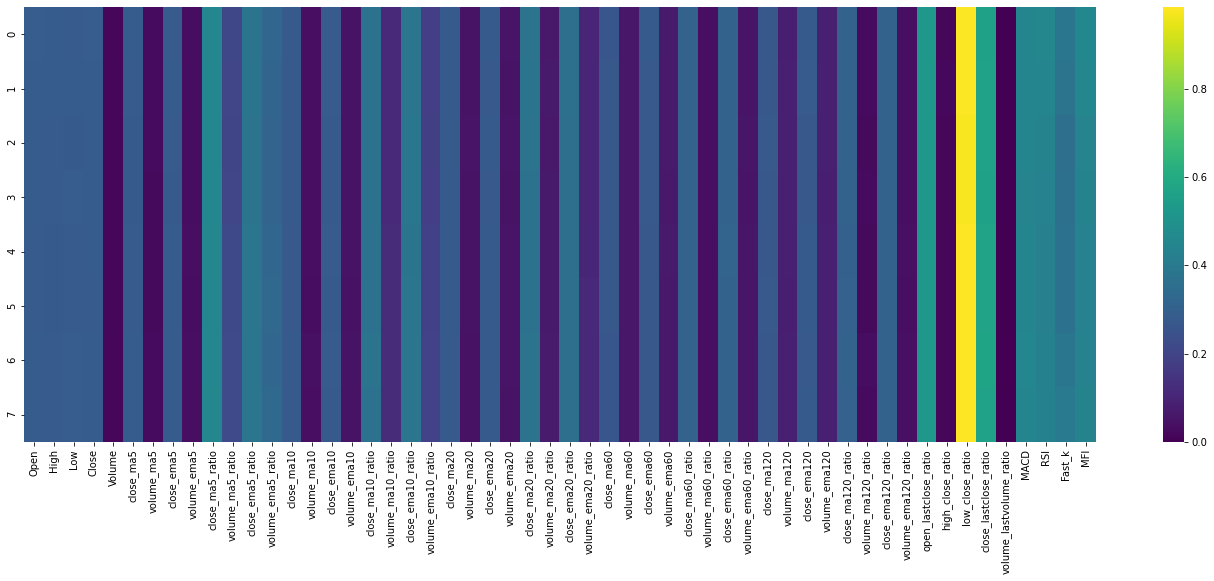

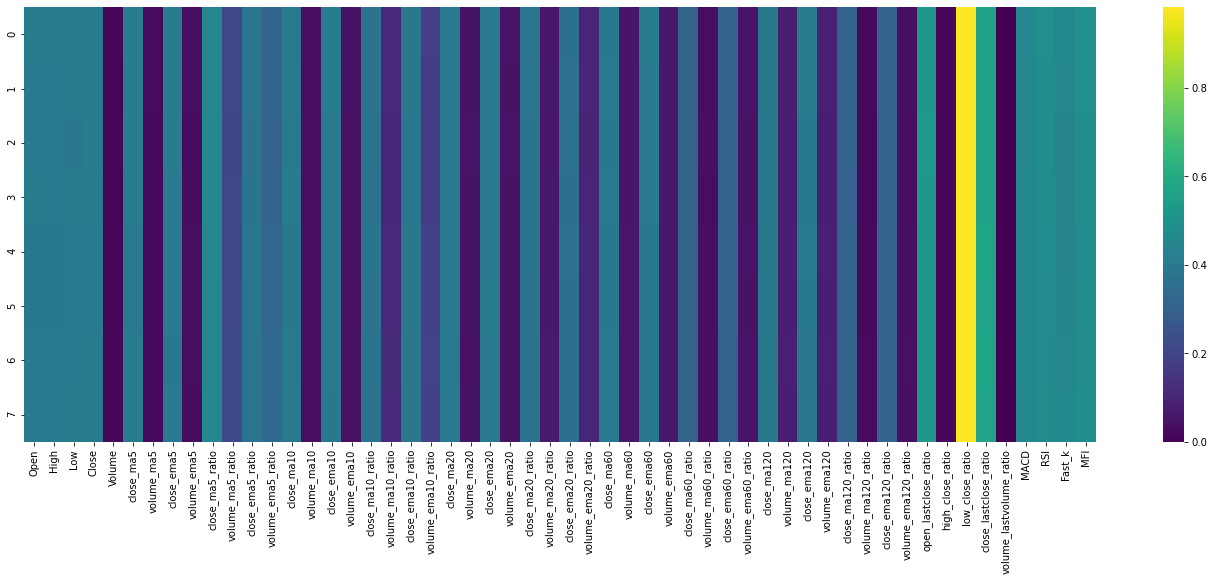

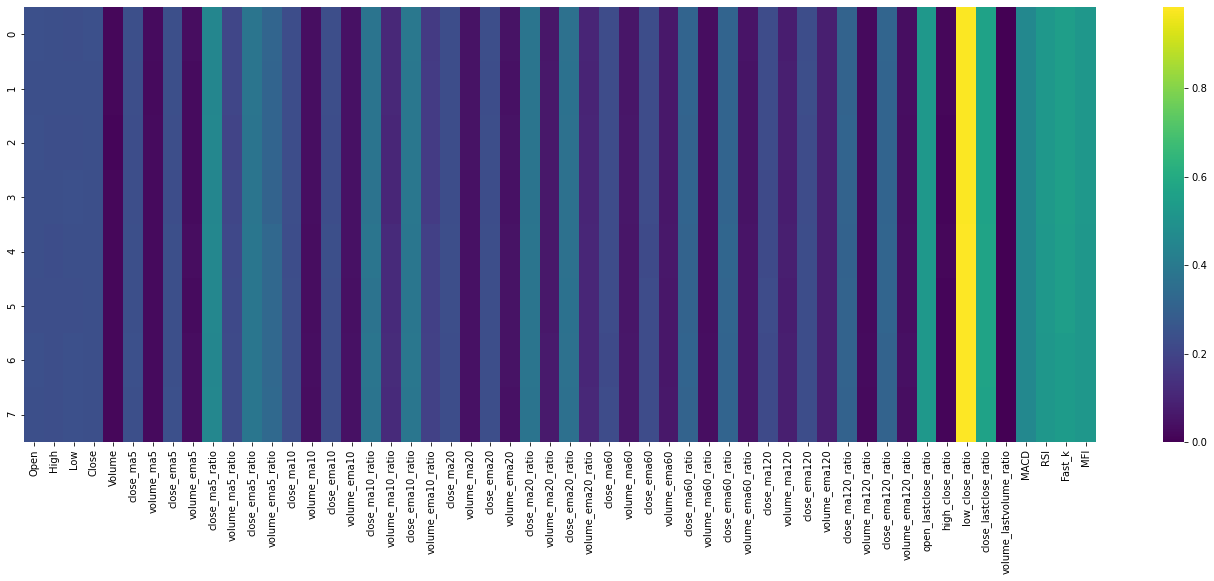

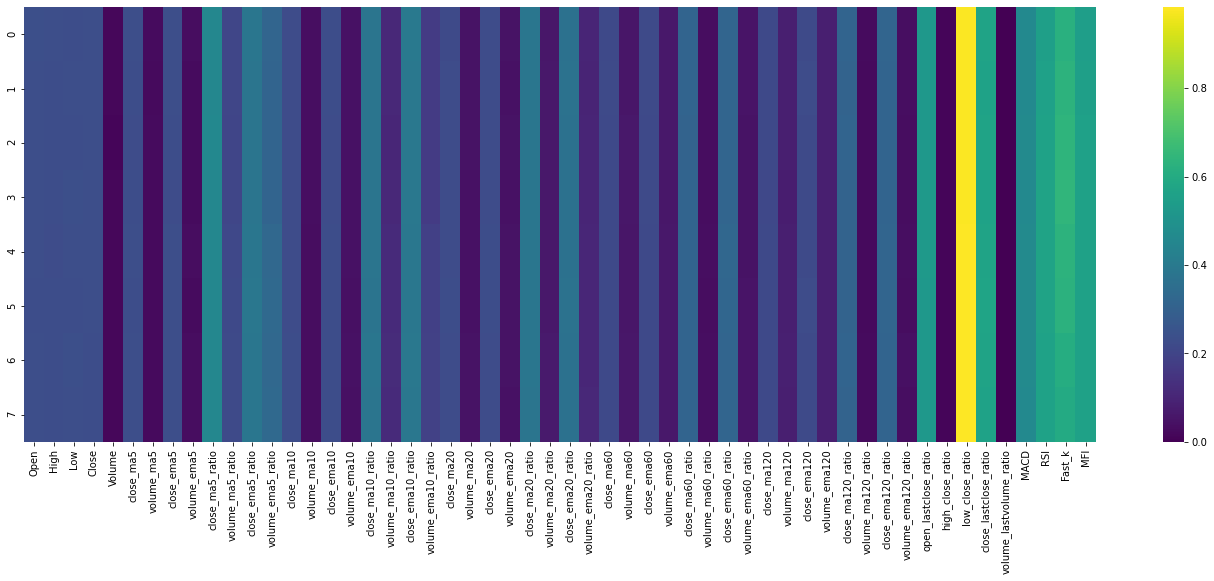

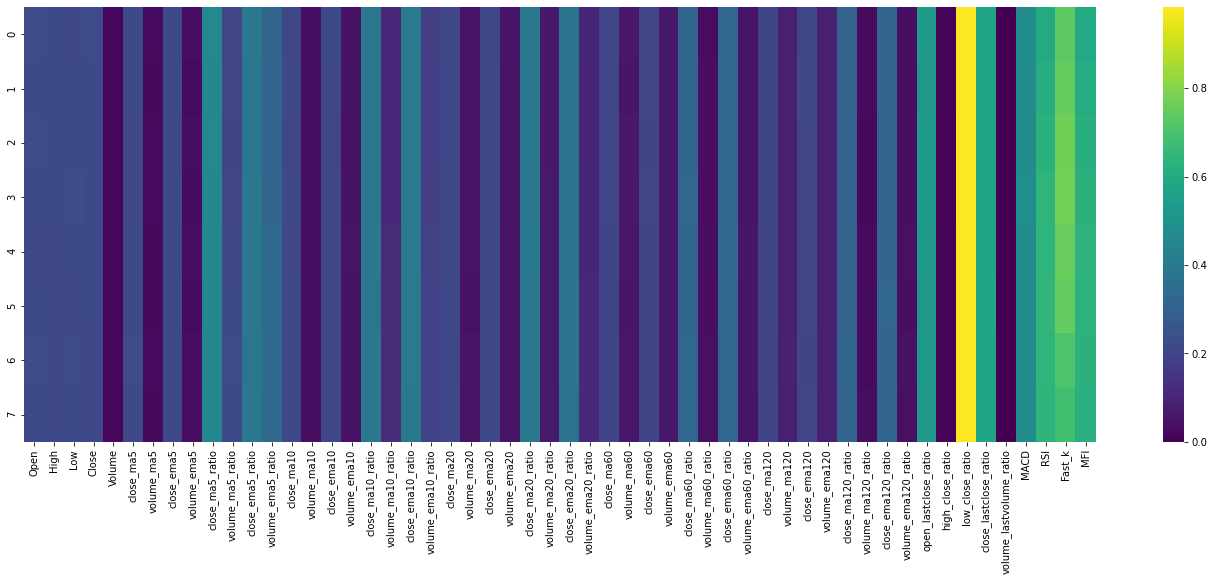

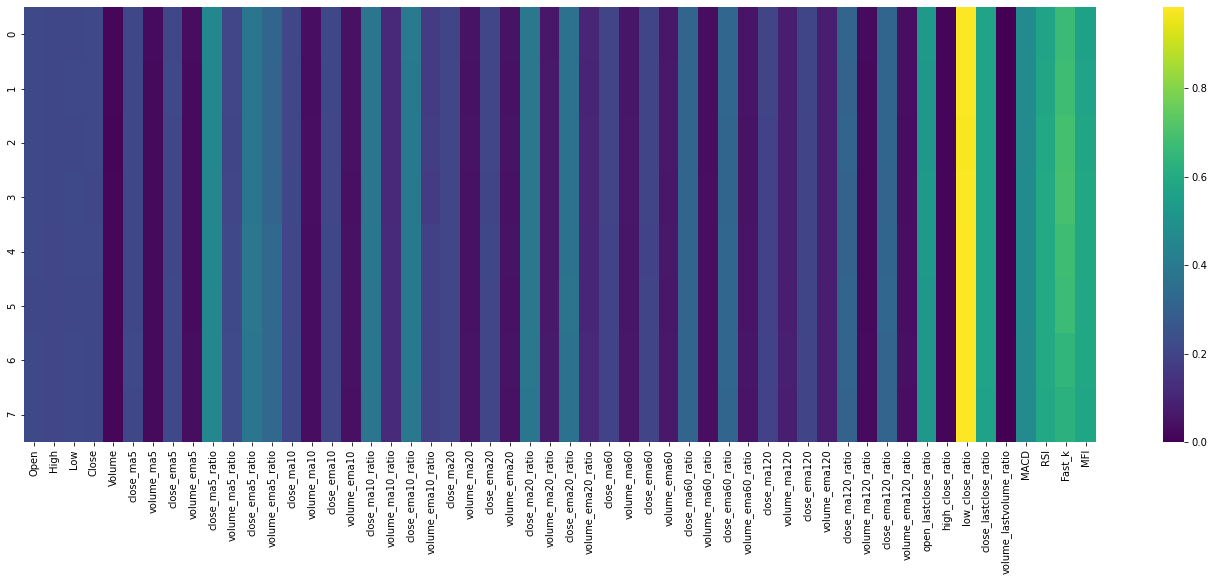

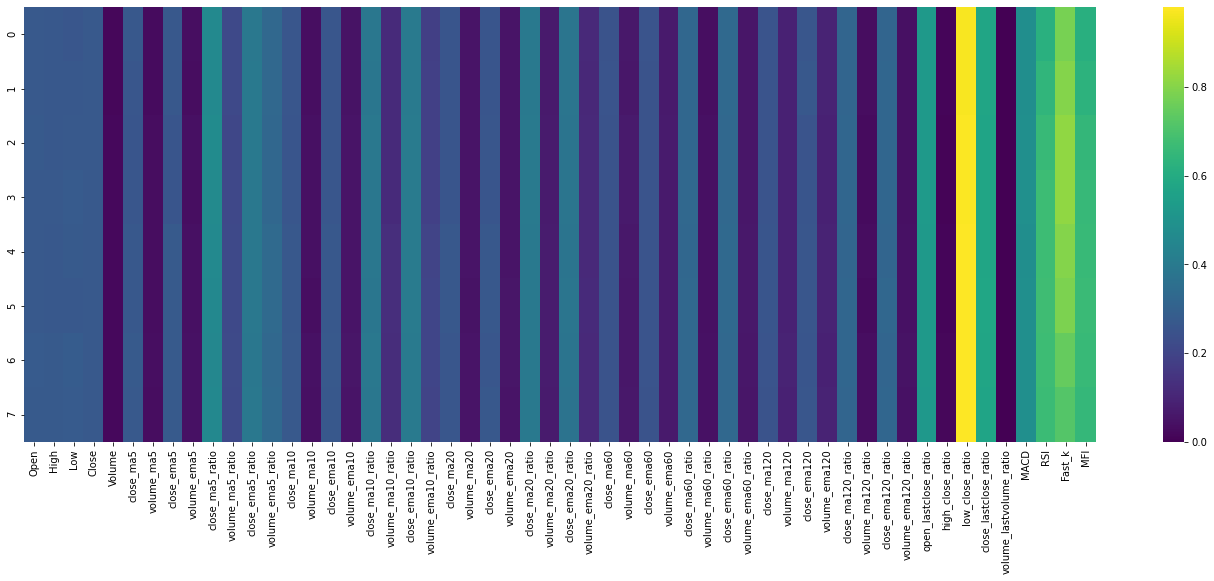

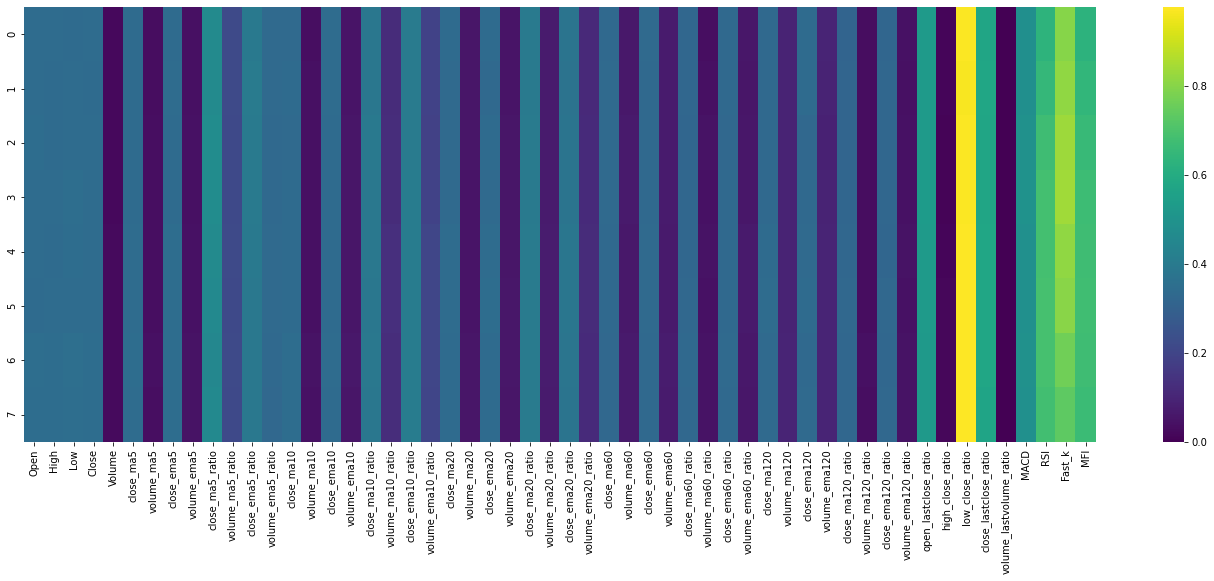

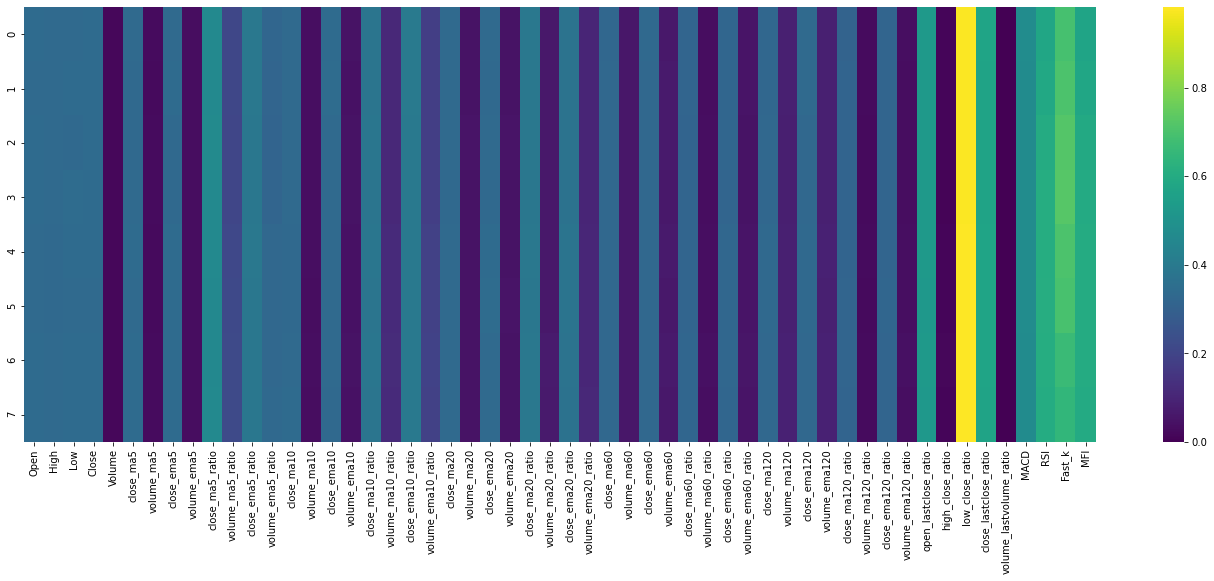

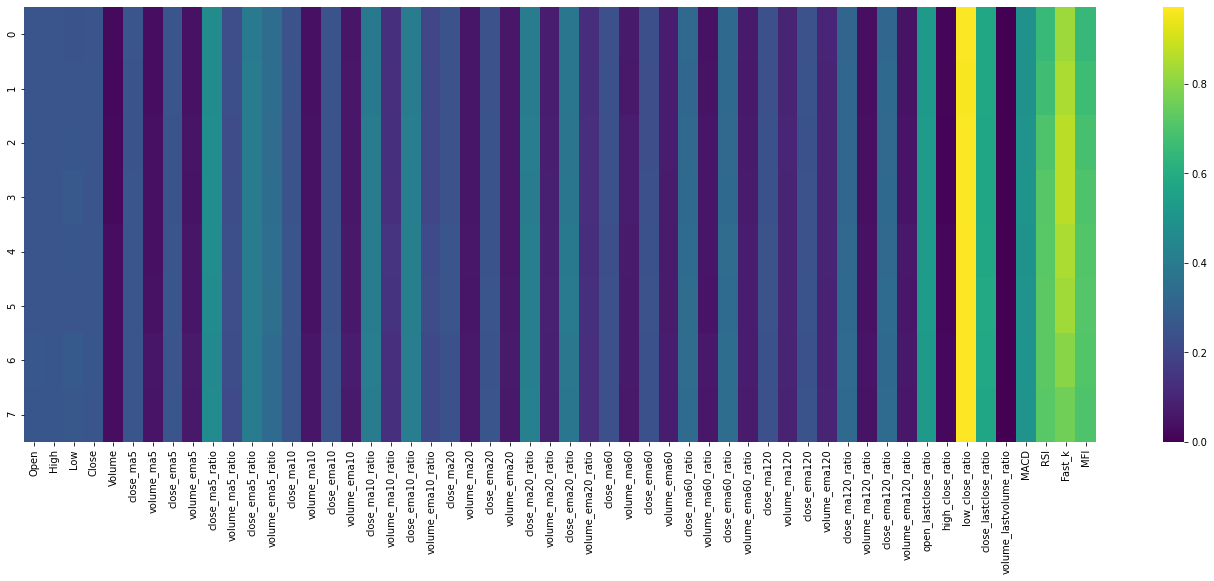

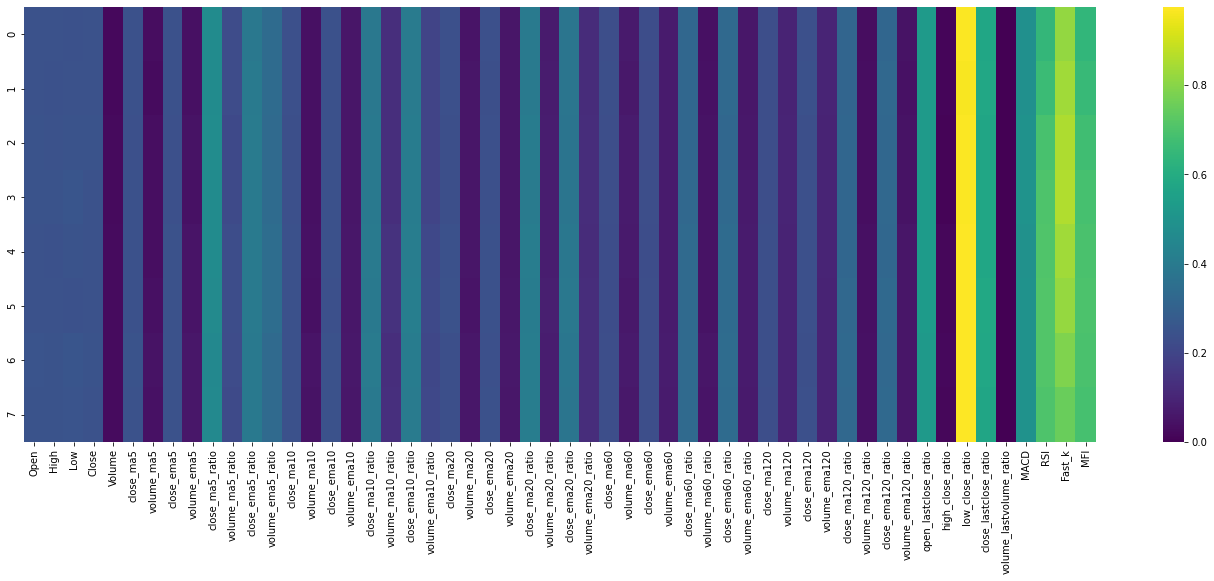

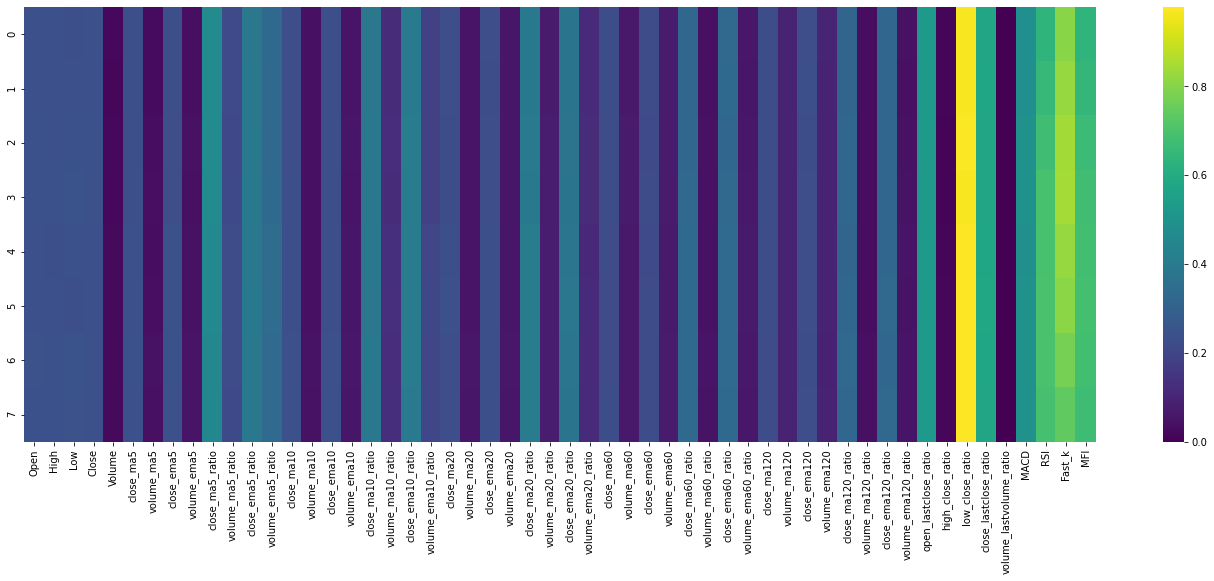

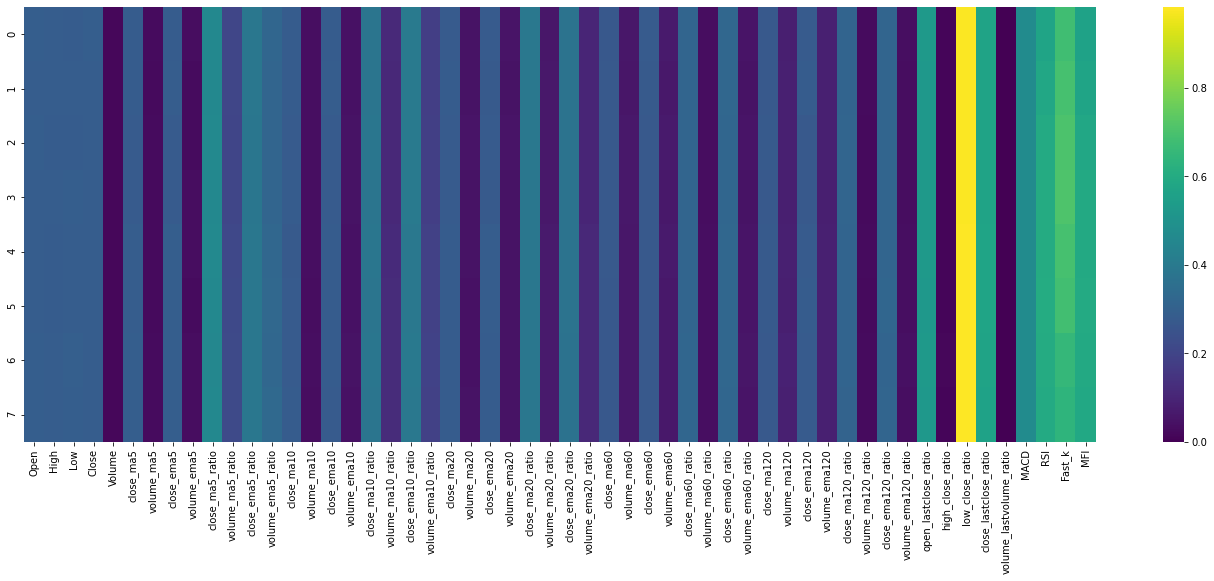

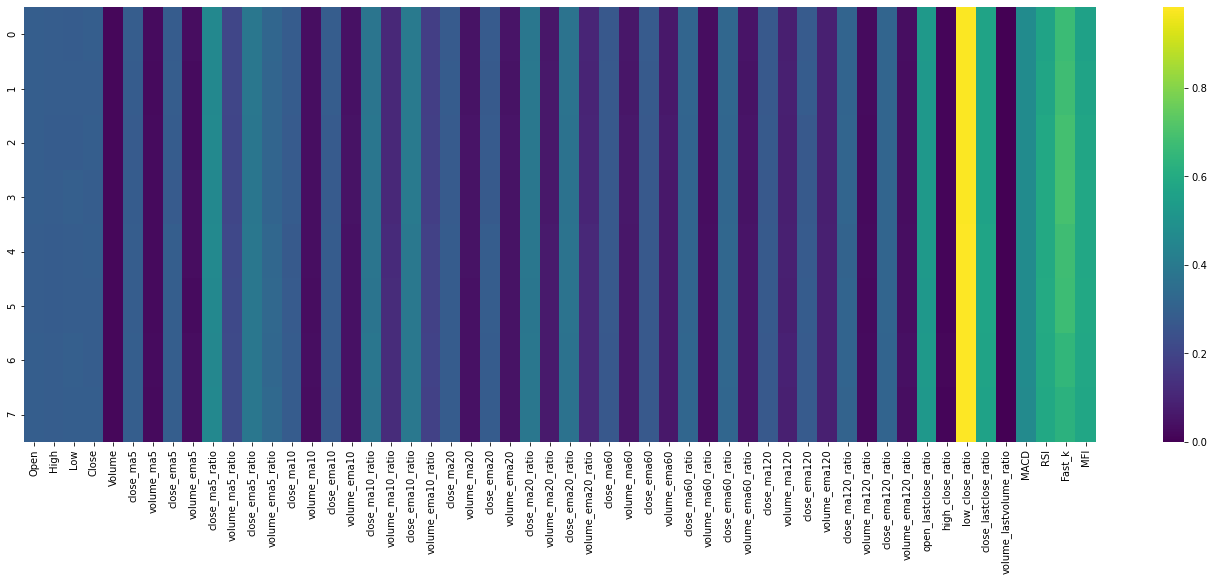

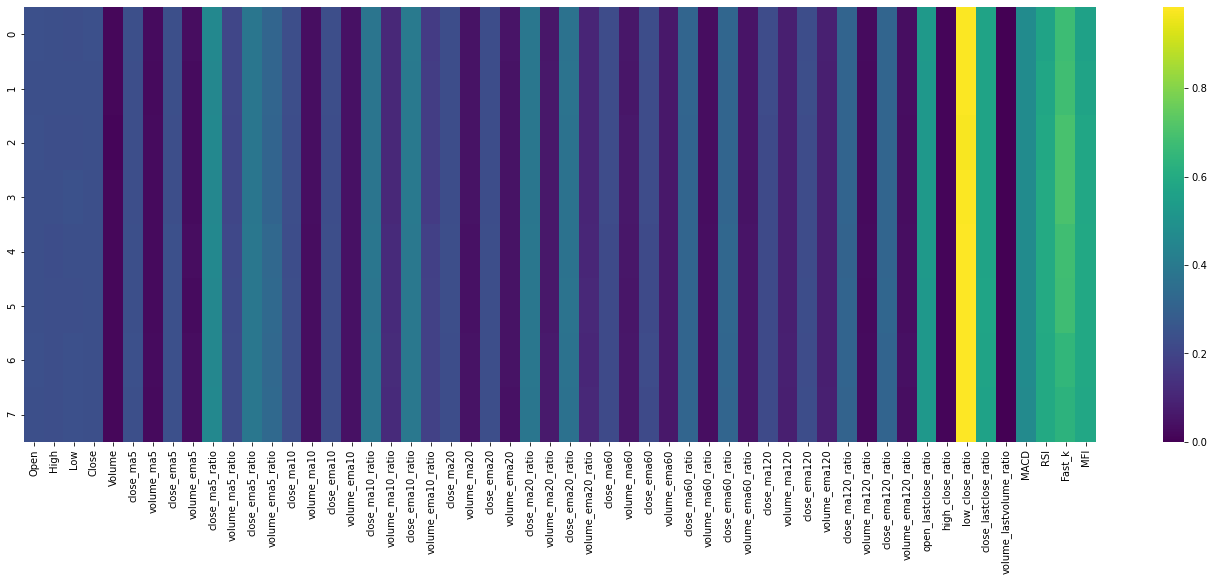

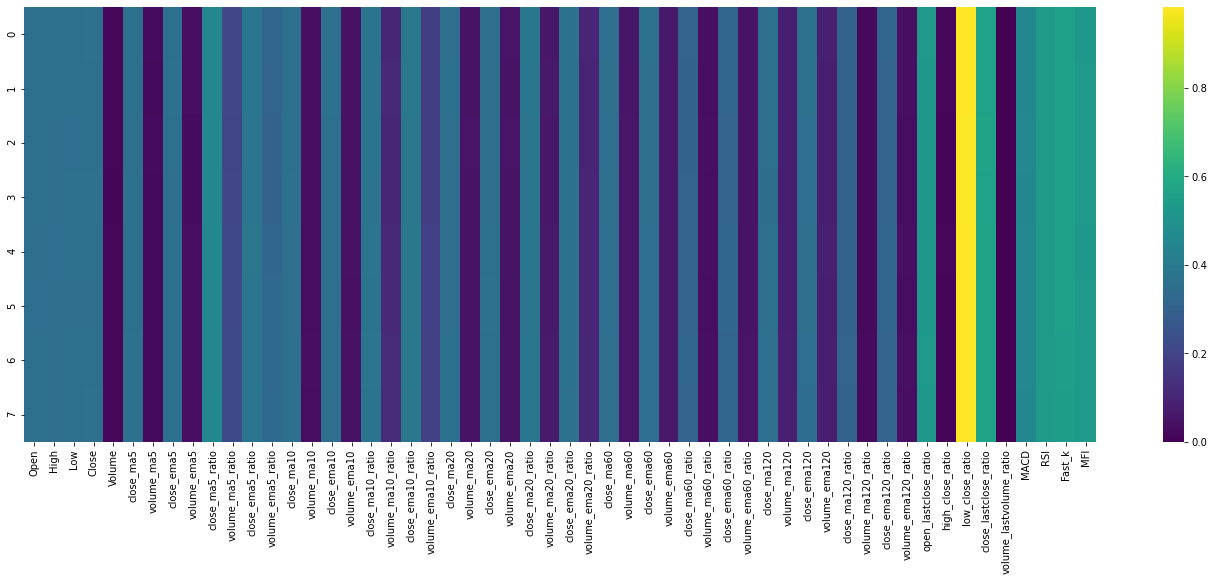

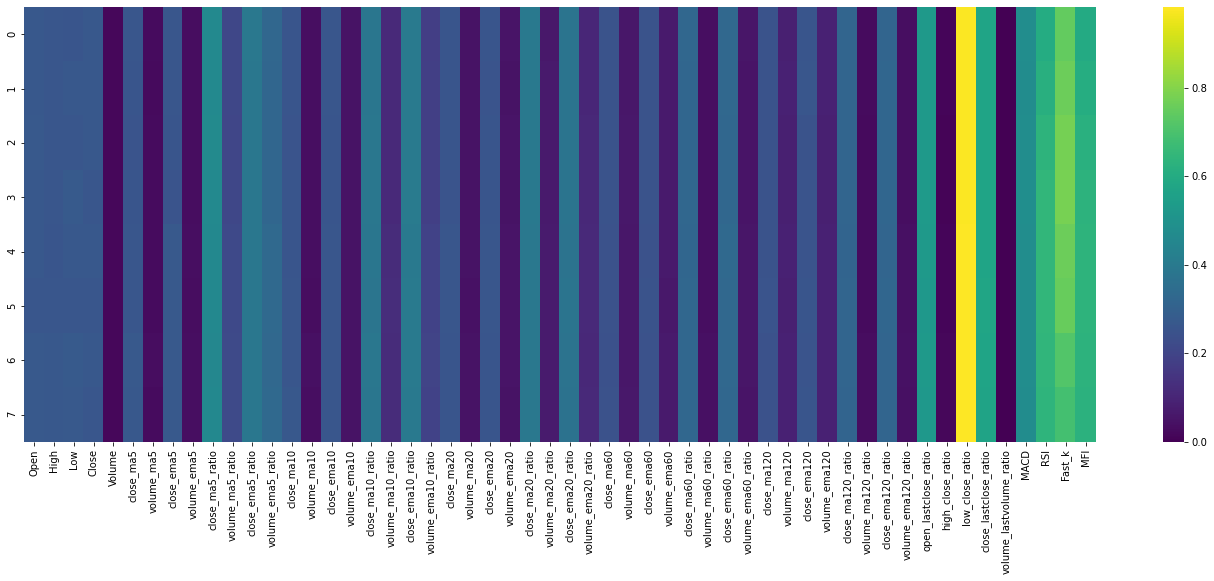

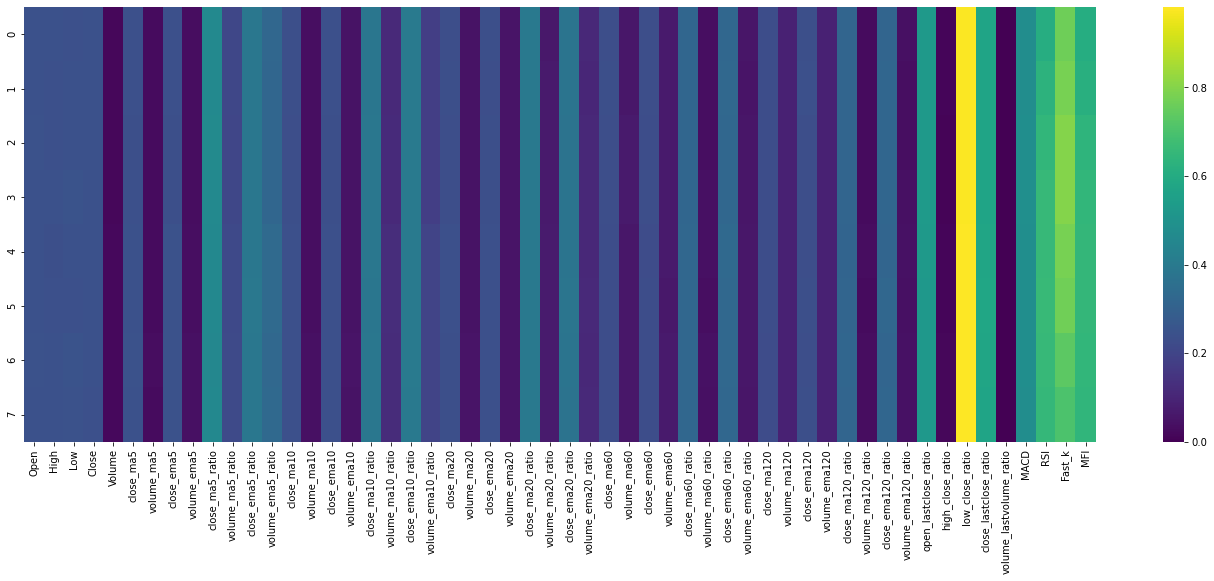

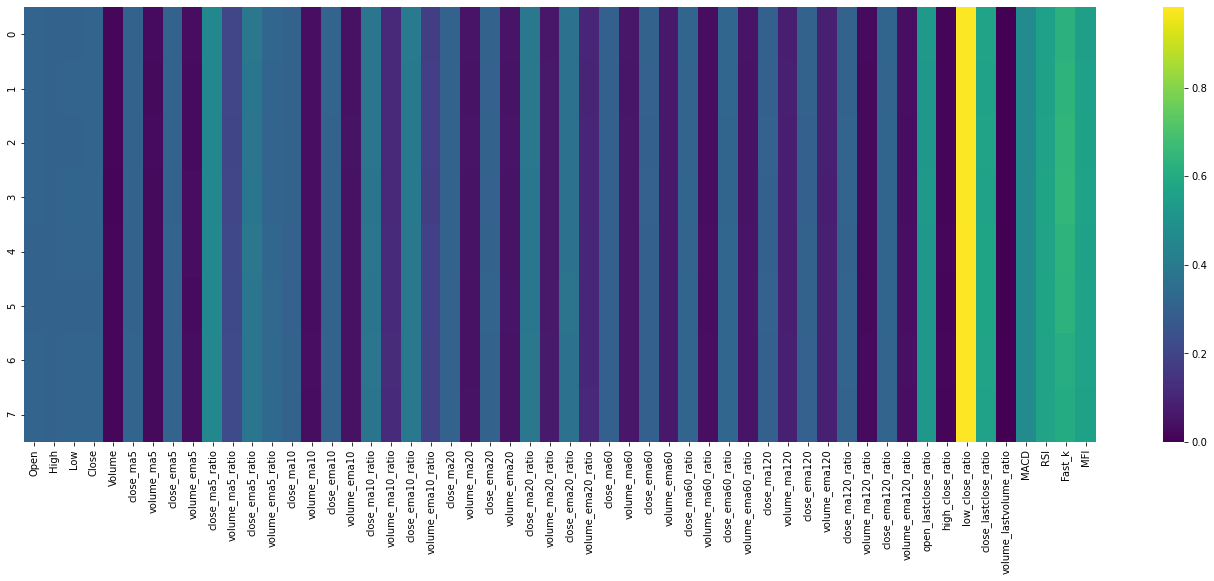

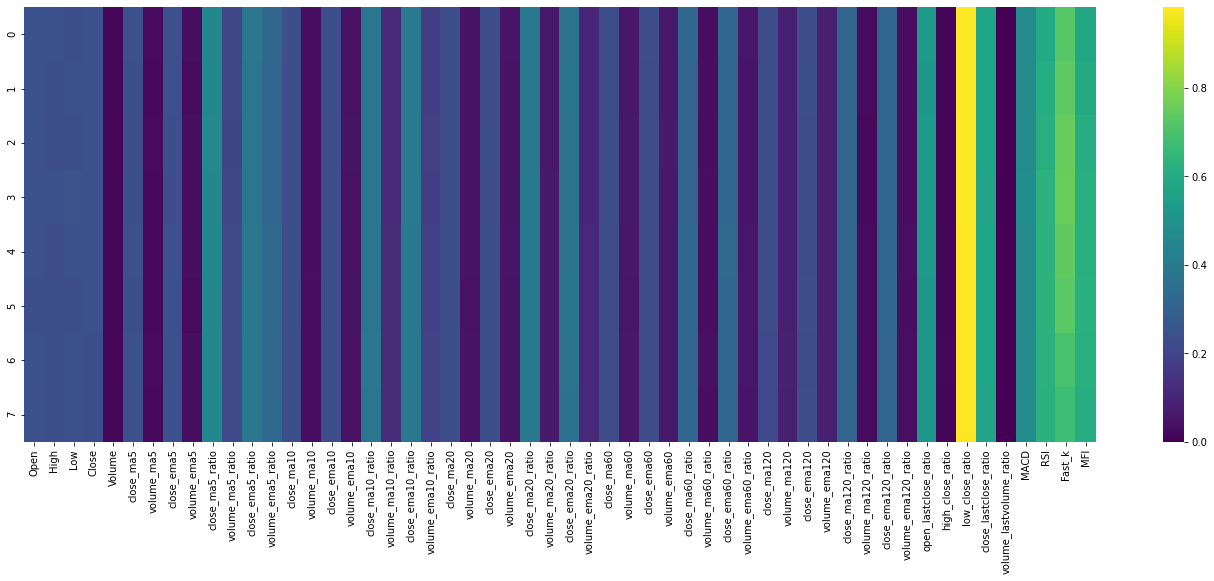

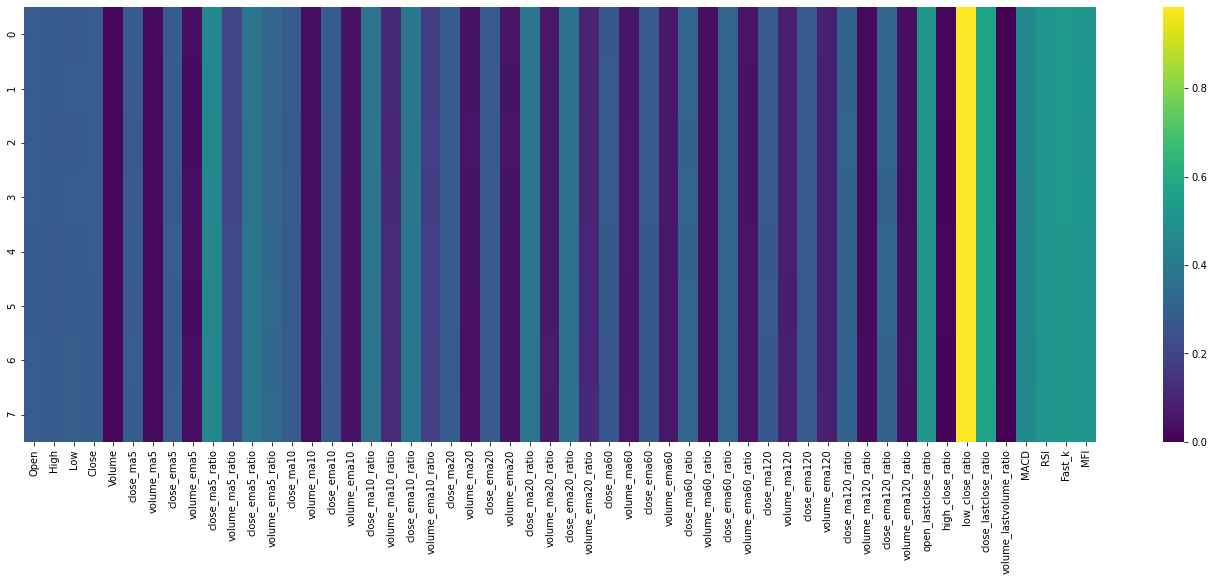

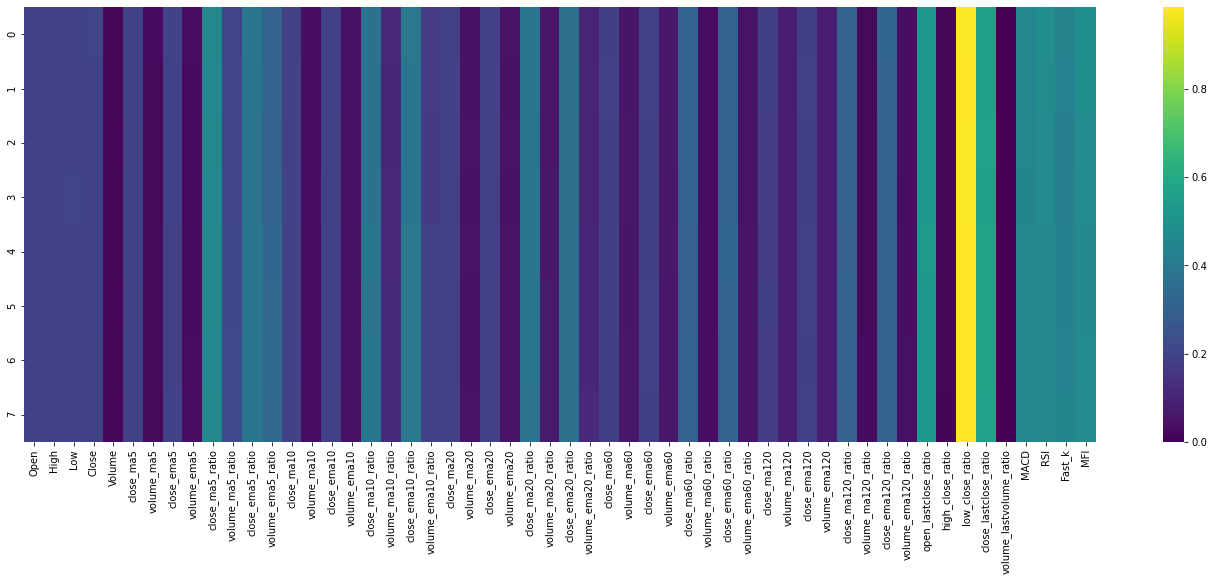

In [248]:
for i in range(100):
    heat_z=pd.DataFrame(decoded_latent_z[i].reshape(8,54),columns=tmp.columns)
    plt.figure(figsize=(24, 8))
    sns.heatmap(heat_z, cmap='viridis')
    plt.savefig('image{}_z.png'.format(i))

In [250]:
import imageio
import os

In [301]:
directory = r'image_z/'
file_type = r'png'
save_name = r'ani'
speed = { 'duration' : 0.1}

In [302]:
images = []
k=glob('image_z/*.png')
for file_name in k:
    images.append(imageio.imread(file_name))
imageio.mimsave('{}/{}.gif'.format(directory, save_name),images,**speed)

In [271]:
from glob import glob

In [290]:
k[0][12:]

'image10.png'

In [299]:
k=glob('image/*.png')
k

['image\\image10.png',
 'image\\image11.png',
 'image\\image12.png',
 'image\\image13.png',
 'image\\image14.png',
 'image\\image15.png',
 'image\\image16.png',
 'image\\image17.png',
 'image\\image18.png',
 'image\\image19.png',
 'image\\image20.png',
 'image\\image21.png',
 'image\\image22.png',
 'image\\image23.png',
 'image\\image24.png',
 'image\\image25.png',
 'image\\image26.png',
 'image\\image27.png',
 'image\\image28.png',
 'image\\image29.png',
 'image\\image30.png',
 'image\\image31.png',
 'image\\image32.png',
 'image\\image33.png',
 'image\\image34.png',
 'image\\image35.png',
 'image\\image36.png',
 'image\\image37.png',
 'image\\image38.png',
 'image\\image39.png',
 'image\\image40.png',
 'image\\image41.png',
 'image\\image42.png',
 'image\\image43.png',
 'image\\image44.png',
 'image\\image45.png',
 'image\\image46.png',
 'image\\image47.png',
 'image\\image48.png',
 'image\\image49.png',
 'image\\image50.png',
 'image\\image51.png',
 'image\\image52.png',
 'image\\im

## latent vector 차원 늘려보기, lstm seq length 최적화 필요함